https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data

# Import & Global variables


In [ ]:
# Reset memory usage
#%reset -f 

In [1]:
#!pip install memory_profiler
%load_ext memory_profiler
%memit

peak memory: 62.23 MiB, increment: 0.13 MiB


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', context='notebook', palette='deep')


# Path variables
notebooks_path = '../nbs/'
input_path = '../input/'
# Any results should be written to output directory.
output_path = '../output/'
print(os.listdir(input_path))

['.gitignore', 'sample_submission.csv', 'test.csv', 'train.csv', 'zip']


## Helpers and utilities
* Gini is used as evaluation metric Helper functions are needed to:
    * Compute the Gini score.
    * As a base for model custom scorer.


In [46]:
#! pip install numba
from numba import jit

# Compute gini

# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [4]:
def get_number_safe(value, nan_val=0):
    return nan_val if np.isnan(value) else value    


def draw_text_values(ax, max_height=0, text_format='{:1.0f}'):
    for p in ax.patches:
        height = get_number_safe(p.get_height())
        if height == 0:
            continue
        width =  get_number_safe(p.get_width())
        x = get_number_safe(p.get_x())          
        width = width/ 2. + x
        ax.text(width, height + max_height/100,
                text_format.format(height),
                ha='center', fontsize=12)  

def get_subplots_axes(count, max_cols=3, row_size=4, width=16):    
    rows = max(1, int(count/max_cols))
    cols = min(max_cols, count)
    fig_size = (width, row_size * rows)
    fig, axes = plt.subplots(figsize=fig_size, nrows=rows, ncols=cols)
    if count <= max_cols:
        axes = np.array([axes])
    axes = axes.reshape(-1)
    missing = count - rows * cols 
    if missing > 0:
        mis_fig, mis_axes = get_subplots_axes(count=missing, max_cols=missing, row_size=row_size, width=missing*width/max_cols)
        axes = np.concatenate([axes ,mis_axes])
    return fig, axes


def bar_plot_unique_counts(df, cols, title=None ,max_to_show=-1, max_cols=3, row_size=4, hist=False):
    fig, axes = get_subplots_axes(count=len(cols), max_cols=max_cols, width=16, row_size=row_size)
    if title is not None:
        fig.suptitle(title, fontsize=22, y=1.02)

    # Unique values in each column
    for ax, col in zip(axes, cols):
        sliced_data = df[col].value_counts()
        #sliced_data = sliced_data.sort_values(ascending=False).reset_index()
        sliced_data = sliced_data.reset_index()
        bars_count = len(sliced_data)
        ax.set_title('{} - {} Unique Values'.format(col.title(), bars_count), fontsize=13)
        if bars_count > max_to_show and max_to_show != -1:
            if hist:
                print('Column', col, 'has too many values:', len(sliced_data), ',showing hist instead')
                ax.hist(df[df[col] != -1][col], bins=max_to_show)
            else:
                print('Column {} has too many values ({}). Showing only the {} most frequent values'.format(col, len(sliced_data), max_to_show))
                sliced_data = sliced_data[(sliced_data[col] >=  sliced_data[col][max_to_show]) | (sliced_data['index'] == -1)]
                g = sns.barplot(data=sliced_data, x='index', y=col, ax=ax)#, order=sliced_data[col].astype(str))#x=sliced_data.index, y=sliced_data.values, ax=ax)
                col_text = 'Partial - {} out of {}'.format(len(sliced_data), bars_count)
                #ax.set_title(col.title())
                ax.text(0.5, 0.7,  col_text, color='red', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes, fontsize=16, bbox=dict(alpha=0.1))
                #ax.tick_params(axis='x', rotation=35)
                ax.set_xticklabels( ax.get_xticklabels(), fontsize = 11, rotation=35)

                
        else:
            ax = sns.barplot(data=sliced_data, x='index', y=col, ax=ax)

        ax.set_ylabel('Values Count')
        ax.set_xlabel('Uniqu Values')
        max_height = sliced_data.values.max()
        draw_text_values(ax, max_height)
        
    fig.tight_layout()

In [5]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Data Loading
* There are 3 tables, each in separate file:
    * Train set - Labeld data, a table with ids, data columns and labels.
    * Test set - Same as the train set but without the labels (target) column.
    * Sample submission - Ids and classification results, used as a base for submission format.

In [6]:
#train_dataset_copy = train_dataset.copy(deep=True)
#test_dataset_copy = test_dataset.copy(deep=True)
print('Loading Train Set...')
train_dataset = pd.read_csv(input_path + 'train.csv')
print('Loading Test Set...')
test_dataset = pd.read_csv(input_path + 'test.csv')
print('Loading Sample Submission...')
sample_submission = pd.read_csv(input_path+'sample_submission.csv', index_col=['id'])
print('Done.')

Loading Train Set...
Loading Test Set...
Loading Sample Submission...
Done.


## Data Exploration
Size, types  of the train and test data sets.
* Data sets size - how many rows and columns each data set contains


In [6]:
print('\t  (rows, columns)\nTrain set: {}\nTest set: {}'.format(train_dataset.shape, test_dataset.shape))

	  (rows, columns)
Train set: (595212, 59)
Test set: (892816, 58)


___
* A quick look at the Train Set:

In [7]:
print('Train Set head:')
train_dataset.head(3)

Train Set head:


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


_____
* What are the data types in both train and test sets

Columns that are in train set and not in the test set: ['target']

Columns count by data type:


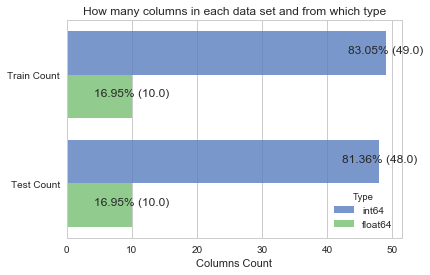

In [7]:
# Return a table with count of all column types 
def explore_dtypes(df):
    types = pd.DataFrame(df.dtypes, columns=['Column Data Type'])
    types['Count'] = types.index
    types.reset_index(drop=True, inplace=True)
    return types.groupby(by=['Column Data Type']).count()

diff_cols = [col for col in train_dataset.columns if col not in test_dataset.columns]
print ('Columns that are in train set and not in the test set:', diff_cols)

print('\nColumns count by data type:')

# Gets type counts
train_d_types = explore_dtypes(train_dataset)
test_d_type = explore_dtypes(test_dataset)

train_d_types['Test Count'] = test_d_type.Count
train_d_types = train_d_types.reset_index()
train_d_types['Column Data Type'] = train_d_types['Column Data Type'].astype(str)
train_d_types.columns = ['Type', 'Train Count', 'Test Count']
total = train_d_types['Train Count'].sum()

train_d_types = pd.melt(train_d_types, id_vars='Type', var_name='Train Count', value_name='Test Count')

# Creates a bar plot of both train and test
g = sns.barplot(x='Test Count', y='Train Count',data=train_d_types, hue='Type' ,
                 palette='muted', alpha=0.8)
g.set_ylabel('')
g.set_xlabel('Columns Count')
g.set_title('How many columns in each data set and from which type')

# Add percentages and values as text to the chart
for p in g.patches:
    height = p.get_height()/2. + p.get_y()
    width =  p.get_width()

    g.text(width, height,
            '{:1.2f}% ({})'.format(100 * width/total, width),
            ha="center") 

* The data contains only columns of types **Int64** and **Float64**, most of them are of type **Int64**.
* Train and test sets data types look almost the same*. 

 \*The only diffence is that the train set contains 1 extra column, as expected, which is the **'target'** column (labels, type int64).

## Basic stats:

In [9]:
display('Train', train_dataset.describe())
display('Test', test_dataset.describe())

'Train'

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Test'

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,1.358613,4.413734,0.417361,0.408132,0.393246,0.257191,0.163659,0.185905,...,5.438478,1.440265,2.875013,7.540367,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,4.296830e+05,1.986503,0.663002,2.700149,0.493453,1.355068,0.488471,0.437086,0.369966,0.389030,...,2.330081,1.200620,1.694072,2.745882,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000e+00,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.116308e+06,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488026e+06,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,20.000000,11.000000,15.000000,28.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Labels - column "target"


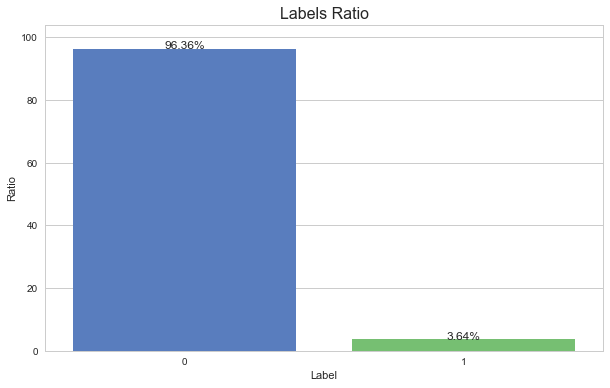

In [10]:
label_bars = train_dataset.target.value_counts().reset_index()
label_bars['percentage'] = np.round(100 * label_bars.target / label_bars.target.sum(),2)

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="index",y="percentage", data=label_bars, palette = "muted", ax=ax)
ax.set_ylabel("Ratio")
ax.set_xlabel("Label")
ax.set_title('Labels Ratio', fontsize=16)
ax.set_ylim(top=104)
draw_text_values(ax, text_format='{:1.2f}%')

## Features Analysis - Conclusions from data description
* The data contains several feature **types** and **groups**.


* There are 4 different groups of data - **calc, car, ind, reg**, each can include features from different types.


* Feature group can be found in each feature name (_calc, _car, _ind, _reg).


* There are 4 types of features: **Binary, Categorical, Ordinal** and **Continuous**.


* Feature type can be detected by feature name for **Binary** and **Categorical** features (if feature name contains "_cat" or "_bin").


* For features that are not **Binary** or **Categorical** (feature name doesn't contain "_cat" nor "_bin"),  the data type itself is needed in oreder to determine which are **Ordinal** features (int) and which are **Continuous** features (float).




#### Steps to better understand the data:
* Dropping id and target so only feature columns are left.
* Organizing columns in a table by:
    * Data type (data_type)
    * Feature type (feature_type)
    * Feature group (group)
* Counting how many unique values each feature contains.
* Then visualizing it using bar charts.


In [8]:
# Returns unique values count in given column
def count_unique_values(col):
    return len(col.value_counts())

# Returns feature type by feature name and data type
def get_feature_type(col):
    name = col.name
    if '_bin' in name or 'target' in name:
        f_type = 'binary'
    elif '_cat' in name:
        f_type = 'categorical'
    # If feature name can't help us, 
    # using data type can tell if the feature
    # is eithr ordinal (int) or continuous (float)
    elif col.dtype == np.int64:
        f_type = 'ordinal'
    else:
        f_type = 'continuous'
    return f_type

# Get feature group by feature name
def get_feature_group(col):
    splited_name = col.name.split('_')
    # Feature group is the 2nd part of the feature name
    if len(splited_name) > 1:
        group = splited_name[1]
    # For non features columns
    else:
        group = splited_name[0]
    return group

# Creating meta data table that describes all features by type, unique values and group
meta_data = train_dataset.apply(count_unique_values,axis=0)
meta_data = pd.DataFrame(meta_data, columns=['unique'])
meta_data['data_type'] = train_dataset.dtypes
meta_data['feature_type'] = train_dataset.apply(get_feature_type, axis=0, reduce=False)
meta_data['group'] = train_dataset.apply(get_feature_group, axis=0)
meta_data.drop(['id', 'target'], axis=0, inplace=True)
meta_data = meta_data.reset_index()

# Displaying features groups and types
print('Features by type and group:')
display(meta_data.groupby(by=['group', 'feature_type'])['index'].agg(['count']))#[['count']])

# Saving lists with feature names for every feature type (Binary, Categorical, Ordinal anc Continuous)
categorical_features = meta_data[meta_data['feature_type'] == 'categorical']['index'].values
binary_features = meta_data[meta_data['feature_type'] == 'binary']['index'].values
ordinal_features = meta_data[meta_data['feature_type'] == 'ordinal']['index'].values
continuous_features = meta_data[meta_data['feature_type'] == 'continuous']['index'].values

Features by type and group:


count
group feature_type       
calc  binary            6
      continuous        3
      ordinal          11
car   categorical      11
      continuous        4
      ordinal           1
ind   binary           11
      categorical       3
      ordinal           4
reg   continuous        3

In [12]:
meta_data

,index,unique,data_type,feature_type,group
0,ps_ind_01,8,int64,ordinal,ind
1,ps_ind_02_cat,5,int64,categorical,ind
2,ps_ind_03,12,int64,ordinal,ind
3,ps_ind_04_cat,3,int64,categorical,ind
4,ps_ind_05_cat,8,int64,categorical,ind
5,ps_ind_06_bin,2,int64,binary,ind
6,ps_ind_07_bin,2,int64,binary,ind
7,ps_ind_08_bin,2,int64,binary,ind
8,ps_ind_09_bin,2,int64,binary,ind
9,ps_ind_10_bin,2,int64,binary,ind


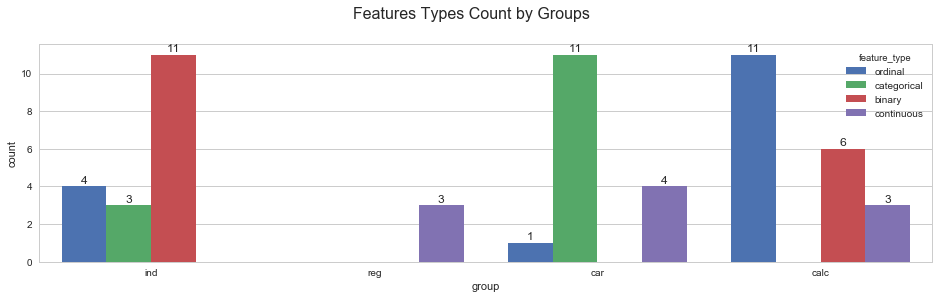

In [13]:
fig, ax = plt.subplots(figsize=(16,4))
fig.suptitle('Features Types Count by Groups', y=1.01, fontsize=16)
g = sns.countplot(data=meta_data, x='group', hue='feature_type', ax=ax, saturation=1)
draw_text_values(ax, 15)

### Conclusions
* Non of the groups contains features from all 4 types.


* The group **"reg"** (region) has only 3 features, all of them are **Contiuous** type.


* The rest of the groups contain 3 types of features each.


* The group **"car"** contains mostly **Categorical** features while **"ind"** and **"calc"** conatin mainly **Binary** and **Ordinal** features respecivly.



## Features by Feature Type, Data Type and Feature Group - Bar Plots:

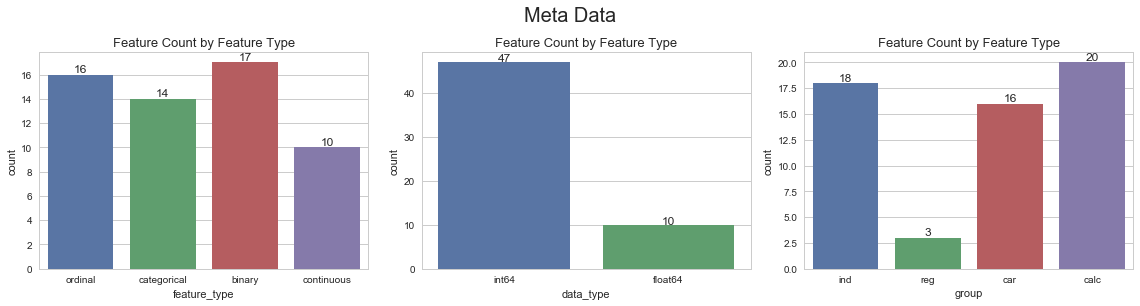

In [14]:
def bar_plot_with_annot(x, ax, title='', max_height=20):
    ax.set_title('Feature Count by Feature Type', fontsize=13)
    ax = sns.countplot(x=x, ax=ax)
    draw_text_values(ax, max_height=20)

# Bar charts of features by feature_type, data_type and group
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize=(16,4))
fig.suptitle('Meta Data', y=1.06, fontsize=20)
bar_plot_with_annot(x=meta_data['feature_type'], ax=ax1, title='Feature Count by Feature Type')
bar_plot_with_annot(x=meta_data['data_type'], ax=ax2, title='Feature Count by Data Type', max_height=40)
bar_plot_with_annot(x=meta_data['group'], ax=ax3, title='Feature Count by Feature Group')
fig.tight_layout()

## Unique Values
### How many unique values each feature contains?
### Using 3 bar plots, 1 for each feature type*  to see how many unique values each feature cotntains
*(Binary features contain only 2 unique values, 0 or 1 so there is no need to plot them)

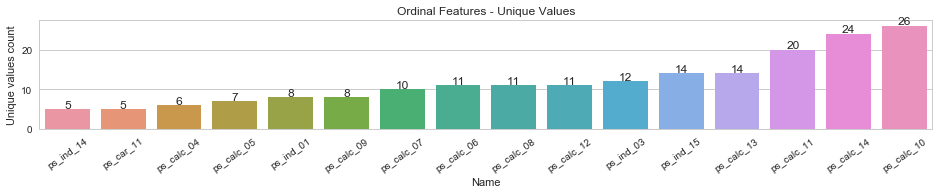

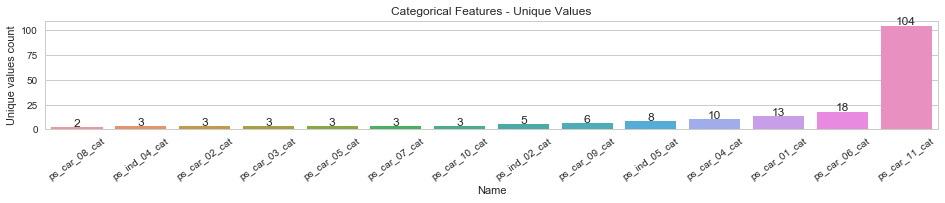

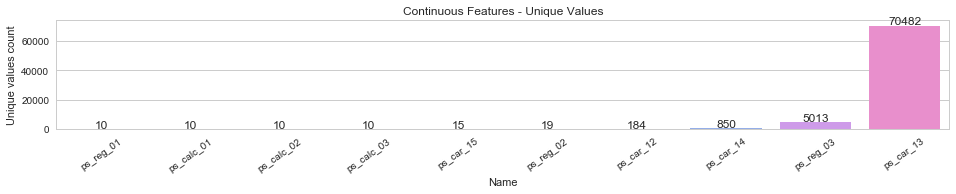

In [15]:
# Unique values in each column, by feature type
for f_type in ['ordinal', 'categorical', 'continuous']:
    fig, ax = plt.subplots(figsize=(16,2))
    ax.set_title(f_type.title() + ' Features - Unique Values')    
    
    sliced_data = meta_data[meta_data['feature_type'] == f_type].reset_index().sort_values(by='unique')
    sns.set_style("whitegrid")
    ax = sns.barplot(data=sliced_data, x='index', y='unique', ax=ax)
    ax.set_ylabel('Unique values count')
    ax.set_xlabel('Name')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    max_height = sliced_data['unique'].max()
    # Adding values as text to the chart
    draw_text_values(ax, max_height=max_height)

## Conclusions:
* As suspected, features of type **int** that are not **Binary** or **Categorical** have small number of unique values (5-26) which can indicates they represent **Ordinal** data, a closer look ins needed to deside if additional pre-preocesing is needed.


* Categorical feature **"ps_car_11_cat"** has large number of categories. This might be an issue when encoding the data. A closer look for potantial work around is needed here too.


* Some **Continuous** features have many unique values as expected, while others have as little as 10. This may indicate some kind of scale representation. A closer look at these features will help to deside which representation is right for them and if additional pre-preocess is needed.

### Ctegorical and Ordinal Features:
#### There are two types of features which in both of them each unique value represents a different category:

* **Categorical Features -** Each unique value represents a category but **there is no relationship** between values (e.g., Male(1)/Female(2) - mapping order is arbitrary and can be different).
    * Encoding is needed.


* **Ordinal Features -** Each unique value represents a category and **there is a relationship** between different values (e.g., Bad(1)/Good(2)/Great(3) - category 2 is "higher" than category 3).
    

Column ps_car_11_cat has too many values (104). Showing only the 40 most frequent values


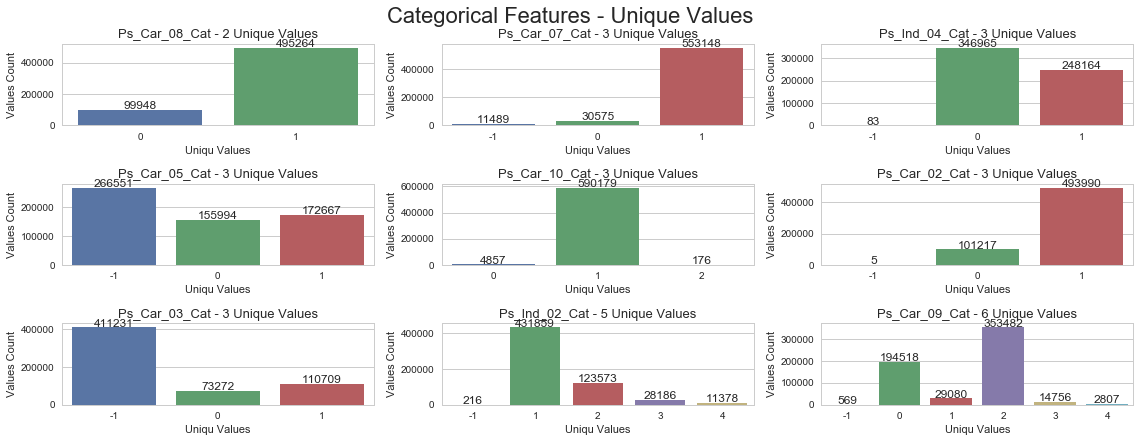

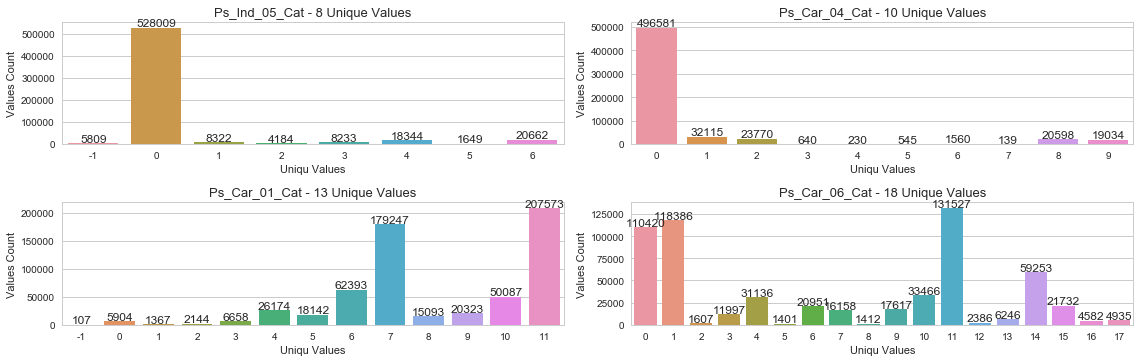

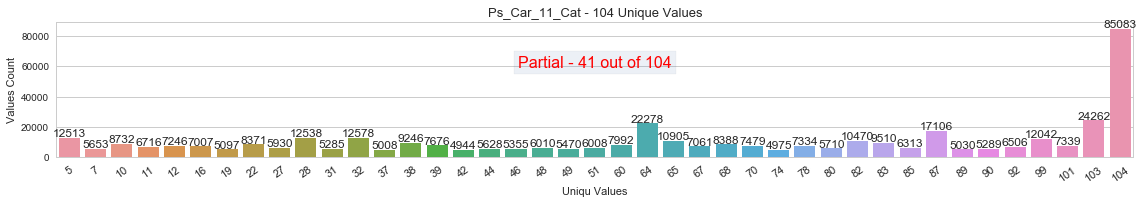

In [16]:
sorted_meta_data = meta_data.sort_values(by=['unique'])
cols = sorted_meta_data.loc[sorted_meta_data['feature_type'] == 'categorical']['index']  
title = 'Categorical Features - Unique Values'
bar_plot_unique_counts(train_dataset, cols[0:9],  title=title, max_cols=3, row_size=2)
bar_plot_unique_counts(train_dataset, cols[9:13], max_cols=2, row_size=2.6)
#bar_plot_unique_counts(train_dataset, cols[11:13], row_size=3)
bar_plot_unique_counts(train_dataset, cols[13:], max_to_show=40,  row_size=3)

### Ctegorical Features - Conclusions:
* Can not be represented as numerical values, need to be encoded.
* There are 9 features with missing values (-1), in some of them it's the most frequent value.
* Each unique category will add 1 extra dimantion after encoding, should consider grouping rare categories toghther.
* The number of categories in each column verais from 2 (+1 category for the missing values) up to 104.
* The ditrebution is simmmiler:
    * In most of the features, there are small number of categories (1-2) which are highlly frequent.
    * In some of the features there are extremly "rare" categories.


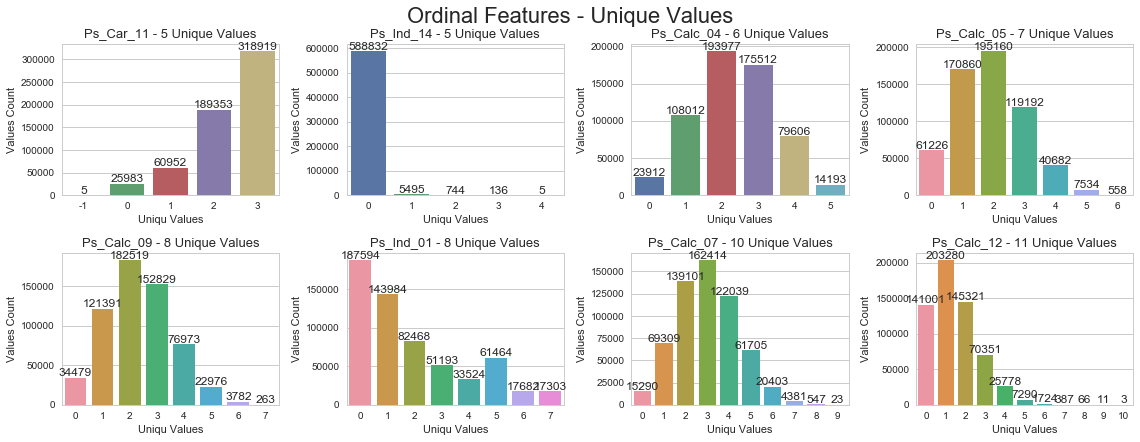

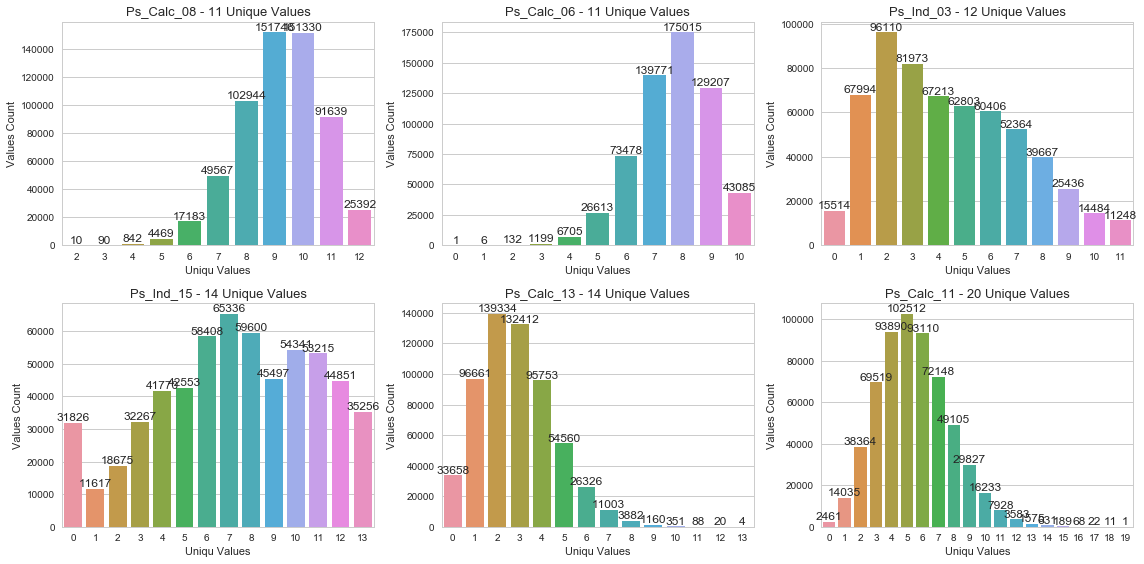

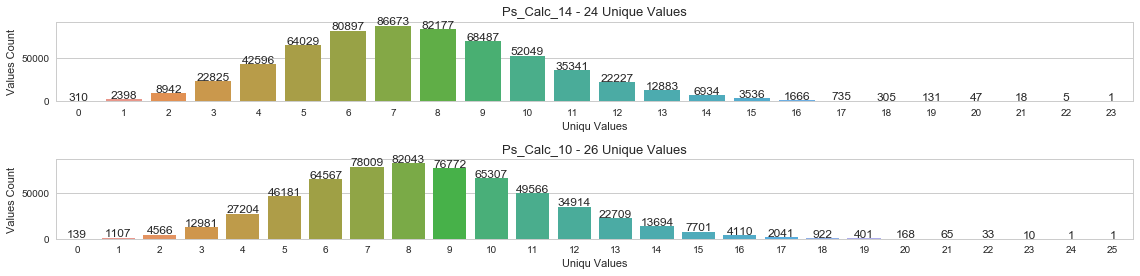

In [17]:
cols = sorted_meta_data.loc[meta_data['feature_type'] == 'ordinal']['index'] 
title = 'Ordinal Features - Unique Values'
bar_plot_unique_counts(train_dataset, cols[:8],  title=title, max_cols=4, row_size=3)
bar_plot_unique_counts(train_dataset, cols[8:-2], max_cols=3, row_size=4)
bar_plot_unique_counts(train_dataset, cols[-2:], max_cols=1, row_size=2)
del(sorted_meta_data)

### Ordinal Features - Conclusions:
* Ordinal features can be represented with numerical values.
* There is one only feature with missing values, 'ps_car_11. Only 5 values are missing.
* It is better to find solution to missing values and not represent them as additional category.

## Exploring Missin Values
### Basic exploration of which columns have missing data and what is ratio.

Will be usfull for feature exploration and data cleaning.
* Missing values represented as '-1' in all the columns in the data set (taken from the official data description https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data).

* Replacing -1 with np.nan (Null)
* Need to be replaced with np.nan in order to use pandas built in functions.
* There are different ways to handle missing values depending on the frequency, corrolation and feature type.
* Counting missing values by column.
* Displaying count and ratio of missing values of each column that has missing values.
* Displaying the ratio of missing values for the intire data set.


## Missing Values

Filling the missing value is needed, there are several ways to do that and different features will need different solutions:
* **Potential solutions for Categorical Features:**
    * Filling missing values with values from simmiler rows - Can't be done for features with many missing values.
    * Filling missing values with the most common category - Can't be done for features with many missing values.
    * Adding missing values as additional category - Can be done for all categorical features, work best if missing values might represent actual values.


* **Potential solutions for Ordinal Features:**
    * Filling missing values with values from simmiler rows - Can be done, there is only 1 feature with missing values (only 5 values are missing)
    * Filling missing values with the most common category - Same as above.
    * Adding missing values as additional category - Not a good idea as the new category will have a numeric value that will impaly it's higher or lower than other categories.


* **Potential solutions for Continuous Features:**
    * Filling missing values with mean, median or most common value.
    * Filling missing values with new numeric value (-1).
    * Filling missing values with values from the same feature but from different, simmiler rows.
        * Finding features with corrolation to the feature that need to be filled.
        * A simmiler row is a row in the data set where the values of the corrolated features are the same as the current row.
        * For each missing values, filling it with the mean of the values found in all simmiler rows.

### An analysis of each feature is needed in order to choose which approach fits it best:


In [9]:
from IPython.display import display, HTML
def explore_missing_values(ds):
    # Replacing '-1' with np.nan (null)
    ds = ds.replace(-1, np.nan)
    # Counting mising values (nulls) for each column and displaying the columns orderd by nulls count
    rows = ds.shape[0] 
    columns = len([f for f in ds.columns if 'ps_' in f])
    na_df = pd.DataFrame(ds.isnull().sum(), columns=['Nulls_count'])
    na_df['Nulls_ratio'] = np.round((na_df['Nulls_count'] / rows) * 100, 3)
    na_df.drop(na_df[na_df['Nulls_count'] == 0].index, axis=0, inplace=True)
    na_df.sort_values(by=['Nulls_count'], ascending=False, inplace=True)

    # Total missing values count and ratio
    nulls_count = ds.isnull().sum().sum()
    total_missing_ratio = np.round((nulls_count / (rows * columns)) * 100, 2)
    print('There are {} missing values ({}% of the data)'.format(nulls_count, total_missing_ratio))
    print('Out of {} columns, {} columns have missing values'.format(columns, len(na_df)))
    print('The column "{}" has the highest ratio of missing values (~{}%)\n-------\n'.format(na_df.index[0], na_df.iloc[0,1]))
    return na_df
#print('The null counts of the train and the test sets look simmiler so the test is showen as table while the train set as bars plot.\nTest set null counts table:')
print('Train Set:')
nulls_df = explore_missing_values(train_dataset)

print('Test Set:')
nulls_df_test = explore_missing_values(test_dataset)

index_ = [f for f in nulls_df.index if f not in nulls_df_test.index][0]
row = nulls_df.xs(index_, axis=0)
nulls_df_test = nulls_df_test.append(row)
nulls_df_test.loc[index_, :] = 0
nulls_df_test

Train Set:
There are 846458 missing values (2.49% of the data)
Out of 57 columns, 13 columns have missing values
The column "ps_car_03_cat" has the highest ratio of missing values (~69.09%)
-------

Test Set:
There are 1270295 missing values (2.5% of the data)
Out of 57 columns, 12 columns have missing values
The column "ps_car_03_cat" has the highest ratio of missing values (~69.097%)
-------



,Nulls_count,Nulls_ratio
ps_car_03_cat,616911.0,69.097
ps_car_05_cat,400359.0,44.842
ps_reg_03,161684.0,18.109
ps_car_14,63805.0,7.146
ps_car_07_cat,17331.0,1.941
ps_ind_05_cat,8710.0,0.976
ps_car_09_cat,877.0,0.098
ps_ind_02_cat,307.0,0.034
ps_car_01_cat,160.0,0.018
ps_ind_04_cat,145.0,0.016


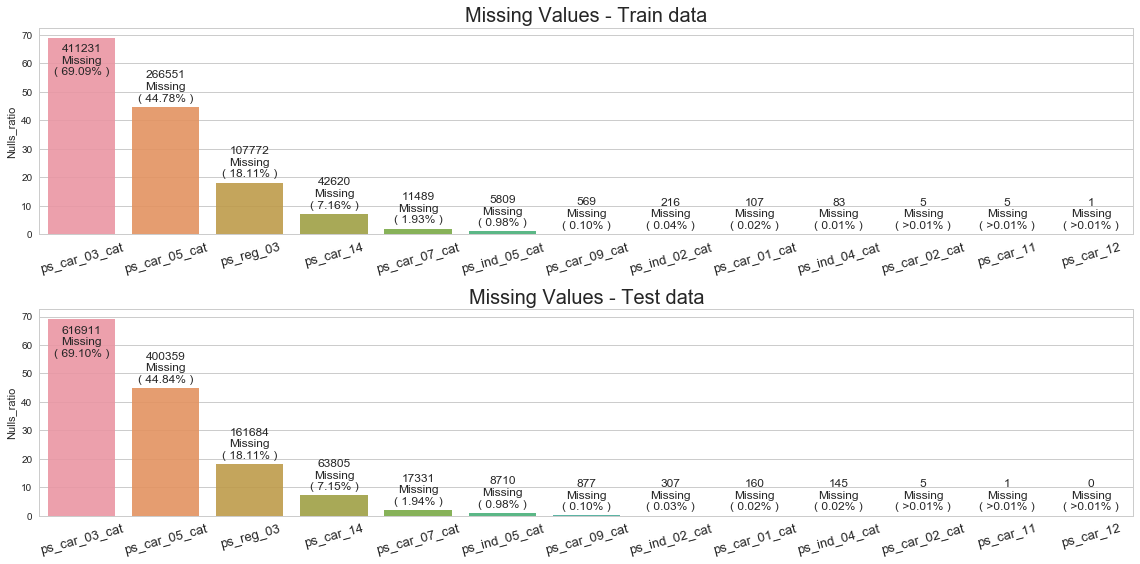

In [19]:
# Bar chart of training data
fig, axes = plt.subplots(figsize=(16,8), nrows=2, ncols=1)
ax1 = axes[0]
ax2 = axes[1]
ax1.set_title('Missing Values - Train data', fontsize=20)    
ax2.set_title('Missing Values - Test data', fontsize=20)    
def plot_missing(df, ax):  
    g = sns.barplot(x=df.index, y=df['Nulls_ratio'], ax=ax, alpha=0.9)
    g.set_xticklabels(df.index, fontsize = 13, rotation=15)
    for i, p in enumerate(g.patches):
        height = p.get_height()
        width =  p.get_width() / 2. + p.get_x()
        height_test = '{:1.2f}%'.format(height) if height > 0.01 else '>0.01%'
        g.text(width,min(height + 2, 56),
                '{:.0f}\nMissing\n( {} )'.format(df.Nulls_count[i], height_test),
                ha="center", fontsize=12) 

plot_missing(nulls_df, ax1)
plot_missing(nulls_df_test, ax2)  
fig.tight_layout()


## Conclusions
The easiest way to handle missing values is to drop them complitly but then we loss data.
This can work in some cases but not here:
* There are missing values in both train and test sets - Prediction is requiered for every test set sample so dropping rows with missing values is not an option.
* Out of 57 features, 13 features contain missing values - Dropping columns with missing values means lossing 13 features, ~23% of all the data!

## A better look at the 5 features with the most missing values


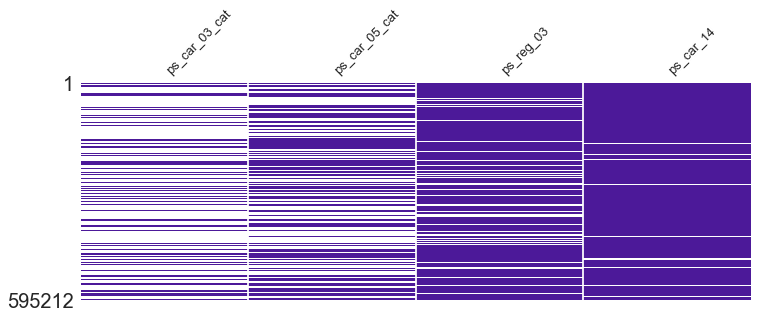

In [20]:
# A better look at the 5 features with the most missing values
#! pip install missingno
import missingno as msno
#train_data_copy = train_dataset.replace(-1, np.nan)
m = msno.matrix(df=train_dataset.replace(-1, np.nan)[nulls_df.index.values[:4]], figsize=(12, 4),
                #train_data_copy[nulls_df.index.values[:4]], figsize=(12, 4),
                color=(0.3, 0.1, 0.6), sparkline=False, fontsize=13)

## Missing Values - Adding count of missing values in each row


In [10]:
# Adding column with count of the missing values (-1) in each row
train_dataset['missing_vals'] = (train_dataset==-1).sum(axis=1).astype(float)
test_dataset['missing_vals'] = (test_dataset==-1).sum(axis=1).astype(float)
test_dataset['missing_vals'].describe(), len(test_dataset['missing_vals'].unique())

(count    892816.000000
 mean          1.422796
 std           0.939452
 min           0.000000
 25%           1.000000
 50%           2.000000
 75%           2.000000
 max           8.000000
 Name: missing_vals, dtype: float64, 9)

## Missing Values - Categorical Features
Going over missing values in each categorical feature in order to choose the best approach of hanlding them.

In [11]:
missing_cat_cols = [c for c in  nulls_df.sort_values(by='Nulls_ratio', ascending=False).index.values if c in categorical_features]

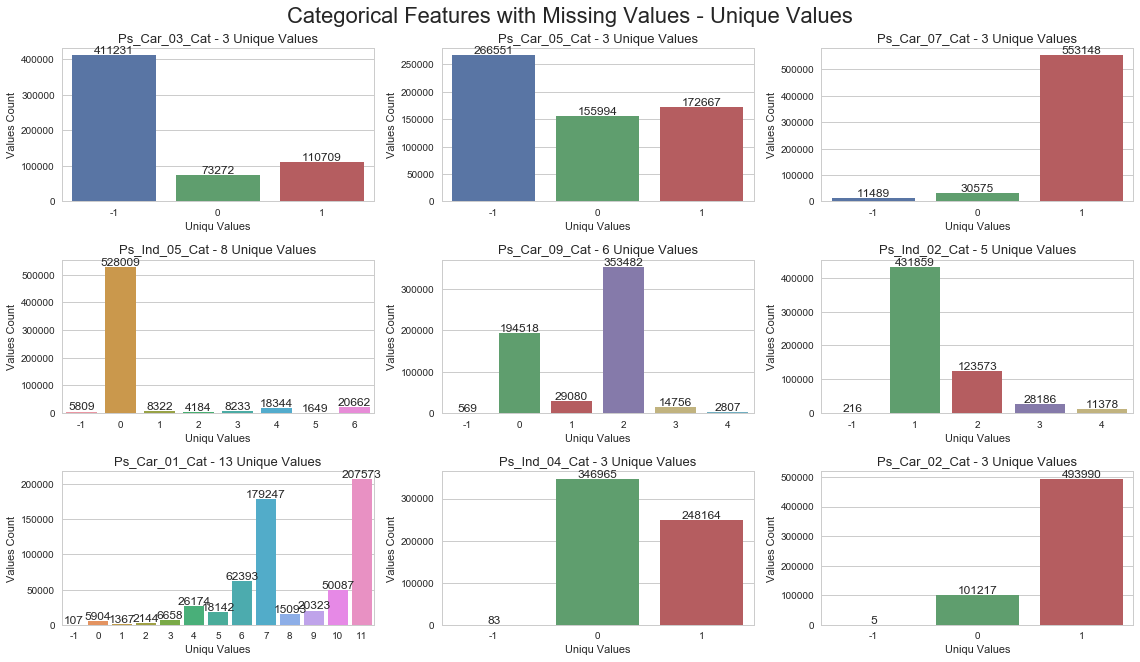

In [25]:
title = 'Categorical Features with Missing Values - Unique Values'
bar_plot_unique_counts(train_dataset, missing_cat_cols,  title=title, max_to_show=30, max_cols=3, row_size=3)

## Target Probability - Categorical Features with Missing Values
What is the probability of target value to be 1 (claim filed) in each category of every categorical feature.

Missing values are ploted as additional category (-1).

KeyboardInterrupt: 

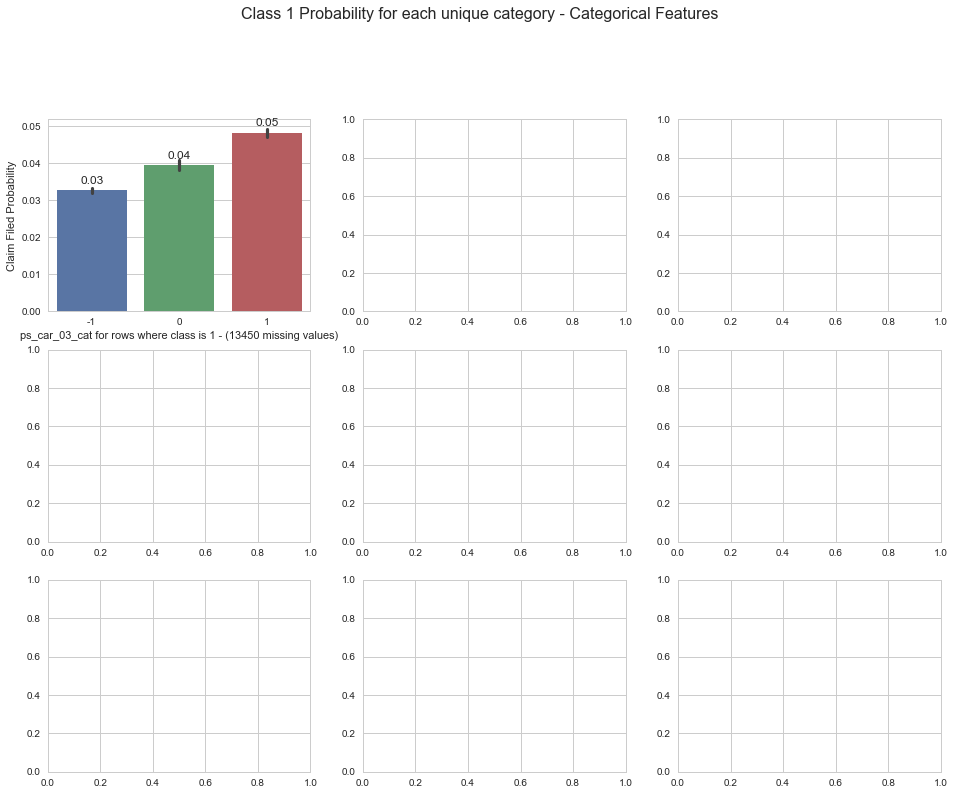

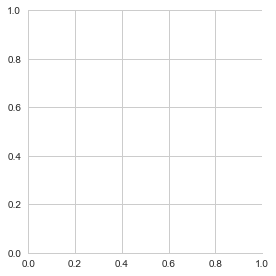

In [23]:
## Slow...
fig, axes = get_subplots_axes(len(missing_cat_cols), max_cols=3)
fig.suptitle('Class 1 Probability for each unique category - Categorical Features', y=1.01, fontsize=16)
for ax, col in zip(axes, missing_cat_cols):
    col_miss = train_dataset[[col, 'target']][train_dataset[col] == -1]
    col_miss_filed = col_miss[col_miss['target']==1]
    g = sns.factorplot(data=train_dataset[[col, 'target']],
                           x=col, y='target', kind='bar', ax=ax)
    plt.close(g.fig)
    prob = round(len(col_miss_filed)/len(col_miss),2)
    ylbl = ax.set_ylabel('Claim Filed Probability')# + 
    ax.set_xlabel('{} for rows where class is 1 - ({} missing values)'.format(col, len(col_miss_filed)))
    draw_text_values(ax=ax, max_height=prob * 6, text_format='{:1.2f}')
fig.tight_layout()

## Ctegorical featurs with missing values - Conclusions
* There are features where the probability of class 1 (claim filed) is significantly different than the rest of the categories.


* There are features where the ratio of missing values is high.


* There is a good chance that missing values are representing actual value and not just missing due to incomplete data.


#### Therefore, the selected approach of handling missing values in Categorical Features is to set them as an additional category.

## Missing Values - Ordinal Features

In [12]:
missing_ord_cols = [c for c in nulls_df.index.values if c in ordinal_features]

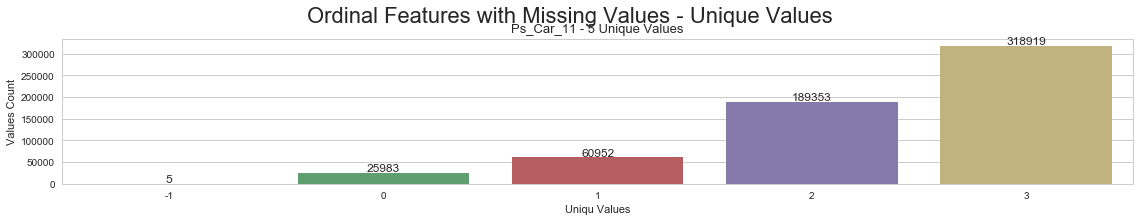

In [27]:
title = 'Ordinal Features with Missing Values - Unique Values'
bar_plot_unique_counts(train_dataset, missing_ord_cols,  title=title, row_size=3)

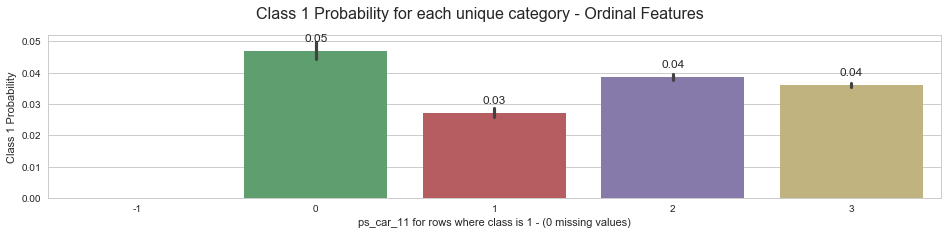

In [28]:
col = missing_ord_cols[0]
col_miss = train_dataset[[col, 'target']][train_dataset[col] == -1]
col_miss_filed = col_miss[col_miss['target']==1]
prob = round(len(col_miss_filed)/len(col_miss),2)

fig, ax = plt.subplots(figsize=(16,3))
fig.suptitle('Class 1 Probability for each unique category - Ordinal Features', y=1.01, fontsize=16)    

g = sns.factorplot(data=train_dataset[[col, 'target']],
                       x=col, y='target',  ax=ax, kind='bar')
plt.close(g.fig)

ax.set_xlabel('{} for rows where class is 1 - ({} missing values)'.format(col, len(col_miss_filed)))
y_lbl = ax.set_ylabel('Class 1 Probability')
draw_text_values(ax=ax, max_height=0.3, text_format='{:1.2f}')

## Ordinal featurs with missing values - Conclusions
* There is only 1 Ordinal feature with missing values, "ps_car_11".


* There are only 5 missing values in "ps_car_11".


* Filling the missing values with a new additional category will imply that this category is "higher" or "lower" than the rest of the categories, depending which value will be selected. The meaning of "ps_car_11" values is unkown so this approach is not a good fit.


#### Therefore, the selected approach of handling missing values in Ordinal Feature "ps_car_11" is to fill them with the most feequent value, 3.

-------

## Missing Values - Continuous Features

In [13]:
missing_cont_cols = [c for c in nulls_df.index.values if c in continuous_features]

Column ps_reg_03 has too many values (5013). Showing only the 6 most frequent values
Column ps_car_14 has too many values (850). Showing only the 6 most frequent values
Column ps_car_12 has too many values (184). Showing only the 6 most frequent values


'\nimport missingno as msno\ntrain_data_copy = train_dataset.replace(-1, np.nan)\nm = msno.matrix(df=train_data_copy[[col]], figsize=(10, 4),\n                color=(0.3, 0.1, 0.6), sparkline=False, )\nm = msno.matrix(df=class_1_data.replace(-1, np.nan), figsize=(10, 4),\n                color=(0.3, 0.1, 0.6), sparkline=False, )\nm = msno.matrix(df=class_0_data.replace(-1, np.nan), figsize=(10, 4),\n                color=(0.3, 0.1, 0.6), sparkline=False, )\n'

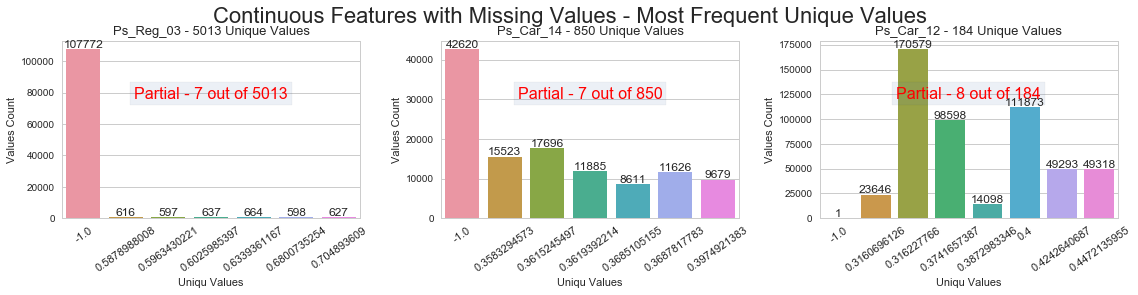

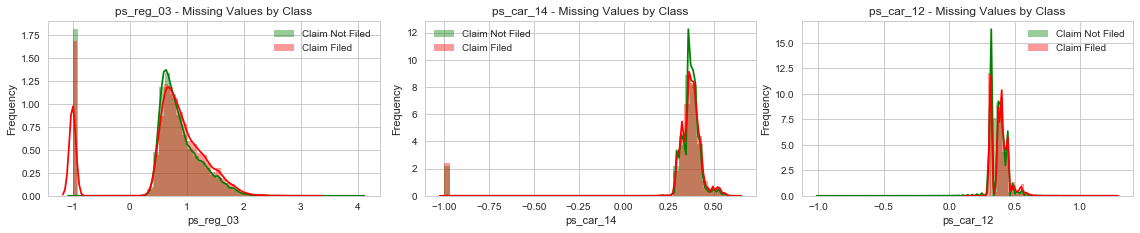

In [30]:
title = 'Continuous Features with Missing Values - Most Frequent Unique Values'
bar_plot_unique_counts(train_dataset, missing_cont_cols,  title=title, max_to_show=6, max_cols=3, row_size=4)

fig, axes = get_subplots_axes(count=3, max_cols=3, row_size=3.4)
for ax, col in zip(axes, missing_cont_cols[:]):
    g = sns.distplot(train_dataset.loc[train_dataset['target'] == 0][col][:],ax=ax,color='green')
    g = sns.distplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=ax,color='red')
    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    g.set_title('{} - Missing Values by Class'.format(col))
    g = g.legend(['Claim Not Filed', 'Claim Filed'])
    
fig.tight_layout()

#bar_plot_unique_counts(test_dataset, missing_cont_cols,  title=title, max_to_show=12, max_cols=1, row_size=3)
#nulls_ratio = nulls_df[nulls_df.index == 'ps_reg_03']
#col = missing_cont_cols[-1]
#sliced_data = train_dataset[col].value_counts()
#display(sliced_data)
#sliced_data = sliced_data.sort_values(ascending=False).reset_index()
#sliced_data = sliced_data.reset_index()
#print('Column {} has too many values ({}). Showing only the {} most frequent values'.format(col, len(sliced_data)))
#sliced_data = sliced_data[(sliced_data[col] >=  sliced_data[col][max_to_show]) | (sliced_data['index'] == -1)]

#print(title)
#print(nulls_ratio['Nulls_ratio'].values)
#nulls = nulls_ratio['Nulls_ratio'].values[0]
#not_nulls = 100 - nulls
#plt.figure()
#sns.barplot(x=['nulls', 'Non Nulls'], y=[nulls, not_nulls])
# Explore Age distibution 

"""
fig, axes = get_subplots_axes(count=3, max_cols=3)
for ax, col in zip(axes, missing_cont_cols):#['ps_reg_03', 'ps_car_14']):
    g = sns.kdeplot(train_dataset.loc[(train_dataset['target'] == 0)][col], ax=ax, color='green', shade = True)
    g = sns.kdeplot(train_dataset.loc[(train_dataset['target'] == 1)][col], ax=ax, color='red', shade=True)

    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    nulls = nulls_df.loc[nulls_df.index == col, ['Nulls_ratio', 'Nulls_count']].values[0]
    g.set_title('{}\n({:.0f} Missing Values {:.2f}%)'.format(col, nulls[1], nulls[0]))
    len(train_dataset[col][(train_dataset['target'] == 0) & train_dataset[col] == -1])
    len(train_dataset[col][(train_dataset['target'] == 1) & train_dataset[col] == -1])
    claim_filed = train_dataset[[col]][(train_dataset['target'] == 1)]
    claim_not_filed = train_dataset[[col]][(train_dataset['target'] == 0)]
    claim_filed_missing_count = len(claim_filed[claim_filed[col] == -1])
    claim_not_filed_missing_count = len(claim_not_filed[claim_not_filed[col] == -1])
    g = g.legend(['Claim Filed \n({} missing values - {:.2f}%)'.format(claim_filed_missing_count, 100*claim_filed_missing_count/len(claim_filed)),
                  'Claim Not Filed \n({} missing values - {:.2f}%)'.format(claim_not_filed_missing_count, 100*claim_not_filed_missing_count/len(claim_not_filed))])
    
fig.tight_layout()

col = 'ps_reg_03'
col_miss_data = train_dataset.loc[train_dataset[col] == -1][[col, 'target']]
col_non_miss_data = train_dataset.loc[train_dataset[col] != -1][[col, 'target']]
all_data_count = len(train_dataset)
print(100*col_miss_data['target'].value_counts()/len(col_miss_data))
print(100*col_non_miss_data['target'].value_counts()/len(col_non_miss_data))

class_1_data = train_dataset.loc[train_dataset['target'] == 1][[col, 'target']]
class_0_data = train_dataset.loc[train_dataset['target'] == 0][[col, 'target']]

#class_0_val_count = 100*calss_0_data[col].value_counts()/len(calss_0_data)
#print(type(class_0_val_count), class_0_val_count.shape)
#print(class_0_val_count.head(10))
display((100*class_0_data[col].value_counts()/len(class_0_data)).head(3))
display((100*class_1_data[col].value_counts()/len(class_1_data)).head(3))

ones = train_dataset.loc[train_dataset['target'] == 1][col]
zeros = train_dataset.loc[train_dataset['target'] == 0][col]
ones_count = len(ones)
zeros_count = len(zeros)
step = 10000
#max(ones_count, zeros_count)
print(ones_count, zeros_count)
"""
"""for i in range(0,zeros_count, ones_count):
    o_start = min(i, zeros_count-step)
    z_start = min(i, ones_count-step)
    
    o_stop = min(zeros_count, i + step)
    z_stop = min(ones_count, i + step)
    
    
    fig, axes = get_subplots_axes(2, max_cols=2)
    g = sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col].values[z_start:z_stop], ax=axes[0], color='green', shade = True)
    g = sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col].values[o_start:o_stop], ax=axes[0], color='red', shade=True)
"""

#fig, axes = get_subplots_axes(2, max_cols=2)
#g = sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col].values[:], ax=axes[0], color='green', shade = True)
#g = sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col].values[:], ax=axes[0], color='red', shade=True)
    
#sns.kdeplot(calss_0_data[col], ax=axes[0], color='red', shade=True)
#sns.kdeplot(calss_1_data[col], ax=axes[0], color='red', shade=True)
#sns.distplot(calss_0_data[col], ax=axes[0])
#sns.distplot(calss_1_data[col], ax=axes[1])
#sns.distplot(train_dataset.loc[(train_dataset['target'] == 0)][col], ax=axes[0])
#sns.distplot(train_dataset.loc[(train_dataset['target'] == 1)][col], ax=axes[1])
#display(train_dataset.loc[(train_dataset['target'] == 0)][col])
"""
fig, axes = get_subplots_axes(2, max_cols=2)
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col][:-99990],ax=axes[0], alpha=0.6, color='blue')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col][108359:-20],ax=axes[1], alpha=0.6, color='blue')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=axes[0], alpha=0.6, color='green')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=axes[1], alpha=0.6, color='green')

fig, axes = get_subplots_axes(2, max_cols=2)
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col][108389:],ax=axes[0], alpha=0.6, color='blue')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 0][col][108379:],ax=axes[1], alpha=0.6, color='blue')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=axes[0], alpha=0.6, color='green')
sns.kdeplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=axes[1], alpha=0.6, color='green')
"""
"""
fig, axes = get_subplots_axes(2, max_cols=2)
sns.distplot(train_dataset.loc[train_dataset['target'] == 0][col][:],ax=axes[1],color='green')
sns.distplot(train_dataset.loc[train_dataset['target'] == 1][col][:],ax=axes[1],color='red')


plt.figure()
plt.hist(col_miss_data['target'], normed=True, alpha=0.6, color='blue')
plt.figure()
plt.hist(col_non_miss_data['target'], normed=True, alpha=0.6, color='green')
plt.figure()
plt.hist(train_dataset.loc[train_dataset['target'] == 0][col][:int(zeros_count/2)], bins=30, normed=True, alpha=0.6, color='blue')
#plt.figure()
plt.hist(train_dataset.loc[train_dataset['target'] == 1][col], bins=30, normed=True, alpha=0.6, color='red')
#sns.countplot(col_non_miss_data['target'], ax=axes[0], alpha=0.4)


#plt.hist(train_dataset.loc[train_dataset['target'] == 1][col], bins=30, normed=True, alpha=0.6, color='red')


#col_miss_data['target'].hist(ax=axes[0])
#col_non_miss_data['target'].hist(ax=axes[0], )

#train_dataset[col][(train_dataset['target'] == 1)]
#sns.factorplot(data=train_dataset, x='ps_reg_03', hue='target', kind='count')
"""
# A better look at the 5 features with the most missing values
#! pip install missingno
"""
import missingno as msno
train_data_copy = train_dataset.replace(-1, np.nan)
m = msno.matrix(df=train_data_copy[[col]], figsize=(10, 4),
                color=(0.3, 0.1, 0.6), sparkline=False, )
m = msno.matrix(df=class_1_data.replace(-1, np.nan), figsize=(10, 4),
                color=(0.3, 0.1, 0.6), sparkline=False, )
m = msno.matrix(df=class_0_data.replace(-1, np.nan), figsize=(10, 4),
                color=(0.3, 0.1, 0.6), sparkline=False, )
"""

## Conclusions
* There are 3 Continuous Features with missing values, "ps_reg_03", "ps_car_14" and "ps_car_12".
* **"ps_reg_03"**
    * There are ~5000 unique values.
    * -1 (missing value) is the most frequent one (~18% of the data).
    * The rest of the values are less than 0.2% of the data each.
    * **This makes filling missing values a real chalange. Replacing missing values with a single additional value can be a "good enough solution"**


* **"ps_car_14"**
    * There are 850 unique values.
    * -1 (missing value) is the most freqent one (~7% of the data). 
    * The 2nd most frequent value is ~3% of the data.
    * **Filling missing values with values from simmiler rows can be a nice solution for this feature.**


* **"ps_car_12"**
    * There are 184 unique values.
    * There is only 1 missing value.
    * **Filling this 1 missing value with the most frequent value (30% of the data) can work here.**


## Preprocessing needed to fill missing values using values from simmiler rows:
* Dropping missing values to get a data set without missig values that can be used as "filling values".
* Finding most corrolateg features for each feature that needs to be filled.
* Creating a "non missing data set" data set by dropping rows with missing values only if the missing values are in the corrolated features of the selected feature.
* Filling missing values using simmiler rows* in the "non missing data set".


In [14]:
# returns the top corrolated columns of the given column
def get_top_corr(corr_df, col, top=5):
    sort_corr = corr_df.sort_values([col], ascending=False)[[col]].drop(col, axis=0)
    top_corr = pd.concat([sort_corr.head(top), sort_corr.tail(top)])
    return top_corr

def corr_heatmap(df, cols):
    correlations = df[cols].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    g = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    ax.set_title(cols[0], fontsize=13)
    plt.show()

### Heat map of  the most corrolated and least corrolated features of "ps_reg_03"  and "ps_car_14"

In [15]:
# Replacing -1 with nan
train_dataset_with_nans = train_dataset.replace(-1,np.nan)

# Dropping the columns with the highst amount of missing values
no_nulls_data = train_dataset_with_nans.drop(['id'], axis=1).drop(nulls_df.head(2).index.values, axis=1)

# Dropping all the rows that contain missing values
no_nulls_data = no_nulls_data.dropna(axis=0)#[train_dataset[col] != -1]
print('Data set size before: {}, After: {}'.format(train_dataset_with_nans.shape, no_nulls_data.shape))#, no_nulls_data.isnull().sum().sum())

data_corr = no_nulls_data.corr()

Data set size before: (595212, 60), After: (443531, 57)


ps_reg_03


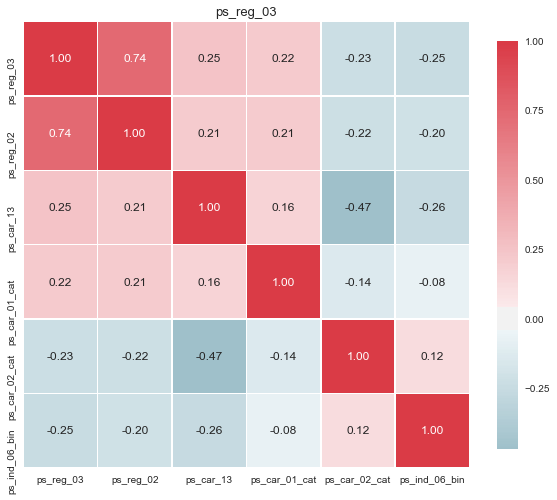

ps_car_14


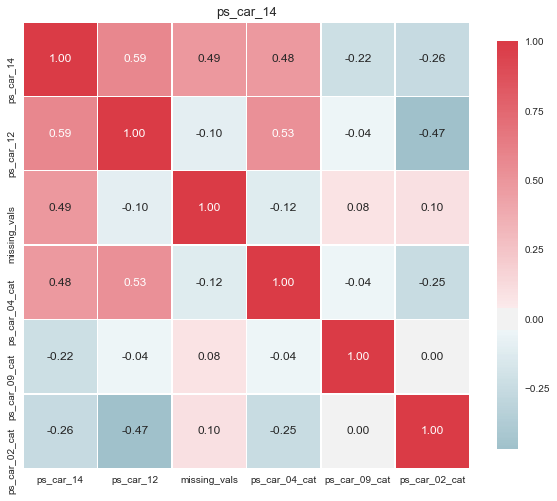

In [23]:
for col in ['ps_reg_03', 'ps_car_14']:#missing_cont_cols:
    print(col)
    top_corr = get_top_corr(data_corr, col, 4)
    top_corr_above_th = top_corr[(top_corr[col] > 0.2) | (top_corr[col] < -0.2)]
    cols = [col] + list(top_corr_above_th.index.values) 
    corr_heatmap(no_nulls_data ,cols)

###  Creating a "non missing data set" data set by dropping rows with missing values only if the missing values are in the corrolated features of "ps_car_14".

In [16]:
col = 'ps_car_14'
allowed_null_cols = [col] + list(nulls_df.loc[nulls_df['Nulls_ratio'] < 1].index.values)
print(allowed_null_cols)

ps_car_14_corr_cols = [f for f in train_dataset if f not in nulls_df.index.values and f not in ['id', 'target']]
print(len(ps_car_14_corr_cols))
ps_car_14_corr_cols += allowed_null_cols#['ps_car_14', 'ps_car_12', 'ps_car_04_cat', 'ps_car_13']
print(len(ps_car_14_corr_cols))

['ps_car_14', 'ps_ind_05_cat', 'ps_car_09_cat', 'ps_ind_02_cat', 'ps_car_01_cat', 'ps_ind_04_cat', 'ps_car_02_cat', 'ps_car_11', 'ps_car_12']
45
54


In [17]:
no_nulls_data = train_dataset[ps_car_14_corr_cols + ['target']].replace(-1,np.nan).dropna(axis=0)
print('Data set size before: {}, After: {}'.format(no_nulls_data.shape, train_dataset.shape))#, no_nulls_data.isnull().sum().sum())
data_corr = no_nulls_data.corr()

Data set size before: (546660, 55), After: (595212, 60)


ps_car_14


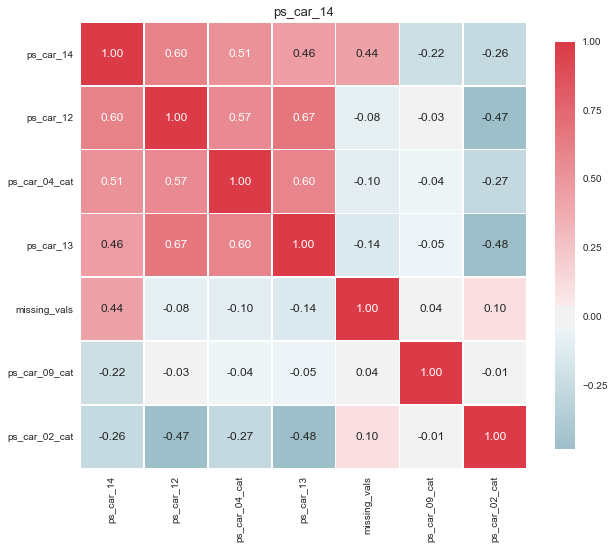

In [28]:
for col in ['ps_car_14']:#missing_cont_cols:
    print(col)
    top_corr = get_top_corr(data_corr, col, 6)
    top_corr_above_th = top_corr[(top_corr[col] > 0.2) | (top_corr[col] < -0.2)]
    cols = [col] + list(top_corr_above_th.index.values) 
    corr_heatmap(no_nulls_data ,cols)

## Preprocessing needed to fill missing values of "ps_car_14":
* Dropping missing values to get a data set without missig values that can be used as "filling values".
* Finding "ps_car_14" most corrolateg features
* Creating a "non missing data set" data set by dropping rows with missing values only if the missing values are in the corrolated features
* Filling "ps_car_14" missing values using simmiler rows* in the "non missing data set".



### Conclusions
* Feature "ps_reg_03"
    * Has to many missing values, ~69%.
    * Has only 1 enough corrolated feature, ps_reg_02.
    * Using simmiler rows to fill missing values is not a good solution for this feature.
* Feature "ps_car_14"
    * Has 3 other corrolated features:
        * ps_car_12 - 0.59
        * ps_car_04_cat - 0.48
        * ps_car_13 - 0.44
    * Has 18% missing values.
    * Has ~800 unique  values, which is a small number for continuous feature.
    * Filled missing vales using simmiler rows might work under these conditions:
        * For each row where 'ps_car_14" is missing a value, we search the data set for rows where the values of all 3 corrolated features is the same as thier values in this row, these considered as "simmiler rows".
        * The corrolation of each corrolated feature is not as high as we need it to be. Therefor, a simmiler row is considered valid only if all 3 corrolated features have the same value as thier values in the missing row.
        * The values of "ps_car_14" are taken from these simmiler rows        
        * The number of unique values is not high so using median of all found values is preferd over using mean.
        *
        * 
        The median value is used only if the ratio of found values and
        * Missing value will be filled with the median value of all the values found in similer rows
* 

In [18]:
#train_dataset_copy = train_dataset.copy(deep=True)

In [234]:
import time
import math 

@jit
def fill_missing_by_corr(df, non_missing_df, col, corr_cols, def_fill_val=-1):
    mis_vals_rows = df[df[col] == -1]
    print('{} - Missing values: {}, Unique: {}, df: {}, non missing df: {}\n corr cols: {}'.format(
        col, len(mis_vals_rows), len(df[col].unique()), df.shape, non_missing_df.shape, corr_cols))
    count = 0
    #not_found_level_1 = 0
    col_mean = no_nulls_data[col].mean()
    
    #vals_freq = []
    vals_mean = []
    corr_counts = []
    #vals_median = []
    corr_sum = 0
    start = time.clock()
    total_start = start
    for i, s in mis_vals_rows.iterrows():   
        corr_count = 0
        corr_cols_select = True
        #corr_cols_select = (non_missing_df[corr_cols[0]] == s[corr_cols[0]]) & (non_missing_df[corr_cols[1]] == s[corr_cols[1]]) &(non_missing_df[corr_cols[2]] == s[corr_cols[2]]) 
        #corr_cols_select1 = (non_missing_df[corr_cols[0]] == s[corr_cols[0]]) 
        #corr_cols_select2 = (non_missing_df[corr_cols[1]] == s[corr_cols[1]])#  &(non_missing_df[corr_cols[2]] == s[corr_cols[2]]) 
        #corr_cols_select = corr_cols_select1 & corr_cols_select2
        #count += corr_cols_select.sum()
        for corr_col in corr_cols:
            corr_cols_select = (corr_cols_select) & (non_missing_df[corr_col] == s[corr_col])
                #corr_count += 1
                #print('Found {} {} corrolated rows for {} and {} (corr_count {})'.format(    
                #    len(non_missing_df[col][corr_cols_select]),
                #    corr_col_select.sum(), col, corr_col, corr_count))
            #elif must:
                #print('Found {} corrolated rows for {} and {} (corr_count {})'.format(
                #    corr_col_select.sum(), col, corr_col, corr_count))
                #print('break')
             #   break
        
        """for corr_col, must in zip(corr_cols, musts):
            corr_col_select = non_missing_df[corr_col] == s[corr_col]
            if corr_col_select.sum() > 0:
                corr_cols_select = (corr_cols_select) & (corr_col_select)
                corr_count += 1
                #print('Found {} {} corrolated rows for {} and {} (corr_count {})'.format(    
                #    len(non_missing_df[col][corr_cols_select]),
                #    corr_col_select.sum(), col, corr_col, corr_count))
            elif must:
                #print('Found {} corrolated rows for {} and {} (corr_count {})'.format(
                #    corr_col_select.sum(), col, corr_col, corr_count))
                #print('break')
                break
        """ 
        """
        corr_col1_select = non_missing_df[corr_col1] == s[corr_col1]
            if corr_col1_select.sum() > 0:
                corr_cols_select = (corr_cols_select) & (corr_col1_select)
            print (corr_col2, len(non_missing_df[col][corr_cols_select]), corr_col2_select.sum())
       
        corr_cols_select = non_missing_df[corr_col1] == s[corr_col1]
        print (corr_col1, len(non_missing_df[col][corr_cols_select]), corr_cols_select.sum())
        if corr_col2 is not None:    
            corr_col2_select = non_missing_df[corr_col2] == s[corr_col2]
            if corr_col2_select.sum() > 0:
                corr_cols_select = (corr_cols_select) & (corr_col2_select)
            print (corr_col2, len(non_missing_df[col][corr_cols_select]), corr_col2_select.sum())
        if corr_col3 is not None:
            corr_col3_select = non_missing_df[corr_col3] == s[corr_col3]
            if corr_col3_select.sum() > 0:
                corr_cols_select = (corr_cols_select) & (corr_col3_select)
        print (corr_col3, len(non_missing_df[col][corr_cols_select], corr_col3_select.sum())
        """
        #fill_value_mean = non_missing_df[col][corr_cols_select].mean()
        fill_values = non_missing_df.loc[corr_cols_select][col]
        if len(fill_values) > 0:
            fill_value_mean = round(fill_values.mean(), 6)
        else:
            fill_value_mean = def_fill_val
        #if corr_count >= min_corr_count and corr_cols_select.sum() > 0:
            #fill_values = non_missing_df[col][corr_cols_select]
            #print(len(non_missing_df[col][corr_cols_select]))
            #fill_value_mean = fill_values.mean()
            #corr_counts.append(corr_count)
        #else:
        #    fill_value_mean = def_fill_val
        #    corr_counts.append(0)
        #corr_sum += corr_count
        #print('count', count, 'corr_count', corr_count, 'fill value', fill_value_mean,'\n')
        
        #fill_value_freq = -1
        #fill_value_mean = -1
        #fill_value_median = -1

        #val_count = len(fill_values)
        #unique_count = len(fill_values.unique())

        #if val_count == 0 and corr_col2 is not None: and corr_col3 is not None:
        #    fill_values = non_missing_df[col][(no_nulls_data[corr_col1] == s[corr_col1]) &
        #                                       (no_nulls_data[corr_col2] == s[corr_col2])]
        #    not_found_level_1 += 1

        #if len(fill_values) > 0:
            #fill_value_freq = fill_values.value_counts().iloc[:1].index.values[0]
        #    fill_value_mean = fill_values.mean()
            #fill_value_median = fill_values.median()

        vals_mean.append(fill_value_mean)
        count += 1

        if count%10000 == 0:
            end = time.clock()   
            print('Processed: {}\nTime:{}'.format(#, Found: {:.2f}%, nans: {:.2f}%\nTime: {}'.format(
                #out of {} ({:.2f}%)
                count, end - start)) #len(tmp),
            start = time.clock()
    end = time.clock()   
    print('Total time:', end - total_start)
    print('Found', len(vals_mean), 'missing values', len(df[col][df[col] == def_fill_val]))

    # Adding column with 1 for all rowswhere "ps_car_14" missing values were filled and 0 for the rest of the rows
    filled_col_name = col+'_filled'
    df[filled_col_name] = 0
    df.loc[df[col] == -1, filled_col_name] = 1#np.array(corr_counts) / (len(corr_cols) + 1)
    #train_dataset_copy.loc[train_dataset_copy[col] == -1, col] = vals_mean
    df.loc[df[col] == -1, col] = vals_mean
    print('Missing values after filling:', len(df[df[col] == -1]))
    return df, vals_mean

In [238]:
# Filling missing value of "ps_car_14"

# Filling "ps_car_14" with the mean "ps_car_14" of similar rows 
# according to "ps_car_13", "ps_car_12" and "ps_car_04_cat
col = 'ps_car_14'
train_dataset_tmp = pd.read_csv(input_path + 'train.csv')
test_dataset_tmp = pd.read_csv(input_path + 'test.csv')
print(len(train_dataset_tmp[col][train_dataset_tmp[col] == -1]), len(test_dataset_tmp[col][test_dataset_tmp[col] == -1]))

train_dataset_tmp, vals = fill_missing_by_corr(df=train_dataset_tmp, non_missing_df=no_nulls_data[[col, 'ps_car_13', 'ps_car_12', 'ps_car_04_cat']], col=col,
                         corr_cols=['ps_car_13', 'ps_car_12'], def_fill_val=0)#, 'ps_car_04_cat']
test_dataset_tmp, vals = fill_missing_by_corr(df=test_dataset_tmp, non_missing_df=no_nulls_data[[col, 'ps_car_13', 'ps_car_12', 'ps_car_04_cat']], col=col,
                         corr_cols=['ps_car_13', 'ps_car_12'], def_fill_val=0)#, 'ps_car_04_cat']
len(train_dataset_tmp[col][train_dataset_tmp[col] == 0]), len(test_dataset_tmp[col][test_dataset_tmp[col] == 0])

18803 63805
ps_car_14 - Missing values: 63805, Unique: 885, df: (892816, 58), non missing df: (546660, 55)
 corr cols: ['ps_car_13', 'ps_car_12', 'ps_car_04_cat']
Processed: 10000
Time:57.29084230387525
Processed: 20000
Time:58.177980980131906


KeyboardInterrupt: 

In [ ]:
import time
import math 
# Filling missing value of "ps_car_14"

# Filling "ps_car_14" with the mean "ps_car_14" of similar rows 
# according to "ps_car_13", "ps_car_12" and "ps_car_04_cat
col = 'ps_car_14'
print(col)

ps_14_mis_vals_rows = train_dataset_copy[train_dataset_copy[col] == -1]

#print(len(col_null_index))
print(col, 'Uniaue', len(train_dataset[col].unique()))
count = 0
not_found_level_1 = 0
col_mean = no_nulls_data[col].mean()
start = time.clock()
total_start = start

vals_freq = []
vals_mean = []
vals_median = []

for i, s in ps_14_mis_vals_rows.iterrows():   
    fill_values = no_nulls_data[col][(no_nulls_data['ps_car_13'] == s['ps_car_13']) & 
                                           (no_nulls_data['ps_car_12'] == s['ps_car_12']) &
                                           (no_nulls_data['ps_car_04_cat'] == s['ps_car_04_cat'])]
    
    #fill_value_freq = -1
    fill_value_mean = -1
    #fill_value_median = -1
    
    val_count = len(fill_values)
    #unique_count = len(fill_values.unique())

    if val_count == 0:#or unique_count > val_count - 1: 
        fill_values = no_nulls_data[col][(no_nulls_data['ps_car_12'] == s['ps_car_12']) &
                                           (no_nulls_data['ps_car_04_cat'] == s['ps_car_04_cat'])]
        not_found_level_1 += 1
        
    if len(fill_values) > 0:
        #fill_value_freq = fill_values.value_counts().iloc[:1].index.values[0]
        fill_value_mean = fill_values.mean()
        #fill_value_median = fill_values.median()
        
    vals_mean.append(fill_value_mean)
    count += 1
    
    if count%10000 == 0:
        end = time.clock()   
        print('Processed: {}, level 1 missing: {}\n{}'.format(#, Found: {:.2f}%, nans: {:.2f}%\nTime: {}'.format(
            #out of {} ({:.2f}%)
            count, not_found_level_1, end - start)) #len(tmp),
        start = time.clock()
end = time.clock()   
print('Total time:', end - total_start)
print('Found', len(vals_mean), 'missing values', len(train_dataset_copy[col][train_dataset_copy[col] == -1] ))

# Adding column with 1 for all rowswhere "ps_car_14" missing values were filled and 0 for the rest of the rows
filled_col_name = col+'_filled'
train_dataset[filled_col_name] = 0
train_dataset.loc[train_dataset[col] == -1, filled_col_name] = 1
#train_dataset_copy.loc[train_dataset_copy[col] == -1, col] = vals_mean
train_dataset.loc[train_dataset[col] == -1, col] = vals_mean
print('Missing values after filling:', len(train_dataset[train_dataset_copy[col] == -1]))

In [ ]:
test_dataset[filled_col_name] = 0

test_dataset.loc[test_dataset[col] == -1, filled_col_name] = 1
#train_dataset_copy.loc[train_dataset_copy[col] == -1, col] = vals_mean



In [32]:
import gc
%memit
gc.collect()
%memit

ERROR:root:Line magic function `%memit` not found.
ERROR:root:Line magic function `%memit` not found.


(69, 0, 0)

In [19]:
#train_dataset_copy.loc[train_dataset_copy[col] == -1, col] = 0
col = 'ps_car_14'
train_dataset.loc[train_dataset[col] == -1, col] = 0
test_dataset.loc[test_dataset[col] == -1, col] = 0

Column ps_car_14 has too many values (850). Showing only the 30 most frequent values
Column ps_car_14 has too many values (850). Showing only the 30 most frequent values


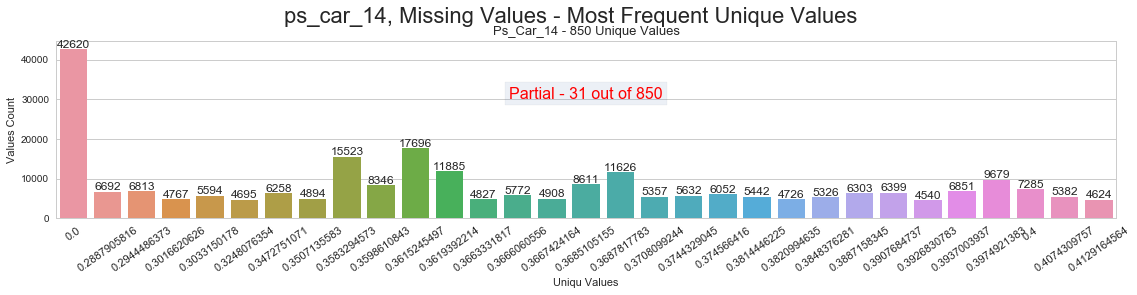

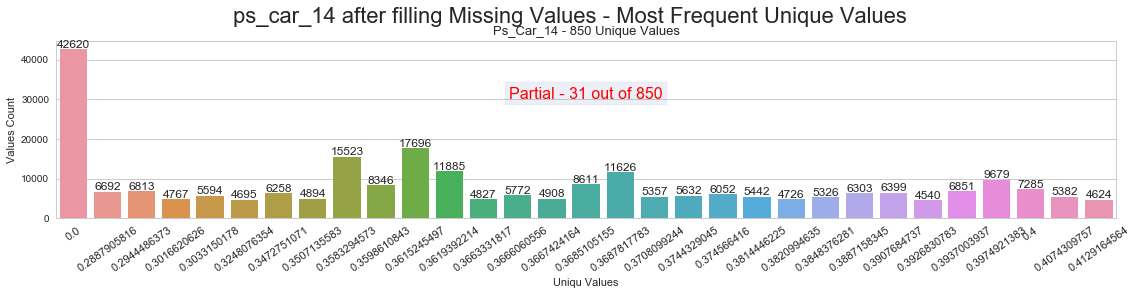

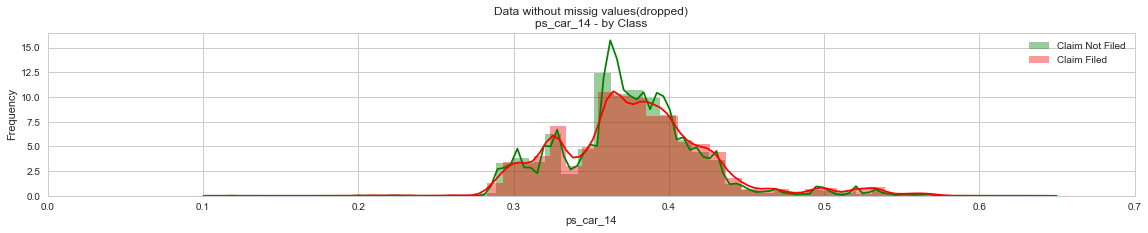

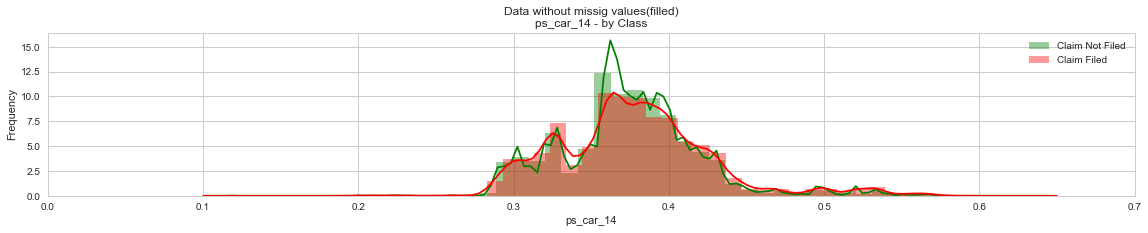

In [20]:
col = 'ps_car_14'

title = col + ', Missing Values - Most Frequent Unique Values'
bar_plot_unique_counts(train_dataset, [col],  title=title, max_to_show=30, max_cols=3, row_size=4)

title = col + ' after filling Missing Values - Most Frequent Unique Values'
bar_plot_unique_counts(train_dataset, [col],  title=title, max_to_show=30, max_cols=1, row_size=4)


fig, axes = get_subplots_axes(count=1, max_cols=1, row_size=3.4)
for ax, col in zip(axes, [col]):
    g = sns.distplot(no_nulls_data.loc[no_nulls_data['target'] == 0][col][:],ax=ax,color='green')
    g = sns.distplot(no_nulls_data.loc[no_nulls_data['target'] == 1][col][:],ax=ax,color='red')
    ax.set_xlim(0, 0.7)
    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    g.set_title('Data without missig values(dropped)\n{} - by Class'.format(col))
    g = g.legend(['Claim Not Filed', 'Claim Filed'])
    
fig.tight_layout()

fig, axes = get_subplots_axes(count=1, max_cols=1, row_size=3.4)
for ax, col in zip(axes, [col]):
    g = sns.distplot(train_dataset.loc[(train_dataset['target'] == 0) & (train_dataset[col] != 0)][col][:],ax=ax,color='green')
    g = sns.distplot(train_dataset.loc[(train_dataset['target'] == 1) & (train_dataset[col] != 0)][col][:],ax=ax,color='red')
    ax.set_xlim(0, 0.7)
    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    g.set_title('Data without missig values(filled)\n{} - by Class'.format(col))
    g = g.legend(['Claim Not Filed', 'Claim Filed'])
    
    
fig.tight_layout()


## Filling missing values of "ps_car_11"  and "ps_car_12" using most frequent values 
* "ps_car_11" with 5 missing values in train set and 1 missig value in test set.
* "ps_car_12" with 1 missing value in train set.
* Using train set most frequent value of each of them to fill missing values in both train and test sets.

In [21]:
def fill_with_ferq(train, test, col, nans=-1):
    print('Missing before:', 
          len(train.loc[train[col] == nans, col]), 
          len(test.loc[test[col] == nans, col]))
    
    freq_val = train[col].value_counts().index[0]
    print('Filling with', freq_val)
    print('Frequent value, before:', 
          len(train.loc[train[col] == freq_val, col]), 
          len(test.loc[test[col] == freq_val, col]))
    
    train.loc[train[col] == nans, col] = freq_val 
    test.loc[test[col] == nans, col] = freq_val 
    print('Missing after:', 
          len(train.loc[train[col] == nans, col]), 
          len(test.loc[test[col] == nans, col]))   
    print('Frequent value, after:', 
          len(train.loc[train[col] == freq_val, col]), 
          len(test.loc[test[col] == freq_val, col]))
    

fill_with_ferq(train_dataset, test_dataset, col='ps_car_12')
fill_with_ferq(train_dataset, test_dataset, col='ps_car_11')


Missing before: 1 0
Filling with 0.316227766
Frequent value, before: 170579 255984
Missing after: 0 0
Frequent value, after: 170580 255984
Missing before: 5 1
Filling with 3
Frequent value, before: 318919 478469
Missing after: 0 0
Frequent value, after: 318924 478470


## Filling "ps_reg_03" missing values with 0
* The min vale of "ps_reg_03" (excluding -1) is 0.0612372436
* Using 0 as missing value instead of -1.

In [22]:
print(train_dataset[train_dataset['ps_reg_03'] != -1]['ps_reg_03'].min(),
                test_dataset[test_dataset['ps_reg_03'] != -1]['ps_reg_03'].min())

0.0612372436 0.0612372436


In [23]:
train_dataset.loc[train_dataset['ps_reg_03'] == -1, 'ps_reg_03'] = 0
test_dataset.loc[test_dataset['ps_reg_03'] == -1, 'ps_reg_03'] = 0

In [24]:
print('Missing values in train set', train_dataset.replace(-1, np.nan).isnull().sum().sum())
print('Missing values in test set', test_dataset.replace(-1, np.nan).isnull().sum().sum())

Missing values in train set 696060
Missing values in test set 1044805


## Features Engineering
### Creating new features
* Adding frequency feature for every Categoriacl and every Ordinal Feature.
* Adding column with count of the missing values (-1) in each row

### Adding frequency feature for every Categoriacl and every Ordinal Feature.

In [25]:
freq_features = []
def create_vals_freq(train, test, cols):
    print('Creating {0} frequancy columns out of {0} categoriacl columns'.format(len(cols)))
    for col in cols:
        new_col = col + '_freq'
        #print('creating {} out of {}'.format(new_col,col))
        val_counts = train[col].value_counts()
        
        train[new_col] = train[col]
        train[new_col].replace(val_counts.index.values, val_counts.values, inplace=True)
        test[new_col] = test[col]
        test[new_col].replace(val_counts.index.values, val_counts.values, inplace=True)
        freq_features.append(new_col)

create_vals_freq(train_dataset, test_dataset, list(categorical_features) + list(ordinal_features))
train_dataset[freq_features +list(categorical_features) + list(ordinal_features)].describe()

Creating 30 frequancy columns out of 30 categoriacl columns


,ps_ind_02_cat_freq,ps_ind_04_cat_freq,ps_ind_05_cat_freq,ps_car_01_cat_freq,ps_car_02_cat_freq,ps_car_03_cat_freq,ps_car_04_cat_freq,ps_car_05_cat_freq,ps_car_06_cat_freq,ps_car_07_cat_freq,...,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,340544.945912,305723.152440,469997.130723,140048.130461,427194.010225,313730.576712,418302.821334,210340.948311,85399.320121,515849.038074,...,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,150190.383882,48845.161593,162623.324125,75949.052579,147561.558746,146124.048734,175663.766689,50997.627717,45771.628795,135276.747736,...,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,216.000000,83.000000,1649.000000,107.000000,5.000000,73272.000000,139.000000,155994.000000,1401.000000,11489.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,123573.000000,248164.000000,528009.000000,62393.000000,493990.000000,110709.000000,496581.000000,155994.000000,33466.000000,553148.000000,...,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,431859.000000,346965.000000,528009.000000,179247.000000,493990.000000,411231.000000,496581.000000,172667.000000,110420.000000,553148.000000,...,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,431859.000000,346965.000000,528009.000000,207573.000000,493990.000000,411231.000000,496581.000000,266551.000000,118386.000000,553148.000000,...,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,431859.000000,346965.000000,528009.000000,207573.000000,493990.000000,411231.000000,496581.000000,266551.000000,131527.000000,553148.000000,...,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


### Adding a column with a count of missing values (-1) in each row.


## Features Encoding

### Categorical features with rare values combined under the same category
Reduces dimentions before One Hot Encoding
* There are xx categoriacl features with different number of categories in each (from 2 up to 104 categires) and in toatl there are more than 150 unique categories  
* The next step is to encode (using One Hot) all categorical features  so that each unique category is represented with a dedicated column (0 or 1)  
* This means adding many more columns to the training data which could lead to high computationl trainig process and also incress the chances the model will overfit the data.
* In the code below, each categorical feature is tested and if there are rare values(categories) that take small persentage of the data, they will be mapped to one category (rare values categories).
* This step helps but the price is that some data is lost in the process. Adding a frequancy feature for each categorical feature (before the reduction) can help preserving some of the lost data.

In [26]:
def count_unique_values(df, columns):
    unique_count = 0
    for col in columns:
        unique_count += len(df[col].unique())
        #print(col,' - Total unique values so far:', unique_count)
    print('The {} given columns have {} unique values in total'.format(len(columns), unique_count))
    return unique_count

unique_cats = count_unique_values(train_dataset, categorical_features)

The 14 given columns have 184 unique values in total


In [27]:
# Disply the categories with the least amount of values so we can group them to one rare category
def get_values_ratio(df, col):
    val_counts = df[col].value_counts()
    counts_ratio = 100 * val_counts/val_counts.sum()
    val_counts.name = 'Count'
    counts_ratio.name = 'Ratio'
    return pd.concat([val_counts, counts_ratio], axis=1)
    
def get_rare_values(df, col, th=0.5):
    val_counts = get_values_ratio(df, col)
    less_th = val_counts[val_counts['Ratio'] < th]
    print('{} - {} unique values, {} are below the given {}% treshold\
    \n({:.2f}% of the values)'.format(col, 
                                                   len(val_counts),
                                                   len(less_th),
                                                   th, less_th.sum()[1]))
    return less_th.index.values

def replace_rare_values(train, test, col, th):
    new_val = train[col].max() + 1
    rare_vals = get_rare_values(train, col, th)
    if len(rare_vals) > 0:
        train[col].replace(rare_vals, new_val, inplace=True) 
        test[col].replace(rare_vals, new_val, inplace=True) 
        print('{} Rare values were grouped under the value {}'.format(len(rare_vals), new_val))
        print('There are {} unique values in column {}'.format(len(test[col].unique()), col))

In [ ]:
replace_rare_values(train_dataset, test_dataset, 'ps_car_11_cat', th=0.28)
replace_rare_values(train_dataset, test_dataset, 'ps_car_11_cat', th=0.33)

replace_rare_values(train_dataset, test_dataset, 'ps_car_06_cat', th=0.41)
replace_rare_values(train_dataset, test_dataset, 'ps_car_01_cat', th=0.361)
replace_rare_values(train_dataset, test_dataset, 'ps_car_04_cat', th=0.11)
print('Removed {} categories'.format(unique_cats - count_unique_values(train_dataset, categorical_features)))

## Label encoding - Categorical Fetures
#### Sets values of each Categorical Feature to be numeric, positive and with equal distance of 1 between categoris. Sets missing values (-1) as additional category with the value 0.

[ 0,  1,  8,  9,  2,  6, 10] --> [0, 1, 4, 5, 2, 3, 6]

[ 1,  0, -1] --> [2, 1, 0]

... etc.

In [28]:
from sklearn.preprocessing import LabelEncoder
for col in categorical_features:
    #print('Unique values before', col, train_dataset[col].unique(), len(train_dataset[col].unique()))
    le = LabelEncoder()
    le.fit(train_dataset[col])
    train_dataset[col] = le.transform(train_dataset[col])
    test_dataset[col] = le.transform(test_dataset[col])
    #print('Unique values after', col, train_dataset[col].unique(), len(train_dataset[col].unique()))


## One Hot Encoding - Categorical Features

In [30]:
def get_dummies(train, test, allowed_extra_col=['target']):
    print('Data size before dummies - train {}, test {}'.format(train.shape, test.shape))

    #categorical_features = [f for f in train.columns if '_cat' in f]
    train = pd.get_dummies(train, columns=categorical_features, prefix=categorical_features)
    test = pd.get_dummies(test, columns=categorical_features, prefix=categorical_features)
    print('categorical features', categorical_features)
    # Checks that both train and test have the same columns. 
    # Returns Columns that exist in one of the data set but not in the other one
    train_cols = train.columns
    test_cols = test.columns
    train_extra_col = [col for col in train_cols if col not in test_cols and col not in allowed_extra_col]
    test_extra_col = [col for col in test_cols if col not in train_cols and col not in allowed_extra_col]
    if len(train_extra_col) == 0 and len (test_extra_col) == 0 :
        print ('Done')
        print('Data size after dummies - train {}, test {}'.format(train.shape, test.shape))
    else:
        print('Found extra columns, Test and Train sets might have different unique categories')
        print('train_extra_col', train_extra_col)
        print('test_extra_col', test_extra_col)
    return train, test
    
train_dataset, test_dataset = get_dummies(train_dataset, test_dataset)

Data size before dummies - train (595212, 90), test (892816, 89)
categorical features ['ps_ind_02_cat' 'ps_ind_04_cat' 'ps_ind_05_cat' 'ps_car_01_cat'
 'ps_car_02_cat' 'ps_car_03_cat' 'ps_car_04_cat' 'ps_car_05_cat'
 'ps_car_06_cat' 'ps_car_07_cat' 'ps_car_08_cat' 'ps_car_09_cat'
 'ps_car_10_cat' 'ps_car_11_cat']
Done
Data size after dummies - train (595212, 260), test (892816, 259)


## Imbalanced Data - Solutions
### Adding class weight

In [31]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weight(y):
    weights = compute_class_weight('balanced', y.unique(), y)
    scale_pos_weight = weights[1]/weights[0]
    print('Class weights {}\nScale pos weight {}'.format(weights, scale_pos_weight))
    return weights, scale_pos_weight
weights, scale_pos_weight = get_class_weight(train_dataset['target'])

Class weights [  0.51891309  13.71835531]
Scale pos weight 26.43671061122891


In [32]:
test_dataset.describe()

,id,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103
count,8.928160e+05,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,...,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,7.441535e+05,1.902371,4.413734,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,...,0.006064,0.003408,0.002473,0.004780,0.020453,0.007566,0.012407,0.003393,0.041218,0.143261
std,4.296830e+05,1.986503,2.700149,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,...,0.077635,0.058281,0.049669,0.068975,0.141545,0.086653,0.110693,0.058147,0.198794,0.350339
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.720218e+05,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.443070e+05,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.116308e+06,3.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.488026e+06,7.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Train / Test split
* Train data set is randomlly splitted
* 80% used as training data
* 20% used as test and evaluation data


In [33]:
# Train test split
from sklearn.model_selection import train_test_split
X = train_dataset[train_dataset.columns[2:]]
y = train_dataset[train_dataset.columns[1]].astype(int)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=118, shuffle=True)
y_train.value_counts(), y_validation.value_counts(), X_train.shape, X_validation.shape

(0    458887
 1     17282
 Name: target, dtype: int64, 0    114631
 1      4412
 Name: target, dtype: int64, (476169, 258), (119043, 258))

In [30]:
best_features = ['ps_car_13',
 'ps_reg_03',
 'ps_ind_15',
 'ps_ind_03_freq',
 'ps_car_14',
 'ps_reg_01',
 'ps_car_11_cat_freq',
 'ps_ind_03',
 'ps_ind_01',
 'ps_ind_05_cat_freq',
 'ps_reg_02',
 'ps_car_15',
 'ps_car_11_cat',
 'ps_car_01_cat',
 'ps_car_01_cat_freq',
 'ps_calc_14',
 'ps_car_11',
 'ps_car_06_cat_freq',
 'ps_calc_10',
 'ps_calc_01',
 'ps_calc_14_freq',
 'ps_ind_05_cat',
 'ps_car_06_cat',
 'ps_calc_03',
 'ps_car_09_cat_freq',
 'ps_ind_17_bin',
 'ps_car_12',
 'ps_calc_10_freq',
 'ps_car_09_cat',
 'ps_calc_13',
 'ps_calc_11_freq',
 'ps_calc_02',
 'ps_calc_05',
 'ps_ind_15_freq',
 'ps_calc_09',
 'ps_calc_07_freq',
 'ps_car_03_cat',
 'ps_ind_09_bin',
 'ps_calc_06_freq',
 'ps_ind_06_bin',
 'ps_ind_02_cat',
 'ps_calc_04_freq',
 'ps_calc_06',
 'ps_car_07_cat',
 'ps_calc_07',
 'ps_ind_16_bin',
 'ps_calc_08',
 'ps_ind_07_bin',
 'ps_ind_04_cat',
 'ps_calc_12',
 'ps_ind_02_cat_freq',
 'ps_calc_11',
 'ps_calc_04',
 'ps_calc_08_freq',
 'ps_car_04_cat',
 'ps_ind_08_bin',
 'ps_ind_01_freq',
 'ps_car_11_freq',
 'ps_car_02_cat',
 'ps_car_02_cat_freq',
 'ps_ind_10_bin',
 'ps_ind_04_cat_freq',
 'ps_car_07_cat_freq',
 'ps_ind_14_freq',
 'ps_ind_12_bin',
 'ps_car_05_cat_freq',
 'ps_car_03_cat_freq',
 'ps_ind_14',
 'ps_car_04_cat_freq',
 'ps_calc_19_bin',
 'missing_vals',
 'ps_car_08_cat']

In [160]:
# Train test split with only selected (best) features
best_features = ['ps_car_13',
  'ps_ind_03',
  'ps_reg_03',
  'ps_ind_05_cat_freq',
  'ps_ind_15',
  'ps_ind_17_bin',
  'ps_reg_02',
  'ps_car_01_cat_freq',
  'ps_car_07_cat_freq',
  'ps_car_09_cat_freq',
  'ps_reg_01',
  'ps_car_15',
  'ps_ind_01',
  'ps_car_14',
  'ps_ind_07_bin',
  'ps_ind_06_bin',
  'ps_ind_16_bin',
  'ps_car_03_cat_freq',
  'ps_ind_09_bin',
  'ps_car_01_cat_5',
  'ps_ind_02_cat_freq',
  'ps_ind_05_cat_1',
  'ps_car_11',
  'missing_vals',
  'ps_calc_14',
  'ps_car_12',
  'ps_car_09_cat_2',
  'ps_calc_01',
  'ps_car_05_cat_freq',
  'ps_calc_07',
  'ps_car_04_cat_freq',
  'ps_car_06_cat_freq',
  'ps_ind_05_cat_4',
  'ps_calc_10',
  'ps_car_03_cat_2',
  'ps_car_03_cat_0',
  'ps_calc_03',
  'ps_car_01_cat_4',
  'ps_car_07_cat_2',
  'ps_car_06_cat_6',
  'ps_calc_11',
  'ps_car_09_cat_1',
  'ps_ind_05_cat_7',
  'ps_ind_02_cat_2',
  'ps_ind_05_cat_3',
  'ps_ind_04_cat_2',
  'ps_ind_04_cat_freq',
  'ps_ind_08_bin',
  'ps_car_07_cat_1',
  'ps_car_04_cat_2',
  'ps_ind_02_cat_1',
  'ps_car_06_cat_1',
  'ps_car_11_cat_49',
  'ps_car_02_cat_freq',
  'ps_ind_04_cat_1',
  'ps_car_01_cat_2',
  'ps_car_04_cat_0',
  'ps_car_02_cat_2',
  'ps_car_02_cat_1',
  'ps_car_01_cat_9']


In [31]:
#///
from sklearn.model_selection import train_test_split
X = train_dataset[best_features]
y = train_dataset[train_dataset.columns[1]].astype(int)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=118, shuffle=True)
y_train.value_counts(), y_validation.value_counts(), X_train.shape, X_validation.shape

(0    458887
 1     17282
 Name: target, dtype: int64, 0    114631
 1      4412
 Name: target, dtype: int64, (476169, 72), (119043, 72))

## Learning
### 1. Models decleration
### 2. Models spacial data scalling and custom evaluation metrices
### 3. Trainig 
#### 3.1 Cross validation
#### 3.2  Parameter tuning - Random grid search
### 4. Prediction - ensamble, oof, voter, mean
### 5. Evaluation and displying results 


In [34]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
# To avoid "OSError: [Errno 28] No space left on device" error, run this line first:
#%env JOBLIB_TEMP_FOLDER=/tmp
# https://stackoverflow.com/questions/40115043/no-space-left-on-device-error-while-fitting-sklearn-model
# last comment

In [48]:
@jit
def random_grid_search_wrp(model, params, X, y, scoring, cv=4, n_iter=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=118)
    rnd_grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, return_train_score=True,
                                    scoring=scoring, cv=skf.split(X,y), n_jobs=1,# pre_dispatch='2*n_jobs',
                                         verbose=10, random_state=118, n_iter=n_iter, error_score=-1, )
    rnd_grid_search.fit(X, y)
    return rnd_grid_search.best_estimator_, rnd_grid_search

# Random search with K fold cross validation
@jit
def normalized_gini(solution, submission):                                      
    normalized_gini = gini(solution, submission)/gini(solution, solution)       
    return normalized_gini   

@jit
def gini(solution, submission):                                                 
    df = sorted(zip(solution, submission),    
            key=lambda x: x[1], reverse=True)
    random = [float(i+1)/float(len(df)) for i in range(len(df))]                
    totalPos = np.sum([x[0] for x in df])                                       
    cumPosFound = np.cumsum([x[0] for x in df])                                     
    Lorentz = [float(x)/totalPos for x in cumPosFound]                          
    Gini = [l - r for l, r in zip(Lorentz, random)]                             
    return np.sum(Gini)     

gini_scorer = make_scorer(normalized_gini, greater_is_better = True)

@jit
def eval_gini_lgbm(y, y_prob):
    score = eval_gini(y, y_prob[:,1])
    print('Gini', score, y.shape)
    return score

gini_rnd_cv_score_prob = make_scorer(eval_gini_lgbm, needs_proba=True)

In [356]:
from sklearn.metrics import confusion_matrix, classification_report

@jit
def disply_eval_results(y, y_pred, y_pred_prob):
    print('Cnfusion matrix:\n', confusion_matrix(y, y_pred))
    print('\nClassification report:\n', classification_report(y, y_pred))
    gini_res = eval_gini(y, y_pred_prob)
    print('Gini:\n', gini_res)
    return gini_res

@jit    
def evaluate_model(model, x_val, y_val, x_trn=None, y_trn=None):
    y_pred = model.predict(x_val)
    y_pred_prob = model.predict_proba(x_val)
    print('Validation set results:\n')
    gini_res = disply_eval_results(y_val, y_pred, y_pred_prob[:, 1])
    if x_trn is not None and y_trn is not None:
        y_pred_train = model.predict(x_trn)
        y_pred_prob_train = model.predict_proba(x_trn)
        print('\n-------\n-------\nTrain set results:\n')
        disply_eval_results(y_trn, y_pred_train, y_pred_prob_train[:, 1])
    return gini_res

In [44]:
@jit
def search_and_eval(model, params, cv=5, n_iter=5, X=None, y=None, X_val=None, y_val=None, scoring='roc_auc'):
    if X is None:
        X = X_train
        y = y_train
    
    if X_val is None:
        X_val = X_validation
        y_val = y_validation
    
    print('Fitting', model.__class__.__name__)
    # Fit model using random grid search
    best_estimator, rnd_grid = random_grid_search_wrp(model=model, params=params, X=X,
                                                       y=y, cv=cv, n_iter=n_iter, scoring=scoring)

    # Evaluate model
    print('Evaluating', model.__class__.__name__)

    evaluate_model(best_estimator, X_val, y_val, x_trn=X, y_trn=y)
    print('Best params: {}, Best score: {}'.format(rnd_grid.best_params_,
                                                   rnd_grid.best_score_))
    return best_estimator, rnd_grid
#gini_rnd_cv_score = make_scorer(eval_gini, greater_is_better=True)

In [ ]:
#https://media.readthedocs.org/pdf/lightgbm/latest/lightgbm.pdf
#https://github.com/Microsoft/LightGBM/blob/master/docs/GPU-Performance.rst


#!pip install lightgbm
#pip install lightgbm --install-option=--gpu
import lightgbm as lgbm
### Light GBM classifier
lgb2 = lgbm.LGBMClassifier(max_bin=63)#device = "gpu", max_bin=63)#, gpu_platform_id = 0, gpu_device_id = 0, nthread = 1,)#, class_weight='balanced')
lgb2_grid_param = gridParams = {
    #'device':['gpu'],
    'max_bin':[63],
    'learning_rate': [0.01, 0.05, 0.1],#0.005,
    'n_estimators': [8, 32, 64, 120, 240, 480, 800],
    'num_leaves': [7,14,49,128, 256, 512, 1024, 2048],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [118],
    'verbose':[3],
    #'is_unbalance' : [True],
    'scale_pos_weight': [scale_pos_weight],
    'colsample_bytree' : [0.4, 0.6, 0.66, 0.7, 0.8, 0.9, 1],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    'max_depth': [2, 4, 8, 16, 32, 64],
    'min_child_weight': [0.01, 0.05, 0.1, 0.5, 0.8],
    'bagging_fraction':[0.6, 0.8, 1]
    }

lgb_best2, rnd_grid_search_lgb2 = search_and_eval(lgb2, lgb2_grid_param, cv=6, n_iter=6)

In [256]:
lgb_params = {'verbose': 3,
              'subsample': 0.75, 
              'scale_pos_weight': scale_pos_weight,
              'reg_lambda': 1.2, 'reg_alpha': 1.2, 
              'random_state': 118, 'objective': 'binary', 
              'num_leaves': 7, 'n_estimators': 240,
              'min_child_weight': 0.1, 'max_depth': 8, 
              'learning_rate': 0.1, 'colsample_bytree': 1,
              'boosting_type': 'gbdt', 'bagging_fraction': 0.6}
import lightgbm as lgbm
lgb = lgbm.LGBMClassifier(**lgb_params, max_bin=63, n_jobs=-1)
lgb.fit(X_train, y_train)
#model = lgbm.LGBMClassifier(**lgb_params)



LGBMClassifier(bagging_fraction=0.6, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1, learning_rate=0.1, max_bin=63, max_depth=8,
        min_child_samples=20, min_child_weight=0.1, min_split_gain=0.0,
        n_estimators=240, n_jobs=-1, num_leaves=7, objective='binary',
        random_state=118, reg_alpha=1.2, reg_lambda=1.2,
        scale_pos_weight=26.436710611228911, silent=True, subsample=0.75,
        subsample_for_bin=200000, subsample_freq=1, verbose=3)

In [257]:
evaluate_model(lgb, X_validation, y_validation, x_trn=X_train, y_trn=y_train)
#print('Best params: {}, Best score: {}'.format(rnd_grid.best_params_,
#                                                   rnd_grid.best_score_))
 

Validation set results:

Cnfusion matrix:
 [[72242 42389]
 [ 1912  2500]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.57      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.27953731043484686

-------
-------
Train set results:

Cnfusion matrix:
 [[292003 166884]
 [  6789  10493]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    458887
          1       0.06      0.61      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.33998808275176073


0.27953731043484686

In [56]:
evaluate_model(lgb, X_validation, y_validation, x_trn=X_train, y_trn=y_train)
#print('Best params: {}, Best score: {}'.format(rnd_grid.best_params_,
#                                                   rnd_grid.best_score_))
 

Validation set results:

Cnfusion matrix:
 [[72242 42389]
 [ 1912  2500]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.57      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.27953731043484686

-------
-------
Train set results:

Cnfusion matrix:
 [[292003 166884]
 [  6789  10493]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    458887
          1       0.06      0.61      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.33998808275176073


0.27953731043484686

In [57]:
lgb6_params = {'verbose': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 480, 'min_child_weight': 0.1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 120, 'min_child_weight': 0.01, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.88, 'reg_alpha': 1.36, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 7, 'n_estimators': 240, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}
#lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.28, 'reg_alpha': 1.34, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 4, 'n_estimators': 800, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}

lgb6 = lgbm.LGBMClassifier(**lgb6_params, n_jobs=-1, max_bin=63)
lgb6.fit(X_train, y_train)
#last_gini = 0.2853051811728774
this_gini = evaluate_model(lgb6, X_validation, y_validation, x_trn=X, y_trn=y)
#last_score = 0.6294616231109768
this_score = lgb6.score(X_validation,y_validation)
print('Gini\n', this_gini)#,'\n', last_gini)
print('Score\n', this_score)#,'\n', last_score)
last_gini = this_gini
last_score = this_score
#scores.append([this_score, this_gini, lgb6_params])
#scores
#np.array(scores)[-3:,:]

Validation set results:

Cnfusion matrix:
 [[72500 42131]
 [ 1916  2496]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.57      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.28128954878301493

-------
-------
Train set results:

Cnfusion matrix:
 [[365339 208179]
 [  8754  12940]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    573518
          1       0.06      0.60      0.11     21694

avg / total       0.94      0.64      0.75    595212

Gini:
 0.32886415330962226
Gini
 0.28128954878301493
Score
 0.629990843645


In [258]:
lgb6_params = {'verbose': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 480, 'min_child_weight': 0.1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 120, 'min_child_weight': 0.01, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.88, 'reg_alpha': 1.36, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 7, 'n_estimators': 240, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}
#lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.28, 'reg_alpha': 1.34, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 4, 'n_estimators': 800, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}

lgb6 = lgbm.LGBMClassifier(**lgb6_params, n_jobs=-1, max_bin=63)
lgb6.fit(X_train, y_train)
#last_gini = 0.2853051811728774
this_gini = evaluate_model(lgb6, X_validation, y_validation, x_trn=X, y_trn=y)
#last_score = 0.6294616231109768
this_score = lgb6.score(X_validation,y_validation)
print('Gini\n', this_gini)#,'\n', last_gini)
print('Score\n', this_score)#,'\n', last_score)
last_gini = this_gini
last_score = this_score
#scores.append([this_score, this_gini, lgb6_params])
#scores
#np.array(scores)[-3:,:]

Validation set results:

Cnfusion matrix:
 [[72500 42131]
 [ 1916  2496]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.57      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.28128954878301493

-------
-------
Train set results:

Cnfusion matrix:
 [[365339 208179]
 [  8754  12940]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    573518
          1       0.06      0.60      0.11     21694

avg / total       0.94      0.64      0.75    595212

Gini:
 0.32886415330962226
Gini
 0.28128954878301493
Score
 0.629990843645


In [309]:
lgb6_params = {'verbose': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 480, 'min_child_weight': 0.1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 3, 'subsample': 0.7, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.2, 'reg_alpha': 1, 'random_state': 118, 'objective': 'binary', 'num_leaves': 7, 'n_estimators': 120, 'min_child_weight': 0.01, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt', 'bagging_fraction': 1}
lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.88, 'reg_alpha': 1.36, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 7, 'n_estimators': 240, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}
#lgb6_params = {'verbosity': 10, 'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891, 'reg_lambda': 1.28, 'reg_alpha': 1.34, 'random_state': 118, 'objective': 'binary', 'metric':'auc', 'num_leaves': 4, 'n_estimators': 800, 'min_child_weight': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}

lgb6 = lgbm.LGBMClassifier(**lgb6_params, n_jobs=-1, max_bin=63)
lgb6.fit(X_train[lgb_best_features], y_train)
#last_gini = 0.2853051811728774
this_gini = evaluate_model(lgb6, X_validation[lgb_best_features], y_validation, x_trn=X_train[lgb_best_features], y_trn=y_train)
#last_score = 0.6294616231109768
this_score = lgb6.score(X_validation[lgb_best_features],y_validation)
print('Gini\n', this_gini)#,'\n', last_gini)
print('Score\n', this_score)#,'\n', last_score)
last_gini = this_gini
last_score = this_score
#scores.append([this_score, this_gini, lgb6_params])
#scores
#np.array(scores)[-3:,:]

Validation set results:

Cnfusion matrix:
 [[72705 41926]
 [ 1956  2456]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.27573796192731403

-------
-------
Train set results:

Cnfusion matrix:
 [[293497 165390]
 [  6858  10424]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.34063107569782125
Gini
 0.27573796192731403
Score
 0.631376897424


In [307]:
from xgboost import XGBClassifier


xgb_grid_param = load_obj('../output/rnd_grid_search_xgb_best_params_60best_f')
print(xgb_grid_param)
xgb1 = XGBClassifier(**xgb_grid_param, objective='binary:logistic', eval_metric=['auc'])
xgb1.fit(X_train[xgb_best_features], y_train[:])
evaluate_model(xgb1, X_validation[xgb_best_features], y_validation, x_trn=X_train[xgb_best_features], y_trn=y_train)

#xgb_best, rnd_grid_search_xgb = search_and_eval(xgb, xgb_grid_param, cv=4, n_iter=6, scoring=gini_rnd_cv_score_prob)


{'gamma': 1, 'colsample_bytree': 0.9, 'n_jobs': -1, 'min_child_weight': 10, 'subsample': 0.7, 'scale_pos_weight': 26.436710611228911, 'max_depth': 3, 'n_estimators': 300, 'learning_rate': 0.1}
Validation set results:

Cnfusion matrix:
 [[73850 40781]
 [ 1976  2436]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.64      0.78    114631
          1       0.06      0.55      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.2755557461276691

-------
-------
Train set results:

Cnfusion matrix:
 [[297799 161088]
 [  6920  10362]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.65      0.76    476169

Gini:
 0.3500255282112732


0.2755557461276691

In [298]:
from xgboost import XGBClassifier


xgb_grid_param = load_obj('../output/rnd_grid_search_xgb_best_params_60best_f')
print(xgb_grid_param)
xgb1 = XGBClassifier(**xgb_grid_param, objective='binary:logistic', eval_metric=['auc'])
xgb1.fit(X_train[:], y_train[:])
evaluate_model(xgb1, X_validation, y_validation, x_trn=X_train, y_trn=y_train)

#xgb_best, rnd_grid_search_xgb = search_and_eval(xgb, xgb_grid_param, cv=4, n_iter=6, scoring=gini_rnd_cv_score_prob)


{'gamma': 1, 'colsample_bytree': 0.9, 'n_jobs': -1, 'min_child_weight': 10, 'subsample': 0.7, 'scale_pos_weight': 26.436710611228911, 'max_depth': 3, 'n_estimators': 300, 'learning_rate': 0.1}
Validation set results:

Cnfusion matrix:
 [[73961 40670]
 [ 1984  2428]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.65      0.78    114631
          1       0.06      0.55      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.279706583131227

-------
-------
Train set results:

Cnfusion matrix:
 [[298694 160193]
 [  6920  10362]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.65      0.76    476169

Gini:
 0.35137889610978745


0.279706583131227

In [262]:
evaluate_model(xgb1, X_validation, y_validation, x_trn=X_train, y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[89476 25155]
 [ 3012  1400]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.78      0.86    114631
          1       0.05      0.32      0.09      4412

avg / total       0.93      0.76      0.84    119043

Gini:
 0.1618462972597169

-------
-------
Train set results:

Cnfusion matrix:
 [[358636 100251]
 [ 11493   5789]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.78      0.87    458887
          1       0.05      0.33      0.09     17282

avg / total       0.94      0.77      0.84    476169

Gini:
 0.17986937745894527


0.1618462972597169

In [179]:
evaluate_model(xgb1, X_validation, y_validation, x_trn=X_train, y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[73495 41136]
 [ 1947  2465]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.64      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.28123598497802793

-------
-------
Train set results:

Cnfusion matrix:
 [[296422 162465]
 [  6890  10392]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.34806453645134594


0.28123598497802793

In [240]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
sc = StandardScaler()
sc.fit(X_train)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [305]:
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression(penalty='l1',
                         dual=False, tol=0.0001, C=1.6, fit_intercept=True, 
                         intercept_scaling=1, class_weight='balanced',#weights,
                         random_state=118,
                         solver='saga', max_iter=200, multi_class='ovr', verbose=3, #solver='liblinear'
                         warm_start=False, n_jobs=-1)
#lr1.fit(sc.transform(X_train), y_train)
lr1_pipline = Pipeline([('scalar',sc),
                      ('sgd', lr1)])
lr1_pipline.fit(X_train, y_train)

max_iter reached after 552 seconds


C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.2min finished


Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', LogisticRegression(C=1.6, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=118,
          solver='saga', tol=0.0001, verbose=3, warm_start=False))])

In [306]:
evaluate_model(lr1_pipline, X_validation, y_validation, x_trn=X_train, y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[71764 42867]
 [ 1935  2477]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    114631
          1       0.05      0.56      0.10      4412

avg / total       0.94      0.62      0.74    119043

Gini:
 0.26697463079788053

-------
-------
Train set results:

Cnfusion matrix:
 [[288288 170599]
 [  7365   9917]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.63      0.76    458887
          1       0.05      0.57      0.10     17282

avg / total       0.94      0.63      0.74    476169

Gini:
 0.2804103663804939


0.26697463079788053

In [210]:
evaluate_model(lr1, sc.transform(X_validation), y_validation, x_trn=sc.transform(X_train), y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[71206 43425]
 [ 1884  2528]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.62      0.76    114631
          1       0.06      0.57      0.10      4412

avg / total       0.94      0.62      0.73    119043

Gini:
 0.2669661918787338

-------
-------
Train set results:

Cnfusion matrix:
 [[287045 171842]
 [  7499   9783]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    458887
          1       0.05      0.57      0.10     17282

avg / total       0.94      0.62      0.74    476169

Gini:
 0.265156861966069


0.2669661918787338

In [277]:
from sklearn.svm import SVC

svc1 = SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=118, shrinking=True,
    tol=0.001, verbose=True)
#svc1.fit(sc.transform(X_train[:1000]), y_train[:1000])
svc1_pipeline = Pipeline([('scalar',sc),
                      ('sgd', svc1)])
svc1_pipeline.fit(X_train[:1000], y_train[:1000])

[LibSVM]

Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=118, shrinking=True,
  tol=0.001, verbose=True))])

In [278]:
evaluate_model(svc1_pipeline, X_validation, y_validation, x_trn=X_train[-1000:], y_trn=y_train[-1000:])

Validation set results:

Cnfusion matrix:
 [[89203 25428]
 [ 3326  1086]]

Classification report:
              precision    recall  f1-score   support

          0       0.96      0.78      0.86    114631
          1       0.04      0.25      0.07      4412

avg / total       0.93      0.76      0.83    119043

Gini:
 -0.03295969353135808

-------
-------
Train set results:

Cnfusion matrix:
 [[357560 101327]
 [ 12818   4464]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.78      0.86    458887
          1       0.04      0.26      0.07     17282

avg / total       0.93      0.76      0.83    476169

Gini:
 -0.03784038541519075


-0.03295969353135808

In [59]:
from sklearn.linear_model import SGDClassifier
sgd1 = SGDClassifier(alpha=0.0003, average=False, class_weight="balanced", epsilon=0.001,
       eta0=0.0045, fit_intercept=True, l1_ratio=0.35, loss='modified_huber',
       learning_rate='invscaling', max_iter=33, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.58, random_state=118,
       shuffle=True, tol=None, verbose=3, warm_start=False)
sgd1.fit(sc.transform(X_train), y_train)
#SGDClassifier(loss="hinge", penalty="l2")

-- Epoch 1
Norm: 0.22, NNZs: 250, Bias: -0.043294, T: 476169, Avg. loss: 1.062608
Total training time: 1.52 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 249, Bias: -0.049480, T: 952338, Avg. loss: 0.951854
Total training time: 2.81 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 243, Bias: -0.052963, T: 1428507, Avg. loss: 0.944503
Total training time: 3.98 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 249, Bias: -0.054410, T: 1904676, Avg. loss: 0.941711
Total training time: 5.83 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 239, Bias: -0.053759, T: 2380845, Avg. loss: 0.936984
Total training time: 7.09 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 240, Bias: -0.054979, T: 2857014, Avg. loss: 0.941180
Total training time: 8.52 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 245, Bias: -0.054111, T: 3333183, Avg. loss: 0.935725
Total training time: 9.64 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 241, Bias: -0.054675, T: 3809352, Avg. loss: 0.939489
Total training time: 11.12 seconds.
-- Epoch 9
Norm: 0.20, NNZs: 241, Bias: -0.054974, T: 428

SGDClassifier(alpha=0.0003, average=False, class_weight='balanced',
       epsilon=0.001, eta0=0.0045, fit_intercept=True, l1_ratio=0.35,
       learning_rate='invscaling', loss='modified_huber', max_iter=33,
       n_iter=None, n_jobs=-1, penalty='elasticnet', power_t=0.58,
       random_state=118, shuffle=True, tol=None, verbose=3,
       warm_start=False)

In [60]:
evaluate_model(sgd1, sc.transform(X_validation), y_validation, x_trn=sc.transform(X_train), y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[71730 42901]
 [ 1927  2485]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    114631
          1       0.05      0.56      0.10      4412

avg / total       0.94      0.62      0.74    119043

Gini:
 0.26729261670580295

-------
-------
Train set results:

Cnfusion matrix:
 [[288507 170380]
 [  7409   9873]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    458887
          1       0.05      0.57      0.10     17282

avg / total       0.94      0.63      0.74    476169

Gini:
 0.2799895003245586


0.26729261670580295

In [242]:
from sklearn.linear_model import SGDClassifier
sgd1 = SGDClassifier(alpha=0.0003, average=False, class_weight="balanced", epsilon=0.001,
       eta0=0.0045, fit_intercept=True, l1_ratio=0.35, loss='modified_huber',
       learning_rate='invscaling', max_iter=33, n_iter=None,
       n_jobs=-1, penalty='elasticnet', power_t=0.58, random_state=118,
       shuffle=True, tol=None, verbose=3, warm_start=False)
sgd_pipline = Pipeline([('scalar',sc),
                      ('sgd', sgd1)])
sgd_pipline.fit(X_train, y_train)
#sgd1.fit(sc.transform(X_train), y_train)
#SGDClassifier(loss="hinge", penalty="l2")

-- Epoch 1
Norm: 0.22, NNZs: 250, Bias: -0.043294, T: 476169, Avg. loss: 1.062608
Total training time: 1.05 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 249, Bias: -0.049480, T: 952338, Avg. loss: 0.951854
Total training time: 2.12 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 243, Bias: -0.052963, T: 1428507, Avg. loss: 0.944503
Total training time: 3.17 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 249, Bias: -0.054410, T: 1904676, Avg. loss: 0.941711
Total training time: 4.21 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 239, Bias: -0.053759, T: 2380845, Avg. loss: 0.936984
Total training time: 5.26 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 240, Bias: -0.054979, T: 2857014, Avg. loss: 0.941180
Total training time: 6.31 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 245, Bias: -0.054111, T: 3333183, Avg. loss: 0.935725
Total training time: 7.64 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 241, Bias: -0.054675, T: 3809352, Avg. loss: 0.939489
Total training time: 8.71 seconds.
-- Epoch 9
Norm: 0.20, NNZs: 241, Bias: -0.054974, T: 4285

Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0003, average=False, class_weight='balanced',
       epsilon=0.001, eta0=0.0045, fit_intercept=True, l1_ratio=0.35,
       learning_rate='invscaling', loss='modified_huber', max_iter=33,
       n_iter=None, n_jobs=-1, penalty='elasticnet', power_t=0.58,
       random_state=118, shuffle=True, tol=None, verbose=3,
       warm_start=False))])

In [243]:
evaluate_model(sgd_pipline, X_validation, y_validation, x_trn=X_train, y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[71730 42901]
 [ 1927  2485]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    114631
          1       0.05      0.56      0.10      4412

avg / total       0.94      0.62      0.74    119043

Gini:
 0.26729261670580295

-------
-------
Train set results:

Cnfusion matrix:
 [[288507 170380]
 [  7409   9873]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    458887
          1       0.05      0.57      0.10     17282

avg / total       0.94      0.63      0.74    476169

Gini:
 0.2799895003245586


0.26729261670580295

In [58]:
from sklearn.linear_model import SGDClassifier
sgd2 = SGDClassifier(n_jobs=-1, random_state=118,
                     shuffle=True, verbose=3,
                     warm_start=False, penalty='elasticnet')

sgd2_grid_param = {'alpha':3.0*10.0**-np.arange(2,6),
 'average':[False],#, True],#, 10], 
 'class_weight':['balanced'],
 'epsilon':10.0**-np.arange(3,5),
 'eta0':[0.01, 0.006, 0.0045, 0.004, 0.003],
 'fit_intercept':[True],
 'l1_ratio':[0.4 ,0.36 ,0.35 ,0.25 ,0.15 ,0.05 ,0.005],
 'loss':['modified_huber', 'log'],
 'learning_rate':['invscaling'],
 'penalty':['l2', 'l1'],#'elasticnet',
 'max_iter':[36, 60, 80],
 #'n_iter':[None],
 #'n_jobs':[-1], 
 #'penalty':['elasticnet'],
 'power_t':[0.43, 0.52, 0.56, 0.57,0.58, 0.6],
 #'random_state':[118],
 #'shuffle':[True], 
 'tol':[None, 0.00001], 
 #'verbose':[3],
 #'warm_start':[False]}
  }
if __name__ == '__main__':
    sgd2_best, rnd_grid_search_sgd2 = search_and_eval(sgd2, sgd2_grid_param,
                                                  X=sc.transform(X_train), y=y_train,
                                                  X_val=sc.transform(X_validation), y_val=y_validation,
                                                  cv=5, n_iter=20, scoring=gini_rnd_cv_score_prob)

Fitting SGDClassifier
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.005, penalty=l1, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.21, NNZs: 254, Bias: -0.045910, T: 380934, Avg. loss: 0.977466
Total training time: 0.81 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 255, Bias: -0.050331, T: 761868, Avg. loss: 0.954021
Total training time: 1.63 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 256, Bias: -0.051940, T: 1142802, Avg. loss: 0.948034
Total training time: 2.47 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 257, Bias: -0.052793, T: 1523736, Avg. loss: 0.944479
Total training time: 3.29 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 256, Bias: -0.053261, T: 1904670, Avg. loss: 0.942066
Total training time: 4.14 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 255, Bias: -0.054038, T: 2285604, Avg. loss: 0.941740
Total training time: 5.04 sec

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.9s remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 257, Bias: -0.050735, T: 380934, Avg. loss: 0.957468
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 254, Bias: -0.051469, T: 761868, Avg. loss: 0.941305
Total training time: 1.58 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 254, Bias: -0.053543, T: 1142802, Avg. loss: 0.943544
Total training time: 2.37 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 255, Bias: -0.054369, T: 1523736, Avg. loss: 0.940447
Total training time: 3.16 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 253, Bias: -0.054849, T: 1904670, Avg. loss: 0.940017
Total training time: 3.95 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 255, Bias: -0.054584, T: 2285604, Avg. loss: 0.937196
Total training time: 4.74 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 252, Bias: -0.054799, T: 2666538, Avg. loss: 0.938223
Total training time: 5.53 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 253, Bias: -0.054145, T: 3047472, Avg. loss: 0.935147
Total training time: 6.32 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 253, Bias: -0.054639, T: 3428

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


-- Epoch 1
Norm: 0.53, NNZs: 257, Bias: -0.028285, T: 380936, Avg. loss: 1.117466
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 0.48, NNZs: 255, Bias: -0.038736, T: 761872, Avg. loss: 0.997945
Total training time: 1.57 seconds.
-- Epoch 3
Norm: 0.45, NNZs: 257, Bias: -0.043601, T: 1142808, Avg. loss: 0.982091
Total training time: 2.46 seconds.
-- Epoch 4
Norm: 0.42, NNZs: 255, Bias: -0.046447, T: 1523744, Avg. loss: 0.971585
Total training time: 3.35 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 256, Bias: -0.047982, T: 1904680, Avg. loss: 0.964494
Total training time: 4.22 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 257, Bias: -0.048302, T: 2285616, Avg. loss: 0.958124
Total training time: 5.09 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 250, Bias: -0.048895, T: 2666552, Avg. loss: 0.957304
Total training time: 6.00 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 251, Bias: -0.048919, T: 3047488, Avg. loss: 0.953524
Total training time: 6.92 seconds.
-- Epoch 9
Norm: 0.36, NNZs: 246, Bias: -0.049583, T: 3428

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


-- Epoch 1
Norm: 0.77, NNZs: 256, Bias: 0.001068, T: 380936, Avg. loss: 1.191877
Total training time: 0.81 seconds.
-- Epoch 2
Norm: 0.68, NNZs: 257, Bias: -0.008434, T: 761872, Avg. loss: 1.111808
Total training time: 1.61 seconds.
-- Epoch 3
Norm: 0.62, NNZs: 254, Bias: -0.013795, T: 1142808, Avg. loss: 1.089567
Total training time: 2.41 seconds.
-- Epoch 4
Norm: 0.57, NNZs: 257, Bias: -0.018596, T: 1523744, Avg. loss: 1.076251
Total training time: 3.23 seconds.
-- Epoch 5
Norm: 0.53, NNZs: 254, Bias: -0.021629, T: 1904680, Avg. loss: 1.060319
Total training time: 4.01 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 255, Bias: -0.024029, T: 2285616, Avg. loss: 1.048869
Total training time: 4.81 seconds.
-- Epoch 7
Norm: 0.46, NNZs: 253, Bias: -0.026610, T: 2666552, Avg. loss: 1.040001
Total training time: 5.59 seconds.
-- Epoch 8
Norm: 0.43, NNZs: 256, Bias: -0.028926, T: 3047488, Avg. loss: 1.031172
Total training time: 6.38 seconds.
-- Epoch 9
Norm: 0.40, NNZs: 254, Bias: -0.031374, T: 34284

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


-- Epoch 1
Norm: 0.19, NNZs: 257, Bias: -0.045963, T: 380936, Avg. loss: 0.978099
Total training time: 0.84 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 253, Bias: -0.053247, T: 761872, Avg. loss: 0.949731
Total training time: 1.74 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 257, Bias: -0.054898, T: 1142808, Avg. loss: 0.941441
Total training time: 2.61 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 249, Bias: -0.055577, T: 1523744, Avg. loss: 0.939247
Total training time: 3.50 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 256, Bias: -0.055351, T: 1904680, Avg. loss: 0.936594
Total training time: 4.37 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 256, Bias: -0.056299, T: 2285616, Avg. loss: 0.939776
Total training time: 5.26 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 252, Bias: -0.056073, T: 2666552, Avg. loss: 0.935787
Total training time: 6.14 seconds.
-- Epoch 8
Norm: 0.19, NNZs: 255, Bias: -0.055985, T: 3047488, Avg. loss: 0.936248
Total training time: 7.02 seconds.
-- Epoch 9
Norm: 0.19, NNZs: 253, Bias: -0.056082, T: 3428

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s


-- Epoch 1
Norm: 0.31, NNZs: 229, Bias: -0.045128, T: 380934, Avg. loss: 0.991080
Total training time: 0.81 seconds.
-- Epoch 2
Norm: 0.29, NNZs: 221, Bias: -0.050814, T: 761868, Avg. loss: 0.956476
Total training time: 1.63 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 221, Bias: -0.052224, T: 1142802, Avg. loss: 0.949818
Total training time: 2.44 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 219, Bias: -0.052628, T: 1523736, Avg. loss: 0.946273
Total training time: 3.26 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 209, Bias: -0.052276, T: 1904670, Avg. loss: 0.943396
Total training time: 4.07 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 220, Bias: -0.054142, T: 2285604, Avg. loss: 0.944590
Total training time: 4.90 seconds.
Convergence after 6 epochs took 4.90 seconds
Gini 0.2633529993105762 (95235,)
Gini 0.28045794460964846 (380934,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s


-- Epoch 1
Norm: 0.23, NNZs: 229, Bias: -0.051705, T: 380934, Avg. loss: 0.966408
Total training time: 0.80 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 208, Bias: -0.050314, T: 761868, Avg. loss: 0.943894
Total training time: 1.60 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 218, Bias: -0.054967, T: 1142802, Avg. loss: 0.946049
Total training time: 2.40 seconds.
Convergence after 3 epochs took 2.40 seconds
Gini 0.26474979338687077 (95235,)
Gini 0.2773112067070047 (380934,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.0003, fit_intercept=True, score=0.26474979338687077, total=   5.0s
[CV] eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.0003, fit_intercept=True 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.9min remaining:    0.0s


-- Epoch 1
Norm: 0.46, NNZs: 234, Bias: -0.041946, T: 380936, Avg. loss: 1.086338
Total training time: 1.20 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 219, Bias: -0.048870, T: 761872, Avg. loss: 0.971347
Total training time: 2.05 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 212, Bias: -0.052626, T: 1142808, Avg. loss: 0.958000
Total training time: 2.86 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 205, Bias: -0.053491, T: 1523744, Avg. loss: 0.950465
Total training time: 3.68 seconds.
-- Epoch 5
Norm: 0.32, NNZs: 206, Bias: -0.052925, T: 1904680, Avg. loss: 0.946445
Total training time: 4.49 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 212, Bias: -0.050732, T: 2285616, Avg. loss: 0.942331
Total training time: 5.31 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 207, Bias: -0.052258, T: 2666552, Avg. loss: 0.945817
Total training time: 6.12 seconds.
Convergence after 7 epochs took 6.12 seconds
Gini 0.26188768649774674 (95233,)
Gini 0.27983219515884084 (380936,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min remaining:    0.0s


-- Epoch 1
Norm: 0.93, NNZs: 226, Bias: 0.006705, T: 380936, Avg. loss: 1.255966
Total training time: 0.80 seconds.
-- Epoch 2
Norm: 0.74, NNZs: 220, Bias: -0.006145, T: 761872, Avg. loss: 1.132256
Total training time: 1.61 seconds.
-- Epoch 3
Norm: 0.61, NNZs: 230, Bias: -0.016214, T: 1142808, Avg. loss: 1.088996
Total training time: 2.42 seconds.
-- Epoch 4
Norm: 0.51, NNZs: 216, Bias: -0.027551, T: 1523744, Avg. loss: 1.058201
Total training time: 3.24 seconds.
-- Epoch 5
Norm: 0.42, NNZs: 221, Bias: -0.032547, T: 1904680, Avg. loss: 1.023652
Total training time: 4.05 seconds.
-- Epoch 6
Norm: 0.36, NNZs: 223, Bias: -0.037626, T: 2285616, Avg. loss: 0.999570
Total training time: 4.86 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 228, Bias: -0.043361, T: 2666552, Avg. loss: 0.977171
Total training time: 5.67 seconds.
-- Epoch 8
Norm: 0.30, NNZs: 223, Bias: -0.049546, T: 3047488, Avg. loss: 0.957825
Total training time: 6.49 seconds.
-- Epoch 9
Norm: 0.29, NNZs: 218, Bias: -0.052578, T: 34284

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.3min remaining:    0.0s


-- Epoch 1
Norm: 0.25, NNZs: 228, Bias: -0.044881, T: 380936, Avg. loss: 0.977754
Total training time: 0.91 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 224, Bias: -0.056902, T: 761872, Avg. loss: 0.950458
Total training time: 1.81 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 225, Bias: -0.056791, T: 1142808, Avg. loss: 0.941131
Total training time: 2.62 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 220, Bias: -0.055025, T: 1523744, Avg. loss: 0.938400
Total training time: 3.43 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 216, Bias: -0.054128, T: 1904680, Avg. loss: 0.938009
Total training time: 4.25 seconds.
-- Epoch 6
Norm: 0.27, NNZs: 211, Bias: -0.057466, T: 2285616, Avg. loss: 0.942432
Total training time: 5.05 seconds.
Convergence after 6 epochs took 5.05 seconds
Gini 0.2548614276493062 (95233,)
Gini 0.2829574433160834 (380936,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1

Norm: 0.33, NNZs: 258, Bias: -0.102299, T: 9142416, Avg. loss: 0.665616
Total training time: 10.28 seconds.
-- Epoch 25
Norm: 0.33, NNZs: 258, Bias: -0.102799, T: 9523350, Avg. loss: 0.665373
Total training time: 10.70 seconds.
-- Epoch 26
Norm: 0.33, NNZs: 258, Bias: -0.103284, T: 9904284, Avg. loss: 0.665308
Total training time: 11.18 seconds.
-- Epoch 27
Norm: 0.33, NNZs: 258, Bias: -0.103730, T: 10285218, Avg. loss: 0.665073
Total training time: 11.66 seconds.
-- Epoch 28
Norm: 0.33, NNZs: 258, Bias: -0.104174, T: 10666152, Avg. loss: 0.665145
Total training time: 12.17 seconds.
Convergence after 28 epochs took 12.17 seconds
Gini 0.2667456421439989 (95235,)
Gini 0.2790233169165277 (380934,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True, score=0.2667456421439989, total=  14.8s
[CV] eta0=0.003, average=False, epsilon=0.001, los

Norm: 0.26, NNZs: 258, Bias: -0.046856, T: 761872, Avg. loss: 0.689539
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 258, Bias: -0.057135, T: 1142808, Avg. loss: 0.684611
Total training time: 1.28 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 258, Bias: -0.064653, T: 1523744, Avg. loss: 0.681422
Total training time: 1.71 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 258, Bias: -0.070418, T: 1904680, Avg. loss: 0.678582
Total training time: 2.14 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 258, Bias: -0.075120, T: 2285616, Avg. loss: 0.677120
Total training time: 2.57 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 258, Bias: -0.079009, T: 2666552, Avg. loss: 0.675261
Total training time: 3.00 seconds.
-- Epoch 8
Norm: 0.30, NNZs: 258, Bias: -0.082262, T: 3047488, Avg. loss: 0.673896
Total training time: 3.43 seconds.
-- Epoch 9
Norm: 0.30, NNZs: 258, Bias: -0.085082, T: 3428424, Avg. loss: 0.672870
Total training time: 3.85 seconds.
-- Epoch 10
Norm: 0.31, NNZs: 258, Bias: -0.087542, T: 3809360, Avg.

Norm: 0.50, NNZs: 14, Bias: -0.015809, T: 3047488, Avg. loss: 0.686398
Total training time: 7.34 seconds.
-- Epoch 9
Norm: 0.51, NNZs: 13, Bias: -0.016887, T: 3428424, Avg. loss: 0.686149
Total training time: 8.26 seconds.
-- Epoch 10
Norm: 0.51, NNZs: 13, Bias: -0.017834, T: 3809360, Avg. loss: 0.685717
Total training time: 9.18 seconds.
-- Epoch 11
Norm: 0.52, NNZs: 13, Bias: -0.018691, T: 4190296, Avg. loss: 0.685375
Total training time: 10.24 seconds.
-- Epoch 12
Norm: 0.52, NNZs: 13, Bias: -0.019448, T: 4571232, Avg. loss: 0.684956
Total training time: 11.29 seconds.
-- Epoch 13
Norm: 0.53, NNZs: 12, Bias: -0.020126, T: 4952168, Avg. loss: 0.684565
Total training time: 12.35 seconds.
-- Epoch 14
Norm: 0.53, NNZs: 11, Bias: -0.020757, T: 5333104, Avg. loss: 0.684482
Total training time: 13.40 seconds.
-- Epoch 15
Norm: 0.54, NNZs: 11, Bias: -0.021327, T: 5714040, Avg. loss: 0.684140
Total training time: 14.45 seconds.
-- Epoch 16
Norm: 0.54, NNZs: 11, Bias: -0.021856, T: 6094976, A

Norm: 0.47, NNZs: 13, Bias: -0.024635, T: 6475912, Avg. loss: 0.682596
Total training time: 15.95 seconds.
-- Epoch 18
Norm: 0.47, NNZs: 13, Bias: -0.025024, T: 6856848, Avg. loss: 0.682350
Total training time: 16.90 seconds.
-- Epoch 19
Norm: 0.47, NNZs: 13, Bias: -0.025383, T: 7237784, Avg. loss: 0.682308
Total training time: 17.91 seconds.
-- Epoch 20
Norm: 0.48, NNZs: 13, Bias: -0.025716, T: 7618720, Avg. loss: 0.682104
Total training time: 18.96 seconds.
-- Epoch 21
Norm: 0.48, NNZs: 13, Bias: -0.026028, T: 7999656, Avg. loss: 0.681968
Total training time: 19.99 seconds.
-- Epoch 22
Norm: 0.49, NNZs: 11, Bias: -0.026313, T: 8380592, Avg. loss: 0.681768
Total training time: 21.00 seconds.
-- Epoch 23
Norm: 0.49, NNZs: 11, Bias: -0.026585, T: 8761528, Avg. loss: 0.681719
Total training time: 22.03 seconds.
-- Epoch 24
Norm: 0.49, NNZs: 11, Bias: -0.026854, T: 9142464, Avg. loss: 0.681781
Total training time: 23.02 seconds.
Convergence after 24 epochs took 23.02 seconds
Gini 0.215597

Norm: 0.44, NNZs: 258, Bias: -0.029595, T: 7618720, Avg. loss: 1.030272
Total training time: 9.40 seconds.
-- Epoch 21
Norm: 0.42, NNZs: 258, Bias: -0.030709, T: 7999656, Avg. loss: 1.024559
Total training time: 9.84 seconds.
-- Epoch 22
Norm: 0.40, NNZs: 258, Bias: -0.032053, T: 8380592, Avg. loss: 1.021470
Total training time: 10.28 seconds.
-- Epoch 23
Norm: 0.39, NNZs: 258, Bias: -0.033040, T: 8761528, Avg. loss: 1.015089
Total training time: 10.72 seconds.
-- Epoch 24
Norm: 0.37, NNZs: 258, Bias: -0.034387, T: 9142464, Avg. loss: 1.013277
Total training time: 11.16 seconds.
-- Epoch 25
Norm: 0.36, NNZs: 258, Bias: -0.035415, T: 9523400, Avg. loss: 1.007019
Total training time: 11.60 seconds.
-- Epoch 26
Norm: 0.34, NNZs: 258, Bias: -0.036276, T: 9904336, Avg. loss: 1.001793
Total training time: 12.03 seconds.
-- Epoch 27
Norm: 0.33, NNZs: 258, Bias: -0.037356, T: 10285272, Avg. loss: 0.999500
Total training time: 12.47 seconds.
-- Epoch 28
Norm: 0.32, NNZs: 258, Bias: -0.038420, T

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2756992216776195 (380936,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l2, alpha=0.003, fit_intercept=True, score=0.2706281005609813, total=  19.0s
[CV] eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.21, NNZs: 258, Bias: -0.045965, T: 380936, Avg. loss: 0.986420
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 258, Bias: -0.053359, T: 761872, Avg. loss: 0.950312
Total training time: 0.84 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 258, Bias: -0.054971, T: 1142808, Avg. loss: 0.941760
Total training time: 1.26 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 258, Bias: -0.055618, T: 1523744, Avg. loss: 0.939497
Total training time: 1.68 seconds.
-- Epoch 5
Norm: 0.19, 

-- Epoch 1
Norm: 0.34, NNZs: 258, Bias: -0.082057, T: 380936, Avg. loss: 0.685260
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 258, Bias: -0.099893, T: 761872, Avg. loss: 0.671919
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 258, Bias: -0.106560, T: 1142808, Avg. loss: 0.666840
Total training time: 1.28 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 258, Bias: -0.110159, T: 1523744, Avg. loss: 0.665075
Total training time: 1.71 seconds.
-- Epoch 5
Norm: 0.36, NNZs: 258, Bias: -0.111426, T: 1904680, Avg. loss: 0.663097
Total training time: 2.14 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 258, Bias: -0.113394, T: 2285616, Avg. loss: 0.664013
Total training time: 2.57 seconds.
Convergence after 6 epochs took 2.57 seconds
Gini 0.25355844419989026 (95233,)
Gini 0.28338199200251846 (380936,)
[CV]  eta0=0.01, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.36, penalty=l2, alpha=3e-

Norm: 0.42, NNZs: 85, Bias: -0.083994, T: 7237746, Avg. loss: 0.668382
Total training time: 17.93 seconds.
-- Epoch 20
Norm: 0.43, NNZs: 87, Bias: -0.084531, T: 7618680, Avg. loss: 0.668156
Total training time: 18.84 seconds.
-- Epoch 21
Norm: 0.43, NNZs: 87, Bias: -0.085031, T: 7999614, Avg. loss: 0.667948
Total training time: 19.74 seconds.
-- Epoch 22
Norm: 0.43, NNZs: 87, Bias: -0.085502, T: 8380548, Avg. loss: 0.667804
Total training time: 20.64 seconds.
-- Epoch 23
Norm: 0.44, NNZs: 87, Bias: -0.085942, T: 8761482, Avg. loss: 0.667634
Total training time: 21.55 seconds.
-- Epoch 24
Norm: 0.44, NNZs: 87, Bias: -0.086353, T: 9142416, Avg. loss: 0.667454
Total training time: 22.46 seconds.
-- Epoch 25
Norm: 0.44, NNZs: 87, Bias: -0.086735, T: 9523350, Avg. loss: 0.667275
Total training time: 23.36 seconds.
-- Epoch 26
Norm: 0.44, NNZs: 87, Bias: -0.087100, T: 9904284, Avg. loss: 0.667176
Total training time: 24.27 seconds.
-- Epoch 27
Norm: 0.45, NNZs: 86, Bias: -0.087440, T: 102852

Norm: 0.46, NNZs: 108, Bias: -0.047625, T: 2666552, Avg. loss: 0.688002
Total training time: 6.53 seconds.
-- Epoch 8
Norm: 0.47, NNZs: 107, Bias: -0.050827, T: 3047488, Avg. loss: 0.686067
Total training time: 7.46 seconds.
-- Epoch 9
Norm: 0.47, NNZs: 105, Bias: -0.053667, T: 3428424, Avg. loss: 0.684677
Total training time: 8.39 seconds.
-- Epoch 10
Norm: 0.47, NNZs: 104, Bias: -0.056151, T: 3809360, Avg. loss: 0.683129
Total training time: 9.32 seconds.
-- Epoch 11
Norm: 0.47, NNZs: 103, Bias: -0.058389, T: 4190296, Avg. loss: 0.681835
Total training time: 10.60 seconds.
-- Epoch 12
Norm: 0.47, NNZs: 99, Bias: -0.060425, T: 4571232, Avg. loss: 0.680766
Total training time: 11.68 seconds.
-- Epoch 13
Norm: 0.47, NNZs: 99, Bias: -0.062257, T: 4952168, Avg. loss: 0.679608
Total training time: 12.62 seconds.
-- Epoch 14
Norm: 0.47, NNZs: 99, Bias: -0.063933, T: 5333104, Avg. loss: 0.678726
Total training time: 13.56 seconds.
-- Epoch 15
Norm: 0.47, NNZs: 99, Bias: -0.065479, T: 5714040

Norm: 0.48, NNZs: 91, Bias: -0.090622, T: 13713696, Avg. loss: 0.666290
Total training time: 38.96 seconds.
Gini 0.2521350690421509 (95233,)
Gini 0.27464369018394574 (380936,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.15, penalty=l1, alpha=0.003, fit_intercept=True, score=0.2521350690421509, total=  41.8s
[CV] eta0=0.01, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l1, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.43, NNZs: 254, Bias: -0.041701, T: 380934, Avg. loss: 1.059895
Total training time: 0.97 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 250, Bias: -0.048706, T: 761868, Avg. loss: 0.968261
Total training time: 1.80 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 248, Bias: -0.049881, T: 1142802, Avg. loss: 0.959682
Total training time: 2.99 seconds.
-- Epoch 4
Nor

Norm: 0.26, NNZs: 241, Bias: -0.054185, T: 9142416, Avg. loss: 0.937557
Total training time: 23.28 seconds.
-- Epoch 25
Norm: 0.26, NNZs: 237, Bias: -0.054654, T: 9523350, Avg. loss: 0.939154
Total training time: 24.10 seconds.
-- Epoch 26
Norm: 0.26, NNZs: 243, Bias: -0.054325, T: 9904284, Avg. loss: 0.937616
Total training time: 24.92 seconds.
-- Epoch 27
Norm: 0.26, NNZs: 242, Bias: -0.054143, T: 10285218, Avg. loss: 0.937690
Total training time: 25.74 seconds.
-- Epoch 28
Norm: 0.26, NNZs: 241, Bias: -0.054675, T: 10666152, Avg. loss: 0.939220
Total training time: 26.58 seconds.
-- Epoch 29
Norm: 0.26, NNZs: 241, Bias: -0.054799, T: 11047086, Avg. loss: 0.938443
Total training time: 27.41 seconds.
-- Epoch 30
Norm: 0.26, NNZs: 243, Bias: -0.054763, T: 11428020, Avg. loss: 0.937866
Total training time: 28.23 seconds.
-- Epoch 31
Norm: 0.26, NNZs: 244, Bias: -0.054960, T: 11808954, Avg. loss: 0.938377
Total training time: 29.05 seconds.
-- Epoch 32
Norm: 0.26, NNZs: 242, Bias: -0.054

Norm: 1.51, NNZs: 250, Bias: 0.040154, T: 4571232, Avg. loss: 1.303071
Total training time: 10.03 seconds.
-- Epoch 13
Norm: 1.42, NNZs: 241, Bias: 0.034445, T: 4952168, Avg. loss: 1.282209
Total training time: 10.86 seconds.
-- Epoch 14
Norm: 1.34, NNZs: 246, Bias: 0.028525, T: 5333104, Avg. loss: 1.262169
Total training time: 11.70 seconds.
-- Epoch 15
Norm: 1.27, NNZs: 241, Bias: 0.021382, T: 5714040, Avg. loss: 1.244579
Total training time: 12.51 seconds.
-- Epoch 16
Norm: 1.19, NNZs: 246, Bias: 0.017592, T: 6094976, Avg. loss: 1.221554
Total training time: 13.33 seconds.
-- Epoch 17
Norm: 1.12, NNZs: 245, Bias: 0.013507, T: 6475912, Avg. loss: 1.203678
Total training time: 14.16 seconds.
-- Epoch 18
Norm: 1.05, NNZs: 243, Bias: 0.009383, T: 6856848, Avg. loss: 1.186202
Total training time: 14.99 seconds.
-- Epoch 19
Norm: 0.98, NNZs: 248, Bias: 0.004729, T: 7237784, Avg. loss: 1.170240
Total training time: 15.80 seconds.
-- Epoch 20
Norm: 0.92, NNZs: 244, Bias: -0.000378, T: 76187

-- Epoch 1
Norm: 0.47, NNZs: 258, Bias: -0.041052, T: 380934, Avg. loss: 1.069390
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 258, Bias: -0.053336, T: 761868, Avg. loss: 0.983348
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 258, Bias: -0.047810, T: 1142802, Avg. loss: 0.965927
Total training time: 1.29 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 258, Bias: -0.060638, T: 1523736, Avg. loss: 0.962865
Total training time: 1.72 seconds.
-- Epoch 5
Norm: 0.25, NNZs: 258, Bias: -0.050767, T: 1904670, Avg. loss: 0.951820
Total training time: 2.15 seconds.
-- Epoch 6
Norm: 0.25, NNZs: 258, Bias: -0.060081, T: 2285604, Avg. loss: 0.956282
Total training time: 2.64 seconds.
-- Epoch 7
Norm: 0.24, NNZs: 258, Bias: -0.052893, T: 2666538, Avg. loss: 0.951156
Total training time: 3.07 seconds.
-- Epoch 8
Norm: 0.24, NNZs: 258, Bias: -0.052321, T: 3047472, Avg. loss: 0.951342
Total training time: 3.50 seconds.
-- Epoch 9
Norm: 0.24, NNZs: 258, Bias: -0.050963, T: 3428

Norm: 0.23, NNZs: 258, Bias: -0.058899, T: 1904670, Avg. loss: 0.956087
Total training time: 2.15 seconds.
-- Epoch 6
Norm: 0.23, NNZs: 258, Bias: -0.051553, T: 2285604, Avg. loss: 0.951215
Total training time: 2.58 seconds.
-- Epoch 7
Norm: 0.22, NNZs: 258, Bias: -0.049064, T: 2666538, Avg. loss: 0.949772
Total training time: 3.00 seconds.
-- Epoch 8
Norm: 0.22, NNZs: 258, Bias: -0.041192, T: 3047472, Avg. loss: 0.948943
Total training time: 3.43 seconds.
-- Epoch 9
Norm: 0.22, NNZs: 258, Bias: -0.056422, T: 3428406, Avg. loss: 0.954911
Total training time: 3.87 seconds.
-- Epoch 10
Norm: 0.22, NNZs: 258, Bias: -0.056277, T: 3809340, Avg. loss: 0.949205
Total training time: 4.30 seconds.
-- Epoch 11
Norm: 0.22, NNZs: 258, Bias: -0.045420, T: 4190274, Avg. loss: 0.944764
Total training time: 4.76 seconds.
-- Epoch 12
Norm: 0.22, NNZs: 258, Bias: -0.051503, T: 4571208, Avg. loss: 0.950540
Total training time: 5.18 seconds.
-- Epoch 13
Norm: 0.22, NNZs: 258, Bias: -0.050251, T: 4952142, 

Norm: 0.23, NNZs: 258, Bias: -0.054072, T: 3428424, Avg. loss: 0.952708
Total training time: 3.88 seconds.
-- Epoch 10
Norm: 0.22, NNZs: 258, Bias: -0.061565, T: 3809360, Avg. loss: 0.951737
Total training time: 4.31 seconds.
-- Epoch 11
Norm: 0.22, NNZs: 258, Bias: -0.059824, T: 4190296, Avg. loss: 0.948100
Total training time: 4.74 seconds.
-- Epoch 12
Norm: 0.21, NNZs: 258, Bias: -0.051844, T: 4571232, Avg. loss: 0.945010
Total training time: 5.18 seconds.
-- Epoch 13
Norm: 0.22, NNZs: 258, Bias: -0.045564, T: 4952168, Avg. loss: 0.945023
Total training time: 5.61 seconds.
-- Epoch 14
Norm: 0.22, NNZs: 258, Bias: -0.056746, T: 5333104, Avg. loss: 0.952135
Total training time: 6.05 seconds.
-- Epoch 15
Norm: 0.22, NNZs: 258, Bias: -0.055229, T: 5714040, Avg. loss: 0.946594
Total training time: 6.48 seconds.
-- Epoch 16
Norm: 0.22, NNZs: 258, Bias: -0.052924, T: 6094976, Avg. loss: 0.944949
Total training time: 6.91 seconds.
-- Epoch 17
Norm: 0.22, NNZs: 258, Bias: -0.050411, T: 64759

Norm: 0.22, NNZs: 258, Bias: -0.053616, T: 4952168, Avg. loss: 0.950065
Total training time: 5.63 seconds.
-- Epoch 14
Norm: 0.22, NNZs: 258, Bias: -0.056510, T: 5333104, Avg. loss: 0.948831
Total training time: 6.06 seconds.
-- Epoch 15
Norm: 0.22, NNZs: 258, Bias: -0.060922, T: 5714040, Avg. loss: 0.949758
Total training time: 6.49 seconds.
-- Epoch 16
Norm: 0.22, NNZs: 258, Bias: -0.054282, T: 6094976, Avg. loss: 0.945325
Total training time: 6.92 seconds.
-- Epoch 17
Norm: 0.22, NNZs: 258, Bias: -0.052765, T: 6475912, Avg. loss: 0.946881
Total training time: 7.36 seconds.
-- Epoch 18
Norm: 0.21, NNZs: 258, Bias: -0.053829, T: 6856848, Avg. loss: 0.947828
Total training time: 7.79 seconds.
-- Epoch 19
Norm: 0.21, NNZs: 258, Bias: -0.052860, T: 7237784, Avg. loss: 0.946381
Total training time: 8.22 seconds.
-- Epoch 20
Norm: 0.22, NNZs: 258, Bias: -0.059358, T: 7618720, Avg. loss: 0.950073
Total training time: 8.65 seconds.
-- Epoch 21
Norm: 0.22, NNZs: 258, Bias: -0.047691, T: 79996

Norm: 0.22, NNZs: 258, Bias: -0.058082, T: 6475912, Avg. loss: 0.946843
Total training time: 7.33 seconds.
-- Epoch 18
Norm: 0.21, NNZs: 258, Bias: -0.048572, T: 6856848, Avg. loss: 0.941035
Total training time: 7.76 seconds.
-- Epoch 19
Norm: 0.21, NNZs: 258, Bias: -0.059817, T: 7237784, Avg. loss: 0.950466
Total training time: 8.19 seconds.
-- Epoch 20
Norm: 0.21, NNZs: 258, Bias: -0.056829, T: 7618720, Avg. loss: 0.943269
Total training time: 8.62 seconds.
-- Epoch 21
Norm: 0.21, NNZs: 258, Bias: -0.053389, T: 7999656, Avg. loss: 0.943139
Total training time: 9.05 seconds.
-- Epoch 22
Norm: 0.21, NNZs: 258, Bias: -0.051652, T: 8380592, Avg. loss: 0.944268
Total training time: 9.49 seconds.
-- Epoch 23
Norm: 0.21, NNZs: 258, Bias: -0.057017, T: 8761528, Avg. loss: 0.946473
Total training time: 9.92 seconds.
-- Epoch 24
Norm: 0.21, NNZs: 258, Bias: -0.067507, T: 9142464, Avg. loss: 0.949435
Total training time: 10.35 seconds.
-- Epoch 25
Norm: 0.21, NNZs: 258, Bias: -0.062908, T: 9523

Norm: 0.32, NNZs: 258, Bias: -0.095884, T: 7999614, Avg. loss: 0.668670
Total training time: 9.23 seconds.
-- Epoch 22
Norm: 0.32, NNZs: 258, Bias: -0.096614, T: 8380548, Avg. loss: 0.668351
Total training time: 9.67 seconds.
-- Epoch 23
Norm: 0.32, NNZs: 258, Bias: -0.097289, T: 8761482, Avg. loss: 0.667962
Total training time: 10.10 seconds.
-- Epoch 24
Norm: 0.32, NNZs: 258, Bias: -0.097922, T: 9142416, Avg. loss: 0.667709
Total training time: 10.54 seconds.
-- Epoch 25
Norm: 0.33, NNZs: 258, Bias: -0.098522, T: 9523350, Avg. loss: 0.667520
Total training time: 10.98 seconds.
-- Epoch 26
Norm: 0.33, NNZs: 258, Bias: -0.099090, T: 9904284, Avg. loss: 0.667328
Total training time: 11.41 seconds.
-- Epoch 27
Norm: 0.33, NNZs: 258, Bias: -0.099637, T: 10285218, Avg. loss: 0.667256
Total training time: 11.85 seconds.
-- Epoch 28
Norm: 0.33, NNZs: 258, Bias: -0.100144, T: 10666152, Avg. loss: 0.666935
Total training time: 12.30 seconds.
-- Epoch 29
Norm: 0.33, NNZs: 258, Bias: -0.100629, 

Norm: 0.34, NNZs: 258, Bias: -0.080334, T: 4571232, Avg. loss: 0.675541
Total training time: 5.29 seconds.
-- Epoch 13
Norm: 0.34, NNZs: 258, Bias: -0.082181, T: 4952168, Avg. loss: 0.674641
Total training time: 5.73 seconds.
-- Epoch 14
Norm: 0.34, NNZs: 258, Bias: -0.083867, T: 5333104, Avg. loss: 0.674155
Total training time: 6.16 seconds.
-- Epoch 15
Norm: 0.34, NNZs: 258, Bias: -0.085402, T: 5714040, Avg. loss: 0.673466
Total training time: 6.60 seconds.
-- Epoch 16
Norm: 0.34, NNZs: 258, Bias: -0.086797, T: 6094976, Avg. loss: 0.672793
Total training time: 7.04 seconds.
-- Epoch 17
Norm: 0.34, NNZs: 258, Bias: -0.088093, T: 6475912, Avg. loss: 0.672350
Total training time: 7.48 seconds.
-- Epoch 18
Norm: 0.34, NNZs: 258, Bias: -0.089287, T: 6856848, Avg. loss: 0.671904
Total training time: 7.92 seconds.
-- Epoch 19
Norm: 0.34, NNZs: 258, Bias: -0.090364, T: 7237784, Avg. loss: 0.671193
Total training time: 8.36 seconds.
-- Epoch 20
Norm: 0.34, NNZs: 258, Bias: -0.091384, T: 76187

Norm: 0.33, NNZs: 258, Bias: -0.095275, T: 11809016, Avg. loss: 0.668083
Total training time: 13.71 seconds.
-- Epoch 32
Norm: 0.33, NNZs: 258, Bias: -0.095809, T: 12189952, Avg. loss: 0.667823
Total training time: 14.15 seconds.
-- Epoch 33
Norm: 0.33, NNZs: 258, Bias: -0.096325, T: 12570888, Avg. loss: 0.667751
Total training time: 14.59 seconds.
-- Epoch 34
Norm: 0.33, NNZs: 258, Bias: -0.096807, T: 12951824, Avg. loss: 0.667465
Total training time: 15.03 seconds.
-- Epoch 35
Norm: 0.33, NNZs: 258, Bias: -0.097276, T: 13332760, Avg. loss: 0.667353
Total training time: 15.47 seconds.
-- Epoch 36
Norm: 0.33, NNZs: 258, Bias: -0.097722, T: 13713696, Avg. loss: 0.667172
Total training time: 15.91 seconds.
-- Epoch 37
Norm: 0.33, NNZs: 258, Bias: -0.098134, T: 14094632, Avg. loss: 0.666857
Total training time: 16.35 seconds.
-- Epoch 38
Norm: 0.33, NNZs: 258, Bias: -0.098532, T: 14475568, Avg. loss: 0.666746
Total training time: 16.78 seconds.
-- Epoch 39
Norm: 0.33, NNZs: 258, Bias: -0.

Gini 0.27837481895156 (380934,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.005, penalty=l2, alpha=0.003, fit_intercept=True, score=0.26550508400958195, total=   4.2s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.005, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.72, NNZs: 258, Bias: -0.021478, T: 380936, Avg. loss: 1.294537
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 0.62, NNZs: 258, Bias: -0.032518, T: 761872, Avg. loss: 1.036312
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.56, NNZs: 258, Bias: -0.037980, T: 1142808, Avg. loss: 1.017449
Total training time: 1.29 seconds.
-- Epoch 4
Norm: 0.50, NNZs: 258, Bias: -0.041623, T: 1523744, Avg. loss: 1.002823
Total training time: 1.72 seconds.
-- Epoch 5
Norm: 0.46,

Norm: 0.22, NNZs: 258, Bias: -0.050218, T: 17903992, Avg. loss: 0.953592
Total training time: 21.01 seconds.
-- Epoch 48
Norm: 0.21, NNZs: 258, Bias: -0.050997, T: 18284928, Avg. loss: 0.946260
Total training time: 21.46 seconds.
-- Epoch 49
Norm: 0.21, NNZs: 258, Bias: -0.051789, T: 18665864, Avg. loss: 0.944551
Total training time: 21.94 seconds.
-- Epoch 50
Norm: 0.21, NNZs: 258, Bias: -0.052302, T: 19046800, Avg. loss: 0.941824
Total training time: 22.45 seconds.
-- Epoch 51
Norm: 0.21, NNZs: 258, Bias: -0.052888, T: 19427736, Avg. loss: 0.941710
Total training time: 22.92 seconds.
-- Epoch 52
Norm: 0.21, NNZs: 258, Bias: -0.053295, T: 19808672, Avg. loss: 0.940267
Total training time: 23.37 seconds.
-- Epoch 53
Norm: 0.20, NNZs: 258, Bias: -0.053625, T: 20189608, Avg. loss: 0.939407
Total training time: 23.84 seconds.
-- Epoch 54
Norm: 0.20, NNZs: 258, Bias: -0.053928, T: 20570544, Avg. loss: 0.939279
Total training time: 24.36 seconds.
-- Epoch 55
Norm: 0.20, NNZs: 258, Bias: -0.

Norm: 0.21, NNZs: 258, Bias: -0.055371, T: 16761096, Avg. loss: 0.938527
Total training time: 18.97 seconds.
-- Epoch 45
Norm: 0.21, NNZs: 258, Bias: -0.055838, T: 17142030, Avg. loss: 0.939299
Total training time: 19.40 seconds.
-- Epoch 46
Norm: 0.21, NNZs: 258, Bias: -0.055723, T: 17522964, Avg. loss: 0.938214
Total training time: 19.83 seconds.
-- Epoch 47
Norm: 0.21, NNZs: 258, Bias: -0.056327, T: 17903898, Avg. loss: 0.939736
Total training time: 20.26 seconds.
-- Epoch 48
Norm: 0.21, NNZs: 258, Bias: -0.055970, T: 18284832, Avg. loss: 0.937654
Total training time: 20.69 seconds.
-- Epoch 49
Norm: 0.21, NNZs: 258, Bias: -0.055849, T: 18665766, Avg. loss: 0.938070
Total training time: 21.13 seconds.
-- Epoch 50
Norm: 0.21, NNZs: 258, Bias: -0.056967, T: 19046700, Avg. loss: 0.940886
Total training time: 21.56 seconds.
-- Epoch 51
Norm: 0.21, NNZs: 258, Bias: -0.056519, T: 19427634, Avg. loss: 0.937268
Total training time: 21.99 seconds.
-- Epoch 52
Norm: 0.21, NNZs: 258, Bias: -0.

Norm: 0.20, NNZs: 258, Bias: -0.054308, T: 10666152, Avg. loss: 0.939883
Total training time: 13.08 seconds.
-- Epoch 29
Norm: 0.20, NNZs: 258, Bias: -0.054482, T: 11047086, Avg. loss: 0.939072
Total training time: 13.53 seconds.
-- Epoch 30
Norm: 0.20, NNZs: 258, Bias: -0.054430, T: 11428020, Avg. loss: 0.938415
Total training time: 13.98 seconds.
-- Epoch 31
Norm: 0.20, NNZs: 258, Bias: -0.054648, T: 11808954, Avg. loss: 0.938994
Total training time: 14.46 seconds.
-- Epoch 32
Norm: 0.20, NNZs: 258, Bias: -0.054611, T: 12189888, Avg. loss: 0.938637
Total training time: 14.92 seconds.
-- Epoch 33
Norm: 0.20, NNZs: 258, Bias: -0.054614, T: 12570822, Avg. loss: 0.938277
Total training time: 15.38 seconds.
-- Epoch 34
Norm: 0.20, NNZs: 258, Bias: -0.055832, T: 12951756, Avg. loss: 0.940927
Total training time: 15.84 seconds.
-- Epoch 35
Norm: 0.20, NNZs: 258, Bias: -0.055207, T: 13332690, Avg. loss: 0.937210
Total training time: 16.30 seconds.
-- Epoch 36
Norm: 0.20, NNZs: 258, Bias: -0.

Norm: 0.21, NNZs: 258, Bias: -0.055386, T: 4571232, Avg. loss: 0.938548
Total training time: 5.17 seconds.
-- Epoch 13
Norm: 0.21, NNZs: 258, Bias: -0.052983, T: 4952168, Avg. loss: 0.937030
Total training time: 5.60 seconds.
-- Epoch 14
Norm: 0.21, NNZs: 258, Bias: -0.056341, T: 5333104, Avg. loss: 0.943791
Total training time: 6.03 seconds.
-- Epoch 15
Norm: 0.21, NNZs: 258, Bias: -0.055899, T: 5714040, Avg. loss: 0.938982
Total training time: 6.46 seconds.
-- Epoch 16
Norm: 0.21, NNZs: 258, Bias: -0.055167, T: 6094976, Avg. loss: 0.938042
Total training time: 6.89 seconds.
-- Epoch 17
Norm: 0.21, NNZs: 258, Bias: -0.054099, T: 6475912, Avg. loss: 0.937902
Total training time: 7.32 seconds.
-- Epoch 18
Norm: 0.21, NNZs: 258, Bias: -0.055351, T: 6856848, Avg. loss: 0.940701
Total training time: 7.75 seconds.
-- Epoch 19
Norm: 0.21, NNZs: 258, Bias: -0.054406, T: 7237784, Avg. loss: 0.937569
Total training time: 8.18 seconds.
-- Epoch 20
Norm: 0.21, NNZs: 258, Bias: -0.053580, T: 76187

Norm: 0.21, NNZs: 258, Bias: -0.055982, T: 30474880, Avg. loss: 0.938209
Total training time: 35.13 seconds.
Gini 0.2618030850443043 (95233,)
Gini 0.28192429392365115 (380936,)
[CV]  eta0=0.006, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=0.003, fit_intercept=True, score=0.2618030850443043, total=  37.8s
[CV] eta0=0.006, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 1.43, NNZs: 258, Bias: 0.039389, T: 380936, Avg. loss: 1.464084
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 1.14, NNZs: 258, Bias: 0.020883, T: 761872, Avg. loss: 1.248967
Total training time: 0.91 seconds.
-- Epoch 3
Norm: 0.91, NNZs: 258, Bias: 0.005484, T: 1142808, Avg. loss: 1.183296
Total training time: 1.39 seconds.
-- Epoc

Norm: 0.21, NNZs: 258, Bias: -0.054066, T: 24379904, Avg. loss: 0.937959
Total training time: 27.81 seconds.
-- Epoch 65
Norm: 0.21, NNZs: 258, Bias: -0.053659, T: 24760840, Avg. loss: 0.937007
Total training time: 28.24 seconds.
-- Epoch 66
Norm: 0.21, NNZs: 258, Bias: -0.053235, T: 25141776, Avg. loss: 0.937015
Total training time: 28.67 seconds.
-- Epoch 67
Norm: 0.21, NNZs: 258, Bias: -0.054305, T: 25522712, Avg. loss: 0.940798
Total training time: 29.10 seconds.
-- Epoch 68
Norm: 0.21, NNZs: 258, Bias: -0.054294, T: 25903648, Avg. loss: 0.937974
Total training time: 29.54 seconds.
-- Epoch 69
Norm: 0.21, NNZs: 258, Bias: -0.053893, T: 26284584, Avg. loss: 0.936983
Total training time: 29.97 seconds.
-- Epoch 70
Norm: 0.21, NNZs: 258, Bias: -0.054536, T: 26665520, Avg. loss: 0.939664
Total training time: 30.40 seconds.
-- Epoch 71
Norm: 0.21, NNZs: 258, Bias: -0.054573, T: 27046456, Avg. loss: 0.938060
Total training time: 30.83 seconds.
-- Epoch 72
Norm: 0.21, NNZs: 258, Bias: -0.

Norm: 0.20, NNZs: 258, Bias: -0.056612, T: 18284928, Avg. loss: 0.934085
Total training time: 23.44 seconds.
-- Epoch 49
Norm: 0.20, NNZs: 258, Bias: -0.055480, T: 18665864, Avg. loss: 0.934113
Total training time: 24.03 seconds.
-- Epoch 50
Norm: 0.20, NNZs: 258, Bias: -0.055539, T: 19046800, Avg. loss: 0.936746
Total training time: 24.92 seconds.
-- Epoch 51
Norm: 0.20, NNZs: 258, Bias: -0.055531, T: 19427736, Avg. loss: 0.936623
Total training time: 25.39 seconds.
-- Epoch 52
Norm: 0.20, NNZs: 258, Bias: -0.056343, T: 19808672, Avg. loss: 0.938493
Total training time: 26.24 seconds.
-- Epoch 53
Norm: 0.20, NNZs: 258, Bias: -0.056534, T: 20189608, Avg. loss: 0.936783
Total training time: 26.88 seconds.
-- Epoch 54
Norm: 0.20, NNZs: 258, Bias: -0.056907, T: 20570544, Avg. loss: 0.937496
Total training time: 27.34 seconds.
-- Epoch 55
Norm: 0.20, NNZs: 258, Bias: -0.056489, T: 20951480, Avg. loss: 0.935493
Total training time: 27.94 seconds.
-- Epoch 56
Norm: 0.20, NNZs: 258, Bias: -0.

Norm: 0.35, NNZs: 258, Bias: -0.108453, T: 12189888, Avg. loss: 0.664178
Total training time: 17.07 seconds.
-- Epoch 33
Norm: 0.35, NNZs: 258, Bias: -0.108703, T: 12570822, Avg. loss: 0.663933
Total training time: 17.65 seconds.
-- Epoch 34
Norm: 0.35, NNZs: 258, Bias: -0.108934, T: 12951756, Avg. loss: 0.663780
Total training time: 18.29 seconds.
-- Epoch 35
Norm: 0.35, NNZs: 258, Bias: -0.109166, T: 13332690, Avg. loss: 0.663805
Total training time: 18.77 seconds.
-- Epoch 36
Norm: 0.35, NNZs: 258, Bias: -0.109387, T: 13713624, Avg. loss: 0.663715
Total training time: 19.27 seconds.
-- Epoch 37
Norm: 0.35, NNZs: 258, Bias: -0.109593, T: 14094558, Avg. loss: 0.663636
Total training time: 20.01 seconds.
-- Epoch 38
Norm: 0.35, NNZs: 258, Bias: -0.109795, T: 14475492, Avg. loss: 0.663637
Total training time: 20.75 seconds.
-- Epoch 39
Norm: 0.35, NNZs: 258, Bias: -0.109979, T: 14856426, Avg. loss: 0.663478
Total training time: 21.22 seconds.
-- Epoch 40
Norm: 0.35, NNZs: 258, Bias: -0.

Norm: 0.33, NNZs: 258, Bias: -0.101697, T: 6094944, Avg. loss: 0.665786
Total training time: 6.89 seconds.
-- Epoch 17
Norm: 0.33, NNZs: 258, Bias: -0.102396, T: 6475878, Avg. loss: 0.665690
Total training time: 7.33 seconds.
-- Epoch 18
Norm: 0.33, NNZs: 258, Bias: -0.103008, T: 6856812, Avg. loss: 0.665248
Total training time: 7.76 seconds.
-- Epoch 19
Norm: 0.33, NNZs: 258, Bias: -0.103598, T: 7237746, Avg. loss: 0.665235
Total training time: 8.19 seconds.
-- Epoch 20
Norm: 0.33, NNZs: 258, Bias: -0.104131, T: 7618680, Avg. loss: 0.665007
Total training time: 8.62 seconds.
-- Epoch 21
Norm: 0.33, NNZs: 258, Bias: -0.104624, T: 7999614, Avg. loss: 0.664835
Total training time: 9.05 seconds.
-- Epoch 22
Norm: 0.33, NNZs: 258, Bias: -0.105080, T: 8380548, Avg. loss: 0.664678
Total training time: 9.48 seconds.
-- Epoch 23
Norm: 0.34, NNZs: 258, Bias: -0.105513, T: 8761482, Avg. loss: 0.664597
Total training time: 9.91 seconds.
-- Epoch 24
Norm: 0.34, NNZs: 258, Bias: -0.105904, T: 91424

-- Epoch 1
Norm: 0.41, NNZs: 258, Bias: -0.026626, T: 380936, Avg. loss: 0.712646
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 0.40, NNZs: 258, Bias: -0.045310, T: 761872, Avg. loss: 0.694600
Total training time: 0.86 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 258, Bias: -0.056729, T: 1142808, Avg. loss: 0.688411
Total training time: 1.29 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 258, Bias: -0.064785, T: 1523744, Avg. loss: 0.684325
Total training time: 1.71 seconds.
-- Epoch 5
Norm: 0.39, NNZs: 258, Bias: -0.070907, T: 1904680, Avg. loss: 0.681395
Total training time: 2.14 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 258, Bias: -0.075694, T: 2285616, Avg. loss: 0.678847
Total training time: 2.57 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 258, Bias: -0.079491, T: 2666552, Avg. loss: 0.676911
Total training time: 3.00 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 258, Bias: -0.082635, T: 3047488, Avg. loss: 0.675298
Total training time: 3.43 seconds.
-- Epoch 9
Norm: 0.38, NNZs: 258, Bias: -0.085319, T: 3428

Norm: 0.37, NNZs: 258, Bias: -0.111840, T: 26665520, Avg. loss: 0.663165
Total training time: 33.67 seconds.
-- Epoch 71
Norm: 0.37, NNZs: 258, Bias: -0.111916, T: 27046456, Avg. loss: 0.663132
Total training time: 34.13 seconds.
-- Epoch 72
Norm: 0.37, NNZs: 258, Bias: -0.111983, T: 27427392, Avg. loss: 0.663024
Total training time: 34.59 seconds.
-- Epoch 73
Norm: 0.37, NNZs: 258, Bias: -0.112053, T: 27808328, Avg. loss: 0.663055
Total training time: 35.07 seconds.
-- Epoch 74
Norm: 0.37, NNZs: 258, Bias: -0.112117, T: 28189264, Avg. loss: 0.662971
Total training time: 35.52 seconds.
-- Epoch 75
Norm: 0.37, NNZs: 258, Bias: -0.112184, T: 28570200, Avg. loss: 0.662990
Total training time: 35.99 seconds.
-- Epoch 76
Norm: 0.37, NNZs: 258, Bias: -0.112246, T: 28951136, Avg. loss: 0.662926
Total training time: 36.46 seconds.
-- Epoch 77
Norm: 0.37, NNZs: 258, Bias: -0.112304, T: 29332072, Avg. loss: 0.662873
Total training time: 36.94 seconds.
-- Epoch 78
Norm: 0.37, NNZs: 258, Bias: -0.

Norm: 0.35, NNZs: 258, Bias: -0.107775, T: 20570544, Avg. loss: 0.663394
Total training time: 24.77 seconds.
-- Epoch 55
Norm: 0.35, NNZs: 258, Bias: -0.107891, T: 20951480, Avg. loss: 0.663253
Total training time: 25.20 seconds.
-- Epoch 56
Norm: 0.35, NNZs: 258, Bias: -0.108010, T: 21332416, Avg. loss: 0.663299
Total training time: 25.64 seconds.
-- Epoch 57
Norm: 0.35, NNZs: 258, Bias: -0.108121, T: 21713352, Avg. loss: 0.663243
Total training time: 26.10 seconds.
-- Epoch 58
Norm: 0.35, NNZs: 258, Bias: -0.108226, T: 22094288, Avg. loss: 0.663168
Total training time: 26.55 seconds.
-- Epoch 59
Norm: 0.35, NNZs: 258, Bias: -0.108330, T: 22475224, Avg. loss: 0.663173
Total training time: 27.01 seconds.
-- Epoch 60
Norm: 0.35, NNZs: 258, Bias: -0.108425, T: 22856160, Avg. loss: 0.663080
Total training time: 27.44 seconds.
-- Epoch 61
Norm: 0.35, NNZs: 258, Bias: -0.108521, T: 23237096, Avg. loss: 0.663089
Total training time: 27.87 seconds.
-- Epoch 62
Norm: 0.35, NNZs: 258, Bias: -0.

Norm: 0.35, NNZs: 258, Bias: -0.112320, T: 14475568, Avg. loss: 0.662832
Total training time: 19.87 seconds.
-- Epoch 39
Norm: 0.35, NNZs: 258, Bias: -0.112518, T: 14856504, Avg. loss: 0.662794
Total training time: 20.30 seconds.
-- Epoch 40
Norm: 0.35, NNZs: 258, Bias: -0.112718, T: 15237440, Avg. loss: 0.662867
Total training time: 20.74 seconds.
-- Epoch 41
Norm: 0.35, NNZs: 258, Bias: -0.112892, T: 15618376, Avg. loss: 0.662647
Total training time: 21.18 seconds.
-- Epoch 42
Norm: 0.35, NNZs: 258, Bias: -0.113063, T: 15999312, Avg. loss: 0.662623
Total training time: 21.62 seconds.
-- Epoch 43
Norm: 0.35, NNZs: 258, Bias: -0.113210, T: 16380248, Avg. loss: 0.662408
Total training time: 22.06 seconds.
-- Epoch 44
Norm: 0.35, NNZs: 258, Bias: -0.113366, T: 16761184, Avg. loss: 0.662508
Total training time: 22.51 seconds.
-- Epoch 45
Norm: 0.35, NNZs: 258, Bias: -0.113510, T: 17142120, Avg. loss: 0.662406
Total training time: 23.12 seconds.
-- Epoch 46
Norm: 0.35, NNZs: 258, Bias: -0.

Norm: 0.49, NNZs: 162, Bias: -0.053472, T: 8380548, Avg. loss: 0.938200
Total training time: 19.50 seconds.
-- Epoch 23
Norm: 0.50, NNZs: 164, Bias: -0.053152, T: 8761482, Avg. loss: 0.936617
Total training time: 20.45 seconds.
-- Epoch 24
Norm: 0.50, NNZs: 165, Bias: -0.053037, T: 9142416, Avg. loss: 0.937107
Total training time: 21.45 seconds.
-- Epoch 25
Norm: 0.50, NNZs: 166, Bias: -0.052959, T: 9523350, Avg. loss: 0.937243
Total training time: 22.38 seconds.
-- Epoch 26
Norm: 0.50, NNZs: 162, Bias: -0.053080, T: 9904284, Avg. loss: 0.937988
Total training time: 23.33 seconds.
-- Epoch 27
Norm: 0.51, NNZs: 165, Bias: -0.053414, T: 10285218, Avg. loss: 0.938439
Total training time: 24.21 seconds.
-- Epoch 28
Norm: 0.51, NNZs: 167, Bias: -0.053344, T: 10666152, Avg. loss: 0.937276
Total training time: 25.06 seconds.
-- Epoch 29
Norm: 0.51, NNZs: 168, Bias: -0.053507, T: 11047086, Avg. loss: 0.937993
Total training time: 25.94 seconds.
-- Epoch 30
Norm: 0.51, NNZs: 166, Bias: -0.05339

Norm: 0.41, NNZs: 158, Bias: -0.052544, T: 2285604, Avg. loss: 0.936620
Total training time: 5.82 seconds.
-- Epoch 7
Norm: 0.42, NNZs: 157, Bias: -0.052747, T: 2666538, Avg. loss: 0.938549
Total training time: 6.80 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 164, Bias: -0.050806, T: 3047472, Avg. loss: 0.934661
Total training time: 7.74 seconds.
-- Epoch 9
Norm: 0.43, NNZs: 162, Bias: -0.052379, T: 3428406, Avg. loss: 0.941090
Total training time: 8.87 seconds.
-- Epoch 10
Norm: 0.44, NNZs: 163, Bias: -0.052852, T: 3809340, Avg. loss: 0.938967
Total training time: 9.79 seconds.
-- Epoch 11
Norm: 0.44, NNZs: 164, Bias: -0.052468, T: 4190274, Avg. loss: 0.937064
Total training time: 10.66 seconds.
-- Epoch 12
Norm: 0.45, NNZs: 167, Bias: -0.052205, T: 4571208, Avg. loss: 0.937311
Total training time: 11.53 seconds.
-- Epoch 13
Norm: 0.45, NNZs: 167, Bias: -0.052412, T: 4952142, Avg. loss: 0.938227
Total training time: 12.40 seconds.
-- Epoch 14
Norm: 0.45, NNZs: 168, Bias: -0.051985, T: 53330

Norm: 0.57, NNZs: 176, Bias: -0.053555, T: 28189116, Avg. loss: 0.936453
Total training time: 74.76 seconds.
-- Epoch 75
Norm: 0.57, NNZs: 178, Bias: -0.053309, T: 28570050, Avg. loss: 0.935388
Total training time: 75.63 seconds.
-- Epoch 76
Norm: 0.58, NNZs: 176, Bias: -0.053152, T: 28950984, Avg. loss: 0.935828
Total training time: 76.53 seconds.
-- Epoch 77
Norm: 0.58, NNZs: 176, Bias: -0.053192, T: 29331918, Avg. loss: 0.936858
Total training time: 77.38 seconds.
-- Epoch 78
Norm: 0.58, NNZs: 176, Bias: -0.053085, T: 29712852, Avg. loss: 0.936040
Total training time: 78.22 seconds.
-- Epoch 79
Norm: 0.58, NNZs: 177, Bias: -0.053317, T: 30093786, Avg. loss: 0.938093
Total training time: 79.07 seconds.
-- Epoch 80
Norm: 0.58, NNZs: 176, Bias: -0.053227, T: 30474720, Avg. loss: 0.936127
Total training time: 79.93 seconds.
Gini 0.2696846365693858 (95235,)
Gini 0.2793799020337181 (380934,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learn

Norm: 0.63, NNZs: 159, Bias: -0.053358, T: 22094288, Avg. loss: 0.937556
Total training time: 55.94 seconds.
-- Epoch 59
Norm: 0.63, NNZs: 158, Bias: -0.053484, T: 22475224, Avg. loss: 0.938087
Total training time: 56.82 seconds.
-- Epoch 60
Norm: 0.63, NNZs: 160, Bias: -0.053434, T: 22856160, Avg. loss: 0.937166
Total training time: 57.70 seconds.
-- Epoch 61
Norm: 0.63, NNZs: 160, Bias: -0.053468, T: 23237096, Avg. loss: 0.937562
Total training time: 58.54 seconds.
-- Epoch 62
Norm: 0.64, NNZs: 160, Bias: -0.053458, T: 23618032, Avg. loss: 0.937130
Total training time: 59.40 seconds.
-- Epoch 63
Norm: 0.64, NNZs: 160, Bias: -0.053639, T: 23998968, Avg. loss: 0.938093
Total training time: 60.27 seconds.
-- Epoch 64
Norm: 0.64, NNZs: 161, Bias: -0.053549, T: 24379904, Avg. loss: 0.936671
Total training time: 61.13 seconds.
-- Epoch 65
Norm: 0.64, NNZs: 162, Bias: -0.053572, T: 24760840, Avg. loss: 0.937042
Total training time: 61.97 seconds.
-- Epoch 66
Norm: 0.64, NNZs: 163, Bias: -0.

Norm: 0.56, NNZs: 172, Bias: -0.051941, T: 15999312, Avg. loss: 0.937538
Total training time: 41.93 seconds.
-- Epoch 43
Norm: 0.56, NNZs: 170, Bias: -0.051807, T: 16380248, Avg. loss: 0.937043
Total training time: 42.92 seconds.
-- Epoch 44
Norm: 0.56, NNZs: 171, Bias: -0.051851, T: 16761184, Avg. loss: 0.937681
Total training time: 43.99 seconds.
-- Epoch 45
Norm: 0.56, NNZs: 170, Bias: -0.052191, T: 17142120, Avg. loss: 0.939076
Total training time: 45.04 seconds.
-- Epoch 46
Norm: 0.57, NNZs: 171, Bias: -0.051887, T: 17523056, Avg. loss: 0.936112
Total training time: 46.06 seconds.
-- Epoch 47
Norm: 0.57, NNZs: 171, Bias: -0.052416, T: 17903992, Avg. loss: 0.939749
Total training time: 46.93 seconds.
-- Epoch 48
Norm: 0.57, NNZs: 170, Bias: -0.052027, T: 18284928, Avg. loss: 0.935641
Total training time: 47.79 seconds.
-- Epoch 49
Norm: 0.57, NNZs: 169, Bias: -0.052051, T: 18665864, Avg. loss: 0.937577
Total training time: 48.65 seconds.
-- Epoch 50
Norm: 0.57, NNZs: 171, Bias: -0.

Norm: 0.50, NNZs: 161, Bias: -0.055526, T: 9904336, Avg. loss: 0.935850
Total training time: 26.76 seconds.
-- Epoch 27
Norm: 0.50, NNZs: 160, Bias: -0.055304, T: 10285272, Avg. loss: 0.935095
Total training time: 27.68 seconds.
-- Epoch 28
Norm: 0.51, NNZs: 162, Bias: -0.055170, T: 10666208, Avg. loss: 0.935398
Total training time: 28.64 seconds.
-- Epoch 29
Norm: 0.51, NNZs: 159, Bias: -0.055404, T: 11047144, Avg. loss: 0.936479
Total training time: 30.09 seconds.
-- Epoch 30
Norm: 0.51, NNZs: 161, Bias: -0.055302, T: 11428080, Avg. loss: 0.935455
Total training time: 31.02 seconds.
-- Epoch 31
Norm: 0.51, NNZs: 163, Bias: -0.055428, T: 11809016, Avg. loss: 0.936293
Total training time: 31.91 seconds.
-- Epoch 32
Norm: 0.51, NNZs: 161, Bias: -0.055112, T: 12189952, Avg. loss: 0.934716
Total training time: 32.81 seconds.
-- Epoch 33
Norm: 0.52, NNZs: 162, Bias: -0.055285, T: 12570888, Avg. loss: 0.936233
Total training time: 33.80 seconds.
-- Epoch 34
Norm: 0.52, NNZs: 160, Bias: -0.0

Norm: 0.40, NNZs: 258, Bias: -0.113249, T: 3809340, Avg. loss: 0.663520
Total training time: 5.22 seconds.
-- Epoch 11
Norm: 0.40, NNZs: 258, Bias: -0.114664, T: 4190274, Avg. loss: 0.663971
Total training time: 5.69 seconds.
-- Epoch 12
Norm: 0.40, NNZs: 258, Bias: -0.113786, T: 4571208, Avg. loss: 0.662551
Total training time: 6.12 seconds.
-- Epoch 13
Norm: 0.40, NNZs: 258, Bias: -0.115505, T: 4952142, Avg. loss: 0.664140
Total training time: 6.55 seconds.
-- Epoch 14
Norm: 0.41, NNZs: 258, Bias: -0.114432, T: 5333076, Avg. loss: 0.662241
Total training time: 6.99 seconds.
-- Epoch 15
Norm: 0.41, NNZs: 258, Bias: -0.114511, T: 5714010, Avg. loss: 0.662997
Total training time: 7.42 seconds.
-- Epoch 16
Norm: 0.41, NNZs: 258, Bias: -0.114895, T: 6094944, Avg. loss: 0.663082
Total training time: 7.86 seconds.
-- Epoch 17
Norm: 0.41, NNZs: 258, Bias: -0.113472, T: 6475878, Avg. loss: 0.661857
Total training time: 8.30 seconds.
-- Epoch 18
Norm: 0.41, NNZs: 258, Bias: -0.114257, T: 68568

Norm: 0.44, NNZs: 258, Bias: -0.115694, T: 29712852, Avg. loss: 0.661766
Total training time: 35.67 seconds.
-- Epoch 79
Norm: 0.44, NNZs: 258, Bias: -0.115965, T: 30093786, Avg. loss: 0.662608
Total training time: 36.10 seconds.
-- Epoch 80
Norm: 0.44, NNZs: 258, Bias: -0.115689, T: 30474720, Avg. loss: 0.661821
Total training time: 36.52 seconds.
Gini 0.2659176515367133 (95235,)
Gini 0.2825181225770035 (380934,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2659176515367133, total=  39.5s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.34, NNZs: 258, Bias: -0.101500, T: 380934, Avg. loss: 0.676482
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 0

Norm: 0.43, NNZs: 258, Bias: -0.114427, T: 23617908, Avg. loss: 0.662927
Total training time: 28.56 seconds.
-- Epoch 63
Norm: 0.43, NNZs: 258, Bias: -0.115040, T: 23998842, Avg. loss: 0.662943
Total training time: 29.00 seconds.
-- Epoch 64
Norm: 0.43, NNZs: 258, Bias: -0.114206, T: 24379776, Avg. loss: 0.661091
Total training time: 29.62 seconds.
-- Epoch 65
Norm: 0.43, NNZs: 258, Bias: -0.114144, T: 24760710, Avg. loss: 0.662110
Total training time: 30.17 seconds.
-- Epoch 66
Norm: 0.43, NNZs: 258, Bias: -0.114032, T: 25141644, Avg. loss: 0.662039
Total training time: 30.68 seconds.
-- Epoch 67
Norm: 0.43, NNZs: 258, Bias: -0.114109, T: 25522578, Avg. loss: 0.662277
Total training time: 31.12 seconds.
-- Epoch 68
Norm: 0.43, NNZs: 258, Bias: -0.114403, T: 25903512, Avg. loss: 0.662502
Total training time: 31.56 seconds.
-- Epoch 69
Norm: 0.43, NNZs: 258, Bias: -0.114343, T: 26284446, Avg. loss: 0.662083
Total training time: 31.98 seconds.
-- Epoch 70
Norm: 0.43, NNZs: 258, Bias: -0.

Norm: 0.44, NNZs: 258, Bias: -0.115412, T: 17523056, Avg. loss: 0.661621
Total training time: 20.34 seconds.
-- Epoch 47
Norm: 0.44, NNZs: 258, Bias: -0.115405, T: 17903992, Avg. loss: 0.661992
Total training time: 20.87 seconds.
-- Epoch 48
Norm: 0.44, NNZs: 258, Bias: -0.115571, T: 18284928, Avg. loss: 0.662183
Total training time: 21.40 seconds.
-- Epoch 49
Norm: 0.44, NNZs: 258, Bias: -0.114896, T: 18665864, Avg. loss: 0.661244
Total training time: 21.87 seconds.
-- Epoch 50
Norm: 0.44, NNZs: 258, Bias: -0.115700, T: 19046800, Avg. loss: 0.662918
Total training time: 22.36 seconds.
-- Epoch 51
Norm: 0.44, NNZs: 258, Bias: -0.114743, T: 19427736, Avg. loss: 0.660874
Total training time: 22.84 seconds.
-- Epoch 52
Norm: 0.44, NNZs: 258, Bias: -0.114696, T: 19808672, Avg. loss: 0.661910
Total training time: 23.29 seconds.
-- Epoch 53
Norm: 0.44, NNZs: 258, Bias: -0.115521, T: 20189608, Avg. loss: 0.662915
Total training time: 23.73 seconds.
-- Epoch 54
Norm: 0.44, NNZs: 258, Bias: -0.

Norm: 0.42, NNZs: 258, Bias: -0.110267, T: 11428080, Avg. loss: 0.662097
Total training time: 14.91 seconds.
-- Epoch 31
Norm: 0.42, NNZs: 258, Bias: -0.110629, T: 11809016, Avg. loss: 0.663040
Total training time: 15.37 seconds.
-- Epoch 32
Norm: 0.42, NNZs: 258, Bias: -0.110709, T: 12189952, Avg. loss: 0.662796
Total training time: 15.81 seconds.
-- Epoch 33
Norm: 0.42, NNZs: 258, Bias: -0.111660, T: 12570888, Avg. loss: 0.663582
Total training time: 16.25 seconds.
-- Epoch 34
Norm: 0.42, NNZs: 258, Bias: -0.112235, T: 12951824, Avg. loss: 0.663223
Total training time: 16.69 seconds.
-- Epoch 35
Norm: 0.42, NNZs: 258, Bias: -0.112414, T: 13332760, Avg. loss: 0.662846
Total training time: 17.12 seconds.
-- Epoch 36
Norm: 0.42, NNZs: 258, Bias: -0.112247, T: 13713696, Avg. loss: 0.662513
Total training time: 17.56 seconds.
-- Epoch 37
Norm: 0.43, NNZs: 258, Bias: -0.111760, T: 14094632, Avg. loss: 0.662189
Total training time: 17.98 seconds.
-- Epoch 38
Norm: 0.43, NNZs: 258, Bias: -0.

Norm: 0.39, NNZs: 258, Bias: -0.115291, T: 5333104, Avg. loss: 0.662467
Total training time: 6.41 seconds.
-- Epoch 15
Norm: 0.40, NNZs: 258, Bias: -0.115985, T: 5714040, Avg. loss: 0.662678
Total training time: 6.88 seconds.
-- Epoch 16
Norm: 0.40, NNZs: 258, Bias: -0.115348, T: 6094976, Avg. loss: 0.661701
Total training time: 7.34 seconds.
-- Epoch 17
Norm: 0.40, NNZs: 258, Bias: -0.116038, T: 6475912, Avg. loss: 0.662604
Total training time: 7.82 seconds.
-- Epoch 18
Norm: 0.40, NNZs: 258, Bias: -0.115396, T: 6856848, Avg. loss: 0.661580
Total training time: 8.28 seconds.
-- Epoch 19
Norm: 0.40, NNZs: 258, Bias: -0.116745, T: 7237784, Avg. loss: 0.663077
Total training time: 8.77 seconds.
-- Epoch 20
Norm: 0.40, NNZs: 258, Bias: -0.117100, T: 7618720, Avg. loss: 0.662253
Total training time: 9.22 seconds.
-- Epoch 21
Norm: 0.40, NNZs: 258, Bias: -0.116913, T: 7999656, Avg. loss: 0.661882
Total training time: 9.71 seconds.
-- Epoch 22
Norm: 0.40, NNZs: 258, Bias: -0.116079, T: 83805

-- Epoch 1
Norm: 0.27, NNZs: 255, Bias: -0.042910, T: 380934, Avg. loss: 0.692455
Total training time: 0.83 seconds.
-- Epoch 2
Norm: 0.28, NNZs: 254, Bias: -0.054175, T: 761868, Avg. loss: 0.686419
Total training time: 1.68 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 257, Bias: -0.061450, T: 1142802, Avg. loss: 0.682892
Total training time: 2.52 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 255, Bias: -0.066763, T: 1523736, Avg. loss: 0.680240
Total training time: 3.44 seconds.
-- Epoch 5
Norm: 0.30, NNZs: 255, Bias: -0.070968, T: 1904670, Avg. loss: 0.678524
Total training time: 4.36 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 256, Bias: -0.074423, T: 2285604, Avg. loss: 0.677241
Total training time: 5.25 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 256, Bias: -0.077327, T: 2666538, Avg. loss: 0.676025
Total training time: 6.16 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 254, Bias: -0.079810, T: 3047472, Avg. loss: 0.674908
Total training time: 7.04 seconds.
-- Epoch 9
Norm: 0.31, NNZs: 257, Bias: -0.082010, T: 3428

Norm: 0.28, NNZs: 256, Bias: -0.074649, T: 1904670, Avg. loss: 0.676053
Total training time: 4.81 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 256, Bias: -0.077744, T: 2285604, Avg. loss: 0.674514
Total training time: 5.68 seconds.
-- Epoch 7
Norm: 0.29, NNZs: 257, Bias: -0.080411, T: 2666538, Avg. loss: 0.673815
Total training time: 6.65 seconds.
-- Epoch 8
Norm: 0.29, NNZs: 256, Bias: -0.082632, T: 3047472, Avg. loss: 0.672442
Total training time: 7.77 seconds.
-- Epoch 9
Norm: 0.30, NNZs: 248, Bias: -0.084613, T: 3428406, Avg. loss: 0.672196
Total training time: 8.91 seconds.
-- Epoch 10
Norm: 0.30, NNZs: 250, Bias: -0.086351, T: 3809340, Avg. loss: 0.671482
Total training time: 10.02 seconds.
-- Epoch 11
Norm: 0.30, NNZs: 252, Bias: -0.087885, T: 4190274, Avg. loss: 0.670759
Total training time: 11.05 seconds.
-- Epoch 12
Norm: 0.30, NNZs: 252, Bias: -0.089271, T: 4571208, Avg. loss: 0.670325
Total training time: 12.08 seconds.
-- Epoch 13
Norm: 0.31, NNZs: 253, Bias: -0.090505, T: 495214

Norm: 0.37, NNZs: 253, Bias: -0.071908, T: 3428424, Avg. loss: 0.679698
Total training time: 7.30 seconds.
-- Epoch 10
Norm: 0.37, NNZs: 252, Bias: -0.074539, T: 3809360, Avg. loss: 0.678631
Total training time: 8.16 seconds.
-- Epoch 11
Norm: 0.37, NNZs: 251, Bias: -0.076896, T: 4190296, Avg. loss: 0.677765
Total training time: 8.96 seconds.
-- Epoch 12
Norm: 0.37, NNZs: 246, Bias: -0.078979, T: 4571232, Avg. loss: 0.676668
Total training time: 9.79 seconds.
-- Epoch 13
Norm: 0.37, NNZs: 246, Bias: -0.080839, T: 4952168, Avg. loss: 0.675725
Total training time: 10.59 seconds.
-- Epoch 14
Norm: 0.37, NNZs: 249, Bias: -0.082534, T: 5333104, Avg. loss: 0.675212
Total training time: 11.39 seconds.
-- Epoch 15
Norm: 0.37, NNZs: 249, Bias: -0.084075, T: 5714040, Avg. loss: 0.674487
Total training time: 12.19 seconds.
-- Epoch 16
Norm: 0.37, NNZs: 251, Bias: -0.085479, T: 6094976, Avg. loss: 0.673810
Total training time: 12.99 seconds.
-- Epoch 17
Norm: 0.37, NNZs: 255, Bias: -0.086780, T: 6

Norm: 0.36, NNZs: 254, Bias: -0.072125, T: 4952168, Avg. loss: 0.680612
Total training time: 10.45 seconds.
-- Epoch 14
Norm: 0.35, NNZs: 251, Bias: -0.074031, T: 5333104, Avg. loss: 0.679728
Total training time: 11.25 seconds.
-- Epoch 15
Norm: 0.35, NNZs: 250, Bias: -0.075785, T: 5714040, Avg. loss: 0.678853
Total training time: 12.05 seconds.
-- Epoch 16
Norm: 0.35, NNZs: 252, Bias: -0.077416, T: 6094976, Avg. loss: 0.678007
Total training time: 12.85 seconds.
-- Epoch 17
Norm: 0.35, NNZs: 251, Bias: -0.078909, T: 6475912, Avg. loss: 0.677045
Total training time: 13.65 seconds.
-- Epoch 18
Norm: 0.35, NNZs: 253, Bias: -0.080309, T: 6856848, Avg. loss: 0.676372
Total training time: 14.45 seconds.
-- Epoch 19
Norm: 0.35, NNZs: 251, Bias: -0.081608, T: 7237784, Avg. loss: 0.675649
Total training time: 15.24 seconds.
-- Epoch 20
Norm: 0.35, NNZs: 252, Bias: -0.082810, T: 7618720, Avg. loss: 0.674933
Total training time: 16.03 seconds.
-- Epoch 21
Norm: 0.34, NNZs: 250, Bias: -0.083938, 

Norm: 0.32, NNZs: 256, Bias: -0.093177, T: 6475912, Avg. loss: 0.669806
Total training time: 19.62 seconds.
-- Epoch 18
Norm: 0.32, NNZs: 255, Bias: -0.094243, T: 6856848, Avg. loss: 0.669332
Total training time: 20.76 seconds.
-- Epoch 19
Norm: 0.32, NNZs: 255, Bias: -0.095211, T: 7237784, Avg. loss: 0.668894
Total training time: 21.68 seconds.
-- Epoch 20
Norm: 0.33, NNZs: 253, Bias: -0.096115, T: 7618720, Avg. loss: 0.668567
Total training time: 22.70 seconds.
-- Epoch 21
Norm: 0.33, NNZs: 252, Bias: -0.096964, T: 7999656, Avg. loss: 0.668287
Total training time: 23.62 seconds.
-- Epoch 22
Norm: 0.33, NNZs: 252, Bias: -0.097745, T: 8380592, Avg. loss: 0.667869
Total training time: 24.44 seconds.
-- Epoch 23
Norm: 0.33, NNZs: 252, Bias: -0.098483, T: 8761528, Avg. loss: 0.667696
Total training time: 25.30 seconds.
-- Epoch 24
Norm: 0.33, NNZs: 252, Bias: -0.099187, T: 9142464, Avg. loss: 0.667618
Total training time: 26.12 seconds.
-- Epoch 25
Norm: 0.33, NNZs: 253, Bias: -0.099845, 

Norm: 0.98, NNZs: 37, Bias: -0.039836, T: 1142808, Avg. loss: 0.952745
Total training time: 2.88 seconds.
-- Epoch 4
Norm: 0.99, NNZs: 34, Bias: -0.040847, T: 1523744, Avg. loss: 0.947915
Total training time: 3.83 seconds.
-- Epoch 5
Norm: 1.01, NNZs: 30, Bias: -0.040957, T: 1904680, Avg. loss: 0.945975
Total training time: 4.77 seconds.
-- Epoch 6
Norm: 1.02, NNZs: 32, Bias: -0.039894, T: 2285616, Avg. loss: 0.943376
Total training time: 5.71 seconds.
-- Epoch 7
Norm: 1.02, NNZs: 30, Bias: -0.039961, T: 2666552, Avg. loss: 0.945917
Total training time: 6.63 seconds.
Convergence after 7 epochs took 6.63 seconds
Gini 0.2558698224944602 (95233,)
Gini 0.2631718549564972 (380936,)
[CV]  eta0=0.0045, average=False, epsilon=0.001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.03, fit_intercept=True, score=0.2558698224944602, total=   9.3s
[CV] eta0=0.0045, average=False, epsilon=0.001, loss=modif

Norm: 0.40, NNZs: 258, Bias: -0.047365, T: 1523744, Avg. loss: 0.984605
Total training time: 1.89 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 258, Bias: -0.049597, T: 1904680, Avg. loss: 0.970181
Total training time: 2.38 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 258, Bias: -0.050164, T: 2285616, Avg. loss: 0.956515
Total training time: 2.86 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 258, Bias: -0.052741, T: 2666552, Avg. loss: 0.952645
Total training time: 3.31 seconds.
-- Epoch 8
Norm: 0.25, NNZs: 258, Bias: -0.052450, T: 3047488, Avg. loss: 0.943616
Total training time: 3.73 seconds.
-- Epoch 9
Norm: 0.24, NNZs: 258, Bias: -0.054284, T: 3428424, Avg. loss: 0.945109
Total training time: 4.19 seconds.
Convergence after 9 epochs took 4.19 seconds
Gini 0.25720600462110454 (95233,)
Gini 0.2763518816535423 (380936,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.15, penalty=l2, alpha=

Norm: 0.28, NNZs: 258, Bias: -0.069522, T: 4952142, Avg. loss: 0.678097
Total training time: 5.99 seconds.
-- Epoch 14
Norm: 0.28, NNZs: 258, Bias: -0.071040, T: 5333076, Avg. loss: 0.677371
Total training time: 6.50 seconds.
-- Epoch 15
Norm: 0.28, NNZs: 258, Bias: -0.072462, T: 5714010, Avg. loss: 0.676974
Total training time: 6.97 seconds.
-- Epoch 16
Norm: 0.28, NNZs: 258, Bias: -0.073786, T: 6094944, Avg. loss: 0.676450
Total training time: 7.45 seconds.
-- Epoch 17
Norm: 0.29, NNZs: 258, Bias: -0.075029, T: 6475878, Avg. loss: 0.675938
Total training time: 7.91 seconds.
-- Epoch 18
Norm: 0.29, NNZs: 258, Bias: -0.076197, T: 6856812, Avg. loss: 0.675555
Total training time: 8.38 seconds.
-- Epoch 19
Norm: 0.29, NNZs: 258, Bias: -0.077297, T: 7237746, Avg. loss: 0.675150
Total training time: 8.86 seconds.
-- Epoch 20
Norm: 0.29, NNZs: 258, Bias: -0.078339, T: 7618680, Avg. loss: 0.674747
Total training time: 9.37 seconds.
-- Epoch 21
Norm: 0.29, NNZs: 258, Bias: -0.079325, T: 79996

Gini 0.27979924070917495 (380934,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True, score=0.26605254332288397, total=  41.8s
[CV] eta0=0.003, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True 
-- Epoch 1
Norm: 0.20, NNZs: 258, Bias: -0.029706, T: 380934, Avg. loss: 0.691677
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 258, Bias: -0.038453, T: 761868, Avg. loss: 0.688758
Total training time: 0.87 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 258, Bias: -0.044448, T: 1142802, Avg. loss: 0.686814
Total training time: 1.33 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 258, Bias: -0.049178, T: 1523736, Avg. loss: 0.685164
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 0.24, NNZs: 258, Bias: -0.05

Norm: 0.32, NNZs: 258, Bias: -0.099423, T: 25141644, Avg. loss: 0.666543
Total training time: 31.60 seconds.
-- Epoch 67
Norm: 0.32, NNZs: 258, Bias: -0.099624, T: 25522578, Avg. loss: 0.666492
Total training time: 32.10 seconds.
-- Epoch 68
Norm: 0.32, NNZs: 258, Bias: -0.099820, T: 25903512, Avg. loss: 0.666403
Total training time: 32.56 seconds.
-- Epoch 69
Norm: 0.32, NNZs: 258, Bias: -0.100012, T: 26284446, Avg. loss: 0.666336
Total training time: 33.04 seconds.
-- Epoch 70
Norm: 0.32, NNZs: 258, Bias: -0.100200, T: 26665380, Avg. loss: 0.666305
Total training time: 33.49 seconds.
-- Epoch 71
Norm: 0.32, NNZs: 258, Bias: -0.100382, T: 27046314, Avg. loss: 0.666168
Total training time: 33.96 seconds.
-- Epoch 72
Norm: 0.32, NNZs: 258, Bias: -0.100563, T: 27427248, Avg. loss: 0.666191
Total training time: 34.43 seconds.
-- Epoch 73
Norm: 0.32, NNZs: 258, Bias: -0.100739, T: 27808182, Avg. loss: 0.666101
Total training time: 34.90 seconds.
-- Epoch 74
Norm: 0.32, NNZs: 258, Bias: -0.

Norm: 0.32, NNZs: 258, Bias: -0.093572, T: 19046800, Avg. loss: 0.669463
Total training time: 26.62 seconds.
-- Epoch 51
Norm: 0.32, NNZs: 258, Bias: -0.093933, T: 19427736, Avg. loss: 0.669190
Total training time: 27.16 seconds.
-- Epoch 52
Norm: 0.32, NNZs: 258, Bias: -0.094286, T: 19808672, Avg. loss: 0.669112
Total training time: 27.68 seconds.
-- Epoch 53
Norm: 0.32, NNZs: 258, Bias: -0.094630, T: 20189608, Avg. loss: 0.669026
Total training time: 28.16 seconds.
-- Epoch 54
Norm: 0.32, NNZs: 258, Bias: -0.094965, T: 20570544, Avg. loss: 0.668890
Total training time: 28.66 seconds.
-- Epoch 55
Norm: 0.32, NNZs: 258, Bias: -0.095291, T: 20951480, Avg. loss: 0.668784
Total training time: 29.13 seconds.
-- Epoch 56
Norm: 0.32, NNZs: 258, Bias: -0.095605, T: 21332416, Avg. loss: 0.668566
Total training time: 29.62 seconds.
-- Epoch 57
Norm: 0.32, NNZs: 258, Bias: -0.095916, T: 21713352, Avg. loss: 0.668549
Total training time: 30.11 seconds.
-- Epoch 58
Norm: 0.32, NNZs: 258, Bias: -0.

Norm: 0.30, NNZs: 258, Bias: -0.081964, T: 12951824, Avg. loss: 0.672853
Total training time: 17.47 seconds.
-- Epoch 35
Norm: 0.30, NNZs: 258, Bias: -0.082591, T: 13332760, Avg. loss: 0.672655
Total training time: 17.89 seconds.
-- Epoch 36
Norm: 0.31, NNZs: 258, Bias: -0.083194, T: 13713696, Avg. loss: 0.672420
Total training time: 18.32 seconds.
-- Epoch 37
Norm: 0.31, NNZs: 258, Bias: -0.083770, T: 14094632, Avg. loss: 0.672096
Total training time: 18.75 seconds.
-- Epoch 38
Norm: 0.31, NNZs: 258, Bias: -0.084327, T: 14475568, Avg. loss: 0.671904
Total training time: 19.19 seconds.
-- Epoch 39
Norm: 0.31, NNZs: 258, Bias: -0.084863, T: 14856504, Avg. loss: 0.671643
Total training time: 19.65 seconds.
-- Epoch 40
Norm: 0.31, NNZs: 258, Bias: -0.085384, T: 15237440, Avg. loss: 0.671519
Total training time: 20.12 seconds.
-- Epoch 41
Norm: 0.31, NNZs: 258, Bias: -0.085885, T: 15618376, Avg. loss: 0.671262
Total training time: 20.60 seconds.
-- Epoch 42
Norm: 0.31, NNZs: 258, Bias: -0.

Norm: 0.29, NNZs: 258, Bias: -0.075053, T: 6856848, Avg. loss: 0.676248
Total training time: 9.17 seconds.
-- Epoch 19
Norm: 0.29, NNZs: 258, Bias: -0.076295, T: 7237784, Avg. loss: 0.675727
Total training time: 9.83 seconds.
-- Epoch 20
Norm: 0.29, NNZs: 258, Bias: -0.077468, T: 7618720, Avg. loss: 0.675278
Total training time: 10.29 seconds.
-- Epoch 21
Norm: 0.29, NNZs: 258, Bias: -0.078580, T: 7999656, Avg. loss: 0.674897
Total training time: 10.80 seconds.
-- Epoch 22
Norm: 0.29, NNZs: 258, Bias: -0.079628, T: 8380592, Avg. loss: 0.674411
Total training time: 11.27 seconds.
-- Epoch 23
Norm: 0.30, NNZs: 258, Bias: -0.080626, T: 8761528, Avg. loss: 0.674109
Total training time: 11.77 seconds.
-- Epoch 24
Norm: 0.30, NNZs: 258, Bias: -0.081577, T: 9142464, Avg. loss: 0.673872
Total training time: 12.23 seconds.
-- Epoch 25
Norm: 0.30, NNZs: 258, Bias: -0.082481, T: 9523400, Avg. loss: 0.673498
Total training time: 12.72 seconds.
-- Epoch 26
Norm: 0.30, NNZs: 258, Bias: -0.083343, T:

Norm: 0.21, NNZs: 258, Bias: -0.028301, T: 761868, Avg. loss: 0.692728
Total training time: 0.96 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 258, Bias: -0.033368, T: 1142802, Avg. loss: 0.691027
Total training time: 1.41 seconds.
-- Epoch 4
Norm: 0.23, NNZs: 258, Bias: -0.037393, T: 1523736, Avg. loss: 0.689393
Total training time: 1.89 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 258, Bias: -0.040770, T: 1904670, Avg. loss: 0.688218
Total training time: 2.34 seconds.
-- Epoch 6
Norm: 0.24, NNZs: 258, Bias: -0.043683, T: 2285604, Avg. loss: 0.687239
Total training time: 2.82 seconds.
-- Epoch 7
Norm: 0.24, NNZs: 258, Bias: -0.046252, T: 2666538, Avg. loss: 0.686316
Total training time: 3.28 seconds.
-- Epoch 8
Norm: 0.25, NNZs: 258, Bias: -0.048552, T: 3047472, Avg. loss: 0.685427
Total training time: 3.75 seconds.
-- Epoch 9
Norm: 0.25, NNZs: 258, Bias: -0.050643, T: 3428406, Avg. loss: 0.684808
Total training time: 4.19 seconds.
-- Epoch 10
Norm: 0.25, NNZs: 258, Bias: -0.052544, T: 3809340, Avg.

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.277123370048059 (380934,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2658024334392496, total=  20.6s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.18, NNZs: 258, Bias: -0.024637, T: 380934, Avg. loss: 0.692005
Total training time: 0.48 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 258, Bias: -0.031589, T: 761868, Avg. loss: 0.690407
Total training time: 0.96 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 258, Bias: -0.036442, T: 1142802, Avg. loss: 0.689044
Total training time: 1.43 seconds.
-- Epoch 4
Norm: 0.22, NNZs: 258, Bias: -0.040334, T: 1523736, Avg. loss: 0.687804
Total training time: 1.88 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 258, Bias: -0.04355

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27633421191671037 (380934,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26677648589883474, total=  21.3s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.25, NNZs: 258, Bias: -0.005528, T: 380936, Avg. loss: 0.707049
Total training time: 0.46 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 258, Bias: -0.014134, T: 761872, Avg. loss: 0.700884
Total training time: 0.95 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 258, Bias: -0.020278, T: 1142808, Avg. loss: 0.698123
Total training time: 1.42 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 258, Bias: -0.025171, T: 1523744, Avg. loss: 0.696032
Total training time: 1.92 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 258, Bias: -0.02

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2760216469539114 (380936,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2582599254775767, total=  21.7s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.27, NNZs: 258, Bias: -0.000766, T: 380936, Avg. loss: 0.707689
Total training time: 0.48 seconds.
-- Epoch 2
Norm: 0.27, NNZs: 258, Bias: -0.009407, T: 761872, Avg. loss: 0.703658
Total training time: 0.95 seconds.
-- Epoch 3
Norm: 0.27, NNZs: 258, Bias: -0.015649, T: 1142808, Avg. loss: 0.701065
Total training time: 1.44 seconds.
-- Epoch 4
Norm: 0.27, NNZs: 258, Bias: -0.020561, T: 1523744, Avg. loss: 0.699010
Total training time: 1.88 seconds.
-- Epoch 5
Norm: 0.27, NNZs: 258, Bias: -0.0246

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2718076740029971 (380936,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2730466541484008, total=  20.4s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.19, NNZs: 258, Bias: -0.010835, T: 380936, Avg. loss: 0.699050
Total training time: 0.46 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 258, Bias: -0.019350, T: 761872, Avg. loss: 0.696915
Total training time: 0.93 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 258, Bias: -0.025462, T: 1142808, Avg. loss: 0.694603
Total training time: 1.38 seconds.
-- Epoch 4
Norm: 0.23, NNZs: 258, Bias: -0.030289, T: 1523744, Avg. loss: 0.692842
Total training time: 1.81 seconds.
-- Epoch 5
Norm: 0.23, NNZs: 258, Bias: -0.0343

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2801732962224367 (380936,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.25032394720657436, total=  19.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 48.2min finished


-- Epoch 1
Norm: 0.35, NNZs: 144, Bias: -0.051208, T: 476169, Avg. loss: 0.991374
Total training time: 1.08 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 138, Bias: -0.048808, T: 952338, Avg. loss: 0.938282
Total training time: 2.23 seconds.
-- Epoch 3
Norm: 0.40, NNZs: 143, Bias: -0.052014, T: 1428507, Avg. loss: 0.942328
Total training time: 3.36 seconds.
-- Epoch 4
Norm: 0.41, NNZs: 140, Bias: -0.053508, T: 1904676, Avg. loss: 0.940804
Total training time: 4.48 seconds.
-- Epoch 5
Norm: 0.42, NNZs: 143, Bias: -0.051248, T: 2380845, Avg. loss: 0.935804
Total training time: 5.60 seconds.
-- Epoch 6
Norm: 0.43, NNZs: 145, Bias: -0.053814, T: 2857014, Avg. loss: 0.942237
Total training time: 6.71 seconds.
-- Epoch 7
Norm: 0.44, NNZs: 148, Bias: -0.051526, T: 3333183, Avg. loss: 0.934928
Total training time: 7.83 seconds.
-- Epoch 8
Norm: 0.45, NNZs: 149, Bias: -0.052890, T: 3809352, Avg. loss: 0.940699
Total training time: 8.97 seconds.
-- Epoch 9
Norm: 0.45, NNZs: 148, Bias: -0.053557, T: 4285

Norm: 0.59, NNZs: 160, Bias: -0.053469, T: 32855661, Avg. loss: 0.937607
Total training time: 80.10 seconds.
-- Epoch 70
Norm: 0.60, NNZs: 162, Bias: -0.053178, T: 33331830, Avg. loss: 0.935584
Total training time: 81.35 seconds.
-- Epoch 71
Norm: 0.60, NNZs: 161, Bias: -0.053233, T: 33807999, Avg. loss: 0.937268
Total training time: 82.58 seconds.
-- Epoch 72
Norm: 0.60, NNZs: 161, Bias: -0.053345, T: 34284168, Avg. loss: 0.937558
Total training time: 83.96 seconds.
-- Epoch 73
Norm: 0.60, NNZs: 163, Bias: -0.053193, T: 34760337, Avg. loss: 0.936240
Total training time: 85.20 seconds.
-- Epoch 74
Norm: 0.60, NNZs: 163, Bias: -0.053099, T: 35236506, Avg. loss: 0.936401
Total training time: 86.42 seconds.
-- Epoch 75
Norm: 0.60, NNZs: 162, Bias: -0.052955, T: 35712675, Avg. loss: 0.936246
Total training time: 87.57 seconds.
-- Epoch 76
Norm: 0.60, NNZs: 163, Bias: -0.053097, T: 36188844, Avg. loss: 0.937695
Total training time: 88.80 seconds.
-- Epoch 77
Norm: 0.61, NNZs: 164, Bias: -0.

In [ ]:
params1 = {'device':'gpu', 'n_jobs':-1, 'max_bin':63, 'verbosity': 0, 
          'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891,
          'reg_lambda': 1.88, 'reg_alpha': 1.36, 'random_state': 118, 'objective': 'binary', 
          'metric':'auc', 'num_leaves': 7, 'n_estimators': 240, 'min_child_weight': 0.1, 'max_depth': 6,
          'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}


lgb8 = lgbm.LGBMClassifier(n_jobs=-1)#, class_weight='balanced')
lgb8_grid_param = gridParams = {
    'learning_rate': [0.1, 0.09, 0.11],
    'n_estimators': [100, 120, 200, 240],
    'num_leaves': [6, 7, 8, 9],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [118],
    'verbose':[3],
    #'is_unbalance' : [True],
    'scale_pos_weight': [scale_pos_weight],
    'colsample_bytree' : [1],
    'subsample' : [0.7,0.75, 0.78],
    'reg_alpha' : [1.26, 1.3, 1.32, 1.36, 1.39, 1.42],
    'reg_lambda' : [1.2,1.4, 1.6, 1.72, 1.78, 1.82, 1.88],
    #'device':['gpu'],
    'max_bin':[42, 63],
    'max_depth': [6, 7, 8, 9],
    'metric':['auc'], 
    'n_jobs':[-1],
    'min_child_weight': [0.1, 0.01, 0.02, 0.005, 0.001],
    }
#def eval_gini_lgbm(y, y_prob):
#    score = eval_gini(y, y_prob[:,1])
#    print('Gini', score, y.shape)
#    return score
if __name__ == '__main__':
    #gini_rnd_cv_score_prob = make_scorer(eval_gini_lgbm, needs_proba=True)
    lgb8_best, rnd_grid_search_lgb8 = search_and_eval(lgb8, lgb8_grid_param, scoring=gini_rnd_cv_score_prob, cv=2, n_iter=2)

Fitting LGBMClassifier
Fitting 2 folds for each of 2 candidates, totalling 4 fits

In [244]:
print(__doc__)

from time import time
from scipy.stats import randint as sp_randint

# Utility function to report best scores
def report(results, n_top=23):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            mean_test =   results['mean_test_score'][candidate]
            mean_train = results['mean_train_score'][candidate]
            test_train_dist = mean_train - mean_test
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} , Mean train score: {1:.3f}, test train dist: {2:.3f} (std: {3:.3f})".format(
                  mean_test, mean_train, test_train_dist,
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


#report(rnd_grid_search_lgb8.cv_results_)

def train_all_best(results, n_top=23):
    ginis = []
    fulls = []
    X_full, y_full = X_train.append(X_validation), y_train.append(y_validation)
    print(X_full.shape, y_full.shape)
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        print('candidates', candidates)
        for candidate in candidates:
            mean_test =   results['mean_test_score'][candidate]
            mean_train = results['mean_train_score'][candidate]
            test_train_dist = mean_train - mean_test
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} , Mean train score: {1:.3f}, test train dist: {2:.3f} (std: {3:.3f})".format(
                  mean_test, mean_train, test_train_dist,
                  results['std_test_score'][candidate]))
            params = results['params'][candidate]
            print("Parameters: {0}".format(params))
            #model = lgbm.LGBMClassifier(**params)
            model = SGDClassifier(**params)
            
            model.fit(sc.transform(X_train), y_train)
            gini = evaluate_model(model, sc.transform(X_validation), y_validation, sc.transform(X_train) 
                                  ,y_train)
            #model_full = lgbm.LGBMClassifier(**params)
            model_full = SGDClassifier(**params)
            model_full.fit(sc.transform(X_full), y_full)
            gini_full = evaluate_model(model_full, sc.transform(X_full), y_full)
            
            ginis.append([gini, model])
            fulls.append([gini_full, model_full])
    return ginis, fulls
#ginis, fulls = train_all_best(rnd_grid_search_lgb8.cv_results_, 10)


Automatically created module for IPython interactive environment


In [245]:
report(rnd_grid_search_sgd2.cv_results_)
#ginis, fulls = train_all_best(rnd_grid_search_sgd2.cv_results_, 10)


Model with rank: 1
Mean validation score: 0.267 , Mean train score: 0.280, test train dist: 0.013 (std: 0.008)
Parameters: {'eta0': 0.003, 'average': False, 'epsilon': 0.001, 'loss': 'modified_huber', 'tol': None, 'power_t': 0.52, 'learning_rate': 'invscaling', 'class_weight': 'balanced', 'max_iter': 80, 'l1_ratio': 0.4, 'penalty': 'l1', 'alpha': 0.0030000000000000001, 'fit_intercept': True}

Model with rank: 2
Mean validation score: 0.265 , Mean train score: 0.282, test train dist: 0.017 (std: 0.007)
Parameters: {'eta0': 0.006, 'average': False, 'epsilon': 0.0001, 'loss': 'log', 'tol': None, 'power_t': 0.43, 'learning_rate': 'invscaling', 'class_weight': 'balanced', 'max_iter': 80, 'l1_ratio': 0.4, 'penalty': 'l2', 'alpha': 3.0000000000000004e-05, 'fit_intercept': True}

Model with rank: 3
Mean validation score: 0.265 , Mean train score: 0.282, test train dist: 0.017 (std: 0.007)
Parameters: {'eta0': 0.003, 'average': False, 'epsilon': 0.0001, 'loss': 'modified_huber', 'tol': None, 'p

### Feature Importance

In [301]:
train_cols = X_train.columns
imp_col = 'Importance'

f_i_lgb1 = lgb.feature_importances_
f_i_ds_lgb1 = pd.DataFrame(train_cols)
f_i_ds_lgb1[imp_col] = f_i_lgb1
f_i_ds_lgb1.columns = f_i_ds_lgb1.columns.astype(str)
#print('\n---\n---\n---\n',f_i_ds_lgb1.sort_values(by=imp_col, ascending=False))
#print('\n---\n---\n---\n',f_i_ds_lgb1.sort_values(by=imp_col, ascending=False)[imp_col].value_counts().sort_index(ascending=False))

f_i_lgb6 = lgb6.feature_importances_
f_i_ds_lgb6 = pd.DataFrame(train_cols)

f_i_ds_lgb6[imp_col] = f_i_lgb6
f_i_ds_lgb6.columns = f_i_ds_lgb6.columns.astype(str)
#print('\n---\n---\n---\n',f_i_ds_lgb6.sort_values(by=imp_col, ascending=False))
#print('\n---\n---\n---\n',f_i_ds_lgb6.sort_values(by=imp_col, ascending=False)[imp_col].value_counts().sort_index(ascending=False))

f_i_xgb1 = xgb1.feature_importances_
f_i_ds_xgb1 = pd.DataFrame(train_cols)

f_i_ds_xgb1[imp_col] = f_i_xgb1
f_i_ds_xgb1.columns = f_i_ds_xgb1.columns.astype(str)
#print('\n---\n---\n---\n',f_i_ds_xgb1.sort_values(by=imp_col, ascending=False))
#print('\n---\n---\n---\n',f_i_ds_xgb1.sort_values(by=imp_col, ascending=False)[imp_col].value_counts().sort_index(ascending=False))

f_i_lr1 = np.abs(lr1_pipline.steps[1][1].coef_[0])
f_i_ds_lr1 = pd.DataFrame(train_cols)

f_i_ds_lr1[imp_col] = f_i_lr1
f_i_ds_lr1.columns = f_i_ds_lr1.columns.astype(str)


f_i_sgd = np.abs(rnd_grid_search_sgd2.best_estimator_.coef_[0])
f_i_ds_sgd1 = pd.DataFrame(train_cols)

f_i_ds_sgd1[imp_col] = f_i_sgd1
f_i_ds_sgd1.columns = f_i_ds_sgd1.columns.astype(str)


f_i_all = pd.DataFrame(train_cols)
f_i_all['Importance_LGB1'] = f_i_lgb1
f_i_all['Importance_LGB6'] = f_i_lgb6
f_i_all['Importance_XGB1'] = f_i_xgb1
f_i_all['Importance_LR1'] = f_i_lr1
f_i_all['Importance_SGD1'] = f_i_sgd1


f_i_all.columns =f_i_all.columns.astype(str)
#f_i_all['Importance_LGB1'] = f_i_lgb1
#f_i_all['Importance_Norm_Mean'] = (f_i_all['Importance_EXT'] / f_i_all['Importance_EXT'].max() + 
#                f_i_all['Importance_XGB'] / f_i_all['Importance_XGB'].max() +
#                f_i_all['Importance_LGB0'] / f_i_all['Importance_LGB0'].max() + 
#                f_i_all['Importance_LGB1'] / f_i_all['Importance_LGB1'].max()) / 4
#f_i_all.to_csv(output_path + 'f_i_all' + now_date_time + '.csv')

In [302]:
display(f_i_all)

,0,Importance_LGB1,Importance_LGB6,Importance_XGB1,Importance_LR1,Importance_SGD1
0,ps_ind_01,40,48,0.025465,0.067769,0.010556
1,ps_ind_03,43,45,0.025465,0.047041,0.018408
2,ps_ind_06_bin,14,10,0.007346,0.058626,0.022518
3,ps_ind_07_bin,11,15,0.006856,0.053667,0.028768
4,ps_ind_08_bin,6,7,0.004897,0.034842,0.017981
5,ps_ind_09_bin,13,14,0.006856,0.019511,0.006312
6,ps_ind_10_bin,0,0,0.000000,0.000935,0.000000
7,ps_ind_11_bin,0,0,0.000000,0.001515,0.000000
8,ps_ind_12_bin,2,0,0.001469,0.020729,0.002657
9,ps_ind_13_bin,0,0,0.000490,0.004456,0.000465


In [285]:
import math
def get_norm_f_i(df, prefix='Importance', added_prefix='Norm', drop=True):
    cols = [c for c in df.columns.astype(str) if prefix in c and added_prefix not in c]
    new_prefix = prefix + '_' + added_prefix + '_'
    new_df = df.copy(deep=True)
    for col in cols:
        new_col_name = new_prefix + col.split('_')[-1]
        new_df[new_col_name] = df[col] / df[col].sum()
        #new_df[new_col_name] = df[col] / df[col].max()
        print(col, new_col_name, new_df[col].max(), new_df[new_col_name].max())
        if drop:
            new_df.drop(col, axis=1, inplace=True)
    return new_df


def get_best_features(f_i_all, ratio, prefix='Importance'):
    f_i_cols = [c for c in f_i_all.columns if prefix in c]
    #f_i_cols

    best_features = []
    f_total = len(f_i_all)
    f_ratio = ratio
    count = math.ceil(f_total * f_ratio)
    sums = dict()
    print('The best {} features ({}) of {} total features in each column - Without dupplications'.format(count, f_ratio, f_total))
    for col in f_i_cols:
        sorted_features = f_i_all.sort_values(by=col, ascending=False).head(count)
        #col_best_features = [f[1]['0'] for f in col_best_features[[col, '0']].iterrows() 
        #                     if f[1]['0'] not in best_features and f[1][col] > 0]
        col_best_features = [f[1] for f in sorted_features[[col, '0']].values if f[1] not in best_features and f[0] > 0]
        best_features += col_best_features
        sums[col] = sorted_features[col].sum()
        #print(col,'\n', f_i_all.sort_values(by=col, ascending=False)[[col, '0']].head(30))
        print('{} added {} features. Total selected features: {}. sum {:1.3f}, min {:1.3f}, max {:1.3f}'.format(col, 
                                                                                len(col_best_features),                                                                                
                                                                                len(best_features),
                                                                                sums[col], 
                                                                                sorted_features[col].min(),
                                                                                sorted_features[col].max()))
    print('Selected {} features\nSums: {}'.format(len(best_features), np.mean(list(sums.values()))))
    return best_features


In [303]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

f_i_norm_interact = interactive(get_norm_f_i, df=fixed(f_i_all),
                           prefix='Importance',
                           added_prefix='Norm', drop=True,
                           __output_result=False)

display(f_i_norm_interact)
f_i_all_norm = f_i_norm_interact.result
#len(f_i_all_norm),
f_i_all_norm

best_f_inter = interactive(get_best_features, 
                           f_i_all=fixed(f_i_all_norm),
                           ratio=widgets.FloatSlider(value=0.2, min=0.01, max=1, step=0.001, continuous_update=False),
                           __output_result=False)
display(best_f_inter)

interactive(children=(Text(value='Importance', description='prefix'), Text(value='Norm', description='added_pr…

interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='ratio', max=1.0, min=0.01, …

In [287]:
f_i_all_norm

,0,Importance_Norm_LGB1,Importance_Norm_LGB6,Importance_Norm_XGB1,Importance_Norm_LR1,Importance_Norm_SGD1
0,ps_ind_01,0.027778,0.033333,0.012422,0.015705,0.008152
1,ps_ind_03,0.029861,0.031250,0.012422,0.010917,0.014216
2,ps_ind_06_bin,0.009722,0.006944,0.003388,0.013602,0.017389
3,ps_ind_07_bin,0.007639,0.010417,0.002259,0.012440,0.022216
4,ps_ind_08_bin,0.004167,0.004861,0.002259,0.008073,0.013886
5,ps_ind_09_bin,0.009028,0.009722,0.002823,0.004553,0.004874
6,ps_ind_10_bin,0.000000,0.000000,0.000000,0.000240,0.000000
7,ps_ind_11_bin,0.000000,0.000000,0.000000,0.000400,0.000000
8,ps_ind_12_bin,0.001389,0.000000,0.001694,0.004682,0.002052
9,ps_ind_13_bin,0.000000,0.000000,0.000000,0.001067,0.000359


In [292]:
sgd_best_features = best_f_inter.result
len(sgd_best_features), sgd_best_features

(116,
 ['ps_ind_03_freq',
  'ps_car_13',
  'ps_ind_15',
  'ps_ind_17_bin',
  'ps_car_01_cat_8',
  'ps_ind_07_bin',
  'ps_reg_01',
  'ps_car_09_cat_1',
  'ps_car_07_cat_1',
  'ps_reg_03',
  'ps_ind_01_freq',
  'ps_ind_05_cat_7',
  'ps_car_09_cat_2',
  'ps_ind_06_bin',
  'ps_ind_05_cat_3',
  'ps_car_12',
  'ps_car_04_cat_2',
  'ps_ind_05_cat_1',
  'ps_car_15',
  'ps_car_01_cat_7',
  'ps_ind_05_cat_freq',
  'ps_ind_03',
  'ps_ind_08_bin',
  'ps_ind_05_cat_0',
  'missing_vals',
  'ps_car_11_cat_20',
  'ps_ind_16_bin',
  'ps_car_03_cat_2',
  'ps_reg_02',
  'ps_car_07_cat_0',
  'ps_car_01_cat_9',
  'ps_ind_05_cat_5',
  'ps_ind_01',
  'ps_car_01_cat_freq',
  'ps_car_11_cat_16',
  'ps_ind_04_cat_freq',
  'ps_ind_02_cat_2',
  'ps_car_01_cat_5',
  'ps_car_11_cat_40',
  'ps_car_11_cat_42',
  'ps_car_11_cat_87',
  'ps_car_06_cat_1',
  'ps_car_11_cat_92',
  'ps_car_11_cat_6',
  'ps_ind_15_freq',
  'ps_car_04_cat_9',
  'ps_car_01_cat_10',
  'ps_car_11_cat_96',
  'ps_car_06_cat_4',
  'ps_car_11_cat_8

In [304]:
xgb_best_features = best_f_inter.result
len(xgb_best_features), xgb_best_features

(111,
 ['ps_car_13',
  'ps_reg_03',
  'ps_ind_03_freq',
  'ps_ind_15',
  'ps_reg_01',
  'ps_ind_01',
  'ps_ind_03',
  'ps_car_14',
  'ps_reg_02',
  'ps_car_15',
  'ps_car_01_cat_freq',
  'ps_calc_14_freq',
  'ps_calc_14',
  'ps_car_12',
  'ps_calc_10_freq',
  'ps_car_11_cat_freq',
  'ps_ind_17_bin',
  'ps_calc_04',
  'ps_calc_02',
  'ps_calc_10',
  'ps_ind_05_cat_freq',
  'ps_calc_03',
  'ps_calc_13',
  'ps_calc_11',
  'ps_car_09_cat_1',
  'ps_calc_05',
  'ps_calc_07',
  'ps_calc_08',
  'ps_car_06_cat_freq',
  'ps_ind_01_freq',
  'ps_calc_12',
  'ps_calc_07_freq',
  'ps_calc_06',
  'ps_calc_11_freq',
  'ps_ind_04_cat_freq',
  'ps_car_09_cat_freq',
  'ps_ind_05_cat_3',
  'ps_ind_05_cat_7',
  'ps_calc_01',
  'ps_calc_09',
  'ps_ind_06_bin',
  'ps_ind_15_freq',
  'ps_ind_09_bin',
  'ps_ind_02_cat_2',
  'ps_calc_06_freq',
  'ps_ind_07_bin',
  'ps_car_01_cat_8',
  'ps_ind_02_cat_freq',
  'ps_ind_16_bin',
  'ps_calc_09_freq',
  'ps_car_03_cat_freq',
  'ps_calc_04_freq',
  'ps_car_07_cat_freq

In [290]:
lgb_best_features = best_f_inter.result
len(lgb_best_features), lgb_best_features

['ps_car_13',
 'ps_ind_03_freq',
 'ps_ind_15',
 'ps_reg_03',
 'ps_reg_01',
 'ps_ind_03',
 'ps_ind_01',
 'ps_reg_02',
 'ps_car_15',
 'ps_car_11_cat_freq',
 'ps_ind_05_cat_freq',
 'ps_calc_07',
 'ps_car_01_cat_freq',
 'ps_calc_14',
 'ps_calc_02',
 'ps_calc_10',
 'ps_calc_14_freq',
 'ps_calc_03',
 'ps_calc_05',
 'ps_car_14',
 'ps_ind_17_bin',
 'ps_calc_13',
 'ps_calc_12',
 'ps_calc_01',
 'ps_ind_15_freq',
 'ps_calc_06_freq',
 'ps_ind_06_bin',
 'ps_car_12',
 'ps_calc_06',
 'ps_calc_10_freq',
 'ps_ind_04_cat_freq',
 'ps_ind_09_bin',
 'ps_car_06_cat_freq',
 'ps_car_11',
 'ps_calc_09',
 'ps_calc_11',
 'ps_ind_16_bin',
 'ps_calc_11_freq',
 'ps_ind_02_cat_freq',
 'ps_car_01_cat_8',
 'ps_ind_05_cat_7',
 'ps_ind_07_bin',
 'ps_car_09_cat_1',
 'ps_calc_04',
 'ps_car_09_cat_freq',
 'ps_calc_04_freq',
 'ps_car_03_cat_freq',
 'ps_ind_05_cat_3',
 'ps_ind_01_freq',
 'ps_calc_19_bin',
 'ps_car_04_cat_freq',
 'ps_calc_12_freq',
 'ps_calc_08_freq',
 'ps_calc_07_freq',
 'ps_calc_13_freq',
 'ps_car_07_cat_fr

In [297]:
len([f for f in lgb_best_features if f not in sgd_best_features]), len([f for f in sgd_best_features if f not in lgb_best_features])

(39, 44)

In [ ]:
f_i_all_norm['delta'] = np.abs(f_i_all_norm['Importance_Norm_LGB1']  - f_i_all_norm['Importance_Norm_LGB6'])
f_i_all_norm.sort_values(by=['Importance_Norm_LGB1'], ascending=False, inplace=True)
f_i_all_norm['L1_ind'] = np.arange(0, len(f_i_all))

f_i_all_norm.sort_values(by=['Importance_Norm_LGB6'], ascending=False, inplace=True)
f_i_all_norm['L6_ind'] = np.arange(0, len(f_i_all))

f_i_all_norm.sort_values(by=['Importance_Norm_XGB1'], ascending=False, inplace=True)
f_i_all_norm['X1_ind'] = np.arange(0, len(f_i_all))
f_i_all_norm.sort_index(inplace=True)
f_i_all_norm[(f_i_all_norm['Importance_Norm_LGB1'] > 0)
             &(f_i_all_norm['Importance_Norm_LGB6'] > 0)
            &(f_i_all_norm['Importance_Norm_XGB1'] > 0)].sort_values(by=['Importance_Norm_XGB1'], ascending=False)

---------------------

## Model 1 LGBM


In [326]:
params1 = {'device':'gpu', 'n_jobs':-1, 'max_bin':63, 'verbosity': 0, 
          'min_data_in_leaf':60,'subsample': 0.75, 'scale_pos_weight': 26.43671061122891,
          'reg_lambda': 1.88, 'reg_alpha': 1.36, 'random_state': 118, 'objective': 'binary', 
          'metric':'auc', 'num_leaves': 7, 'n_estimators': 240, 'min_child_weight': 0.1, 'max_depth': 6,
          'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}#, 'bagging_fraction': 0.6}


lgb_lvl_2 = lgbm.LGBMClassifier(n_jobs=-1)#, class_weight='balanced')
lgb_lvl_2_grid_param = gridParams = {
    'learning_rate': [0.1, 0.09, 0.11],
    'n_estimators': [100, 120, 200, 240],
    'num_leaves': [6, 7, 8, 9],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [118],
    'verbose':[3],
    #'is_unbalance' : [True],
    'scale_pos_weight': [scale_pos_weight],
    'colsample_bytree' : [1],
    'subsample' : [0.7,0.75, 0.78],
    'reg_alpha' : [1.26, 1.3, 1.32, 1.36, 1.39, 1.42],
    'reg_lambda' : [1.6, 1.72, 1.78, 1.82, 1.88, 1.9, 1.92],
    #'device':['gpu'],
    'max_bin':[63],
    'max_depth': [6, 7, 8, 9],
    'metric':['auc'], 
    'n_jobs':[-1],
    'min_child_weight': [0.1, 0.01, 0.02, 0.005, 0.001],
    }

if __name__ == '__main__':
    lgb_lvl_2_best, rnd_grid_search_lgb_lvl_2 = search_and_eval(
        lgb_lvl_2, lgb_lvl_2_grid_param ,scoring=gini_rnd_cv_score_prob, cv=8, n_iter=20, 
        X=X_train[lgb_best_features], y=y_train, X_val=X_validation[lgb_best_features], y_val=y_validation)

Fitting LGBMClassifier
Fitting 8 folds for each of 20 candidates, totalling 160 fits
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 
Gini 0.267726700428933 (59522,)
Gini 0.3339950921702325 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.267726700428933, total=  22.6s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s remaining:    0.0s


Gini 0.2778066053986523 (59522,)
Gini 0.3325699131973284 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.2778066053986523, total=  22.6s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.6s remaining:    0.0s


Gini 0.26868584733336043 (59521,)
Gini 0.3331730800652435 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.26868584733336043, total=  20.1s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


Gini 0.28185841522211186 (59521,)
Gini 0.3321148697496856 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.28185841522211186, total=  21.0s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


Gini 0.27451199259788717 (59521,)
Gini 0.33194848888627826 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.27451199259788717, total=  18.7s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s


Gini 0.2860791820742833 (59521,)
Gini 0.32942756461733724 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.2860791820742833, total=  19.7s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


Gini 0.2757194525639114 (59521,)
Gini 0.33275126184506776 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.2757194525639114, total=  19.0s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.0min remaining:    0.0s


Gini 0.264306120538251 (59520,)
Gini 0.3333109879618342 (416649,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=8, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.264306120538251, total=  18.7s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=240 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.3min remaining:    0.0s


Gini 0.2693861936338454 (59522,)
Gini 0.342020035176805 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=240, score=0.2693861936338454, total=  30.8s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=240 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min remaining:    0.0s


Gini 0.27335448521751327 (59522,)
Gini 0.34001120590366707 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=240, score=0.27335448521751327, total=  30.0s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=240 
Gini 0.26959884345215845 (59521,)
Gini 0.3409904509495323 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.11, reg_alpha=1.26, max_bin=63, max_depth=7, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_w

Gini 0.28602944832177235 (59521,)
Gini 0.3198478969244698 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.92, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=8, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120, score=0.28602944832177235, total=  18.3s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.92, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=8, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02, colsample_bytree=1, objective=binary, n_estimators=120 
Gini 0.2697017330784176 (59521,)
Gini 0.3198786837841989 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.92, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=8, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.02,

Gini 0.27308147145495576 (59522,)
Gini 0.3060580679891717 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=6, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=100, score=0.27308147145495576, total=  15.1s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=6, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.01, colsample_bytree=1, objective=binary, n_estimators=100 
Gini 0.2683170330596282 (59521,)
Gini 0.3062765414380061 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=6, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight

Gini 0.28757234073738314 (59521,)
Gini 0.31239165000547375 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=7, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=100, score=0.28757234073738314, total=  15.8s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=7, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=100 
Gini 0.2706306452893855 (59521,)
Gini 0.31179023095532254 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=7, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weigh

Gini 0.27417806033103975 (59522,)
Gini 0.3501548493495924 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=200, score=0.27417806033103975, total=  27.0s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=200 
Gini 0.26928696229920057 (59521,)
Gini 0.351096478190827 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weig

Gini 0.28740928957408796 (59521,)
Gini 0.31241950696355536 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=100, score=0.28740928957408796, total=  16.1s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=100 
Gini 0.2706325177708173 (59521,)
Gini 0.3117809494748701 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, c

Gini 0.27477312094074857 (59522,)
Gini 0.31350732119980596 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=7, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=120, score=0.27477312094074857, total=  18.4s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=7, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=120 
Gini 0.2700834125909526 (59521,)
Gini 0.3135241516911488 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=7, metric=auc, num_leaves=7, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.

Gini 0.2895774132250135 (59521,)
Gini 0.31072307579331837 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=100, score=0.2895774132250135, total=  17.4s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=100 
Gini 0.2759954337280395 (59521,)
Gini 0.312103042670548 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.1, reg_alpha=1.32, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1

Gini 0.27963344679488 (59522,)
Gini 0.334541157861569 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=240, score=0.27963344679488, total=  28.2s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=240 
Gini 0.27331294265622463 (59521,)
Gini 0.3359133266593237 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.78, learning_rate=0.1, reg_alpha=1.3, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.78, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005,

Gini 0.2733893108428943 (59521,)
Gini 0.38015272752831764 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.32, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=240, score=0.2733893108428943, total=  30.3s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.32, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=240 
Gini 0.27101101729333454 (59521,)
Gini 0.381769492383515 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.88, learning_rate=0.11, reg_alpha=1.32, max_bin=63, max_depth=6, metric=auc, num_leaves=9, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight

Gini 0.2765701778439982 (59522,)
Gini 0.2959514613445361 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=100, score=0.2765701778439982, total=  15.3s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.005, colsample_bytree=1, objective=binary, n_estimators=100 
Gini 0.26831785630577487 (59521,)
Gini 0.29639077297046035 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.72, learning_rate=0.09, reg_alpha=1.36, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weig

Gini 0.2833490880046903 (59521,)
Gini 0.3462442352982821 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=200, score=0.2833490880046903, total=  25.1s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, colsample_bytree=1, objective=binary, n_estimators=200 
Gini 0.2768319163814361 (59521,)
Gini 0.3490147246039721 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.9, learning_rate=0.1, reg_alpha=1.26, max_bin=63, max_depth=9, metric=auc, num_leaves=8, boosting_type=gbdt, subsample=0.75, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.1, c

Gini 0.2809829295728803 (59522,)
Gini 0.32751031865216484 (416647,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.11, reg_alpha=1.42, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=200, score=0.2809829295728803, total=  22.8s
[CV] scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.11, reg_alpha=1.42, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_weight=0.001, colsample_bytree=1, objective=binary, n_estimators=200 
Gini 0.26894602539988777 (59521,)
Gini 0.33055601450760286 (416648,)
[CV]  scale_pos_weight=26.4367106112, reg_lambda=1.82, learning_rate=0.11, reg_alpha=1.42, max_bin=63, max_depth=9, metric=auc, num_leaves=6, boosting_type=gbdt, subsample=0.7, random_state=118, n_jobs=-1, verbose=3, min_child_wei

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 74.3min finished


Evaluating LGBMClassifier
Validation set results:

Cnfusion matrix:
 [[72384 42247]
 [ 1922  2490]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.2794412554460588

-------
-------
Train set results:

Cnfusion matrix:
 [[292093 166794]
 [  6934  10348]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.3300577064041187
Best params: {'scale_pos_weight': 26.436710611228911, 'reg_lambda': 1.78, 'learning_rate': 0.1, 'reg_alpha': 1.3, 'max_bin': 63, 'max_depth': 9, 'metric': 'auc', 'num_leaves': 6, 'boosting_type': 'gbdt', 'subsample': 0.78, 'random_state': 118, 'n_jobs': -1, 'verbose': 3, 'min_c

In [327]:
evaluate_model(lgb_lvl_2_best,
               x_val=X_validation[lgb_best_features], y_val=y_validation, 
               x_trn=X_train[lgb_best_features], y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[72384 42247]
 [ 1922  2490]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.2794412554460588

-------
-------
Train set results:

Cnfusion matrix:
 [[292093 166794]
 [  6934  10348]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    458887
          1       0.06      0.60      0.11     17282

avg / total       0.94      0.64      0.75    476169

Gini:
 0.3300577064041187


0.2794412554460588

## Model 2 - SGD

In [324]:

from sklearn.linear_model import SGDClassifier

sgd_lvl_2 = SGDClassifier(n_jobs=-1, random_state=118,
                     shuffle=True, verbose=3,
                     warm_start=False, penalty='elasticnet')

sgd_lvl_2_pipline = Pipeline([('scalar',sc),
                      ('sgd', sgd_lvl_2)])

sgd_lvl_2_grid_param = {'alpha':3.0*10.0**-np.arange(2,6),
 'average':[False],#, True],#, 10], 
 'class_weight':['balanced'],
 'epsilon':10.0**-np.arange(3,5),
 'eta0':[0.01, 0.006, 0.0045, 0.004, 0.003],
 'fit_intercept':[True],
 'l1_ratio':[0.4 ,0.36 ,0.35 ,0.25 ,0.15 ,0.05 ,0.005],
 'loss':['modified_huber', 'log'],
 'learning_rate':['invscaling'],
 'penalty':['l2', 'l1'],#'elasticnet',
 'max_iter':[36, 60, 80],
 #'n_iter':[None],
 #'n_jobs':[-1], 
 #'penalty':['elasticnet'],
 'power_t':[0.43, 0.52, 0.56, 0.57,0.58, 0.6],
 #'random_state':[118],
 #'shuffle':[True], 
 'tol':[None, 0.00001], 
 #'verbose':[3],
 #'warm_start':[False]}
  }

sgd_sc = StandardScaler()
sgd_sc.fit(X_train[sgd_best_features])
if __name__ == '__main__':
    sgd_lvl_2_best, rnd_grid_search_sgd_lvl_2 = search_and_eval(
        sgd_lvl_2, sgd_lvl_2_grid_param ,scoring=gini_rnd_cv_score_prob, cv=8, n_iter=20, 
        X=sgd_sc.transform(X_train[sgd_best_features]), y=y_train, X_val=sgd_sc.transform(X_validation[sgd_best_features]), y_val=y_validation)

Fitting SGDClassifier
Fitting 8 folds for each of 20 candidates, totalling 160 fits
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.005, penalty=l1, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.17, NNZs: 114, Bias: -0.048376, T: 416647, Avg. loss: 0.962153
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.052489, T: 833294, Avg. loss: 0.943506
Total training time: 0.97 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.053835, T: 1249941, Avg. loss: 0.940003
Total training time: 2.24 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 116, Bias: -0.053927, T: 1666588, Avg. loss: 0.936944
Total training time: 3.70 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.054372, T: 2083235, Avg. loss: 0.938342
Total training time: 4.39 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.054453, T: 2499882, Avg. loss: 0.937273
Total training time: 5.17 sec

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


-- Epoch 1
Norm: 0.91, NNZs: 116, Bias: 0.030722, T: 416647, Avg. loss: 1.315724
Total training time: 0.66 seconds.
-- Epoch 2
Norm: 0.80, NNZs: 115, Bias: 0.009371, T: 833294, Avg. loss: 1.183863
Total training time: 1.41 seconds.
-- Epoch 3
Norm: 0.72, NNZs: 116, Bias: -0.000935, T: 1249941, Avg. loss: 1.139666
Total training time: 1.86 seconds.
-- Epoch 4
Norm: 0.66, NNZs: 116, Bias: -0.006073, T: 1666588, Avg. loss: 1.111430
Total training time: 2.33 seconds.
-- Epoch 5
Norm: 0.61, NNZs: 115, Bias: -0.010886, T: 2083235, Avg. loss: 1.095730
Total training time: 2.78 seconds.
-- Epoch 6
Norm: 0.56, NNZs: 116, Bias: -0.014954, T: 2499882, Avg. loss: 1.081042
Total training time: 3.22 seconds.
-- Epoch 7
Norm: 0.52, NNZs: 116, Bias: -0.018479, T: 2916529, Avg. loss: 1.067986
Total training time: 3.72 seconds.
-- Epoch 8
Norm: 0.48, NNZs: 116, Bias: -0.021887, T: 3333176, Avg. loss: 1.057234
Total training time: 4.95 seconds.
-- Epoch 9
Norm: 0.45, NNZs: 116, Bias: -0.025049, T: 374982

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.9s remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.052098, T: 416648, Avg. loss: 0.962116
Total training time: 0.53 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.055076, T: 833296, Avg. loss: 0.943352
Total training time: 1.06 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.054017, T: 1249944, Avg. loss: 0.935664
Total training time: 1.58 seconds.
-- Epoch 4
Norm: 0.18, NNZs: 116, Bias: -0.054290, T: 1666592, Avg. loss: 0.938187
Total training time: 2.11 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.055122, T: 2083240, Avg. loss: 0.939674
Total training time: 2.63 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.055232, T: 2499888, Avg. loss: 0.937752
Total training time: 3.09 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 116, Bias: -0.055138, T: 2916536, Avg. loss: 0.937030
Total training time: 3.61 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 116, Bias: -0.055192, T: 3333184, Avg. loss: 0.937392
Total training time: 4.08 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 116, Bias: -0.055445, T: 3749

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.052725, T: 416648, Avg. loss: 0.956123
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.053335, T: 833296, Avg. loss: 0.938383
Total training time: 1.03 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 116, Bias: -0.053653, T: 1249944, Avg. loss: 0.938004
Total training time: 1.55 seconds.
-- Epoch 4
Norm: 0.18, NNZs: 116, Bias: -0.053966, T: 1666592, Avg. loss: 0.937649
Total training time: 2.09 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.055549, T: 2083240, Avg. loss: 0.941232
Total training time: 2.61 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.055328, T: 2499888, Avg. loss: 0.936544
Total training time: 3.14 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 116, Bias: -0.055454, T: 2916536, Avg. loss: 0.937317
Total training time: 3.70 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 116, Bias: -0.055396, T: 3333184, Avg. loss: 0.936665
Total training time: 4.22 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 116, Bias: -0.055164, T: 3749

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.5min remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.051099, T: 416648, Avg. loss: 0.940466
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.053909, T: 833296, Avg. loss: 0.942248
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 115, Bias: -0.054376, T: 1249944, Avg. loss: 0.939111
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 116, Bias: -0.055094, T: 1666592, Avg. loss: 0.939287
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.054321, T: 2083240, Avg. loss: 0.935044
Total training time: 2.23 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.054459, T: 2499888, Avg. loss: 0.937559
Total training time: 2.69 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 115, Bias: -0.054955, T: 2916536, Avg. loss: 0.938499
Total training time: 3.13 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 114, Bias: -0.054947, T: 3333184, Avg. loss: 0.936637
Total training time: 3.58 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 114, Bias: -0.054819, T: 3749

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 115, Bias: -0.048784, T: 416648, Avg. loss: 0.972428
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 115, Bias: -0.051123, T: 833296, Avg. loss: 0.941084
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.052342, T: 1249944, Avg. loss: 0.940170
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 0.18, NNZs: 116, Bias: -0.053516, T: 1666592, Avg. loss: 0.940160
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.053338, T: 2083240, Avg. loss: 0.937120
Total training time: 2.23 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.054464, T: 2499888, Avg. loss: 0.940851
Total training time: 2.67 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 116, Bias: -0.054540, T: 2916536, Avg. loss: 0.937675
Total training time: 3.13 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 116, Bias: -0.054115, T: 3333184, Avg. loss: 0.936143
Total training time: 3.56 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 116, Bias: -0.054451, T: 3749

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.053175, T: 416648, Avg. loss: 0.956525
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.054057, T: 833296, Avg. loss: 0.939649
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 116, Bias: -0.053517, T: 1249944, Avg. loss: 0.936107
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 116, Bias: -0.053996, T: 1666592, Avg. loss: 0.938270
Total training time: 1.78 seconds.
-- Epoch 5
Norm: 0.17, NNZs: 116, Bias: -0.053323, T: 2083240, Avg. loss: 0.934913
Total training time: 2.23 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.054867, T: 2499888, Avg. loss: 0.941360
Total training time: 2.69 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 116, Bias: -0.055159, T: 2916536, Avg. loss: 0.937910
Total training time: 3.14 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 116, Bias: -0.055209, T: 3333184, Avg. loss: 0.936969
Total training time: 3.58 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 116, Bias: -0.054807, T: 3749

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


-- Epoch 1
Norm: 0.16, NNZs: 116, Bias: -0.049989, T: 416649, Avg. loss: 0.966604
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.052850, T: 833298, Avg. loss: 0.941450
Total training time: 0.91 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 115, Bias: -0.054157, T: 1249947, Avg. loss: 0.939930
Total training time: 1.36 seconds.
-- Epoch 4
Norm: 0.18, NNZs: 115, Bias: -0.055356, T: 1666596, Avg. loss: 0.940002
Total training time: 1.80 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, Bias: -0.055423, T: 2083245, Avg. loss: 0.937186
Total training time: 2.25 seconds.
-- Epoch 6
Norm: 0.18, NNZs: 116, Bias: -0.055655, T: 2499894, Avg. loss: 0.937438
Total training time: 2.69 seconds.
-- Epoch 7
Norm: 0.18, NNZs: 116, Bias: -0.055185, T: 2916543, Avg. loss: 0.935384
Total training time: 3.14 seconds.
-- Epoch 8
Norm: 0.18, NNZs: 115, Bias: -0.055021, T: 3333192, Avg. loss: 0.936057
Total training time: 3.59 seconds.
-- Epoch 9
Norm: 0.18, NNZs: 116, Bias: -0.055411, T: 3749

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s


-- Epoch 1
Norm: 0.20, NNZs: 109, Bias: -0.046474, T: 416647, Avg. loss: 0.952299
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 114, Bias: -0.053946, T: 833294, Avg. loss: 0.944129
Total training time: 0.91 seconds.
-- Epoch 3
Norm: 0.21, NNZs: 115, Bias: -0.053654, T: 1249941, Avg. loss: 0.939098
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 114, Bias: -0.051017, T: 1666588, Avg. loss: 0.935724
Total training time: 1.80 seconds.
-- Epoch 5
Norm: 0.22, NNZs: 115, Bias: -0.053739, T: 2083235, Avg. loss: 0.941122
Total training time: 2.25 seconds.
Convergence after 5 epochs took 2.25 seconds
Gini 0.2610794502076246 (59522,)
Gini 0.27953162896235206 (416647,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.0003, fit_intercept=True, score=0.2610794502076246, total=   3.4s
[CV] eta0=0.004, average=False, epsilon=0

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.7min remaining:    0.0s


-- Epoch 1
Norm: 0.99, NNZs: 112, Bias: 0.023541, T: 416647, Avg. loss: 1.337257
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 0.76, NNZs: 111, Bias: -0.002067, T: 833294, Avg. loss: 1.164958
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 0.60, NNZs: 114, Bias: -0.015297, T: 1249941, Avg. loss: 1.104617
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 0.47, NNZs: 113, Bias: -0.022295, T: 1666588, Avg. loss: 1.058242
Total training time: 1.80 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 114, Bias: -0.032083, T: 2083235, Avg. loss: 1.024676
Total training time: 2.23 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 113, Bias: -0.040703, T: 2499882, Avg. loss: 0.991730
Total training time: 2.69 seconds.
-- Epoch 7
Norm: 0.25, NNZs: 113, Bias: -0.048585, T: 2916529, Avg. loss: 0.962121
Total training time: 3.13 seconds.
-- Epoch 8
Norm: 0.24, NNZs: 114, Bias: -0.053584, T: 3333176, Avg. loss: 0.945597
Total training time: 3.58 seconds.
-- Epoch 9
Norm: 0.24, NNZs: 114, Bias: -0.054785, T: 37498

-- Epoch 1
Norm: 0.24, NNZs: 116, Bias: -0.030094, T: 416647, Avg. loss: 0.696939
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 0.27, NNZs: 116, Bias: -0.046175, T: 833294, Avg. loss: 0.688848
Total training time: 0.61 seconds.
-- Epoch 3
Norm: 0.28, NNZs: 116, Bias: -0.056535, T: 1249941, Avg. loss: 0.684364
Total training time: 0.92 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 116, Bias: -0.064124, T: 1666588, Avg. loss: 0.681173
Total training time: 1.27 seconds.
-- Epoch 5
Norm: 0.29, NNZs: 116, Bias: -0.069903, T: 2083235, Avg. loss: 0.678709
Total training time: 1.61 seconds.
-- Epoch 6
Norm: 0.30, NNZs: 116, Bias: -0.074502, T: 2499882, Avg. loss: 0.676680
Total training time: 1.97 seconds.
-- Epoch 7
Norm: 0.31, NNZs: 116, Bias: -0.078312, T: 2916529, Avg. loss: 0.675296
Total training time: 2.31 seconds.
-- Epoch 8
Norm: 0.31, NNZs: 116, Bias: -0.081547, T: 3333176, Avg. loss: 0.674149
Total training time: 2.64 seconds.
-- Epoch 9
Norm: 0.31, NNZs: 116, Bias: -0.084241, T: 3749

Norm: 0.31, NNZs: 116, Bias: -0.086276, T: 3749832, Avg. loss: 0.672079
Total training time: 2.69 seconds.
-- Epoch 10
Norm: 0.32, NNZs: 116, Bias: -0.088428, T: 4166480, Avg. loss: 0.671147
Total training time: 2.98 seconds.
-- Epoch 11
Norm: 0.32, NNZs: 116, Bias: -0.090285, T: 4583128, Avg. loss: 0.670275
Total training time: 3.28 seconds.
-- Epoch 12
Norm: 0.32, NNZs: 116, Bias: -0.091934, T: 4999776, Avg. loss: 0.669680
Total training time: 3.59 seconds.
-- Epoch 13
Norm: 0.32, NNZs: 116, Bias: -0.093408, T: 5416424, Avg. loss: 0.669215
Total training time: 3.89 seconds.
-- Epoch 14
Norm: 0.32, NNZs: 116, Bias: -0.094710, T: 5833072, Avg. loss: 0.668602
Total training time: 4.17 seconds.
-- Epoch 15
Norm: 0.33, NNZs: 116, Bias: -0.095891, T: 6249720, Avg. loss: 0.668217
Total training time: 4.48 seconds.
-- Epoch 16
Norm: 0.33, NNZs: 116, Bias: -0.096970, T: 6666368, Avg. loss: 0.667908
Total training time: 4.78 seconds.
-- Epoch 17
Norm: 0.33, NNZs: 116, Bias: -0.097957, T: 70830

Norm: 0.33, NNZs: 116, Bias: -0.098680, T: 7083016, Avg. loss: 0.666804
Total training time: 5.06 seconds.
-- Epoch 18
Norm: 0.33, NNZs: 116, Bias: -0.099463, T: 7499664, Avg. loss: 0.666597
Total training time: 5.36 seconds.
-- Epoch 19
Norm: 0.33, NNZs: 116, Bias: -0.100177, T: 7916312, Avg. loss: 0.666296
Total training time: 5.66 seconds.
-- Epoch 20
Norm: 0.33, NNZs: 116, Bias: -0.100836, T: 8332960, Avg. loss: 0.666039
Total training time: 5.95 seconds.
-- Epoch 21
Norm: 0.33, NNZs: 116, Bias: -0.101447, T: 8749608, Avg. loss: 0.665860
Total training time: 6.25 seconds.
-- Epoch 22
Norm: 0.33, NNZs: 116, Bias: -0.102013, T: 9166256, Avg. loss: 0.665683
Total training time: 6.56 seconds.
-- Epoch 23
Norm: 0.34, NNZs: 116, Bias: -0.102554, T: 9582904, Avg. loss: 0.665635
Total training time: 6.86 seconds.
-- Epoch 24
Norm: 0.34, NNZs: 116, Bias: -0.103040, T: 9999552, Avg. loss: 0.665272
Total training time: 7.16 seconds.
-- Epoch 25
Norm: 0.34, NNZs: 116, Bias: -0.103504, T: 10416

Norm: 0.34, NNZs: 116, Bias: -0.104135, T: 10832848, Avg. loss: 0.665005
Total training time: 7.97 seconds.
-- Epoch 27
Norm: 0.34, NNZs: 116, Bias: -0.104553, T: 11249496, Avg. loss: 0.664874
Total training time: 8.31 seconds.
-- Epoch 28
Norm: 0.34, NNZs: 116, Bias: -0.104951, T: 11666144, Avg. loss: 0.664820
Total training time: 8.66 seconds.
-- Epoch 29
Norm: 0.34, NNZs: 116, Bias: -0.105310, T: 12082792, Avg. loss: 0.664562
Total training time: 8.99 seconds.
-- Epoch 30
Norm: 0.34, NNZs: 116, Bias: -0.105669, T: 12499440, Avg. loss: 0.664663
Total training time: 9.33 seconds.
Convergence after 30 epochs took 9.33 seconds
Gini 0.2664481674540774 (59521,)
Gini 0.27842652684452673 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True, score=0.2664481674540774, total=  10.5s
[CV] eta0=0.003, average=False, epsilon=0.001, loss=

Gini 0.22639262356231205 (416647,)
[CV]  eta0=0.0045, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.57, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.03, fit_intercept=True, score=0.21568326841021102, total=  11.1s
[CV] eta0=0.0045, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.57, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.03, fit_intercept=True 
-- Epoch 1
Norm: 0.54, NNZs: 12, Bias: 0.014764, T: 416647, Avg. loss: 0.717214
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 0.53, NNZs: 13, Bias: 0.008202, T: 833294, Avg. loss: 0.704175
Total training time: 1.02 seconds.
-- Epoch 3
Norm: 0.54, NNZs: 14, Bias: 0.003701, T: 1249941, Avg. loss: 0.699419
Total training time: 1.52 seconds.
-- Epoch 4
Norm: 0.54, NNZs: 14, Bias: 0.000217, T: 1666588, Avg. loss: 0.695951
Total training time: 2.02 seconds.
-- Epoch 5
Norm: 0.55, NNZs: 13, Bias: -0.002599, T: 20

Gini 0.23123691396649915 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.57, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.03, fit_intercept=True, score=0.224926230688421, total=   2.7s
[CV] eta0=0.0045, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.57, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.03, fit_intercept=True 
-- Epoch 1
Norm: 0.31, NNZs: 14, Bias: -0.002124, T: 416648, Avg. loss: 0.695539
Total training time: 0.56 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 12, Bias: -0.006907, T: 833296, Avg. loss: 0.690978
Total training time: 1.17 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 12, Bias: -0.009938, T: 1249944, Avg. loss: 0.689374
Total training time: 1.75 seconds.
-- Epoch 4
Norm: 0.37, NNZs: 11, Bias: -0.012186, T: 1666592, Avg. loss: 0.688397
Total training time: 2.33 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 10, Bias: -0.013924, T: 

Gini 0.22255037196323035 (416649,)
[CV]  eta0=0.0045, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.57, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.03, fit_intercept=True, score=0.22402821362157133, total=  18.8s
[CV] eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.048830, T: 416647, Avg. loss: 0.961819
Total training time: 0.30 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.052681, T: 833294, Avg. loss: 0.943138
Total training time: 0.58 seconds.
-- Epoch 3
Norm: 0.17, NNZs: 116, Bias: -0.053928, T: 1249941, Avg. loss: 0.939828
Total training time: 0.86 seconds.
-- Epoch 4
Norm: 0.17, NNZs: 116, Bias: -0.053976, T: 1666588, Avg. loss: 0.936839
Total training time: 1.16 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 116, 

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2753811825767114 (416647,)
[CV]  eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l2, alpha=0.003, fit_intercept=True, score=0.27368209850565983, total=  12.4s
[CV] eta0=0.004, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.17, NNZs: 116, Bias: -0.052395, T: 416648, Avg. loss: 0.965391
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.17, NNZs: 116, Bias: -0.055258, T: 833296, Avg. loss: 0.943226
Total training time: 0.58 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.054098, T: 1249944, Avg. loss: 0.935517
Total training time: 0.86 seconds.
-- Epoch 4
Norm: 0.18, NNZs: 116, Bias: -0.054337, T: 1666592, Avg. loss: 0.938115
Total training time: 1.16 seconds.
Convergence after 4 ep

-- Epoch 1
Norm: 0.71, NNZs: 116, Bias: -0.029695, T: 416647, Avg. loss: 0.742108
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 0.58, NNZs: 116, Bias: -0.060031, T: 833294, Avg. loss: 0.705291
Total training time: 0.69 seconds.
-- Epoch 3
Norm: 0.50, NNZs: 116, Bias: -0.076020, T: 1249941, Avg. loss: 0.691185
Total training time: 1.03 seconds.
-- Epoch 4
Norm: 0.45, NNZs: 116, Bias: -0.085181, T: 1666588, Avg. loss: 0.680983
Total training time: 1.38 seconds.
-- Epoch 5
Norm: 0.41, NNZs: 116, Bias: -0.092641, T: 2083235, Avg. loss: 0.675611
Total training time: 1.70 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 116, Bias: -0.098150, T: 2499882, Avg. loss: 0.671240
Total training time: 2.03 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 116, Bias: -0.101976, T: 2916529, Avg. loss: 0.668194
Total training time: 2.33 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 116, Bias: -0.104892, T: 3333176, Avg. loss: 0.666664
Total training time: 2.63 seconds.
-- Epoch 9
Norm: 0.37, NNZs: 116, Bias: -0.107162, T: 3749

Norm: 0.36, NNZs: 116, Bias: -0.112045, T: 2499894, Avg. loss: 0.663255
Total training time: 1.80 seconds.
-- Epoch 7
Norm: 0.37, NNZs: 116, Bias: -0.112170, T: 2916543, Avg. loss: 0.662190
Total training time: 2.09 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 116, Bias: -0.112288, T: 3333192, Avg. loss: 0.662151
Total training time: 2.39 seconds.
-- Epoch 9
Norm: 0.37, NNZs: 116, Bias: -0.113037, T: 3749841, Avg. loss: 0.662940
Total training time: 2.69 seconds.
Convergence after 9 epochs took 2.69 seconds
Gini 0.2624468754842709 (59520,)
Gini 0.2799985012379901 (416649,)
[CV]  eta0=0.01, average=False, epsilon=0.001, loss=log, tol=1e-05, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.36, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2624468754842709, total=   3.9s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.15, penalty=l1, alpha=0.003,

Norm: 0.51, NNZs: 79, Bias: -0.069747, T: 9166234, Avg. loss: 0.676465
Total training time: 10.63 seconds.
-- Epoch 23
Norm: 0.51, NNZs: 79, Bias: -0.070844, T: 9582881, Avg. loss: 0.675831
Total training time: 11.10 seconds.
-- Epoch 24
Norm: 0.51, NNZs: 79, Bias: -0.071887, T: 9999528, Avg. loss: 0.675313
Total training time: 11.55 seconds.
-- Epoch 25
Norm: 0.51, NNZs: 79, Bias: -0.072866, T: 10416175, Avg. loss: 0.674714
Total training time: 12.11 seconds.
-- Epoch 26
Norm: 0.51, NNZs: 79, Bias: -0.073797, T: 10832822, Avg. loss: 0.674291
Total training time: 12.67 seconds.
-- Epoch 27
Norm: 0.51, NNZs: 79, Bias: -0.074672, T: 11249469, Avg. loss: 0.673749
Total training time: 13.22 seconds.
-- Epoch 28
Norm: 0.51, NNZs: 78, Bias: -0.075499, T: 11666116, Avg. loss: 0.673277
Total training time: 13.75 seconds.
-- Epoch 29
Norm: 0.51, NNZs: 78, Bias: -0.076294, T: 12082763, Avg. loss: 0.672993
Total training time: 14.30 seconds.
-- Epoch 30
Norm: 0.52, NNZs: 77, Bias: -0.077036, T: 1

Norm: 0.39, NNZs: 76, Bias: -0.077285, T: 4583128, Avg. loss: 0.671533
Total training time: 5.06 seconds.
-- Epoch 12
Norm: 0.40, NNZs: 76, Bias: -0.078543, T: 4999776, Avg. loss: 0.670798
Total training time: 5.52 seconds.
-- Epoch 13
Norm: 0.40, NNZs: 76, Bias: -0.079665, T: 5416424, Avg. loss: 0.670386
Total training time: 5.98 seconds.
-- Epoch 14
Norm: 0.41, NNZs: 76, Bias: -0.080676, T: 5833072, Avg. loss: 0.669976
Total training time: 6.44 seconds.
-- Epoch 15
Norm: 0.41, NNZs: 76, Bias: -0.081606, T: 6249720, Avg. loss: 0.669730
Total training time: 6.89 seconds.
-- Epoch 16
Norm: 0.41, NNZs: 75, Bias: -0.082436, T: 6666368, Avg. loss: 0.669284
Total training time: 7.36 seconds.
-- Epoch 17
Norm: 0.42, NNZs: 76, Bias: -0.083197, T: 7083016, Avg. loss: 0.668997
Total training time: 7.81 seconds.
-- Epoch 18
Norm: 0.42, NNZs: 76, Bias: -0.083889, T: 7499664, Avg. loss: 0.668686
Total training time: 8.28 seconds.
-- Epoch 19
Norm: 0.42, NNZs: 75, Bias: -0.084530, T: 7916312, Avg. 

-- Epoch 1
Norm: 0.32, NNZs: 83, Bias: -0.024636, T: 416648, Avg. loss: 0.699970
Total training time: 0.56 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 79, Bias: -0.038337, T: 833296, Avg. loss: 0.689627
Total training time: 1.11 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 79, Bias: -0.046785, T: 1249944, Avg. loss: 0.685058
Total training time: 1.64 seconds.
-- Epoch 4
Norm: 0.36, NNZs: 79, Bias: -0.052909, T: 1666592, Avg. loss: 0.682366
Total training time: 2.20 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 77, Bias: -0.057574, T: 2083240, Avg. loss: 0.679888
Total training time: 2.73 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 77, Bias: -0.061303, T: 2499888, Avg. loss: 0.678527
Total training time: 3.30 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 77, Bias: -0.064386, T: 2916536, Avg. loss: 0.676970
Total training time: 3.83 seconds.
-- Epoch 8
Norm: 0.39, NNZs: 79, Bias: -0.066940, T: 3333184, Avg. loss: 0.675569
Total training time: 4.36 seconds.
-- Epoch 9
Norm: 0.39, NNZs: 79, Bias: -0.069161, T: 3749832, Avg.

Norm: 0.45, NNZs: 77, Bias: -0.089713, T: 12499440, Avg. loss: 0.666426
Total training time: 14.54 seconds.
-- Epoch 31
Norm: 0.46, NNZs: 77, Bias: -0.089973, T: 12916088, Avg. loss: 0.666126
Total training time: 15.02 seconds.
-- Epoch 32
Norm: 0.46, NNZs: 77, Bias: -0.090224, T: 13332736, Avg. loss: 0.666064
Total training time: 15.47 seconds.
-- Epoch 33
Norm: 0.46, NNZs: 77, Bias: -0.090463, T: 13749384, Avg. loss: 0.665992
Total training time: 15.94 seconds.
-- Epoch 34
Norm: 0.46, NNZs: 77, Bias: -0.090690, T: 14166032, Avg. loss: 0.665916
Total training time: 16.41 seconds.
-- Epoch 35
Norm: 0.46, NNZs: 77, Bias: -0.090906, T: 14582680, Avg. loss: 0.665840
Total training time: 16.87 seconds.
-- Epoch 36
Norm: 0.47, NNZs: 77, Bias: -0.091109, T: 14999328, Avg. loss: 0.665714
Total training time: 17.33 seconds.
Gini 0.2628491774318207 (59521,)
Gini 0.27176627804260167 (416648,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.58, learning_rate=invscal

Norm: 0.21, NNZs: 115, Bias: -0.054533, T: 7916293, Avg. loss: 0.935793
Total training time: 9.13 seconds.
-- Epoch 20
Norm: 0.21, NNZs: 116, Bias: -0.056499, T: 8332940, Avg. loss: 0.940590
Total training time: 9.64 seconds.
-- Epoch 21
Norm: 0.21, NNZs: 116, Bias: -0.054378, T: 8749587, Avg. loss: 0.934044
Total training time: 10.16 seconds.
-- Epoch 22
Norm: 0.21, NNZs: 116, Bias: -0.053933, T: 9166234, Avg. loss: 0.936680
Total training time: 10.67 seconds.
-- Epoch 23
Norm: 0.21, NNZs: 116, Bias: -0.054885, T: 9582881, Avg. loss: 0.939003
Total training time: 11.19 seconds.
-- Epoch 24
Norm: 0.21, NNZs: 116, Bias: -0.055908, T: 9999528, Avg. loss: 0.939245
Total training time: 11.70 seconds.
-- Epoch 25
Norm: 0.21, NNZs: 115, Bias: -0.055556, T: 10416175, Avg. loss: 0.936672
Total training time: 12.20 seconds.
-- Epoch 26
Norm: 0.21, NNZs: 116, Bias: -0.054658, T: 10832822, Avg. loss: 0.935678
Total training time: 12.64 seconds.
-- Epoch 27
Norm: 0.21, NNZs: 116, Bias: -0.054727, 

Norm: 0.20, NNZs: 114, Bias: -0.054647, T: 2916536, Avg. loss: 0.937612
Total training time: 3.17 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 114, Bias: -0.054855, T: 3333184, Avg. loss: 0.938869
Total training time: 3.63 seconds.
-- Epoch 9
Norm: 0.20, NNZs: 115, Bias: -0.057312, T: 3749832, Avg. loss: 0.941298
Total training time: 4.08 seconds.
-- Epoch 10
Norm: 0.20, NNZs: 116, Bias: -0.055034, T: 4166480, Avg. loss: 0.936242
Total training time: 4.52 seconds.
-- Epoch 11
Norm: 0.20, NNZs: 116, Bias: -0.054568, T: 4583128, Avg. loss: 0.937884
Total training time: 4.97 seconds.
-- Epoch 12
Norm: 0.20, NNZs: 115, Bias: -0.053643, T: 4999776, Avg. loss: 0.937174
Total training time: 5.42 seconds.
-- Epoch 13
Norm: 0.20, NNZs: 114, Bias: -0.054483, T: 5416424, Avg. loss: 0.939271
Total training time: 5.88 seconds.
-- Epoch 14
Norm: 0.20, NNZs: 116, Bias: -0.054411, T: 5833072, Avg. loss: 0.937992
Total training time: 6.31 seconds.
-- Epoch 15
Norm: 0.20, NNZs: 115, Bias: -0.054880, T: 6249720

Norm: 0.21, NNZs: 115, Bias: -0.054053, T: 14999328, Avg. loss: 0.934620
Total training time: 16.58 seconds.
Gini 0.2662158506198882 (59521,)
Gini 0.2797535107572019 (416648,)
[CV]  eta0=0.01, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l1, alpha=3e-05, fit_intercept=True, score=0.2662158506198882, total=  17.7s
[CV] eta0=0.01, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.35, penalty=l1, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.20, NNZs: 115, Bias: -0.050066, T: 416648, Avg. loss: 0.953971
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 0.19, NNZs: 113, Bias: -0.054111, T: 833296, Avg. loss: 0.943018
Total training time: 1.03 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 114, Bias: -0.057917, T: 1249944, Avg. loss: 0.942505
Total training time: 1.54 seconds.
-- Ep

Norm: 0.21, NNZs: 116, Bias: -0.055368, T: 9999552, Avg. loss: 0.938738
Total training time: 10.55 seconds.
-- Epoch 25
Norm: 0.21, NNZs: 115, Bias: -0.054735, T: 10416200, Avg. loss: 0.936548
Total training time: 10.97 seconds.
-- Epoch 26
Norm: 0.21, NNZs: 115, Bias: -0.054136, T: 10832848, Avg. loss: 0.936602
Total training time: 11.41 seconds.
-- Epoch 27
Norm: 0.21, NNZs: 116, Bias: -0.054628, T: 11249496, Avg. loss: 0.938611
Total training time: 11.83 seconds.
-- Epoch 28
Norm: 0.21, NNZs: 116, Bias: -0.054249, T: 11666144, Avg. loss: 0.936907
Total training time: 12.25 seconds.
-- Epoch 29
Norm: 0.21, NNZs: 116, Bias: -0.054500, T: 12082792, Avg. loss: 0.938127
Total training time: 12.67 seconds.
-- Epoch 30
Norm: 0.21, NNZs: 115, Bias: -0.055107, T: 12499440, Avg. loss: 0.938764
Total training time: 13.11 seconds.
-- Epoch 31
Norm: 0.21, NNZs: 115, Bias: -0.053739, T: 12916088, Avg. loss: 0.934761
Total training time: 13.53 seconds.
-- Epoch 32
Norm: 0.21, NNZs: 115, Bias: -0.0

Norm: 0.20, NNZs: 116, Bias: -0.056043, T: 4999788, Avg. loss: 0.938909
Total training time: 5.14 seconds.
-- Epoch 13
Norm: 0.20, NNZs: 115, Bias: -0.056526, T: 5416437, Avg. loss: 0.938349
Total training time: 5.64 seconds.
-- Epoch 14
Norm: 0.20, NNZs: 114, Bias: -0.056404, T: 5833086, Avg. loss: 0.937377
Total training time: 6.13 seconds.
-- Epoch 15
Norm: 0.20, NNZs: 115, Bias: -0.057061, T: 6249735, Avg. loss: 0.938446
Total training time: 6.63 seconds.
-- Epoch 16
Norm: 0.20, NNZs: 116, Bias: -0.057802, T: 6666384, Avg. loss: 0.938645
Total training time: 7.13 seconds.
-- Epoch 17
Norm: 0.20, NNZs: 116, Bias: -0.056903, T: 7083033, Avg. loss: 0.935977
Total training time: 7.64 seconds.
-- Epoch 18
Norm: 0.20, NNZs: 115, Bias: -0.056491, T: 7499682, Avg. loss: 0.936896
Total training time: 8.11 seconds.
-- Epoch 19
Norm: 0.20, NNZs: 115, Bias: -0.055939, T: 7916331, Avg. loss: 0.936543
Total training time: 8.58 seconds.
-- Epoch 20
Norm: 0.20, NNZs: 116, Bias: -0.054950, T: 83329

Norm: 0.20, NNZs: 116, Bias: -0.055794, T: 17082527, Avg. loss: 0.942403
Total training time: 11.02 seconds.
-- Epoch 42
Norm: 0.19, NNZs: 116, Bias: -0.054969, T: 17499174, Avg. loss: 0.938815
Total training time: 11.30 seconds.
-- Epoch 43
Norm: 0.19, NNZs: 116, Bias: -0.054499, T: 17915821, Avg. loss: 0.939359
Total training time: 11.56 seconds.
-- Epoch 44
Norm: 0.19, NNZs: 116, Bias: -0.051702, T: 18332468, Avg. loss: 0.937498
Total training time: 11.81 seconds.
-- Epoch 45
Norm: 0.19, NNZs: 116, Bias: -0.053110, T: 18749115, Avg. loss: 0.940251
Total training time: 12.10 seconds.
-- Epoch 46
Norm: 0.20, NNZs: 116, Bias: -0.058578, T: 19165762, Avg. loss: 0.943019
Total training time: 12.36 seconds.
-- Epoch 47
Norm: 0.19, NNZs: 116, Bias: -0.058133, T: 19582409, Avg. loss: 0.939367
Total training time: 12.63 seconds.
-- Epoch 48
Norm: 0.19, NNZs: 116, Bias: -0.056002, T: 19999056, Avg. loss: 0.938201
Total training time: 12.89 seconds.
-- Epoch 49
Norm: 0.20, NNZs: 116, Bias: -0.

Norm: 0.20, NNZs: 116, Bias: -0.053562, T: 18749115, Avg. loss: 0.941616
Total training time: 12.19 seconds.
-- Epoch 46
Norm: 0.19, NNZs: 116, Bias: -0.051390, T: 19165762, Avg. loss: 0.938390
Total training time: 12.47 seconds.
-- Epoch 47
Norm: 0.19, NNZs: 116, Bias: -0.060084, T: 19582409, Avg. loss: 0.945300
Total training time: 12.74 seconds.
-- Epoch 48
Norm: 0.19, NNZs: 116, Bias: -0.051856, T: 19999056, Avg. loss: 0.934427
Total training time: 13.00 seconds.
-- Epoch 49
Norm: 0.19, NNZs: 116, Bias: -0.052911, T: 20415703, Avg. loss: 0.940354
Total training time: 13.27 seconds.
-- Epoch 50
Norm: 0.19, NNZs: 116, Bias: -0.054138, T: 20832350, Avg. loss: 0.940216
Total training time: 13.53 seconds.
-- Epoch 51
Norm: 0.19, NNZs: 116, Bias: -0.048635, T: 21248997, Avg. loss: 0.935976
Total training time: 13.80 seconds.
-- Epoch 52
Norm: 0.19, NNZs: 116, Bias: -0.057080, T: 21665644, Avg. loss: 0.945305
Total training time: 14.08 seconds.
-- Epoch 53
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.19, NNZs: 116, Bias: -0.048748, T: 20415752, Avg. loss: 0.934816
Total training time: 13.63 seconds.
-- Epoch 50
Norm: 0.19, NNZs: 116, Bias: -0.052166, T: 20832400, Avg. loss: 0.941937
Total training time: 13.89 seconds.
-- Epoch 51
Norm: 0.19, NNZs: 116, Bias: -0.056823, T: 21249048, Avg. loss: 0.942743
Total training time: 14.16 seconds.
-- Epoch 52
Norm: 0.19, NNZs: 116, Bias: -0.059320, T: 21665696, Avg. loss: 0.941083
Total training time: 14.42 seconds.
-- Epoch 53
Norm: 0.19, NNZs: 116, Bias: -0.052508, T: 22082344, Avg. loss: 0.935165
Total training time: 14.71 seconds.
-- Epoch 54
Norm: 0.19, NNZs: 116, Bias: -0.056351, T: 22498992, Avg. loss: 0.942005
Total training time: 15.00 seconds.
-- Epoch 55
Norm: 0.19, NNZs: 116, Bias: -0.055492, T: 22915640, Avg. loss: 0.938742
Total training time: 15.31 seconds.
-- Epoch 56
Norm: 0.19, NNZs: 116, Bias: -0.058696, T: 23332288, Avg. loss: 0.941737
Total training time: 15.64 seconds.
-- Epoch 57
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.19, NNZs: 116, Bias: -0.053561, T: 22082344, Avg. loss: 0.937459
Total training time: 15.86 seconds.
-- Epoch 54
Norm: 0.19, NNZs: 116, Bias: -0.055213, T: 22498992, Avg. loss: 0.939698
Total training time: 16.13 seconds.
-- Epoch 55
Norm: 0.19, NNZs: 116, Bias: -0.054219, T: 22915640, Avg. loss: 0.938460
Total training time: 16.41 seconds.
-- Epoch 56
Norm: 0.19, NNZs: 116, Bias: -0.054126, T: 23332288, Avg. loss: 0.939294
Total training time: 16.67 seconds.
-- Epoch 57
Norm: 0.19, NNZs: 116, Bias: -0.056558, T: 23748936, Avg. loss: 0.940612
Total training time: 16.94 seconds.
-- Epoch 58
Norm: 0.19, NNZs: 116, Bias: -0.059063, T: 24165584, Avg. loss: 0.940899
Total training time: 17.21 seconds.
-- Epoch 59
Norm: 0.19, NNZs: 116, Bias: -0.057130, T: 24582232, Avg. loss: 0.937475
Total training time: 17.49 seconds.
-- Epoch 60
Norm: 0.19, NNZs: 116, Bias: -0.052975, T: 24998880, Avg. loss: 0.935920
Total training time: 17.75 seconds.
Gini 0.2666302017049912 (59521,)
Gini 0.2778

Norm: 0.19, NNZs: 116, Bias: -0.055784, T: 23748936, Avg. loss: 0.942718
Total training time: 16.39 seconds.
-- Epoch 58
Norm: 0.19, NNZs: 116, Bias: -0.056318, T: 24165584, Avg. loss: 0.939458
Total training time: 16.67 seconds.
-- Epoch 59
Norm: 0.19, NNZs: 116, Bias: -0.053590, T: 24582232, Avg. loss: 0.936940
Total training time: 16.95 seconds.
-- Epoch 60
Norm: 0.19, NNZs: 116, Bias: -0.055651, T: 24998880, Avg. loss: 0.940390
Total training time: 17.23 seconds.
Gini 0.27306919722846923 (59521,)
Gini 0.2767005081143805 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.05, penalty=l2, alpha=0.003, fit_intercept=True, score=0.27306919722846923, total=  18.3s
[CV] eta0=0.0045, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.05, penalty=l2, alpha=0.003, fit_in

Gini 0.2751348480563184 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.05, penalty=l2, alpha=0.003, fit_intercept=True, score=0.28174259578872474, total=  17.4s
[CV] eta0=0.0045, average=False, epsilon=0.0001, loss=modified_huber, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.05, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.21, NNZs: 116, Bias: -0.072020, T: 416648, Avg. loss: 0.979131
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.20, NNZs: 116, Bias: -0.054680, T: 833296, Avg. loss: 0.946871
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 116, Bias: -0.055116, T: 1249944, Avg. loss: 0.946367
Total training time: 0.81 seconds.
-- Epoch 4
Norm: 0.20, NNZs: 116, Bias: -0.052040, T: 1666592, Avg. loss: 0.944734
Total training time: 1.06 seconds.
-- Epoch 5
Norm: 0.19,

-- Epoch 1
Norm: 0.21, NNZs: 116, Bias: -0.044110, T: 416649, Avg. loss: 0.975658
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 116, Bias: -0.064831, T: 833298, Avg. loss: 0.951243
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 0.20, NNZs: 116, Bias: -0.057414, T: 1249947, Avg. loss: 0.944584
Total training time: 0.80 seconds.
-- Epoch 4
Norm: 0.21, NNZs: 116, Bias: -0.059694, T: 1666596, Avg. loss: 0.945306
Total training time: 1.08 seconds.
-- Epoch 5
Norm: 0.20, NNZs: 116, Bias: -0.053755, T: 2083245, Avg. loss: 0.942940
Total training time: 1.34 seconds.
-- Epoch 6
Norm: 0.20, NNZs: 116, Bias: -0.053023, T: 2499894, Avg. loss: 0.942890
Total training time: 1.61 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 116, Bias: -0.049220, T: 2916543, Avg. loss: 0.941453
Total training time: 1.91 seconds.
-- Epoch 8
Norm: 0.20, NNZs: 116, Bias: -0.048627, T: 3333192, Avg. loss: 0.942389
Total training time: 2.20 seconds.
-- Epoch 9
Norm: 0.20, NNZs: 116, Bias: -0.058284, T: 3749

Norm: 0.29, NNZs: 116, Bias: -0.064465, T: 2083235, Avg. loss: 0.680775
Total training time: 1.39 seconds.
-- Epoch 6
Norm: 0.29, NNZs: 116, Bias: -0.068850, T: 2499882, Avg. loss: 0.678847
Total training time: 1.69 seconds.
-- Epoch 7
Norm: 0.30, NNZs: 116, Bias: -0.072513, T: 2916529, Avg. loss: 0.677484
Total training time: 1.97 seconds.
-- Epoch 8
Norm: 0.30, NNZs: 116, Bias: -0.075650, T: 3333176, Avg. loss: 0.676343
Total training time: 2.27 seconds.
-- Epoch 9
Norm: 0.31, NNZs: 116, Bias: -0.078323, T: 3749823, Avg. loss: 0.674913
Total training time: 2.55 seconds.
-- Epoch 10
Norm: 0.31, NNZs: 116, Bias: -0.080677, T: 4166470, Avg. loss: 0.674219
Total training time: 2.83 seconds.
-- Epoch 11
Norm: 0.31, NNZs: 116, Bias: -0.082752, T: 4583117, Avg. loss: 0.673341
Total training time: 3.11 seconds.
-- Epoch 12
Norm: 0.31, NNZs: 116, Bias: -0.084621, T: 4999764, Avg. loss: 0.672776
Total training time: 3.38 seconds.
-- Epoch 13
Norm: 0.32, NNZs: 116, Bias: -0.086287, T: 5416411, 

Norm: 0.34, NNZs: 116, Bias: -0.083671, T: 7916293, Avg. loss: 0.674261
Total training time: 5.38 seconds.
-- Epoch 20
Norm: 0.34, NNZs: 116, Bias: -0.084945, T: 8332940, Avg. loss: 0.673292
Total training time: 5.64 seconds.
-- Epoch 21
Norm: 0.34, NNZs: 116, Bias: -0.086145, T: 8749587, Avg. loss: 0.672866
Total training time: 5.92 seconds.
-- Epoch 22
Norm: 0.34, NNZs: 116, Bias: -0.087250, T: 9166234, Avg. loss: 0.672212
Total training time: 6.20 seconds.
-- Epoch 23
Norm: 0.34, NNZs: 116, Bias: -0.088280, T: 9582881, Avg. loss: 0.671730
Total training time: 6.49 seconds.
-- Epoch 24
Norm: 0.34, NNZs: 116, Bias: -0.089254, T: 9999528, Avg. loss: 0.671377
Total training time: 6.77 seconds.
-- Epoch 25
Norm: 0.34, NNZs: 116, Bias: -0.090165, T: 10416175, Avg. loss: 0.670930
Total training time: 7.03 seconds.
-- Epoch 26
Norm: 0.34, NNZs: 116, Bias: -0.091028, T: 10832822, Avg. loss: 0.670640
Total training time: 7.33 seconds.
-- Epoch 27
Norm: 0.34, NNZs: 116, Bias: -0.091836, T: 112

Norm: 0.34, NNZs: 116, Bias: -0.103618, T: 14999328, Avg. loss: 0.665327
Total training time: 10.95 seconds.
-- Epoch 37
Norm: 0.34, NNZs: 116, Bias: -0.103917, T: 15415976, Avg. loss: 0.665286
Total training time: 11.25 seconds.
-- Epoch 38
Norm: 0.34, NNZs: 116, Bias: -0.104197, T: 15832624, Avg. loss: 0.665117
Total training time: 11.52 seconds.
-- Epoch 39
Norm: 0.34, NNZs: 116, Bias: -0.104462, T: 16249272, Avg. loss: 0.664966
Total training time: 11.80 seconds.
-- Epoch 40
Norm: 0.34, NNZs: 116, Bias: -0.104717, T: 16665920, Avg. loss: 0.664911
Total training time: 12.06 seconds.
-- Epoch 41
Norm: 0.34, NNZs: 116, Bias: -0.104958, T: 17082568, Avg. loss: 0.664758
Total training time: 12.36 seconds.
-- Epoch 42
Norm: 0.34, NNZs: 116, Bias: -0.105195, T: 17499216, Avg. loss: 0.664774
Total training time: 12.63 seconds.
Convergence after 42 epochs took 12.63 seconds
Gini 0.2710807995108304 (59521,)
Gini 0.2777945057210235 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.0001, l

Norm: 0.33, NNZs: 116, Bias: -0.098399, T: 9166256, Avg. loss: 0.666960
Total training time: 6.14 seconds.
-- Epoch 23
Norm: 0.33, NNZs: 116, Bias: -0.098972, T: 9582904, Avg. loss: 0.666868
Total training time: 6.42 seconds.
-- Epoch 24
Norm: 0.33, NNZs: 116, Bias: -0.099502, T: 9999552, Avg. loss: 0.666532
Total training time: 6.77 seconds.
-- Epoch 25
Norm: 0.33, NNZs: 116, Bias: -0.100005, T: 10416200, Avg. loss: 0.666461
Total training time: 7.10 seconds.
-- Epoch 26
Norm: 0.33, NNZs: 116, Bias: -0.100470, T: 10832848, Avg. loss: 0.666221
Total training time: 7.39 seconds.
-- Epoch 27
Norm: 0.33, NNZs: 116, Bias: -0.100913, T: 11249496, Avg. loss: 0.666076
Total training time: 7.69 seconds.
-- Epoch 28
Norm: 0.33, NNZs: 116, Bias: -0.101328, T: 11666144, Avg. loss: 0.665940
Total training time: 7.97 seconds.
-- Epoch 29
Norm: 0.33, NNZs: 116, Bias: -0.101734, T: 12082792, Avg. loss: 0.665910
Total training time: 8.25 seconds.
-- Epoch 30
Norm: 0.33, NNZs: 116, Bias: -0.102095, T: 

Norm: 0.33, NNZs: 116, Bias: -0.100800, T: 11249496, Avg. loss: 0.666207
Total training time: 7.55 seconds.
-- Epoch 28
Norm: 0.34, NNZs: 116, Bias: -0.101251, T: 11666144, Avg. loss: 0.666113
Total training time: 7.83 seconds.
-- Epoch 29
Norm: 0.34, NNZs: 116, Bias: -0.101669, T: 12082792, Avg. loss: 0.665861
Total training time: 8.11 seconds.
-- Epoch 30
Norm: 0.34, NNZs: 116, Bias: -0.102078, T: 12499440, Avg. loss: 0.665891
Total training time: 8.38 seconds.
Convergence after 30 epochs took 8.38 seconds
Gini 0.2659421132050619 (59521,)
Gini 0.27812422094302225 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.25, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2659421132050619, total=   9.5s
[CV] eta0=0.0045, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=60, l1_ratio=0.25, penalty=l2

Norm: 1.39, NNZs: 116, Bias: 0.049679, T: 2083235, Avg. loss: 1.326488
Total training time: 1.48 seconds.
-- Epoch 6
Norm: 1.31, NNZs: 116, Bias: 0.042168, T: 2499882, Avg. loss: 1.295835
Total training time: 1.77 seconds.
-- Epoch 7
Norm: 1.24, NNZs: 116, Bias: 0.036245, T: 2916529, Avg. loss: 1.273051
Total training time: 2.05 seconds.
-- Epoch 8
Norm: 1.18, NNZs: 116, Bias: 0.030635, T: 3333176, Avg. loss: 1.255406
Total training time: 2.31 seconds.
-- Epoch 9
Norm: 1.12, NNZs: 116, Bias: 0.025850, T: 3749823, Avg. loss: 1.238105
Total training time: 2.58 seconds.
-- Epoch 10
Norm: 1.07, NNZs: 116, Bias: 0.022061, T: 4166470, Avg. loss: 1.221111
Total training time: 2.86 seconds.
-- Epoch 11
Norm: 1.02, NNZs: 116, Bias: 0.017824, T: 4583117, Avg. loss: 1.208931
Total training time: 3.13 seconds.
-- Epoch 12
Norm: 0.97, NNZs: 116, Bias: 0.014041, T: 4999764, Avg. loss: 1.194959
Total training time: 3.41 seconds.
-- Epoch 13
Norm: 0.93, NNZs: 116, Bias: 0.011291, T: 5416411, Avg. loss

-- Epoch 1
Norm: 0.19, NNZs: 116, Bias: -0.048954, T: 416648, Avg. loss: 1.008493
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 116, Bias: -0.050566, T: 833296, Avg. loss: 0.940160
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.052163, T: 1249944, Avg. loss: 0.940470
Total training time: 0.80 seconds.
Convergence after 3 epochs took 0.80 seconds
Gini 0.27919203394744263 (59521,)
Gini 0.2768318395146613 (416648,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.005, penalty=l2, alpha=0.003, fit_intercept=True, score=0.27919203394744263, total=   1.9s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.005, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.18, NNZs: 116, Bias: -0.055464, T: 41664

Norm: 0.19, NNZs: 116, Bias: -0.054908, T: 18332468, Avg. loss: 0.935414
Total training time: 11.85 seconds.
-- Epoch 45
Norm: 0.19, NNZs: 116, Bias: -0.055194, T: 18749115, Avg. loss: 0.937630
Total training time: 12.11 seconds.
-- Epoch 46
Norm: 0.19, NNZs: 116, Bias: -0.055956, T: 19165762, Avg. loss: 0.938859
Total training time: 12.38 seconds.
-- Epoch 47
Norm: 0.19, NNZs: 116, Bias: -0.056282, T: 19582409, Avg. loss: 0.937925
Total training time: 12.64 seconds.
-- Epoch 48
Norm: 0.19, NNZs: 116, Bias: -0.056026, T: 19999056, Avg. loss: 0.936586
Total training time: 12.92 seconds.
-- Epoch 49
Norm: 0.19, NNZs: 116, Bias: -0.055306, T: 20415703, Avg. loss: 0.935519
Total training time: 13.19 seconds.
-- Epoch 50
Norm: 0.19, NNZs: 116, Bias: -0.055512, T: 20832350, Avg. loss: 0.937578
Total training time: 13.45 seconds.
-- Epoch 51
Norm: 0.19, NNZs: 116, Bias: -0.055720, T: 21248997, Avg. loss: 0.937432
Total training time: 13.72 seconds.
-- Epoch 52
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.19, NNZs: 116, Bias: -0.054035, T: 11666116, Avg. loss: 0.937665
Total training time: 7.86 seconds.
-- Epoch 29
Norm: 0.19, NNZs: 116, Bias: -0.055541, T: 12082763, Avg. loss: 0.940112
Total training time: 8.17 seconds.
-- Epoch 30
Norm: 0.19, NNZs: 116, Bias: -0.054655, T: 12499410, Avg. loss: 0.936204
Total training time: 8.49 seconds.
-- Epoch 31
Norm: 0.19, NNZs: 116, Bias: -0.053933, T: 12916057, Avg. loss: 0.936432
Total training time: 8.78 seconds.
-- Epoch 32
Norm: 0.19, NNZs: 116, Bias: -0.055112, T: 13332704, Avg. loss: 0.939555
Total training time: 9.10 seconds.
-- Epoch 33
Norm: 0.19, NNZs: 116, Bias: -0.054022, T: 13749351, Avg. loss: 0.935776
Total training time: 9.38 seconds.
-- Epoch 34
Norm: 0.19, NNZs: 116, Bias: -0.054012, T: 14165998, Avg. loss: 0.937550
Total training time: 9.69 seconds.
-- Epoch 35
Norm: 0.19, NNZs: 116, Bias: -0.054018, T: 14582645, Avg. loss: 0.937507
Total training time: 9.99 seconds.
-- Epoch 36
Norm: 0.19, NNZs: 116, Bias: -0.055150, 

Norm: 0.19, NNZs: 116, Bias: -0.053360, T: 4999776, Avg. loss: 0.937290
Total training time: 3.22 seconds.
-- Epoch 13
Norm: 0.19, NNZs: 116, Bias: -0.054314, T: 5416424, Avg. loss: 0.939505
Total training time: 3.48 seconds.
-- Epoch 14
Norm: 0.19, NNZs: 116, Bias: -0.054268, T: 5833072, Avg. loss: 0.938247
Total training time: 3.77 seconds.
-- Epoch 15
Norm: 0.18, NNZs: 116, Bias: -0.054798, T: 6249720, Avg. loss: 0.938696
Total training time: 4.03 seconds.
-- Epoch 16
Norm: 0.19, NNZs: 116, Bias: -0.055599, T: 6666368, Avg. loss: 0.939376
Total training time: 4.31 seconds.
-- Epoch 17
Norm: 0.19, NNZs: 116, Bias: -0.057211, T: 7083016, Avg. loss: 0.940287
Total training time: 4.58 seconds.
-- Epoch 18
Norm: 0.19, NNZs: 116, Bias: -0.055755, T: 7499664, Avg. loss: 0.936286
Total training time: 4.86 seconds.
-- Epoch 19
Norm: 0.19, NNZs: 116, Bias: -0.054593, T: 7916312, Avg. loss: 0.936554
Total training time: 5.11 seconds.
-- Epoch 20
Norm: 0.18, NNZs: 116, Bias: -0.055446, T: 83329

Gini 0.2789568657231174 (416648,)
[CV]  eta0=0.006, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=0.003, fit_intercept=True, score=0.2726938615538884, total=  22.8s
[CV] eta0=0.006, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=0.003, fit_intercept=True 
-- Epoch 1
Norm: 0.19, NNZs: 116, Bias: -0.058611, T: 416648, Avg. loss: 0.959356
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 116, Bias: -0.051150, T: 833296, Avg. loss: 0.938649
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 116, Bias: -0.053258, T: 1249944, Avg. loss: 0.941294
Total training time: 0.81 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 116, Bias: -0.053254, T: 1666592, Avg. loss: 0.939442
Total training time: 1.08 seconds.
-- Epoch 5
Norm: 0.18, NNZs: 

Norm: 0.19, NNZs: 116, Bias: -0.054526, T: 27498768, Avg. loss: 0.935319
Total training time: 17.75 seconds.
-- Epoch 67
Norm: 0.19, NNZs: 116, Bias: -0.054770, T: 27915416, Avg. loss: 0.937324
Total training time: 18.02 seconds.
-- Epoch 68
Norm: 0.19, NNZs: 116, Bias: -0.054975, T: 28332064, Avg. loss: 0.937354
Total training time: 18.28 seconds.
-- Epoch 69
Norm: 0.19, NNZs: 116, Bias: -0.054613, T: 28748712, Avg. loss: 0.935829
Total training time: 18.55 seconds.
-- Epoch 70
Norm: 0.19, NNZs: 116, Bias: -0.054810, T: 29165360, Avg. loss: 0.937113
Total training time: 18.81 seconds.
-- Epoch 71
Norm: 0.19, NNZs: 116, Bias: -0.055108, T: 29582008, Avg. loss: 0.937638
Total training time: 19.08 seconds.
-- Epoch 72
Norm: 0.19, NNZs: 116, Bias: -0.055987, T: 29998656, Avg. loss: 0.939178
Total training time: 19.35 seconds.
-- Epoch 73
Norm: 0.19, NNZs: 116, Bias: -0.055574, T: 30415304, Avg. loss: 0.935611
Total training time: 19.63 seconds.
-- Epoch 74
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.19, NNZs: 116, Bias: -0.055266, T: 20832400, Avg. loss: 0.937243
Total training time: 14.16 seconds.
-- Epoch 51
Norm: 0.19, NNZs: 116, Bias: -0.055242, T: 21249048, Avg. loss: 0.936892
Total training time: 14.42 seconds.
-- Epoch 52
Norm: 0.19, NNZs: 116, Bias: -0.055172, T: 21665696, Avg. loss: 0.936757
Total training time: 14.69 seconds.
-- Epoch 53
Norm: 0.19, NNZs: 116, Bias: -0.055496, T: 22082344, Avg. loss: 0.937723
Total training time: 14.97 seconds.
-- Epoch 54
Norm: 0.19, NNZs: 116, Bias: -0.055655, T: 22498992, Avg. loss: 0.937344
Total training time: 15.24 seconds.
-- Epoch 55
Norm: 0.19, NNZs: 116, Bias: -0.054581, T: 22915640, Avg. loss: 0.934254
Total training time: 15.50 seconds.
-- Epoch 56
Norm: 0.19, NNZs: 116, Bias: -0.054333, T: 23332288, Avg. loss: 0.936414
Total training time: 15.77 seconds.
-- Epoch 57
Norm: 0.19, NNZs: 116, Bias: -0.054820, T: 23748936, Avg. loss: 0.937972
Total training time: 16.03 seconds.
-- Epoch 58
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.19, NNZs: 116, Bias: -0.054385, T: 14166032, Avg. loss: 0.939848
Total training time: 9.13 seconds.
-- Epoch 35
Norm: 0.19, NNZs: 116, Bias: -0.054903, T: 14582680, Avg. loss: 0.938736
Total training time: 9.41 seconds.
-- Epoch 36
Norm: 0.19, NNZs: 116, Bias: -0.054506, T: 14999328, Avg. loss: 0.936825
Total training time: 9.67 seconds.
-- Epoch 37
Norm: 0.19, NNZs: 116, Bias: -0.054642, T: 15415976, Avg. loss: 0.937979
Total training time: 9.94 seconds.
-- Epoch 38
Norm: 0.19, NNZs: 116, Bias: -0.054332, T: 15832624, Avg. loss: 0.937056
Total training time: 10.20 seconds.
-- Epoch 39
Norm: 0.19, NNZs: 116, Bias: -0.054953, T: 16249272, Avg. loss: 0.938747
Total training time: 10.47 seconds.
-- Epoch 40
Norm: 0.19, NNZs: 116, Bias: -0.054267, T: 16665920, Avg. loss: 0.936223
Total training time: 10.74 seconds.
-- Epoch 41
Norm: 0.19, NNZs: 116, Bias: -0.054595, T: 17082568, Avg. loss: 0.938207
Total training time: 11.02 seconds.
-- Epoch 42
Norm: 0.19, NNZs: 116, Bias: -0.0543

Norm: 0.18, NNZs: 116, Bias: -0.056026, T: 7499664, Avg. loss: 0.938279
Total training time: 4.81 seconds.
-- Epoch 19
Norm: 0.19, NNZs: 116, Bias: -0.054091, T: 7916312, Avg. loss: 0.935082
Total training time: 5.09 seconds.
-- Epoch 20
Norm: 0.19, NNZs: 116, Bias: -0.055472, T: 8332960, Avg. loss: 0.939742
Total training time: 5.36 seconds.
-- Epoch 21
Norm: 0.18, NNZs: 116, Bias: -0.056152, T: 8749608, Avg. loss: 0.938464
Total training time: 5.63 seconds.
-- Epoch 22
Norm: 0.18, NNZs: 116, Bias: -0.054599, T: 9166256, Avg. loss: 0.935108
Total training time: 5.89 seconds.
-- Epoch 23
Norm: 0.19, NNZs: 116, Bias: -0.055627, T: 9582904, Avg. loss: 0.939091
Total training time: 6.17 seconds.
-- Epoch 24
Norm: 0.18, NNZs: 116, Bias: -0.055037, T: 9999552, Avg. loss: 0.936487
Total training time: 6.44 seconds.
-- Epoch 25
Norm: 0.19, NNZs: 116, Bias: -0.054092, T: 10416200, Avg. loss: 0.936038
Total training time: 6.69 seconds.
-- Epoch 26
Norm: 0.18, NNZs: 116, Bias: -0.054408, T: 1083

Norm: 0.19, NNZs: 116, Bias: -0.056473, T: 833298, Avg. loss: 0.944294
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 0.19, NNZs: 116, Bias: -0.056320, T: 1249947, Avg. loss: 0.940196
Total training time: 0.81 seconds.
-- Epoch 4
Norm: 0.19, NNZs: 116, Bias: -0.057863, T: 1666596, Avg. loss: 0.940554
Total training time: 1.08 seconds.
-- Epoch 5
Norm: 0.19, NNZs: 116, Bias: -0.056161, T: 2083245, Avg. loss: 0.938193
Total training time: 1.34 seconds.
-- Epoch 6
Norm: 0.19, NNZs: 116, Bias: -0.055614, T: 2499894, Avg. loss: 0.938268
Total training time: 1.61 seconds.
-- Epoch 7
Norm: 0.19, NNZs: 116, Bias: -0.053038, T: 2916543, Avg. loss: 0.936406
Total training time: 1.88 seconds.
-- Epoch 8
Norm: 0.19, NNZs: 116, Bias: -0.052704, T: 3333192, Avg. loss: 0.938114
Total training time: 2.14 seconds.
-- Epoch 9
Norm: 0.19, NNZs: 116, Bias: -0.055677, T: 3749841, Avg. loss: 0.941108
Total training time: 2.42 seconds.
-- Epoch 10
Norm: 0.19, NNZs: 116, Bias: -0.054604, T: 4166490, Avg.

Norm: 0.19, NNZs: 116, Bias: -0.055625, T: 29582079, Avg. loss: 0.937069
Total training time: 19.22 seconds.
-- Epoch 72
Norm: 0.19, NNZs: 116, Bias: -0.055346, T: 29998728, Avg. loss: 0.935986
Total training time: 19.50 seconds.
-- Epoch 73
Norm: 0.19, NNZs: 116, Bias: -0.056411, T: 30415377, Avg. loss: 0.939410
Total training time: 19.77 seconds.
-- Epoch 74
Norm: 0.19, NNZs: 116, Bias: -0.055705, T: 30832026, Avg. loss: 0.934725
Total training time: 20.04 seconds.
-- Epoch 75
Norm: 0.19, NNZs: 116, Bias: -0.055398, T: 31248675, Avg. loss: 0.935809
Total training time: 20.30 seconds.
-- Epoch 76
Norm: 0.19, NNZs: 116, Bias: -0.055353, T: 31665324, Avg. loss: 0.936357
Total training time: 20.58 seconds.
-- Epoch 77
Norm: 0.19, NNZs: 116, Bias: -0.055373, T: 32081973, Avg. loss: 0.936801
Total training time: 20.83 seconds.
-- Epoch 78
Norm: 0.19, NNZs: 116, Bias: -0.055971, T: 32498622, Avg. loss: 0.938269
Total training time: 21.11 seconds.
-- Epoch 79
Norm: 0.19, NNZs: 116, Bias: -0.

Norm: 0.36, NNZs: 116, Bias: -0.111636, T: 22915585, Avg. loss: 0.662779
Total training time: 15.32 seconds.
-- Epoch 56
Norm: 0.36, NNZs: 116, Bias: -0.111719, T: 23332232, Avg. loss: 0.662772
Total training time: 15.60 seconds.
-- Epoch 57
Norm: 0.36, NNZs: 116, Bias: -0.111790, T: 23748879, Avg. loss: 0.662635
Total training time: 15.88 seconds.
-- Epoch 58
Norm: 0.36, NNZs: 116, Bias: -0.111864, T: 24165526, Avg. loss: 0.662666
Total training time: 16.14 seconds.
-- Epoch 59
Norm: 0.36, NNZs: 116, Bias: -0.111933, T: 24582173, Avg. loss: 0.662619
Total training time: 16.44 seconds.
-- Epoch 60
Norm: 0.36, NNZs: 116, Bias: -0.112000, T: 24998820, Avg. loss: 0.662619
Total training time: 16.71 seconds.
-- Epoch 61
Norm: 0.37, NNZs: 116, Bias: -0.112066, T: 25415467, Avg. loss: 0.662611
Total training time: 16.99 seconds.
-- Epoch 62
Norm: 0.37, NNZs: 116, Bias: -0.112135, T: 25832114, Avg. loss: 0.662648
Total training time: 17.27 seconds.
-- Epoch 63
Norm: 0.37, NNZs: 116, Bias: -0.

Norm: 0.36, NNZs: 116, Bias: -0.105171, T: 16665880, Avg. loss: 0.664982
Total training time: 11.89 seconds.
-- Epoch 41
Norm: 0.36, NNZs: 116, Bias: -0.105460, T: 17082527, Avg. loss: 0.664865
Total training time: 12.22 seconds.
-- Epoch 42
Norm: 0.36, NNZs: 116, Bias: -0.105730, T: 17499174, Avg. loss: 0.664734
Total training time: 12.53 seconds.
-- Epoch 43
Norm: 0.36, NNZs: 116, Bias: -0.105985, T: 17915821, Avg. loss: 0.664588
Total training time: 12.86 seconds.
-- Epoch 44
Norm: 0.36, NNZs: 116, Bias: -0.106228, T: 18332468, Avg. loss: 0.664490
Total training time: 13.17 seconds.
-- Epoch 45
Norm: 0.36, NNZs: 116, Bias: -0.106452, T: 18749115, Avg. loss: 0.664348
Total training time: 13.50 seconds.
-- Epoch 46
Norm: 0.36, NNZs: 116, Bias: -0.106665, T: 19165762, Avg. loss: 0.664248
Total training time: 13.82 seconds.
-- Epoch 47
Norm: 0.36, NNZs: 116, Bias: -0.106880, T: 19582409, Avg. loss: 0.664315
Total training time: 14.11 seconds.
-- Epoch 48
Norm: 0.36, NNZs: 116, Bias: -0.

Norm: 0.35, NNZs: 116, Bias: -0.106093, T: 9999552, Avg. loss: 0.664585
Total training time: 6.74 seconds.
-- Epoch 25
Norm: 0.35, NNZs: 116, Bias: -0.106448, T: 10416200, Avg. loss: 0.664353
Total training time: 7.02 seconds.
-- Epoch 26
Norm: 0.35, NNZs: 116, Bias: -0.106783, T: 10832848, Avg. loss: 0.664273
Total training time: 7.30 seconds.
-- Epoch 27
Norm: 0.35, NNZs: 116, Bias: -0.107079, T: 11249496, Avg. loss: 0.664048
Total training time: 7.58 seconds.
-- Epoch 28
Norm: 0.35, NNZs: 116, Bias: -0.107378, T: 11666144, Avg. loss: 0.664095
Total training time: 7.86 seconds.
-- Epoch 29
Norm: 0.35, NNZs: 116, Bias: -0.107639, T: 12082792, Avg. loss: 0.663850
Total training time: 8.14 seconds.
-- Epoch 30
Norm: 0.35, NNZs: 116, Bias: -0.107885, T: 12499440, Avg. loss: 0.663800
Total training time: 8.42 seconds.
-- Epoch 31
Norm: 0.35, NNZs: 116, Bias: -0.108123, T: 12916088, Avg. loss: 0.663775
Total training time: 8.70 seconds.
-- Epoch 32
Norm: 0.35, NNZs: 116, Bias: -0.108348, T

Norm: 0.32, NNZs: 116, Bias: -0.091838, T: 3333184, Avg. loss: 0.669849
Total training time: 2.22 seconds.
-- Epoch 9
Norm: 0.32, NNZs: 116, Bias: -0.093749, T: 3749832, Avg. loss: 0.668922
Total training time: 2.50 seconds.
-- Epoch 10
Norm: 0.33, NNZs: 116, Bias: -0.095349, T: 4166480, Avg. loss: 0.668140
Total training time: 2.77 seconds.
-- Epoch 11
Norm: 0.33, NNZs: 116, Bias: -0.096801, T: 4583128, Avg. loss: 0.667997
Total training time: 3.06 seconds.
-- Epoch 12
Norm: 0.33, NNZs: 116, Bias: -0.098040, T: 4999776, Avg. loss: 0.667217
Total training time: 3.33 seconds.
-- Epoch 13
Norm: 0.33, NNZs: 116, Bias: -0.099132, T: 5416424, Avg. loss: 0.666868
Total training time: 3.61 seconds.
-- Epoch 14
Norm: 0.33, NNZs: 116, Bias: -0.100109, T: 5833072, Avg. loss: 0.666519
Total training time: 3.89 seconds.
-- Epoch 15
Norm: 0.34, NNZs: 116, Bias: -0.101009, T: 6249720, Avg. loss: 0.666362
Total training time: 4.17 seconds.
-- Epoch 16
Norm: 0.34, NNZs: 116, Bias: -0.101790, T: 666636

Norm: 0.37, NNZs: 116, Bias: -0.112398, T: 32081896, Avg. loss: 0.662225
Total training time: 21.47 seconds.
-- Epoch 78
Norm: 0.37, NNZs: 116, Bias: -0.112431, T: 32498544, Avg. loss: 0.662266
Total training time: 21.80 seconds.
-- Epoch 79
Norm: 0.37, NNZs: 116, Bias: -0.112464, T: 32915192, Avg. loss: 0.662260
Total training time: 22.11 seconds.
-- Epoch 80
Norm: 0.37, NNZs: 116, Bias: -0.112498, T: 33331840, Avg. loss: 0.662291
Total training time: 22.46 seconds.
Gini 0.26649572202561167 (59521,)
Gini 0.2793429256383063 (416648,)
[CV]  eta0=0.006, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.36, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26649572202561167, total=  23.6s
[CV] eta0=0.006, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.36, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
N

Norm: 0.36, NNZs: 116, Bias: -0.111229, T: 25832176, Avg. loss: 0.662466
Total training time: 17.99 seconds.
-- Epoch 63
Norm: 0.36, NNZs: 116, Bias: -0.111289, T: 26248824, Avg. loss: 0.662633
Total training time: 18.27 seconds.
-- Epoch 64
Norm: 0.36, NNZs: 116, Bias: -0.111335, T: 26665472, Avg. loss: 0.662467
Total training time: 18.53 seconds.
-- Epoch 65
Norm: 0.36, NNZs: 116, Bias: -0.111373, T: 27082120, Avg. loss: 0.662373
Total training time: 18.82 seconds.
-- Epoch 66
Norm: 0.36, NNZs: 116, Bias: -0.111424, T: 27498768, Avg. loss: 0.662538
Total training time: 19.10 seconds.
-- Epoch 67
Norm: 0.36, NNZs: 116, Bias: -0.111468, T: 27915416, Avg. loss: 0.662461
Total training time: 19.36 seconds.
-- Epoch 68
Norm: 0.36, NNZs: 116, Bias: -0.111505, T: 28332064, Avg. loss: 0.662363
Total training time: 19.66 seconds.
-- Epoch 69
Norm: 0.36, NNZs: 116, Bias: -0.111540, T: 28748712, Avg. loss: 0.662352
Total training time: 19.94 seconds.
-- Epoch 70
Norm: 0.36, NNZs: 116, Bias: -0.

Norm: 0.36, NNZs: 116, Bias: -0.108896, T: 19582456, Avg. loss: 0.663117
Total training time: 13.30 seconds.
-- Epoch 48
Norm: 0.36, NNZs: 116, Bias: -0.108995, T: 19999104, Avg. loss: 0.663050
Total training time: 13.56 seconds.
-- Epoch 49
Norm: 0.36, NNZs: 116, Bias: -0.109092, T: 20415752, Avg. loss: 0.663046
Total training time: 13.85 seconds.
-- Epoch 50
Norm: 0.36, NNZs: 116, Bias: -0.109182, T: 20832400, Avg. loss: 0.662979
Total training time: 14.13 seconds.
-- Epoch 51
Norm: 0.36, NNZs: 116, Bias: -0.109272, T: 21249048, Avg. loss: 0.662997
Total training time: 14.41 seconds.
-- Epoch 52
Norm: 0.36, NNZs: 116, Bias: -0.109372, T: 21665696, Avg. loss: 0.663117
Total training time: 14.67 seconds.
-- Epoch 53
Norm: 0.36, NNZs: 116, Bias: -0.109455, T: 22082344, Avg. loss: 0.662957
Total training time: 14.96 seconds.
-- Epoch 54
Norm: 0.36, NNZs: 116, Bias: -0.109533, T: 22498992, Avg. loss: 0.662902
Total training time: 15.24 seconds.
-- Epoch 55
Norm: 0.36, NNZs: 116, Bias: -0.

Norm: 0.35, NNZs: 116, Bias: -0.108615, T: 13332736, Avg. loss: 0.663459
Total training time: 8.92 seconds.
-- Epoch 33
Norm: 0.35, NNZs: 116, Bias: -0.108812, T: 13749384, Avg. loss: 0.663411
Total training time: 9.20 seconds.
-- Epoch 34
Norm: 0.35, NNZs: 116, Bias: -0.108999, T: 14166032, Avg. loss: 0.663359
Total training time: 9.47 seconds.
-- Epoch 35
Norm: 0.35, NNZs: 116, Bias: -0.109176, T: 14582680, Avg. loss: 0.663309
Total training time: 9.75 seconds.
-- Epoch 36
Norm: 0.35, NNZs: 116, Bias: -0.109338, T: 14999328, Avg. loss: 0.663197
Total training time: 10.03 seconds.
-- Epoch 37
Norm: 0.35, NNZs: 116, Bias: -0.109507, T: 15415976, Avg. loss: 0.663294
Total training time: 10.31 seconds.
-- Epoch 38
Norm: 0.35, NNZs: 116, Bias: -0.109659, T: 15832624, Avg. loss: 0.663148
Total training time: 10.60 seconds.
-- Epoch 39
Norm: 0.35, NNZs: 116, Bias: -0.109797, T: 16249272, Avg. loss: 0.663054
Total training time: 10.88 seconds.
-- Epoch 40
Norm: 0.35, NNZs: 116, Bias: -0.1099

Norm: 0.34, NNZs: 116, Bias: -0.101318, T: 6666384, Avg. loss: 0.666601
Total training time: 4.44 seconds.
-- Epoch 17
Norm: 0.34, NNZs: 116, Bias: -0.102131, T: 7083033, Avg. loss: 0.666121
Total training time: 4.72 seconds.
-- Epoch 18
Norm: 0.34, NNZs: 116, Bias: -0.102857, T: 7499682, Avg. loss: 0.665774
Total training time: 4.99 seconds.
-- Epoch 19
Norm: 0.34, NNZs: 116, Bias: -0.103535, T: 7916331, Avg. loss: 0.665611
Total training time: 5.27 seconds.
-- Epoch 20
Norm: 0.34, NNZs: 116, Bias: -0.104138, T: 8332980, Avg. loss: 0.665255
Total training time: 5.55 seconds.
-- Epoch 21
Norm: 0.34, NNZs: 116, Bias: -0.104687, T: 8749629, Avg. loss: 0.665007
Total training time: 5.83 seconds.
-- Epoch 22
Norm: 0.34, NNZs: 116, Bias: -0.105210, T: 9166278, Avg. loss: 0.664989
Total training time: 6.09 seconds.
-- Epoch 23
Norm: 0.35, NNZs: 116, Bias: -0.105685, T: 9582927, Avg. loss: 0.664773
Total training time: 6.38 seconds.
-- Epoch 24
Norm: 0.35, NNZs: 116, Bias: -0.106122, T: 99995

-- Epoch 1
Norm: 0.25, NNZs: 101, Bias: -0.046445, T: 416647, Avg. loss: 0.952278
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 0.28, NNZs: 111, Bias: -0.051652, T: 833294, Avg. loss: 0.943351
Total training time: 0.84 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 111, Bias: -0.052141, T: 1249941, Avg. loss: 0.939375
Total training time: 1.28 seconds.
-- Epoch 4
Norm: 0.30, NNZs: 112, Bias: -0.050695, T: 1666588, Avg. loss: 0.936070
Total training time: 1.69 seconds.
-- Epoch 5
Norm: 0.31, NNZs: 113, Bias: -0.052119, T: 2083235, Avg. loss: 0.940160
Total training time: 2.13 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 113, Bias: -0.052204, T: 2499882, Avg. loss: 0.938125
Total training time: 2.55 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 114, Bias: -0.052937, T: 2916529, Avg. loss: 0.939111
Total training time: 2.97 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 115, Bias: -0.053564, T: 3333176, Avg. loss: 0.938855
Total training time: 3.39 seconds.
-- Epoch 9
Norm: 0.34, NNZs: 114, Bias: -0.052022, T: 3749

Norm: 0.48, NNZs: 114, Bias: -0.053963, T: 29165290, Avg. loss: 0.937378
Total training time: 31.43 seconds.
-- Epoch 71
Norm: 0.48, NNZs: 114, Bias: -0.053883, T: 29581937, Avg. loss: 0.936222
Total training time: 31.91 seconds.
-- Epoch 72
Norm: 0.48, NNZs: 114, Bias: -0.053739, T: 29998584, Avg. loss: 0.936044
Total training time: 32.41 seconds.
-- Epoch 73
Norm: 0.48, NNZs: 114, Bias: -0.053942, T: 30415231, Avg. loss: 0.937811
Total training time: 32.97 seconds.
-- Epoch 74
Norm: 0.48, NNZs: 114, Bias: -0.053882, T: 30831878, Avg. loss: 0.936392
Total training time: 33.54 seconds.
-- Epoch 75
Norm: 0.49, NNZs: 114, Bias: -0.053833, T: 31248525, Avg. loss: 0.936463
Total training time: 33.97 seconds.
-- Epoch 76
Norm: 0.49, NNZs: 114, Bias: -0.053647, T: 31665172, Avg. loss: 0.935695
Total training time: 34.40 seconds.
-- Epoch 77
Norm: 0.49, NNZs: 114, Bias: -0.053640, T: 32081819, Avg. loss: 0.936687
Total training time: 34.82 seconds.
-- Epoch 78
Norm: 0.49, NNZs: 114, Bias: -0.

Norm: 0.49, NNZs: 114, Bias: -0.052583, T: 22498938, Avg. loss: 0.936246
Total training time: 22.89 seconds.
-- Epoch 55
Norm: 0.50, NNZs: 114, Bias: -0.052642, T: 22915585, Avg. loss: 0.937429
Total training time: 23.33 seconds.
-- Epoch 56
Norm: 0.50, NNZs: 114, Bias: -0.052728, T: 23332232, Avg. loss: 0.937615
Total training time: 23.74 seconds.
-- Epoch 57
Norm: 0.50, NNZs: 114, Bias: -0.052851, T: 23748879, Avg. loss: 0.937644
Total training time: 24.16 seconds.
-- Epoch 58
Norm: 0.50, NNZs: 114, Bias: -0.052925, T: 24165526, Avg. loss: 0.937463
Total training time: 24.60 seconds.
-- Epoch 59
Norm: 0.50, NNZs: 114, Bias: -0.052800, T: 24582173, Avg. loss: 0.936477
Total training time: 25.02 seconds.
-- Epoch 60
Norm: 0.50, NNZs: 114, Bias: -0.052826, T: 24998820, Avg. loss: 0.937263
Total training time: 25.44 seconds.
-- Epoch 61
Norm: 0.50, NNZs: 114, Bias: -0.052944, T: 25415467, Avg. loss: 0.937608
Total training time: 25.86 seconds.
-- Epoch 62
Norm: 0.51, NNZs: 115, Bias: -0.

Norm: 0.42, NNZs: 114, Bias: -0.053388, T: 15832624, Avg. loss: 0.937409
Total training time: 16.13 seconds.
-- Epoch 39
Norm: 0.42, NNZs: 114, Bias: -0.053191, T: 16249272, Avg. loss: 0.936364
Total training time: 16.60 seconds.
-- Epoch 40
Norm: 0.43, NNZs: 114, Bias: -0.053228, T: 16665920, Avg. loss: 0.937486
Total training time: 17.11 seconds.
-- Epoch 41
Norm: 0.43, NNZs: 114, Bias: -0.052984, T: 17082568, Avg. loss: 0.935986
Total training time: 17.60 seconds.
-- Epoch 42
Norm: 0.43, NNZs: 114, Bias: -0.053050, T: 17499216, Avg. loss: 0.937492
Total training time: 18.10 seconds.
-- Epoch 43
Norm: 0.43, NNZs: 114, Bias: -0.053108, T: 17915864, Avg. loss: 0.937375
Total training time: 18.58 seconds.
-- Epoch 44
Norm: 0.43, NNZs: 114, Bias: -0.053057, T: 18332512, Avg. loss: 0.936912
Total training time: 19.08 seconds.
-- Epoch 45
Norm: 0.44, NNZs: 114, Bias: -0.053159, T: 18749160, Avg. loss: 0.937496
Total training time: 19.58 seconds.
-- Epoch 46
Norm: 0.44, NNZs: 114, Bias: -0.

Norm: 0.39, NNZs: 112, Bias: -0.053740, T: 9166256, Avg. loss: 0.938402
Total training time: 9.33 seconds.
-- Epoch 23
Norm: 0.39, NNZs: 112, Bias: -0.053192, T: 9582904, Avg. loss: 0.935259
Total training time: 9.75 seconds.
-- Epoch 24
Norm: 0.39, NNZs: 112, Bias: -0.053374, T: 9999552, Avg. loss: 0.937536
Total training time: 10.19 seconds.
-- Epoch 25
Norm: 0.40, NNZs: 112, Bias: -0.053202, T: 10416200, Avg. loss: 0.936571
Total training time: 10.61 seconds.
-- Epoch 26
Norm: 0.40, NNZs: 112, Bias: -0.052805, T: 10832848, Avg. loss: 0.935481
Total training time: 11.03 seconds.
-- Epoch 27
Norm: 0.40, NNZs: 112, Bias: -0.053298, T: 11249496, Avg. loss: 0.938616
Total training time: 11.45 seconds.
-- Epoch 28
Norm: 0.40, NNZs: 112, Bias: -0.053134, T: 11666144, Avg. loss: 0.936378
Total training time: 11.88 seconds.
-- Epoch 29
Norm: 0.41, NNZs: 112, Bias: -0.053144, T: 12082792, Avg. loss: 0.936776
Total training time: 12.30 seconds.
-- Epoch 30
Norm: 0.41, NNZs: 112, Bias: -0.05316

Norm: 0.31, NNZs: 112, Bias: -0.052230, T: 2499888, Avg. loss: 0.938846
Total training time: 2.55 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 112, Bias: -0.053541, T: 2916536, Avg. loss: 0.940019
Total training time: 2.97 seconds.
-- Epoch 8
Norm: 0.33, NNZs: 112, Bias: -0.052855, T: 3333184, Avg. loss: 0.936388
Total training time: 3.41 seconds.
-- Epoch 9
Norm: 0.33, NNZs: 113, Bias: -0.052815, T: 3749832, Avg. loss: 0.937765
Total training time: 3.83 seconds.
-- Epoch 10
Norm: 0.34, NNZs: 113, Bias: -0.052922, T: 4166480, Avg. loss: 0.937815
Total training time: 4.25 seconds.
-- Epoch 11
Norm: 0.34, NNZs: 112, Bias: -0.053393, T: 4583128, Avg. loss: 0.938434
Total training time: 4.67 seconds.
-- Epoch 12
Norm: 0.35, NNZs: 113, Bias: -0.053822, T: 4999776, Avg. loss: 0.938516
Total training time: 5.09 seconds.
-- Epoch 13
Norm: 0.35, NNZs: 113, Bias: -0.053569, T: 5416424, Avg. loss: 0.936821
Total training time: 5.52 seconds.
-- Epoch 14
Norm: 0.36, NNZs: 113, Bias: -0.052734, T: 5833072,

Norm: 0.48, NNZs: 114, Bias: -0.053245, T: 31248600, Avg. loss: 0.936645
Total training time: 33.08 seconds.
-- Epoch 76
Norm: 0.48, NNZs: 114, Bias: -0.053263, T: 31665248, Avg. loss: 0.936746
Total training time: 33.49 seconds.
-- Epoch 77
Norm: 0.48, NNZs: 114, Bias: -0.053371, T: 32081896, Avg. loss: 0.937239
Total training time: 33.91 seconds.
-- Epoch 78
Norm: 0.48, NNZs: 114, Bias: -0.053479, T: 32498544, Avg. loss: 0.937201
Total training time: 34.33 seconds.
-- Epoch 79
Norm: 0.49, NNZs: 114, Bias: -0.053518, T: 32915192, Avg. loss: 0.936914
Total training time: 34.77 seconds.
-- Epoch 80
Norm: 0.49, NNZs: 114, Bias: -0.053465, T: 33331840, Avg. loss: 0.936228
Total training time: 35.19 seconds.
Gini 0.2741857127084023 (59521,)
Gini 0.2781684010271348 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=modified_huber, tol=None, power_t=0.52, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l1, alpha=0.003, fit_intercept=True, score

Norm: 0.47, NNZs: 115, Bias: -0.052582, T: 24582232, Avg. loss: 0.937406
Total training time: 25.03 seconds.
-- Epoch 60
Norm: 0.47, NNZs: 114, Bias: -0.052763, T: 24998880, Avg. loss: 0.938006
Total training time: 25.46 seconds.
-- Epoch 61
Norm: 0.47, NNZs: 115, Bias: -0.052631, T: 25415528, Avg. loss: 0.936452
Total training time: 25.88 seconds.
-- Epoch 62
Norm: 0.47, NNZs: 114, Bias: -0.052616, T: 25832176, Avg. loss: 0.937130
Total training time: 26.32 seconds.
-- Epoch 63
Norm: 0.47, NNZs: 115, Bias: -0.052980, T: 26248824, Avg. loss: 0.938964
Total training time: 26.72 seconds.
-- Epoch 64
Norm: 0.47, NNZs: 115, Bias: -0.052820, T: 26665472, Avg. loss: 0.936288
Total training time: 27.16 seconds.
-- Epoch 65
Norm: 0.48, NNZs: 115, Bias: -0.052666, T: 27082120, Avg. loss: 0.936300
Total training time: 27.58 seconds.
-- Epoch 66
Norm: 0.48, NNZs: 115, Bias: -0.052643, T: 27498768, Avg. loss: 0.937100
Total training time: 28.00 seconds.
-- Epoch 67
Norm: 0.48, NNZs: 115, Bias: -0.

Norm: 0.43, NNZs: 115, Bias: -0.053025, T: 17915864, Avg. loss: 0.935616
Total training time: 18.81 seconds.
-- Epoch 44
Norm: 0.43, NNZs: 115, Bias: -0.053345, T: 18332512, Avg. loss: 0.938035
Total training time: 19.24 seconds.
-- Epoch 45
Norm: 0.43, NNZs: 115, Bias: -0.053275, T: 18749160, Avg. loss: 0.936540
Total training time: 19.66 seconds.
-- Epoch 46
Norm: 0.44, NNZs: 115, Bias: -0.053553, T: 19165808, Avg. loss: 0.937875
Total training time: 20.10 seconds.
-- Epoch 47
Norm: 0.44, NNZs: 115, Bias: -0.053642, T: 19582456, Avg. loss: 0.937212
Total training time: 20.52 seconds.
-- Epoch 48
Norm: 0.44, NNZs: 115, Bias: -0.053283, T: 19999104, Avg. loss: 0.935198
Total training time: 20.94 seconds.
-- Epoch 49
Norm: 0.44, NNZs: 115, Bias: -0.053122, T: 20415752, Avg. loss: 0.935965
Total training time: 21.36 seconds.
-- Epoch 50
Norm: 0.44, NNZs: 115, Bias: -0.053239, T: 20832400, Avg. loss: 0.937118
Total training time: 21.78 seconds.
-- Epoch 51
Norm: 0.44, NNZs: 115, Bias: -0.

Norm: 0.40, NNZs: 114, Bias: -0.053648, T: 11249523, Avg. loss: 0.936541
Total training time: 11.47 seconds.
-- Epoch 28
Norm: 0.40, NNZs: 114, Bias: -0.053799, T: 11666172, Avg. loss: 0.937383
Total training time: 11.89 seconds.
-- Epoch 29
Norm: 0.41, NNZs: 114, Bias: -0.053690, T: 12082821, Avg. loss: 0.936539
Total training time: 12.31 seconds.
-- Epoch 30
Norm: 0.41, NNZs: 114, Bias: -0.053940, T: 12499470, Avg. loss: 0.937567
Total training time: 12.75 seconds.
-- Epoch 31
Norm: 0.41, NNZs: 114, Bias: -0.053509, T: 12916119, Avg. loss: 0.935279
Total training time: 13.17 seconds.
-- Epoch 32
Norm: 0.41, NNZs: 114, Bias: -0.053658, T: 13332768, Avg. loss: 0.937139
Total training time: 13.60 seconds.
-- Epoch 33
Norm: 0.42, NNZs: 113, Bias: -0.053880, T: 13749417, Avg. loss: 0.937542
Total training time: 14.02 seconds.
-- Epoch 34
Norm: 0.42, NNZs: 114, Bias: -0.054082, T: 14166066, Avg. loss: 0.937393
Total training time: 14.44 seconds.
-- Epoch 35
Norm: 0.42, NNZs: 114, Bias: -0.

Norm: 0.39, NNZs: 116, Bias: -0.113552, T: 4583117, Avg. loss: 0.662685
Total training time: 3.06 seconds.
-- Epoch 12
Norm: 0.39, NNZs: 116, Bias: -0.114949, T: 4999764, Avg. loss: 0.663274
Total training time: 3.34 seconds.
-- Epoch 13
Norm: 0.40, NNZs: 116, Bias: -0.115363, T: 5416411, Avg. loss: 0.662746
Total training time: 3.61 seconds.
-- Epoch 14
Norm: 0.40, NNZs: 116, Bias: -0.113887, T: 5833058, Avg. loss: 0.661514
Total training time: 3.89 seconds.
-- Epoch 15
Norm: 0.40, NNZs: 116, Bias: -0.114654, T: 6249705, Avg. loss: 0.662887
Total training time: 4.17 seconds.
-- Epoch 16
Norm: 0.39, NNZs: 116, Bias: -0.113837, T: 6666352, Avg. loss: 0.661855
Total training time: 4.45 seconds.
-- Epoch 17
Norm: 0.40, NNZs: 116, Bias: -0.113201, T: 7082999, Avg. loss: 0.661909
Total training time: 4.74 seconds.
-- Epoch 18
Norm: 0.40, NNZs: 116, Bias: -0.114517, T: 7499646, Avg. loss: 0.663292
Total training time: 5.00 seconds.
-- Epoch 19
Norm: 0.40, NNZs: 116, Bias: -0.113709, T: 79162

Norm: 0.40, NNZs: 116, Bias: -0.114995, T: 33331760, Avg. loss: 0.662497
Total training time: 22.21 seconds.
Gini 0.26316375160084593 (59522,)
Gini 0.28089586228011076 (416647,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26316375160084593, total=  23.3s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.43, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.36, NNZs: 116, Bias: -0.091268, T: 416647, Avg. loss: 0.690885
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 116, Bias: -0.108422, T: 833294, Avg. loss: 0.667882
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 116, Bias: -0.111957, T: 1249941, Avg. loss: 0.664474
Total training time: 0.83 seconds.
-- Epoch 4
Norm: 0.38,

Norm: 0.40, NNZs: 116, Bias: -0.112842, T: 27082055, Avg. loss: 0.661764
Total training time: 18.18 seconds.
-- Epoch 66
Norm: 0.40, NNZs: 116, Bias: -0.113048, T: 27498702, Avg. loss: 0.662493
Total training time: 18.46 seconds.
-- Epoch 67
Norm: 0.40, NNZs: 116, Bias: -0.112936, T: 27915349, Avg. loss: 0.662088
Total training time: 18.74 seconds.
-- Epoch 68
Norm: 0.40, NNZs: 116, Bias: -0.112765, T: 28331996, Avg. loss: 0.662007
Total training time: 19.02 seconds.
-- Epoch 69
Norm: 0.40, NNZs: 116, Bias: -0.112980, T: 28748643, Avg. loss: 0.662483
Total training time: 19.30 seconds.
-- Epoch 70
Norm: 0.40, NNZs: 116, Bias: -0.112974, T: 29165290, Avg. loss: 0.662229
Total training time: 19.58 seconds.
-- Epoch 71
Norm: 0.40, NNZs: 116, Bias: -0.113345, T: 29581937, Avg. loss: 0.662680
Total training time: 19.86 seconds.
-- Epoch 72
Norm: 0.40, NNZs: 116, Bias: -0.113023, T: 29998584, Avg. loss: 0.661829
Total training time: 20.14 seconds.
-- Epoch 73
Norm: 0.40, NNZs: 116, Bias: -0.

Norm: 0.39, NNZs: 116, Bias: -0.113201, T: 20832400, Avg. loss: 0.662276
Total training time: 14.85 seconds.
-- Epoch 51
Norm: 0.39, NNZs: 116, Bias: -0.113636, T: 21249048, Avg. loss: 0.662732
Total training time: 15.13 seconds.
-- Epoch 52
Norm: 0.40, NNZs: 116, Bias: -0.113927, T: 21665696, Avg. loss: 0.662578
Total training time: 15.39 seconds.
-- Epoch 53
Norm: 0.39, NNZs: 116, Bias: -0.113855, T: 22082344, Avg. loss: 0.662193
Total training time: 15.69 seconds.
-- Epoch 54
Norm: 0.39, NNZs: 116, Bias: -0.114189, T: 22498992, Avg. loss: 0.662623
Total training time: 15.96 seconds.
-- Epoch 55
Norm: 0.39, NNZs: 116, Bias: -0.114220, T: 22915640, Avg. loss: 0.662279
Total training time: 16.24 seconds.
-- Epoch 56
Norm: 0.39, NNZs: 116, Bias: -0.114593, T: 23332288, Avg. loss: 0.662672
Total training time: 16.52 seconds.
-- Epoch 57
Norm: 0.39, NNZs: 116, Bias: -0.114415, T: 23748936, Avg. loss: 0.662062
Total training time: 16.80 seconds.
-- Epoch 58
Norm: 0.39, NNZs: 116, Bias: -0.

Norm: 0.40, NNZs: 116, Bias: -0.113337, T: 14582680, Avg. loss: 0.662534
Total training time: 9.75 seconds.
-- Epoch 36
Norm: 0.40, NNZs: 116, Bias: -0.112613, T: 14999328, Avg. loss: 0.661500
Total training time: 10.02 seconds.
-- Epoch 37
Norm: 0.40, NNZs: 116, Bias: -0.112867, T: 15415976, Avg. loss: 0.662389
Total training time: 10.30 seconds.
-- Epoch 38
Norm: 0.40, NNZs: 116, Bias: -0.113642, T: 15832624, Avg. loss: 0.662903
Total training time: 10.58 seconds.
-- Epoch 39
Norm: 0.40, NNZs: 116, Bias: -0.114043, T: 16249272, Avg. loss: 0.662525
Total training time: 10.84 seconds.
-- Epoch 40
Norm: 0.40, NNZs: 116, Bias: -0.113295, T: 16665920, Avg. loss: 0.661432
Total training time: 11.13 seconds.
-- Epoch 41
Norm: 0.40, NNZs: 116, Bias: -0.113116, T: 17082568, Avg. loss: 0.661973
Total training time: 11.41 seconds.
-- Epoch 42
Norm: 0.40, NNZs: 116, Bias: -0.113608, T: 17499216, Avg. loss: 0.662623
Total training time: 11.69 seconds.
-- Epoch 43
Norm: 0.40, NNZs: 116, Bias: -0.1

Norm: 0.40, NNZs: 116, Bias: -0.112117, T: 7916312, Avg. loss: 0.662612
Total training time: 5.30 seconds.
-- Epoch 20
Norm: 0.40, NNZs: 116, Bias: -0.111593, T: 8332960, Avg. loss: 0.661971
Total training time: 5.61 seconds.
-- Epoch 21
Norm: 0.40, NNZs: 116, Bias: -0.111670, T: 8749608, Avg. loss: 0.662397
Total training time: 5.95 seconds.
-- Epoch 22
Norm: 0.40, NNZs: 116, Bias: -0.112389, T: 9166256, Avg. loss: 0.662870
Total training time: 6.22 seconds.
-- Epoch 23
Norm: 0.40, NNZs: 116, Bias: -0.113592, T: 9582904, Avg. loss: 0.663259
Total training time: 6.53 seconds.
-- Epoch 24
Norm: 0.40, NNZs: 116, Bias: -0.112466, T: 9999552, Avg. loss: 0.661425
Total training time: 6.80 seconds.
-- Epoch 25
Norm: 0.40, NNZs: 116, Bias: -0.113105, T: 10416200, Avg. loss: 0.662823
Total training time: 7.10 seconds.
-- Epoch 26
Norm: 0.40, NNZs: 116, Bias: -0.113161, T: 10832848, Avg. loss: 0.662362
Total training time: 7.36 seconds.
-- Epoch 27
Norm: 0.40, NNZs: 116, Bias: -0.113346, T: 112

Norm: 0.38, NNZs: 116, Bias: -0.106591, T: 1249944, Avg. loss: 0.664192
Total training time: 0.84 seconds.
-- Epoch 4
Norm: 0.37, NNZs: 116, Bias: -0.109707, T: 1666592, Avg. loss: 0.664091
Total training time: 1.13 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 116, Bias: -0.108257, T: 2083240, Avg. loss: 0.662386
Total training time: 1.41 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 116, Bias: -0.113828, T: 2499888, Avg. loss: 0.665307
Total training time: 1.67 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 116, Bias: -0.112920, T: 2916536, Avg. loss: 0.662479
Total training time: 1.95 seconds.
-- Epoch 8
Norm: 0.39, NNZs: 116, Bias: -0.110993, T: 3333184, Avg. loss: 0.661917
Total training time: 2.25 seconds.
-- Epoch 9
Norm: 0.39, NNZs: 116, Bias: -0.112249, T: 3749832, Avg. loss: 0.663398
Total training time: 2.53 seconds.
-- Epoch 10
Norm: 0.39, NNZs: 116, Bias: -0.111478, T: 4166480, Avg. loss: 0.662327
Total training time: 2.81 seconds.
-- Epoch 11
Norm: 0.39, NNZs: 116, Bias: -0.111149, T: 4583128, Av

Norm: 0.40, NNZs: 116, Bias: -0.112861, T: 29998656, Avg. loss: 0.662311
Total training time: 20.05 seconds.
-- Epoch 73
Norm: 0.40, NNZs: 116, Bias: -0.112781, T: 30415304, Avg. loss: 0.662191
Total training time: 20.35 seconds.
-- Epoch 74
Norm: 0.40, NNZs: 116, Bias: -0.112661, T: 30831952, Avg. loss: 0.662148
Total training time: 20.63 seconds.
-- Epoch 75
Norm: 0.40, NNZs: 116, Bias: -0.112418, T: 31248600, Avg. loss: 0.661991
Total training time: 20.89 seconds.
-- Epoch 76
Norm: 0.40, NNZs: 116, Bias: -0.112367, T: 31665248, Avg. loss: 0.662233
Total training time: 21.17 seconds.
-- Epoch 77
Norm: 0.40, NNZs: 116, Bias: -0.112494, T: 32081896, Avg. loss: 0.662448
Total training time: 21.46 seconds.
-- Epoch 78
Norm: 0.40, NNZs: 116, Bias: -0.112709, T: 32498544, Avg. loss: 0.662557
Total training time: 21.74 seconds.
-- Epoch 79
Norm: 0.40, NNZs: 116, Bias: -0.112597, T: 32915192, Avg. loss: 0.662139
Total training time: 22.02 seconds.
-- Epoch 80
Norm: 0.40, NNZs: 116, Bias: -0.

Norm: 0.39, NNZs: 116, Bias: -0.113766, T: 23748936, Avg. loss: 0.662025
Total training time: 15.85 seconds.
-- Epoch 58
Norm: 0.39, NNZs: 116, Bias: -0.113770, T: 24165584, Avg. loss: 0.662142
Total training time: 16.13 seconds.
-- Epoch 59
Norm: 0.39, NNZs: 116, Bias: -0.113775, T: 24582232, Avg. loss: 0.662145
Total training time: 16.41 seconds.
-- Epoch 60
Norm: 0.39, NNZs: 116, Bias: -0.114020, T: 24998880, Avg. loss: 0.662414
Total training time: 16.69 seconds.
-- Epoch 61
Norm: 0.39, NNZs: 116, Bias: -0.113582, T: 25415528, Avg. loss: 0.661633
Total training time: 16.96 seconds.
-- Epoch 62
Norm: 0.39, NNZs: 116, Bias: -0.113400, T: 25832176, Avg. loss: 0.661894
Total training time: 17.25 seconds.
-- Epoch 63
Norm: 0.39, NNZs: 116, Bias: -0.113807, T: 26248824, Avg. loss: 0.662607
Total training time: 17.52 seconds.
-- Epoch 64
Norm: 0.39, NNZs: 116, Bias: -0.113539, T: 26665472, Avg. loss: 0.661817
Total training time: 17.80 seconds.
-- Epoch 65
Norm: 0.39, NNZs: 116, Bias: -0.

Norm: 0.40, NNZs: 116, Bias: -0.114485, T: 17499258, Avg. loss: 0.662269
Total training time: 12.27 seconds.
-- Epoch 43
Norm: 0.40, NNZs: 116, Bias: -0.114146, T: 17915907, Avg. loss: 0.661690
Total training time: 12.56 seconds.
-- Epoch 44
Norm: 0.40, NNZs: 116, Bias: -0.114999, T: 18332556, Avg. loss: 0.662870
Total training time: 12.88 seconds.
-- Epoch 45
Norm: 0.40, NNZs: 116, Bias: -0.115013, T: 18749205, Avg. loss: 0.662055
Total training time: 13.21 seconds.
-- Epoch 46
Norm: 0.40, NNZs: 116, Bias: -0.115352, T: 19165854, Avg. loss: 0.662348
Total training time: 13.53 seconds.
-- Epoch 47
Norm: 0.40, NNZs: 116, Bias: -0.114250, T: 19582503, Avg. loss: 0.660869
Total training time: 13.85 seconds.
-- Epoch 48
Norm: 0.40, NNZs: 116, Bias: -0.114211, T: 19999152, Avg. loss: 0.661978
Total training time: 14.16 seconds.
-- Epoch 49
Norm: 0.40, NNZs: 116, Bias: -0.114219, T: 20415801, Avg. loss: 0.662008
Total training time: 14.46 seconds.
-- Epoch 50
Norm: 0.40, NNZs: 116, Bias: -0.

Norm: 0.34, NNZs: 116, Bias: -0.098753, T: 10832822, Avg. loss: 0.667123
Total training time: 15.25 seconds.
-- Epoch 27
Norm: 0.34, NNZs: 116, Bias: -0.099285, T: 11249469, Avg. loss: 0.666972
Total training time: 15.75 seconds.
-- Epoch 28
Norm: 0.34, NNZs: 116, Bias: -0.099793, T: 11666116, Avg. loss: 0.666856
Total training time: 16.51 seconds.
-- Epoch 29
Norm: 0.34, NNZs: 116, Bias: -0.100276, T: 12082763, Avg. loss: 0.666738
Total training time: 17.26 seconds.
-- Epoch 30
Norm: 0.34, NNZs: 116, Bias: -0.100736, T: 12499410, Avg. loss: 0.666590
Total training time: 18.11 seconds.
-- Epoch 31
Norm: 0.34, NNZs: 116, Bias: -0.101159, T: 12916057, Avg. loss: 0.666235
Total training time: 18.65 seconds.
-- Epoch 32
Norm: 0.34, NNZs: 116, Bias: -0.101559, T: 13332704, Avg. loss: 0.666085
Total training time: 19.45 seconds.
-- Epoch 33
Norm: 0.34, NNZs: 116, Bias: -0.101946, T: 13749351, Avg. loss: 0.666047
Total training time: 20.11 seconds.
-- Epoch 34
Norm: 0.34, NNZs: 116, Bias: -0.

Norm: 0.37, NNZs: 116, Bias: -0.087653, T: 12499410, Avg. loss: 0.673279
Total training time: 14.61 seconds.
-- Epoch 31
Norm: 0.36, NNZs: 116, Bias: -0.088460, T: 12916057, Avg. loss: 0.672781
Total training time: 15.14 seconds.
-- Epoch 32
Norm: 0.36, NNZs: 116, Bias: -0.089238, T: 13332704, Avg. loss: 0.672492
Total training time: 15.67 seconds.
-- Epoch 33
Norm: 0.36, NNZs: 115, Bias: -0.089974, T: 13749351, Avg. loss: 0.672017
Total training time: 16.22 seconds.
-- Epoch 34
Norm: 0.36, NNZs: 115, Bias: -0.090672, T: 14165998, Avg. loss: 0.671614
Total training time: 16.67 seconds.
-- Epoch 35
Norm: 0.36, NNZs: 115, Bias: -0.091342, T: 14582645, Avg. loss: 0.671298
Total training time: 17.16 seconds.
-- Epoch 36
Norm: 0.36, NNZs: 115, Bias: -0.091983, T: 14999292, Avg. loss: 0.671020
Total training time: 17.66 seconds.
-- Epoch 37
Norm: 0.36, NNZs: 115, Bias: -0.092601, T: 15415939, Avg. loss: 0.670746
Total training time: 18.11 seconds.
-- Epoch 38
Norm: 0.36, NNZs: 116, Bias: -0.

Norm: 0.34, NNZs: 116, Bias: -0.103061, T: 14166032, Avg. loss: 0.665460
Total training time: 15.45 seconds.
-- Epoch 35
Norm: 0.34, NNZs: 116, Bias: -0.103361, T: 14582680, Avg. loss: 0.665309
Total training time: 15.88 seconds.
-- Epoch 36
Norm: 0.34, NNZs: 116, Bias: -0.103651, T: 14999328, Avg. loss: 0.665256
Total training time: 16.34 seconds.
-- Epoch 37
Norm: 0.34, NNZs: 116, Bias: -0.103932, T: 15415976, Avg. loss: 0.665220
Total training time: 16.81 seconds.
-- Epoch 38
Norm: 0.34, NNZs: 116, Bias: -0.104195, T: 15832624, Avg. loss: 0.665060
Total training time: 17.24 seconds.
-- Epoch 39
Norm: 0.34, NNZs: 116, Bias: -0.104444, T: 16249272, Avg. loss: 0.664917
Total training time: 17.71 seconds.
-- Epoch 40
Norm: 0.34, NNZs: 116, Bias: -0.104684, T: 16665920, Avg. loss: 0.664866
Total training time: 18.16 seconds.
-- Epoch 41
Norm: 0.35, NNZs: 116, Bias: -0.104911, T: 17082568, Avg. loss: 0.664720
Total training time: 18.62 seconds.
-- Epoch 42
Norm: 0.35, NNZs: 116, Bias: -0.

Norm: 0.34, NNZs: 116, Bias: -0.104147, T: 15832624, Avg. loss: 0.665020
Total training time: 16.77 seconds.
-- Epoch 39
Norm: 0.34, NNZs: 116, Bias: -0.104405, T: 16249272, Avg. loss: 0.664934
Total training time: 17.25 seconds.
-- Epoch 40
Norm: 0.35, NNZs: 116, Bias: -0.104643, T: 16665920, Avg. loss: 0.664730
Total training time: 17.78 seconds.
-- Epoch 41
Norm: 0.35, NNZs: 116, Bias: -0.104872, T: 17082568, Avg. loss: 0.664653
Total training time: 18.28 seconds.
-- Epoch 42
Norm: 0.35, NNZs: 116, Bias: -0.105095, T: 17499216, Avg. loss: 0.664640
Total training time: 18.80 seconds.
-- Epoch 43
Norm: 0.35, NNZs: 116, Bias: -0.105315, T: 17915864, Avg. loss: 0.664637
Total training time: 19.30 seconds.
-- Epoch 44
Norm: 0.35, NNZs: 116, Bias: -0.105523, T: 18332512, Avg. loss: 0.664519
Total training time: 19.82 seconds.
-- Epoch 45
Norm: 0.35, NNZs: 116, Bias: -0.105722, T: 18749160, Avg. loss: 0.664438
Total training time: 20.33 seconds.
-- Epoch 46
Norm: 0.35, NNZs: 116, Bias: -0.

Norm: 0.34, NNZs: 116, Bias: -0.105432, T: 17499216, Avg. loss: 0.664358
Total training time: 18.03 seconds.
-- Epoch 43
Norm: 0.34, NNZs: 116, Bias: -0.105612, T: 17915864, Avg. loss: 0.664237
Total training time: 18.47 seconds.
-- Epoch 44
Norm: 0.34, NNZs: 116, Bias: -0.105791, T: 18332512, Avg. loss: 0.664253
Total training time: 18.89 seconds.
-- Epoch 45
Norm: 0.35, NNZs: 116, Bias: -0.105961, T: 18749160, Avg. loss: 0.664185
Total training time: 19.32 seconds.
-- Epoch 46
Norm: 0.35, NNZs: 116, Bias: -0.106118, T: 19165808, Avg. loss: 0.664025
Total training time: 19.75 seconds.
-- Epoch 47
Norm: 0.35, NNZs: 116, Bias: -0.106275, T: 19582456, Avg. loss: 0.664053
Total training time: 20.17 seconds.
-- Epoch 48
Norm: 0.35, NNZs: 116, Bias: -0.106430, T: 19999104, Avg. loss: 0.664061
Total training time: 20.60 seconds.
-- Epoch 49
Norm: 0.35, NNZs: 116, Bias: -0.106578, T: 20415752, Avg. loss: 0.664011
Total training time: 21.03 seconds.
-- Epoch 50
Norm: 0.35, NNZs: 116, Bias: -0.

Norm: 0.35, NNZs: 115, Bias: -0.103943, T: 19165808, Avg. loss: 0.664771
Total training time: 19.78 seconds.
-- Epoch 47
Norm: 0.35, NNZs: 115, Bias: -0.104141, T: 19582456, Avg. loss: 0.664722
Total training time: 20.21 seconds.
-- Epoch 48
Norm: 0.35, NNZs: 115, Bias: -0.104331, T: 19999104, Avg. loss: 0.664631
Total training time: 20.64 seconds.
-- Epoch 49
Norm: 0.35, NNZs: 116, Bias: -0.104514, T: 20415752, Avg. loss: 0.664585
Total training time: 21.07 seconds.
-- Epoch 50
Norm: 0.35, NNZs: 116, Bias: -0.104689, T: 20832400, Avg. loss: 0.664494
Total training time: 21.57 seconds.
-- Epoch 51
Norm: 0.35, NNZs: 116, Bias: -0.104860, T: 21249048, Avg. loss: 0.664466
Total training time: 22.10 seconds.
-- Epoch 52
Norm: 0.35, NNZs: 116, Bias: -0.105031, T: 21665696, Avg. loss: 0.664516
Total training time: 22.60 seconds.
-- Epoch 53
Norm: 0.35, NNZs: 116, Bias: -0.105190, T: 22082344, Avg. loss: 0.664364
Total training time: 23.11 seconds.
-- Epoch 54
Norm: 0.35, NNZs: 116, Bias: -0.

Norm: 0.35, NNZs: 116, Bias: -0.106983, T: 20832400, Avg. loss: 0.663972
Total training time: 22.81 seconds.
-- Epoch 51
Norm: 0.35, NNZs: 116, Bias: -0.107131, T: 21249048, Avg. loss: 0.663920
Total training time: 23.27 seconds.
-- Epoch 52
Norm: 0.35, NNZs: 116, Bias: -0.107273, T: 21665696, Avg. loss: 0.663864
Total training time: 23.72 seconds.
-- Epoch 53
Norm: 0.35, NNZs: 116, Bias: -0.107409, T: 22082344, Avg. loss: 0.663794
Total training time: 24.16 seconds.
-- Epoch 54
Norm: 0.35, NNZs: 116, Bias: -0.107537, T: 22498992, Avg. loss: 0.663685
Total training time: 24.61 seconds.
-- Epoch 55
Norm: 0.35, NNZs: 116, Bias: -0.107664, T: 22915640, Avg. loss: 0.663694
Total training time: 25.08 seconds.
-- Epoch 56
Norm: 0.35, NNZs: 116, Bias: -0.107789, T: 23332288, Avg. loss: 0.663711
Total training time: 25.53 seconds.
-- Epoch 57
Norm: 0.35, NNZs: 116, Bias: -0.107906, T: 23748936, Avg. loss: 0.663597
Total training time: 25.99 seconds.
-- Epoch 58
Norm: 0.35, NNZs: 116, Bias: -0.

Norm: 0.35, NNZs: 116, Bias: -0.107491, T: 22499046, Avg. loss: 0.664044
Total training time: 24.53 seconds.
-- Epoch 55
Norm: 0.35, NNZs: 116, Bias: -0.107644, T: 22915695, Avg. loss: 0.663944
Total training time: 24.99 seconds.
-- Epoch 56
Norm: 0.35, NNZs: 116, Bias: -0.107795, T: 23332344, Avg. loss: 0.663951
Total training time: 25.42 seconds.
-- Epoch 57
Norm: 0.35, NNZs: 116, Bias: -0.107937, T: 23748993, Avg. loss: 0.663816
Total training time: 25.89 seconds.
-- Epoch 58
Norm: 0.35, NNZs: 116, Bias: -0.108074, T: 24165642, Avg. loss: 0.663761
Total training time: 26.35 seconds.
-- Epoch 59
Norm: 0.35, NNZs: 116, Bias: -0.108209, T: 24582291, Avg. loss: 0.663771
Total training time: 26.78 seconds.
-- Epoch 60
Norm: 0.35, NNZs: 116, Bias: -0.108340, T: 24998940, Avg. loss: 0.663740
Total training time: 27.28 seconds.
Gini 0.262320739061935 (59520,)
Gini 0.2793222088274099 (416649,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=log, tol=None, power_t=0.58, learning_rate=in

Norm: 0.62, NNZs: 30, Bias: -0.037566, T: 1249944, Avg. loss: 0.947928
Total training time: 1.44 seconds.
Convergence after 3 epochs took 1.44 seconds
Gini 0.26971666450362775 (59521,)
Gini 0.26073064653400835 (416648,)
[CV]  eta0=0.0045, average=False, epsilon=0.001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.03, fit_intercept=True, score=0.26971666450362775, total=   2.7s
[CV] eta0=0.0045, average=False, epsilon=0.001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.25, penalty=l1, alpha=0.03, fit_intercept=True 
-- Epoch 1
Norm: 0.50, NNZs: 31, Bias: -0.042448, T: 416648, Avg. loss: 0.956023
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 0.54, NNZs: 30, Bias: -0.040776, T: 833296, Avg. loss: 0.944932
Total training time: 0.88 seconds.
-- Epoch 3
Norm: 0.57, NNZs: 31, Bias: -0.038763, T: 1249944, Avg. loss: 0.9

-- Epoch 1
Norm: 0.18, NNZs: 116, Bias: -0.057305, T: 416648, Avg. loss: 0.957103
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.18, NNZs: 116, Bias: -0.053127, T: 833296, Avg. loss: 0.936645
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 0.18, NNZs: 116, Bias: -0.053717, T: 1249944, Avg. loss: 0.939135
Total training time: 0.80 seconds.
Convergence after 3 epochs took 0.80 seconds
Gini 0.2678281862692874 (59521,)
Gini 0.27829953051288936 (416648,)
[CV]  eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.15, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2678281862692874, total=   1.9s
[CV] eta0=0.006, average=False, epsilon=0.0001, loss=modified_huber, tol=1e-05, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.15, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.18, NNZs: 116, Bias: -0.050840, T: 416648, 

Norm: 0.31, NNZs: 116, Bias: -0.082254, T: 10832822, Avg. loss: 0.673181
Total training time: 8.05 seconds.
-- Epoch 27
Norm: 0.31, NNZs: 116, Bias: -0.083053, T: 11249469, Avg. loss: 0.672910
Total training time: 8.36 seconds.
-- Epoch 28
Norm: 0.31, NNZs: 116, Bias: -0.083818, T: 11666116, Avg. loss: 0.672674
Total training time: 8.66 seconds.
-- Epoch 29
Norm: 0.31, NNZs: 116, Bias: -0.084549, T: 12082763, Avg. loss: 0.672443
Total training time: 8.92 seconds.
-- Epoch 30
Norm: 0.31, NNZs: 116, Bias: -0.085252, T: 12499410, Avg. loss: 0.672196
Total training time: 9.22 seconds.
-- Epoch 31
Norm: 0.31, NNZs: 116, Bias: -0.085919, T: 12916057, Avg. loss: 0.671810
Total training time: 9.49 seconds.
-- Epoch 32
Norm: 0.32, NNZs: 116, Bias: -0.086559, T: 13332704, Avg. loss: 0.671569
Total training time: 9.77 seconds.
-- Epoch 33
Norm: 0.32, NNZs: 116, Bias: -0.087175, T: 13749351, Avg. loss: 0.671411
Total training time: 10.05 seconds.
-- Epoch 34
Norm: 0.32, NNZs: 116, Bias: -0.087765,

Norm: 0.31, NNZs: 116, Bias: -0.050415, T: 4166470, Avg. loss: 0.687540
Total training time: 2.77 seconds.
-- Epoch 11
Norm: 0.31, NNZs: 116, Bias: -0.052987, T: 4583117, Avg. loss: 0.686405
Total training time: 3.05 seconds.
-- Epoch 12
Norm: 0.31, NNZs: 116, Bias: -0.055342, T: 4999764, Avg. loss: 0.685273
Total training time: 3.33 seconds.
-- Epoch 13
Norm: 0.31, NNZs: 116, Bias: -0.057503, T: 5416411, Avg. loss: 0.684125
Total training time: 3.61 seconds.
-- Epoch 14
Norm: 0.31, NNZs: 116, Bias: -0.059503, T: 5833058, Avg. loss: 0.683246
Total training time: 3.88 seconds.
-- Epoch 15
Norm: 0.31, NNZs: 116, Bias: -0.061362, T: 6249705, Avg. loss: 0.682418
Total training time: 4.16 seconds.
-- Epoch 16
Norm: 0.31, NNZs: 116, Bias: -0.063097, T: 6666352, Avg. loss: 0.681671
Total training time: 4.44 seconds.
-- Epoch 17
Norm: 0.31, NNZs: 116, Bias: -0.064711, T: 7082999, Avg. loss: 0.680773
Total training time: 4.70 seconds.
-- Epoch 18
Norm: 0.31, NNZs: 116, Bias: -0.066227, T: 74996

Norm: 0.33, NNZs: 116, Bias: -0.098338, T: 32915113, Avg. loss: 0.667040
Total training time: 22.05 seconds.
-- Epoch 80
Norm: 0.33, NNZs: 116, Bias: -0.098527, T: 33331760, Avg. loss: 0.666978
Total training time: 22.32 seconds.
Gini 0.27637682065881475 (59522,)
Gini 0.2764023674389564 (416647,)
[CV]  eta0=0.003, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True, score=0.27637682065881475, total=  23.4s
[CV] eta0=0.003, average=False, epsilon=0.001, loss=log, tol=None, power_t=0.56, learning_rate=invscaling, class_weight=balanced, max_iter=80, l1_ratio=0.05, penalty=l2, alpha=0.0003, fit_intercept=True 
-- Epoch 1
Norm: 0.22, NNZs: 116, Bias: -0.023420, T: 416648, Avg. loss: 0.693808
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 116, Bias: -0.033086, T: 833296, Avg. loss: 0.691347
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 0

Norm: 0.33, NNZs: 116, Bias: -0.099327, T: 26665472, Avg. loss: 0.666761
Total training time: 17.99 seconds.
-- Epoch 65
Norm: 0.33, NNZs: 116, Bias: -0.099535, T: 27082120, Avg. loss: 0.666674
Total training time: 18.30 seconds.
-- Epoch 66
Norm: 0.33, NNZs: 116, Bias: -0.099739, T: 27498768, Avg. loss: 0.666612
Total training time: 18.63 seconds.
-- Epoch 67
Norm: 0.33, NNZs: 116, Bias: -0.099940, T: 27915416, Avg. loss: 0.666579
Total training time: 18.96 seconds.
-- Epoch 68
Norm: 0.33, NNZs: 116, Bias: -0.100135, T: 28332064, Avg. loss: 0.666513
Total training time: 19.25 seconds.
-- Epoch 69
Norm: 0.33, NNZs: 116, Bias: -0.100326, T: 28748712, Avg. loss: 0.666441
Total training time: 19.57 seconds.
-- Epoch 70
Norm: 0.33, NNZs: 116, Bias: -0.100513, T: 29165360, Avg. loss: 0.666358
Total training time: 19.89 seconds.
-- Epoch 71
Norm: 0.33, NNZs: 116, Bias: -0.100695, T: 29582008, Avg. loss: 0.666298
Total training time: 20.22 seconds.
-- Epoch 72
Norm: 0.33, NNZs: 116, Bias: -0.

Norm: 0.33, NNZs: 116, Bias: -0.095169, T: 19999104, Avg. loss: 0.668285
Total training time: 14.22 seconds.
-- Epoch 49
Norm: 0.33, NNZs: 116, Bias: -0.095492, T: 20415752, Avg. loss: 0.668119
Total training time: 14.49 seconds.
-- Epoch 50
Norm: 0.33, NNZs: 116, Bias: -0.095807, T: 20832400, Avg. loss: 0.668030
Total training time: 14.77 seconds.
-- Epoch 51
Norm: 0.33, NNZs: 116, Bias: -0.096112, T: 21249048, Avg. loss: 0.667883
Total training time: 15.05 seconds.
-- Epoch 52
Norm: 0.33, NNZs: 116, Bias: -0.096408, T: 21665696, Avg. loss: 0.667782
Total training time: 15.33 seconds.
-- Epoch 53
Norm: 0.33, NNZs: 116, Bias: -0.096695, T: 22082344, Avg. loss: 0.667647
Total training time: 15.60 seconds.
-- Epoch 54
Norm: 0.33, NNZs: 116, Bias: -0.096973, T: 22498992, Avg. loss: 0.667530
Total training time: 15.88 seconds.
-- Epoch 55
Norm: 0.33, NNZs: 116, Bias: -0.097242, T: 22915640, Avg. loss: 0.667396
Total training time: 16.16 seconds.
-- Epoch 56
Norm: 0.33, NNZs: 116, Bias: -0.

Norm: 0.31, NNZs: 116, Bias: -0.089560, T: 13332736, Avg. loss: 0.670095
Total training time: 8.97 seconds.
-- Epoch 33
Norm: 0.31, NNZs: 116, Bias: -0.090074, T: 13749384, Avg. loss: 0.669979
Total training time: 9.25 seconds.
-- Epoch 34
Norm: 0.32, NNZs: 116, Bias: -0.090566, T: 14166032, Avg. loss: 0.669765
Total training time: 9.52 seconds.
-- Epoch 35
Norm: 0.32, NNZs: 116, Bias: -0.091036, T: 14582680, Avg. loss: 0.669521
Total training time: 9.81 seconds.
-- Epoch 36
Norm: 0.32, NNZs: 116, Bias: -0.091496, T: 14999328, Avg. loss: 0.669516
Total training time: 10.08 seconds.
-- Epoch 37
Norm: 0.32, NNZs: 116, Bias: -0.091935, T: 15415976, Avg. loss: 0.669244
Total training time: 10.36 seconds.
-- Epoch 38
Norm: 0.32, NNZs: 116, Bias: -0.092358, T: 15832624, Avg. loss: 0.669094
Total training time: 10.64 seconds.
-- Epoch 39
Norm: 0.32, NNZs: 116, Bias: -0.092767, T: 16249272, Avg. loss: 0.668959
Total training time: 10.91 seconds.
-- Epoch 40
Norm: 0.32, NNZs: 116, Bias: -0.0931

Norm: 0.30, NNZs: 116, Bias: -0.070360, T: 6666368, Avg. loss: 0.677458
Total training time: 4.45 seconds.
-- Epoch 17
Norm: 0.30, NNZs: 116, Bias: -0.071745, T: 7083016, Avg. loss: 0.676840
Total training time: 4.72 seconds.
-- Epoch 18
Norm: 0.30, NNZs: 116, Bias: -0.073043, T: 7499664, Avg. loss: 0.676391
Total training time: 5.00 seconds.
-- Epoch 19
Norm: 0.30, NNZs: 116, Bias: -0.074264, T: 7916312, Avg. loss: 0.675941
Total training time: 5.28 seconds.
-- Epoch 20
Norm: 0.30, NNZs: 116, Bias: -0.075409, T: 8332960, Avg. loss: 0.675485
Total training time: 5.56 seconds.
-- Epoch 21
Norm: 0.31, NNZs: 116, Bias: -0.076483, T: 8749608, Avg. loss: 0.674946
Total training time: 5.83 seconds.
-- Epoch 22
Norm: 0.31, NNZs: 116, Bias: -0.077507, T: 9166256, Avg. loss: 0.674766
Total training time: 6.14 seconds.
-- Epoch 23
Norm: 0.31, NNZs: 116, Bias: -0.078471, T: 9582904, Avg. loss: 0.674247
Total training time: 6.45 seconds.
-- Epoch 24
Norm: 0.31, NNZs: 116, Bias: -0.079387, T: 99995

-- Epoch 1
Norm: 0.21, NNZs: 116, Bias: -0.027355, T: 416648, Avg. loss: 0.690265
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 116, Bias: -0.036409, T: 833296, Avg. loss: 0.688854
Total training time: 0.56 seconds.
-- Epoch 3
Norm: 0.25, NNZs: 116, Bias: -0.042959, T: 1249944, Avg. loss: 0.686858
Total training time: 0.83 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 116, Bias: -0.048034, T: 1666592, Avg. loss: 0.685318
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 116, Bias: -0.052223, T: 2083240, Avg. loss: 0.683619
Total training time: 1.39 seconds.
-- Epoch 6
Norm: 0.27, NNZs: 116, Bias: -0.055750, T: 2499888, Avg. loss: 0.682857
Total training time: 1.66 seconds.
-- Epoch 7
Norm: 0.27, NNZs: 116, Bias: -0.058816, T: 2916536, Avg. loss: 0.681623
Total training time: 1.94 seconds.
-- Epoch 8
Norm: 0.28, NNZs: 116, Bias: -0.061511, T: 3333184, Avg. loss: 0.680602
Total training time: 2.22 seconds.
-- Epoch 9
Norm: 0.28, NNZs: 116, Bias: -0.063910, T: 3749

Norm: 0.33, NNZs: 116, Bias: -0.100939, T: 29165360, Avg. loss: 0.666076
Total training time: 20.59 seconds.
-- Epoch 71
Norm: 0.33, NNZs: 116, Bias: -0.101115, T: 29582008, Avg. loss: 0.666015
Total training time: 20.87 seconds.
-- Epoch 72
Norm: 0.34, NNZs: 116, Bias: -0.101286, T: 29998656, Avg. loss: 0.665920
Total training time: 21.15 seconds.
-- Epoch 73
Norm: 0.34, NNZs: 116, Bias: -0.101455, T: 30415304, Avg. loss: 0.665931
Total training time: 21.43 seconds.
-- Epoch 74
Norm: 0.34, NNZs: 116, Bias: -0.101621, T: 30831952, Avg. loss: 0.665862
Total training time: 21.70 seconds.
-- Epoch 75
Norm: 0.34, NNZs: 116, Bias: -0.101782, T: 31248600, Avg. loss: 0.665786
Total training time: 21.98 seconds.
-- Epoch 76
Norm: 0.34, NNZs: 116, Bias: -0.101940, T: 31665248, Avg. loss: 0.665719
Total training time: 22.26 seconds.
-- Epoch 77
Norm: 0.34, NNZs: 116, Bias: -0.102093, T: 32081896, Avg. loss: 0.665637
Total training time: 22.54 seconds.
-- Epoch 78
Norm: 0.34, NNZs: 116, Bias: -0.

Norm: 0.33, NNZs: 116, Bias: -0.096938, T: 22915695, Avg. loss: 0.667753
Total training time: 15.27 seconds.
-- Epoch 56
Norm: 0.33, NNZs: 116, Bias: -0.097225, T: 23332344, Avg. loss: 0.667690
Total training time: 15.55 seconds.
-- Epoch 57
Norm: 0.33, NNZs: 116, Bias: -0.097502, T: 23748993, Avg. loss: 0.667530
Total training time: 15.82 seconds.
-- Epoch 58
Norm: 0.33, NNZs: 116, Bias: -0.097772, T: 24165642, Avg. loss: 0.667427
Total training time: 16.10 seconds.
-- Epoch 59
Norm: 0.33, NNZs: 116, Bias: -0.098036, T: 24582291, Avg. loss: 0.667370
Total training time: 16.38 seconds.
-- Epoch 60
Norm: 0.33, NNZs: 116, Bias: -0.098293, T: 24998940, Avg. loss: 0.667287
Total training time: 16.64 seconds.
-- Epoch 61
Norm: 0.33, NNZs: 116, Bias: -0.098544, T: 25415589, Avg. loss: 0.667202
Total training time: 16.92 seconds.
-- Epoch 62
Norm: 0.33, NNZs: 116, Bias: -0.098789, T: 25832238, Avg. loss: 0.667088
Total training time: 17.21 seconds.
-- Epoch 63
Norm: 0.33, NNZs: 116, Bias: -0.

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27667035044059374 (416647,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26434688653344895, total=  11.5s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.36, NNZs: 116, Bias: 0.005430, T: 416647, Avg. loss: 0.719932
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 116, Bias: -0.003625, T: 833294, Avg. loss: 0.712254
Total training time: 0.56 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 116, Bias: -0.010156, T: 1249941, Avg. loss: 0.708091
Total training time: 0.84 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 116, Bias: -0.015412, T: 1666588, Avg. loss: 0.704782
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 0.33, NNZs: 116, Bias: -0.019

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27233863672466363 (416647,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2734472592341024, total=  11.3s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.20, NNZs: 116, Bias: -0.018237, T: 416648, Avg. loss: 0.693841
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 116, Bias: -0.025736, T: 833296, Avg. loss: 0.692604
Total training time: 0.56 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 116, Bias: -0.031280, T: 1249944, Avg. loss: 0.690691
Total training time: 0.84 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 116, Bias: -0.035679, T: 1666592, Avg. loss: 0.689512
Total training time: 1.13 seconds.
-- Epoch 5
Norm: 0.25, NNZs: 116, Bias: -0.039

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27536810017804825 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2693106750166425, total=  11.1s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.20, NNZs: 116, Bias: -0.018583, T: 416648, Avg. loss: 0.693273
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 116, Bias: -0.026179, T: 833296, Avg. loss: 0.691890
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 116, Bias: -0.031653, T: 1249944, Avg. loss: 0.690480
Total training time: 0.83 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 116, Bias: -0.036000, T: 1666592, Avg. loss: 0.689170
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 0.25, NNZs: 116, Bias: -0.039

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27616585755365763 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26433242485699726, total=  11.1s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.19, NNZs: 116, Bias: -0.027485, T: 416648, Avg. loss: 0.686668
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.21, NNZs: 116, Bias: -0.033643, T: 833296, Avg. loss: 0.687656
Total training time: 0.56 seconds.
Convergence after 2 epochs took 0.56 seconds
Gini 0.26530400058886316 (59521,)
Gini 0.2666036912058424 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.27375541050477137 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.279294826721214, total=  11.1s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.19, NNZs: 116, Bias: -0.022100, T: 416648, Avg. loss: 0.690382
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 116, Bias: -0.029088, T: 833296, Avg. loss: 0.689986
Total training time: 0.61 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 116, Bias: -0.034315, T: 1249944, Avg. loss: 0.688836
Total training time: 0.91 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 116, Bias: -0.038463, T: 1666592, Avg. loss: 0.687855
Total training time: 1.22 seconds.
-- Epoch 5
Norm: 0.25, NNZs: 116, Bias: -0.0419

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2762366287597605 (416648,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.2640464033182953, total=  11.9s
[CV] eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True 
-- Epoch 1
Norm: 0.20, NNZs: 116, Bias: -0.011123, T: 416649, Avg. loss: 0.696309
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 116, Bias: -0.019517, T: 833298, Avg. loss: 0.694724
Total training time: 0.56 seconds.
-- Epoch 3
Norm: 0.23, NNZs: 116, Bias: -0.025528, T: 1249947, Avg. loss: 0.693292
Total training time: 0.83 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 116, Bias: -0.030317, T: 1666596, Avg. loss: 0.692041
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 0.25, NNZs: 116, Bias: -0.0343

C:\Users\Asaf\Anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Gini 0.2764041206828628 (416649,)
[CV]  eta0=0.003, average=False, epsilon=0.0001, loss=log, tol=1e-05, power_t=0.58, learning_rate=invscaling, class_weight=balanced, max_iter=36, l1_ratio=0.4, penalty=l2, alpha=3e-05, fit_intercept=True, score=0.26221319864145876, total=  11.1s


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 40.4min finished


-- Epoch 1
Norm: 0.36, NNZs: 116, Bias: -0.106342, T: 476169, Avg. loss: 0.676875
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 116, Bias: -0.105323, T: 952338, Avg. loss: 0.663003
Total training time: 0.64 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 116, Bias: -0.110985, T: 1428507, Avg. loss: 0.664634
Total training time: 0.97 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 116, Bias: -0.113835, T: 1904676, Avg. loss: 0.663958
Total training time: 1.30 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 116, Bias: -0.109962, T: 2380845, Avg. loss: 0.661462
Total training time: 1.63 seconds.
-- Epoch 6
Norm: 0.38, NNZs: 116, Bias: -0.114626, T: 2857014, Avg. loss: 0.664689
Total training time: 1.94 seconds.
-- Epoch 7
Norm: 0.38, NNZs: 116, Bias: -0.110417, T: 3333183, Avg. loss: 0.660962
Total training time: 2.27 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 116, Bias: -0.112916, T: 3809352, Avg. loss: 0.663838
Total training time: 2.58 seconds.
-- Epoch 9
Norm: 0.39, NNZs: 116, Bias: -0.114083, T: 4285

Norm: 0.40, NNZs: 116, Bias: -0.113349, T: 33331830, Avg. loss: 0.661469
Total training time: 22.46 seconds.
-- Epoch 71
Norm: 0.40, NNZs: 116, Bias: -0.113494, T: 33807999, Avg. loss: 0.662379
Total training time: 22.77 seconds.
-- Epoch 72
Norm: 0.40, NNZs: 116, Bias: -0.113776, T: 34284168, Avg. loss: 0.662553
Total training time: 23.10 seconds.
-- Epoch 73
Norm: 0.40, NNZs: 116, Bias: -0.113379, T: 34760337, Avg. loss: 0.661775
Total training time: 23.41 seconds.
-- Epoch 74
Norm: 0.40, NNZs: 116, Bias: -0.113109, T: 35236506, Avg. loss: 0.661908
Total training time: 23.74 seconds.
-- Epoch 75
Norm: 0.40, NNZs: 116, Bias: -0.112692, T: 35712675, Avg. loss: 0.661740
Total training time: 24.05 seconds.
-- Epoch 76
Norm: 0.40, NNZs: 116, Bias: -0.113142, T: 36188844, Avg. loss: 0.662750
Total training time: 24.38 seconds.
-- Epoch 77
Norm: 0.40, NNZs: 116, Bias: -0.112839, T: 36665013, Avg. loss: 0.661852
Total training time: 24.69 seconds.
-- Epoch 78
Norm: 0.40, NNZs: 116, Bias: -0.

In [325]:
evaluate_model(sgd_lvl_2_best,
               x_val=sgd_sc.transform(X_validation[sgd_best_features]), y_val=y_validation, 
               x_trn=sgd_sc.transform(X_train[sgd_best_features]), y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[71414 43217]
 [ 1925  2487]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.62      0.76    114631
          1       0.05      0.56      0.10      4412

avg / total       0.94      0.62      0.74    119043

Gini:
 0.26734786117650566

-------
-------
Train set results:

Cnfusion matrix:
 [[287477 171410]
 [  7416   9866]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.76    458887
          1       0.05      0.57      0.10     17282

avg / total       0.94      0.62      0.74    476169

Gini:
 0.279006040439291


0.26734786117650566

## Model 3 - Neural Net

In [328]:
from xgboost import XGBClassifier
xgb_lvl_2 = XGBClassifier(objective='binary:logistic', eval_metric=['auc'])

# A parameter grid for XGBoost
xgb_lvl_2_grid_param = {
        'min_child_weight': [9 ,10, 11],# 1, 5 # (10)
        'gamma': [1.1, 1.2, 1.3], #(0.5)
        'subsample': [0.7, 0.8], #(0.8)
        'colsample_bytree': [0.75, 0.8], # 1.0 # (0.8)
        'max_depth': [3],
        'scale_pos_weight': [scale_pos_weight],
        'learning_rate':[0.11, 0.12, 0.131],# (0.03)
        'n_estimators': [400], #(100)
        'n_jobs':[-1]
        }

if __name__ == '__main__':
    xgb_lvl_2_best, rnd_grid_search_xgb_lvl_2 = search_and_eval(
        xgb_lvl_2, xgb_lvl_2_grid_param ,scoring=gini_rnd_cv_score_prob, cv=6, n_iter=10, 
        X=X_train[:][xgb_best_features], y=y_train[:], X_val=X_validation[:][xgb_best_features], y_val=y_validation[:])

Fitting XGBClassifier
Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 
Gini 0.25957465305646055 (79363,)
Gini 0.4025766097483088 (396806,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.25957465305646055, total= 6.0min
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


Gini 0.2697017611654652 (79362,)
Gini 0.4010738682887507 (396807,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.2697017611654652, total= 6.0min
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s


Gini 0.27030058482208363 (79361,)
Gini 0.4024679539400262 (396808,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.27030058482208363, total= 6.1min
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.5min remaining:    0.0s


Gini 0.2846572278663255 (79361,)
Gini 0.399232136726819 (396808,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.2846572278663255, total= 6.0min
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 24.6min remaining:    0.0s


Gini 0.2671249141035754 (79361,)
Gini 0.39963831631172564 (396808,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.2671249141035754, total= 6.1min
[CV] gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 30.8min remaining:    0.0s


Gini 0.26209321777812644 (79361,)
Gini 0.4019505275321722 (396808,)
[CV]  gamma=1.1, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.8, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.131, score=0.26209321777812644, total= 6.0min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 37.0min remaining:    0.0s


Gini 0.26192407256265393 (79363,)
Gini 0.38859012626824607 (396806,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.26192407256265393, total= 6.7min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 43.8min remaining:    0.0s


Gini 0.2634336529605933 (79362,)
Gini 0.386865260570057 (396807,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.2634336529605933, total= 6.7min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 50.6min remaining:    0.0s


Gini 0.2674633242243172 (79361,)
Gini 0.38759049466815076 (396808,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.2674633242243172, total= 6.7min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 57.4min remaining:    0.0s


Gini 0.284005177756567 (79361,)
Gini 0.38344777477276926 (396808,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.284005177756567, total= 6.7min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.2688648251780762 (79361,)
Gini 0.38939916404411745 (396808,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.2688648251780762, total= 6.7min
[CV] gamma=1.3, colsample_bytree=0.8, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.2578211690921056 (79361,)
Gini 0.388906396771885 (396808,)
[CV]  gamma=1.3, colsample_bytree=0.8, n_jobs=-1, 

Gini 0.27374452296794116 (79361,)
Gini 0.38788623361650665 (396808,)
[CV]  gamma=1.2, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.27374452296794116, total= 6.4min
[CV] gamma=1.2, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.2575725960986679 (79361,)
Gini 0.387853975266229 (396808,)
[CV]  gamma=1.2, colsample_bytree=0.75, n_jobs=-1, min_child_weight=9, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.2575725960986679, total= 6.4min
[CV] gamma=1.2, colsample_bytree=0.8, n_jobs=-1, min_child_weight=10, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.2643684251691494 (79363,)
Gini 0.3886039544507057 (396806,)
[CV]  gamma=1.2, colsample_bytree=0.8, n_jo

Gini 0.25686980717069885 (79361,)
Gini 0.39433187506827483 (396808,)
[CV]  gamma=1.3, colsample_bytree=0.75, n_jobs=-1, min_child_weight=11, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.12, score=0.25686980717069885, total= 6.4min
[CV] gamma=1.3, colsample_bytree=0.75, n_jobs=-1, min_child_weight=11, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.26242251899186186 (79363,)
Gini 0.38615945385383466 (396806,)
[CV]  gamma=1.3, colsample_bytree=0.75, n_jobs=-1, min_child_weight=11, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11, score=0.26242251899186186, total= 6.5min
[CV] gamma=1.3, colsample_bytree=0.75, n_jobs=-1, min_child_weight=11, subsample=0.7, scale_pos_weight=26.4367106112, max_depth=3, n_estimators=400, learning_rate=0.11 
Gini 0.2614365372163836 (79362,)
Gini 0.38615073080480267 (396807,)
[CV]  gamma=1.3, colsample_bytree=

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 393.0min finished


Evaluating XGBClassifier
Validation set results:

Cnfusion matrix:
 [[74323 40308]
 [ 1990  2422]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.65      0.78    114631
          1       0.06      0.55      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.27618039223384383

-------
-------
Train set results:

Cnfusion matrix:
 [[300303 158584]
 [  6724  10558]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    458887
          1       0.06      0.61      0.11     17282

avg / total       0.94      0.65      0.76    476169

Gini:
 0.3732653611957455
Best params: {'gamma': 1.2, 'colsample_bytree': 0.75, 'n_jobs': -1, 'min_child_weight': 10, 'subsample': 0.8, 'scale_pos_weight': 26.436710611228911, 'max_depth': 3, 'n_estimators': 400, 'learning_rate': 0.11}, Best score: 0.2718553687355819


In [329]:
evaluate_model(xgb_lvl_2_best,
               x_val=X_validation[xgb_best_features], y_val=y_validation, 
               x_trn=X_train[xgb_best_features], y_trn=y_train)

Validation set results:

Cnfusion matrix:
 [[74323 40308]
 [ 1990  2422]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.65      0.78    114631
          1       0.06      0.55      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.27618039223384383

-------
-------
Train set results:

Cnfusion matrix:
 [[300303 158584]
 [  6724  10558]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    458887
          1       0.06      0.61      0.11     17282

avg / total       0.94      0.65      0.76    476169

Gini:
 0.3732653611957455


0.27618039223384383

## Retrain and predict final


In [421]:

def train_models(X, y, models, models_features):
    for model, features in zip(models, models_features):
        print('Fitting - ', model, len(features), features[:10], X.shape, y.shape)
        model.fit(X[features], y)
    
def models_proba_pred(X, ids, models, models_features):
    y_proba_test = np.zeros((ids.shape[0]))
    proba_pred_df = pd.DataFrame(data=y_proba_test, index=ids, columns=['target'])
    print(y_proba_test.shape, proba_pred_df.shape, ids.shape, proba_pred_df.head())

    for model, features in zip(models, models_features):
        name = model.__class__.__name__
        #print('Predicting - ', model)
        print('Predicting - ', model, len(features), features[:10], X.shape, y.shape)
        predict_proba = model.predict_proba(X[features])[:,1]
        proba_pred_df[name] = predict_proba
        proba_pred_df['target'] += predict_proba / len(models)
    return proba_pred_df


In [424]:
lgb_final = lgbm.LGBMClassifier(**rnd_grid_search_lgb_lvl_2.best_params_)
#xgb_final = XGBClassifier(**rnd_grid_search_xgb_lvl_2.best_params_)
xgb_final = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, eval_metric=['auc'], gamma=1.2,
       learning_rate=0.11, max_delta_step=0, max_depth=3,
       min_child_weight=10, missing=None, n_estimators=400, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=26.436710611228911,
       seed=None, silent=True, subsample=0.8)

#display(lgb_final)
#display(lgb_lvl_2_best)
#display(xgb_final)
#display(xgb_lvl_2_best)
#lgb_lvl_2_best.predict(X_validation[:10][lgb_best_features])
#lgb_final.predict(X_validation[:10][lgb_best_features])

final_models = [lgb_final, xgb_final]
final_models_features = [lgb_best_features, xgb_best_features]

if __name__ == '__main__':

    train_models(X=train_dataset[:], y=train_dataset[:]['target'],
                 models=final_models, models_features=final_models_features)
    
    final_proba_pred_df_tmp = models_proba_pred(X=test_dataset, ids=test_dataset['id'].values, 
                      models=final_models,models_features=final_models_features)
    final_proba_pred_df_tmp.describe()
#proba_pred_df.head()

Fitting -  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        learning_rate=0.1, max_bin=63, max_depth=9, metric='auc',
        min_child_samples=20, min_child_weight=0.005, min_split_gain=0.0,
        n_estimators=240, n_jobs=-1, num_leaves=6, objective='binary',
        random_state=118, reg_alpha=1.3, reg_lambda=1.78,
        scale_pos_weight=26.436710611228911, silent=True, subsample=0.78,
        subsample_for_bin=200000, subsample_freq=1, verbose=3) 111 ['ps_car_13', 'ps_ind_03_freq', 'ps_ind_15', 'ps_reg_03', 'ps_reg_01', 'ps_ind_03', 'ps_ind_01', 'ps_reg_02', 'ps_car_15', 'ps_car_11_cat_freq'] (595212, 260) (595212,)
Fitting -  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, eval_metric=['auc'], gamma=1.2,
       learning_rate=0.11, max_delta_step=0, max_depth=3,
       min_child_weight=10, missing=None, n_estimators=400, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=

,target,LGBMClassifier,XGBClassifier
count,892816.000000,892816.000000,892816.000000
mean,0.465275,0.468307,0.462243
std,0.116312,0.114341,0.120898
min,0.079229,0.116117,0.042342
25%,0.381503,0.384934,0.376452
50%,0.459667,0.462674,0.456617
75%,0.542865,0.545252,0.542160
max,0.938176,0.924262,0.952089


In [427]:
if __name__ == '__main__':

    final_proba_pred_df = models_proba_pred(X=test_dataset, ids=test_dataset['id'].values, 
                      models=final_models,models_features=final_models_features)
    
    final_proba_pred_df_tmp = models_proba_pred(X=train_dataset, ids=train_dataset['id'].values, 
                      models=final_models,models_features=final_models_features)
    display(final_proba_pred_df_tmp.describe()), display(final_proba_pred_df.describe())
#proba_pred_df.head()

(892816,) (892816, 1) (892816,)    target
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
Predicting -  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        learning_rate=0.1, max_bin=63, max_depth=9, metric='auc',
        min_child_samples=20, min_child_weight=0.005, min_split_gain=0.0,
        n_estimators=240, n_jobs=-1, num_leaves=6, objective='binary',
        random_state=118, reg_alpha=1.3, reg_lambda=1.78,
        scale_pos_weight=26.436710611228911, silent=True, subsample=0.78,
        subsample_for_bin=200000, subsample_freq=1, verbose=3) 111 ['ps_car_13', 'ps_ind_03_freq', 'ps_ind_15', 'ps_reg_03', 'ps_reg_01', 'ps_ind_03', 'ps_ind_01', 'ps_reg_02', 'ps_car_15', 'ps_car_11_cat_freq'] (892816, 259) (595212,)
Predicting -  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, eval_metric=['auc'], gamma=1.2,
       learning_rate=0.11, max_delta_step=0, max_depth=3,
       min_child_weight=10, missing=

,target,LGBMClassifier,XGBClassifier
count,595212.000000,595212.000000,595212.000000
mean,0.465053,0.468046,0.462060
std,0.116419,0.114412,0.121043
min,0.109695,0.130036,0.059662
25%,0.381183,0.384546,0.376049
50%,0.459200,0.462096,0.456310
75%,0.542746,0.545106,0.542098
max,0.933758,0.919268,0.952228


,target,LGBMClassifier,XGBClassifier
count,892816.000000,892816.000000,892816.000000
mean,0.465275,0.468307,0.462243
std,0.116312,0.114341,0.120898
min,0.079229,0.116117,0.042342
25%,0.381503,0.384934,0.376452
50%,0.459667,0.462674,0.456617
75%,0.542865,0.545252,0.542160
max,0.938176,0.924262,0.952089


In [428]:
final_proba_pred_df_tmp.head()

,target,LGBMClassifier,XGBClassifier
7,0.515183,0.546742,0.483624
9,0.470594,0.461207,0.479980
13,0.340075,0.351465,0.328684
16,0.310382,0.306483,0.314280
17,0.426316,0.431884,0.420749


In [431]:
th = 0.5
final_proba_pred_df_tmp['pred'] = 0
final_proba_pred_df_tmp['pred_lgbm'] = 0
final_proba_pred_df_tmp['pred_xgb'] = 0

display(final_proba_pred_df_tmp.describe())
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['target'] > th, ['pred']] = 1
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['LGBMClassifier'] > th, ['pred_lgbm']] = 1
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['XGBClassifier'] > th, ['pred_xgb']] = 1
display(final_proba_pred_df_tmp.describe())
final_proba_pred_df_tmp.loc[lgb_final.predict(train_dataset[lgb_best_features]) == 0 , ['LGBMClassifier']].describe()

,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,min_proba,max_proba,wmean_proba,pred_min,pred_wmean,pred_max
count,595212.000000,595212.000000,595212.000000,595212.0,595212.0,595212.0,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.465053,0.468046,0.462060,0.0,0.0,0.0,0.451731,0.478376,0.426541,0.329513,0.241171,0.410259
std,0.116419,0.114412,0.121043,0.0,0.0,0.0,0.117021,0.117093,0.105054,0.470037,0.427794,0.491881
min,0.109695,0.130036,0.059662,0.0,0.0,0.0,0.059662,0.133691,0.119885,0.000000,0.000000,0.000000
25%,0.381183,0.384546,0.376049,0.0,0.0,0.0,0.367984,0.393701,0.350664,0.000000,0.000000,0.000000
50%,0.459200,0.462096,0.456310,0.0,0.0,0.0,0.446142,0.472368,0.421221,0.000000,0.000000,0.000000
75%,0.542746,0.545106,0.542098,0.0,0.0,0.0,0.529651,0.556706,0.496746,1.000000,0.000000,1.000000
max,0.933758,0.919268,0.952228,0.0,0.0,0.0,0.919268,0.952228,0.851464,1.000000,1.000000,1.000000


,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,min_proba,max_proba,wmean_proba,pred_min,pred_wmean,pred_max
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.465053,0.468046,0.462060,0.368618,0.376810,0.362961,0.451731,0.478376,0.426541,0.329513,0.241171,0.410259
std,0.116419,0.114412,0.121043,0.482431,0.484587,0.480854,0.117021,0.117093,0.105054,0.470037,0.427794,0.491881
min,0.109695,0.130036,0.059662,0.000000,0.000000,0.000000,0.059662,0.133691,0.119885,0.000000,0.000000,0.000000
25%,0.381183,0.384546,0.376049,0.000000,0.000000,0.000000,0.367984,0.393701,0.350664,0.000000,0.000000,0.000000
50%,0.459200,0.462096,0.456310,0.000000,0.000000,0.000000,0.446142,0.472368,0.421221,0.000000,0.000000,0.000000
75%,0.542746,0.545106,0.542098,1.000000,1.000000,1.000000,0.529651,0.556706,0.496746,1.000000,0.000000,1.000000
max,0.933758,0.919268,0.952228,1.000000,1.000000,1.000000,0.919268,0.952228,0.851464,1.000000,1.000000,1.000000


,LGBMClassifier
count,370930.000000
mean,0.396284
std,0.068077
min,0.130036
25%,0.348452
50%,0.405237
75%,0.452364
max,0.500000


In [432]:
def min_proba(x):
    return x.min()
def w_mean_proba(x):
    return x.min()*0.15 + x.max()*0.75
def max_proba(x):
    return x.max()
final_proba_pred_df_tmp['min_proba'] = final_proba_pred_df_tmp[['LGBMClassifier','XGBClassifier']].apply(min_proba, axis=1)
final_proba_pred_df_tmp['max_proba'] = final_proba_pred_df_tmp[['LGBMClassifier','XGBClassifier']].apply(max_proba, axis=1)
final_proba_pred_df_tmp['wmean_proba'] = final_proba_pred_df_tmp[['LGBMClassifier','XGBClassifier']].apply(w_mean_proba, axis=1)

final_proba_pred_df_tmp['pred_min'] = 0
final_proba_pred_df_tmp['pred_wmean'] = 0
final_proba_pred_df_tmp['pred_max'] = 0
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['min_proba'] > th, ['pred_min']] = 1
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['wmean_proba'] > th, ['pred_wmean']] = 1
final_proba_pred_df_tmp.loc[final_proba_pred_df_tmp['max_proba'] > th, ['pred_max']] = 1

final_proba_pred_df_tmp.describe()
f_y = train_dataset['target'].values
disply_eval_results(f_y,final_proba_pred_df_tmp['pred_lgbm'].values, y_pred_prob=final_proba_pred_df_tmp['LGBMClassifier'].values)
disply_eval_results(f_y,final_proba_pred_df_tmp['pred_xgb'].values, y_pred_prob=final_proba_pred_df_tmp['XGBClassifier'].values)

disply_eval_results(f_y, final_proba_pred_df_tmp['pred'].values , y_pred_prob=final_proba_pred_df_tmp['target'].values)
disply_eval_results(f_y, final_proba_pred_df_tmp['pred_wmean'].values , y_pred_prob=final_proba_pred_df_tmp['wmean_proba'].values)
disply_eval_results(f_y, final_proba_pred_df_tmp['pred_min'].values , y_pred_prob=final_proba_pred_df_tmp['min_proba'].values)
disply_eval_results(f_y, final_proba_pred_df_tmp['pred_max'].values , y_pred_prob=final_proba_pred_df_tmp['max_proba'].values)



Cnfusion matrix:
 [[362234 211284]
 [  8696  12998]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.63      0.77    573518
          1       0.06      0.60      0.11     21694

avg / total       0.94      0.63      0.74    595212

Gini:
 0.3221678171068125
Cnfusion matrix:
 [[370711 202807]
 [  8462  13232]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.65      0.78    573518
          1       0.06      0.61      0.11     21694

avg / total       0.94      0.65      0.75    595212

Gini:
 0.3588628738618973
Cnfusion matrix:
 [[367253 206265]
 [  8553  13141]]

Classification report:
              precision    recall  f1-score   support

          0       0.98      0.64      0.77    573518
          1       0.06      0.61      0.11     21694

avg / total       0.94      0.64      0.75    595212

Gini:
 0.3443390198381455
Cnfusion matrix:
 [[439908 133610]
 [ 11756

0.33956953089972763

In [347]:
lvl2_models = [lgb_lvl_2_best, xgb_lvl_2_best]
lvl2_models_features = [lgb_best_features, xgb_best_features]

train_models(X=train_dataset, y=train_dataset['target'], models=lvl2_models, models_features=lvl2_models_features)
proba_pred_df = models_proba_pred(X=X_validation, ids=train_dataset.iloc[X_validation.index] ['id'].values, 
                  models=lvl2_models,models_features=lvl2_models_features)
proba_pred_df.head()

(119043,) (119043, 1) (119043,)          target
649765      0.0
1264638     0.0
453778      0.0
300376      0.0
12831       0.0


,target,LGBMClassifier,XGBClassifier
649765,0.553074,0.538833,0.567315
1264638,0.418923,0.407789,0.430056
453778,0.322973,0.305896,0.340050
300376,0.710657,0.722799,0.698515
12831,0.308045,0.295855,0.320234


In [384]:
th = 0.5
proba_pred_df['pred'] = 0
proba_pred_df['pred_full'] = 0
proba_pred_df['pred_lgbm'] = 0
proba_pred_df['pred_xgb'] = 0
sgd_best_predict_proba = sgd_lvl_2_best.predict_proba(sgd_sc.transform(X_validation[sgd_best_features]))[:, 1]
proba_pred_df['SGDClassifier'] = sgd_best_predict_proba
proba_pred_df['target_full'] = proba_pred_df['target']*2/3 + sgd_best_predict_proba / 3

display(proba_pred_df.describe())
proba_pred_df.loc[proba_pred_df['target'] > th, ['pred']] = 1
proba_pred_df.loc[proba_pred_df['target_full'] > th, ['pred_full']] = 1
proba_pred_df.loc[proba_pred_df['LGBMClassifier'] > th, ['pred_lgbm']] = 1
proba_pred_df.loc[proba_pred_df['XGBClassifier'] > th, ['pred_xgb']] = 1
#proba_pred_df.loc[proba_pred_df['XGBClassifier'] > th, ['pred_min']] = proba_pred_df
display(proba_pred_df.describe())
proba_pred_df.loc[lgb_lvl_2_best.predict(X_validation[lgb_best_features]) == 0 , ['LGBMClassifier']].describe()

,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,pred_full,target_full,min_proba,max_proba,min_pred,max_pred,pred_min,pred_max,SGDClassifier
count,119043.000000,119043.000000,119043.000000,119043.0,119043.0,119043.0,119043.0,119043.000000,119043.000000,119043.000000,119043.0,119043.0,119043.000000,119043.000000,119043.000000
mean,0.464223,0.467326,0.461119,0.0,0.0,0.0,0.0,0.467326,0.449377,0.479069,0.0,0.0,0.323765,0.410986,0.473531
std,0.116454,0.114263,0.122001,0.0,0.0,0.0,0.0,0.114548,0.117550,0.117050,0.0,0.0,0.467914,0.492015,0.116047
min,0.107815,0.157287,0.035331,0.0,0.0,0.0,0.0,0.135702,0.035331,0.160587,0.0,0.0,0.000000,0.000000,0.150466
25%,0.379834,0.383310,0.373772,0.0,0.0,0.0,0.0,0.383679,0.364486,0.394093,0.0,0.0,0.000000,0.000000,0.387613
50%,0.457447,0.461050,0.454185,0.0,0.0,0.0,0.0,0.459475,0.442759,0.472438,0.0,0.0,0.000000,0.000000,0.463271
75%,0.542649,0.545370,0.541893,0.0,0.0,0.0,0.0,0.544101,0.528426,0.557779,0.0,0.0,1.000000,1.000000,0.549903
max,0.905496,0.904070,0.913839,0.0,0.0,0.0,0.0,0.919238,0.897234,0.913839,0.0,0.0,1.000000,1.000000,0.960366


,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,pred_full,target_full,min_proba,max_proba,min_pred,max_pred,pred_min,pred_max,SGDClassifier
count,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.0,119043.0,119043.000000,119043.000000,119043.000000
mean,0.464223,0.467326,0.461119,0.364179,0.375805,0.358946,0.369682,0.467326,0.449377,0.479069,0.0,0.0,0.323765,0.410986,0.473531
std,0.116454,0.114263,0.122001,0.481201,0.484332,0.479693,0.482720,0.114548,0.117550,0.117050,0.0,0.0,0.467914,0.492015,0.116047
min,0.107815,0.157287,0.035331,0.000000,0.000000,0.000000,0.000000,0.135702,0.035331,0.160587,0.0,0.0,0.000000,0.000000,0.150466
25%,0.379834,0.383310,0.373772,0.000000,0.000000,0.000000,0.000000,0.383679,0.364486,0.394093,0.0,0.0,0.000000,0.000000,0.387613
50%,0.457447,0.461050,0.454185,0.000000,0.000000,0.000000,0.000000,0.459475,0.442759,0.472438,0.0,0.0,0.000000,0.000000,0.463271
75%,0.542649,0.545370,0.541893,1.000000,1.000000,1.000000,1.000000,0.544101,0.528426,0.557779,0.0,0.0,1.000000,1.000000,0.549903
max,0.905496,0.904070,0.913839,1.000000,1.000000,1.000000,1.000000,0.919238,0.897234,0.913839,0.0,0.0,1.000000,1.000000,0.960366


,LGBMClassifier
count,74306.000000
mean,0.395588
std,0.067836
min,0.157287
25%,0.347987
50%,0.403940
75%,0.451380
max,0.499997


In [394]:
def min_proba(x):
    #print(type(x), x.shape, x)
    return x.min()*0.15 + x.max()*0.75
def max_proba(x):
    #print(type(x), x.shape, x)
    return x.max()
proba_pred_df['min_proba'] = proba_pred_df[['LGBMClassifier','XGBClassifier']].apply(min_proba, axis=1)
proba_pred_df['max_proba'] = proba_pred_df[['LGBMClassifier','XGBClassifier']].apply(max_proba, axis=1)
proba_pred_df['pred_min'] = 0
proba_pred_df['pred_max'] = 0
proba_pred_df.loc[proba_pred_df['min_proba'] > th, ['pred_min']] = 1
proba_pred_df.loc[proba_pred_df['max_proba'] > th, ['pred_max']] = 1

proba_pred_df.describe()


,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,pred_full,target_full,min_proba,max_proba,min_pred,max_pred,pred_min,pred_max,SGDClassifier
count,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.000000,119043.0,119043.0,119043.000000,119043.000000,119043.000000
mean,0.464223,0.467326,0.461119,0.364179,0.375805,0.358946,0.369682,0.467326,0.426708,0.479069,0.0,0.0,0.243089,0.410986,0.473531
std,0.116454,0.114263,0.122001,0.481201,0.484332,0.479693,0.482720,0.114548,0.104997,0.117050,0.0,0.0,0.428950,0.492015,0.116047
min,0.107815,0.157287,0.035331,0.000000,0.000000,0.000000,0.000000,0.135702,0.133205,0.160587,0.0,0.0,0.000000,0.000000,0.150466
25%,0.379834,0.383310,0.373772,0.000000,0.000000,0.000000,0.000000,0.383679,0.350490,0.394093,0.0,0.0,0.000000,0.000000,0.387613
50%,0.457447,0.461050,0.454185,0.000000,0.000000,0.000000,0.000000,0.459475,0.420660,0.472438,0.0,0.0,0.000000,0.000000,0.463271
75%,0.542649,0.545370,0.541893,1.000000,1.000000,1.000000,1.000000,0.544101,0.497435,0.557779,0.0,0.0,0.000000,1.000000,0.549903
max,0.905496,0.904070,0.913839,1.000000,1.000000,1.000000,1.000000,0.919238,0.819904,0.913839,0.0,0.0,1.000000,1.000000,0.960366


In [395]:
proba_pred_df.head()

,target,LGBMClassifier,XGBClassifier,pred,pred_lgbm,pred_xgb,pred_full,target_full,min_proba,max_proba,min_pred,max_pred,pred_min,pred_max,SGDClassifier
649765,0.553074,0.538833,0.567315,1,1,1,1,0.563548,0.506312,0.567315,0,0,1,1,0.584497
1264638,0.418923,0.407789,0.430056,0,0,0,0,0.396849,0.383711,0.430056,0,0,0,0,0.352701
453778,0.322973,0.305896,0.340050,0,0,0,0,0.329644,0.300922,0.340050,0,0,0,0,0.342985
300376,0.710657,0.722799,0.698515,1,1,1,1,0.712691,0.646877,0.722799,0,0,1,1,0.716759
12831,0.308045,0.295855,0.320234,0,0,0,0,0.313981,0.284554,0.320234,0,0,0,0,0.325853


In [396]:
disply_eval_results(y_validation,proba_pred_df['pred_lgbm'].values, y_pred_prob=proba_pred_df['LGBMClassifier'].values)
disply_eval_results(y_validation,proba_pred_df['pred_xgb'].values, y_pred_prob=proba_pred_df['XGBClassifier'].values)

disply_eval_results(y_validation,proba_pred_df['pred'].values , y_pred_prob=proba_pred_df['target'].values)
disply_eval_results(y_validation,proba_pred_df['pred_full'].values , y_pred_prob=proba_pred_df['target_full'].values)
disply_eval_results(y_validation,proba_pred_df['pred_min'].values , y_pred_prob=proba_pred_df['min_proba'].values)
disply_eval_results(y_validation,proba_pred_df['pred_max'].values , y_pred_prob=proba_pred_df['max_proba'].values)


Cnfusion matrix:
 [[72384 42247]
 [ 1922  2490]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.63      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.63      0.74    119043

Gini:
 0.2794412554460588
Cnfusion matrix:
 [[74323 40308]
 [ 1990  2422]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.65      0.78    114631
          1       0.06      0.55      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.27618039223384383
Cnfusion matrix:
 [[73732 40899]
 [ 1958  2454]]

Classification report:
              precision    recall  f1-score   support

          0       0.97      0.64      0.77    114631
          1       0.06      0.56      0.10      4412

avg / total       0.94      0.64      0.75    119043

Gini:
 0.28135369880475725
Cnfusion matrix:
 [[73103 41528]
 [ 1932  2480]]

Cla

0.28198440717103124

In [391]:
lvl2_models = [lgb_lvl_2_best, sgd_lvl_2_best, xgb_lvl_2_best, nn_lvl_2_best]
lvl2_models_features = [lgb_best_features, sgd_best_features, xgb_best_features, nn_best_features]

train_models(X=train_dataset, y=train_dataset['target'],models=lvl2_models,models_features=lvl2_models_features)
proba_pred_df = models_proba_pred(X=test_dataset, ids=test_dataset['id'], 
                  models=lvl2_models,models_features=lvl2_models_features)
proba_pred_df.head()

NameError: name 'nn_lvl_2_best' is not defined

In [ ]:
submission = pd.read_csv('../input/'+'sample_submission.csv', index_col=['id'])

submission['target'] =  proba_pred['target']
submission.to_csv('../output/' + 'submission_6_6_18.csv')

-------------------

In [ ]:
"""test_pred = pd.Series(votingC.predict_proba(test_dataset[test_dataset.columns[1:].values].fillna(-1))[:,1], name="target")

submission = pd.read_csv(input_path+'sample_submission.csv', index_col=['id'])

submission['target'] =  test_pred.values
submission.to_csv(output_path + 'submission_5_12_7_us.csv')
"""

In [ ]:
cols = [c for c in f_i_all_norm['0'].values if '_filled' in c or '_1' in c and '_cat_' not in c]
#print(cols)
#display(f_i_all_norm[f_i_all_norm['0'].isin(cols)].sort_values(by=['Importance_Norm_LGB'], ascending=False))
#display(f_i_all_norm[(f_i_all_norm['Importance_Norm_LGB'] > 0)].sort_values(by=['Importance_Norm_LGB'], ascending=False)[90:])
display(f_i_all_norm[(f_i_all_norm['Importance_Norm_LGB'] > 0)].sort_values(by=['Importance_Norm_LGB'], ascending=False)[:])
display(len(best_f_inter.result), best_f_inter.result)
f_i_ds_lgb.sort_values(by=imp_col, ascending=False)[:len(best_f_inter.result)]


In [ ]:
#import time
#time.localtime()
import datetime
now_date_time = datetime.datetime.now().strftime("_%H_%M__%m_%d_%Y")
now_date_time

In [ ]:
import datetime
now_date_time = datetime.datetime.now().strftime("_%H_%M__%m_%d_%Y")

train_cols = X_train.columns

f_i_lgb1 = lgb1_best.feature_importances_
f_i_ds_lgb1 = pd.DataFrame(train_cols)
f_i_ds_lgb1['importance'] = f_i_lgb1
print('\n---\n---\n---\n',f_i_ds_lgb1.sort_values(by='importance', ascending=False))
f_i_ds_lgb1.to_csv(output_path + 'f_i_ds_lgb1' + now_date_time + '.csv')


f_i_lgb = lgb_best.feature_importances_
f_i_ds_lgb = pd.DataFrame(train_cols)
f_i_ds_lgb['importance'] = f_i_lgb
print('\n---\n---\n---\n',f_i_ds_lgb.sort_values(by='importance', ascending=False))
f_i_ds_lgb.to_csv(output_path + 'f_i_ds_lgb' + now_date_time + '.csv')


f_i_rf = rf_best.feature_importances_
f_i_ds_rf = pd.DataFrame(train_cols)
f_i_ds_rf['importance'] = f_i_rf
print('\n---\n---\n---\n',f_i_ds_rf.sort_values(by='importance', ascending=False))
f_i_ds_rf.to_csv(output_path + 'f_i_ds_rf' + now_date_time + '.csv')

f_i_xgb = xgb_best.feature_importances_
f_i_ds_xgb = pd.DataFrame(train_cols)
f_i_ds_xgb['importance'] = f_i_xgb
print('\n---\n---\n---\n',f_i_ds_xgb.sort_values(by='importance', ascending=False))
f_i_ds_xgb.to_csv(output_path + 'f_i_ds__xgb' + now_date_time + '.csv')


f_i_ext = ext_best.feature_importances_
f_i_ds_ext = pd.DataFrame(train_cols)
f_i_ds_ext['importance'] = f_i_ext
print('\n---\n---\n---\n',f_i_ds_ext.sort_values(by='importance', ascending=False))
f_i_ds_ext.to_csv(output_path + 'f_i_ds_ext' + now_date_time + '.csv')


f_i_ada = ada_best.feature_importances_
f_i_dsadat = pd.DataFrame(train_cols)
f_i_ds_ada['importance'] = f_i_ada
print('\n---\n---\n---\n',f_i_ds_ada.sort_values(by='importance', ascending=False))
f_i_ds_ada.to_csv(output_path + 'f_i_ds_ada' + now_date_time + '.csv')



f_i_all = pd.DataFrame(train_cols)
f_i_all['Importance_EXT'] = f_i_ext
f_i_all['Importance_XGB'] = f_i_xgb
f_i_all['Importance_LGB0'] = f_i_lgb
f_i_all['Importance_LGB1'] = f_i_lgb1
f_i_all['Importance_Norm_Mean'] = (f_i_all['Importance_EXT'] / f_i_all['Importance_EXT'].max() + 
                f_i_all['Importance_XGB'] / f_i_all['Importance_XGB'].max() +
                f_i_all['Importance_LGB0'] / f_i_all['Importance_LGB0'].max() + 
                f_i_all['Importance_LGB1'] / f_i_all['Importance_LGB1'].max()) / 4
f_i_all.to_csv(output_path + 'f_i_all' + now_date_time + '.csv')

In [ ]:
f_i_norm_interact = interactive(get_norm_f_i, df=fixed(f_i_all),
                           prefix='Importance',
                           added_prefix='Norm',
                           __output_result=False)

display(f_i_norm_interact)


best_f_inter = interactive(get_best_features, 
                           f_i_all=fixed(f_i_all_norm),
                           ratio=widgets.FloatSlider(value=0.2, min=0.01, max=1, step=0.001, continuous_update=False),
                           __output_result=False)
display(best_f_inter)

In [ ]:
#plt.hist(vals, bins=30, range=(0.2,0.65))
plt.hist(train_dataset_copy[col], bins=100, range=(0.0,0.65), alpha=0.73, color='red')
plt.hist(train_dataset[col], bins=100, range=(0.0,0.65), alpha=0.5, color='green')


#train_dataset_copy[train_dataset_copy[col] != -1][col].min(), train_dataset_copy[col].max()
#train_dataset_copy[train_dataset_copy[col] != -1][col].min(), train_dataset_copy[col].max()
#train_dataset_copy = train_dataset_copy[train_dataset_copy[col] != -1][col].replace(-1, 0)
print(type(no_nulls_data))
a = plt.hist(no_nulls_data[col], bins=100, range=(0.0,0.65), alpha=0.5, color='blue')


In [ ]:
bins = 100
plt.figure(figsize=(12,4))
plt.hist(train_dataset_copy[col], bins=100, range=(0.25,0.65), alpha=0.6, color='red', normed=True)

#plt.figure(figsize=(12,4))
plt.hist(train_dataset[col], bins=100, range=(0.2,0.65), alpha=0.5, color='green', normed=True)

#plt.figure(figsize=(12,4))
plt.hist(no_nulls_data[col], bins=bins, range=(0.2,0.65), alpha=0.3, color='blue', normed=True)

plt.figure(figsize=(12,4))
plt.hist(vals_freq, bins=60, range=(0.2,0.65), alpha=0.6, color='red', normed=True)
aa = plt.hist(no_nulls_data[col], bins=bins, range=(0.2,0.65), alpha=0.3, color='yellow', normed=True)

plt.figure(figsize=(12,4))
plt.hist(vals_mean, bins=60, range=(0.2,0.65), alpha=0.5, color='green', normed=True)
aa = plt.hist(no_nulls_data[col], bins=bins, range=(0.2,0.65), alpha=0.3, color='yellow', normed=True)

plt.figure(figsize=(12,4))
a = plt.hist(vals_median, bins=60, range=(0.2,0.65), alpha=0.3, color='blue', normed=True)
aa = plt.hist(no_nulls_data[col], bins=bins, range=(0.2,0.65), alpha=0.3, color='yellow', normed=True)


plt.figure(figsize=(12,4))
a = plt.hist((np.array(vals_median)+np.array(vals_mean)+np.array(vals_freq))/3, bins=60, range=(0.2,0.65), alpha=0.3, color='blue', normed=True)
aa = plt.hist(no_nulls_data[col], bins=bins, range=(0.2,0.65), alpha=0.3, color='yellow', normed=True)


In [ ]:
#plt.hist(vals, bins=30, range=(0.2,0.65))
plt.hist(train_dataset_copy[col], bins=100, range=(0.0,0.65), alpha=0.3, color='red')
plt.hist(train_dataset[col], bins=100, range=(0.0,0.65), alpha=0.5, color='green')


train_dataset_copy[train_dataset_copy[col] != -1][col].min(), train_dataset_copy[col].max()
train_dataset_copy[train_dataset_copy[col] != -1][col].min(), train_dataset_copy[col].max()
train_dataset_copy = train_dataset_copy[train_dataset_copy[col] != -1][col].replace(-1, 0)

In [ ]:
import time

# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
#no_nulls_data
#reg3, reg2, car13, ps_car_01_cat
col = 'ps_reg_03'
train_dataset_copy = train_dataset.copy(deep=True)
print(col)
ps_reg_03_null_index = list(train_dataset[train_dataset['ps_reg_03'] == -1].index)
print(len(ps_reg_03_null_index))
print(col, 'Uniaue', len(train_dataset['ps_reg_03'].unique()))
#nulls_stats = {'found':0, 'nan':0}
nulls_stats_found = 0
nulls_stats_nan = 0
count = 0 
#ps_reg_03_vals = no_nulls_data['ps_reg_03']
#ps_reg_02_vals = no_nulls_data['ps_reg_02']
#ps_car_13_vals = no_nulls_data['ps_car_13']
#ps_car_01_cat_vals = no_nulls_data['ps_car_01_cat']
#no_nulls_data['ps_reg_corr_vals'] = str(
#    no_nulls_data['ps_reg_02']) + '_' + str(
#    no_nulls_data['ps_car_13']) + '_' + str(
#    no_nulls_data['ps_car_01_cat'])
#display(no_nulls_data['ps_reg_corr_vals'])
#train_dataset_copy['ps_reg_corr_vals'] = str(
#    train_dataset_copy['ps_reg_02']) + '_' + str(
#    train_dataset_copy['ps_car_13']) + '_' + str(
#    train_dataset_copy['ps_car_01_cat'])
#display(train_dataset_copy['ps_reg_corr_vals'])
start = time.clock()
for i in ps_reg_03_null_index[:] :
    
    median = no_nulls_data[col].median()
    #fill_values = ps_reg_03_vals[((ps_reg_02_vals == train_dataset.iloc[i]['ps_reg_02']) & 
    #                                       (ps_car_13_vals == train_dataset.iloc[i]['ps_car_13']) &
    #                                       (ps_car_01_cat_vals == train_dataset.iloc[i]['ps_car_01_cat']))]
    fill_values = no_nulls_data['ps_reg_03'][((no_nulls_data['ps_reg_02'] == train_dataset.iloc[i]['ps_reg_02']) & 
                                           (no_nulls_data['ps_car_13'] == train_dataset.iloc[i]['ps_car_13']) &
                                           (no_nulls_data['ps_car_01_cat'] == train_dataset.iloc[i]['ps_car_01_cat']))]
    #fill_values = no_nulls_data['ps_reg_03'][no_nulls_data['ps_reg_corr_vals'] == 
    #                                         train_dataset_copy.iloc[i]['ps_reg_corr_vals']]
    fill_value = fill_values.median()
    if np.isnan(fill_value) :
        train_dataset_copy[col].iloc[i] = fill_value
        nulls_stats_nan += 1
        #print('nan',i,fill_value)
    else :
        nulls_stats_found += 1
        train_dataset_copy[col].iloc[i] = fill_value
        #print(len(fill_values),i,fill_value, len(fill_values.unique()),'Unique \n',fill_values)
    count += 1
    if count%100 == 0:
        end = time.clock()   
        print('Processed: {} out of {} ({:.2f}%), Found: {:.2f}%, nans: {:.2f}%\nTime: {}'.format(
            count, len(ps_reg_03_null_index),
            100*count/len(ps_reg_03_null_index),
            100*nulls_stats_found/count, 
            100*nulls_stats_nan/count,
            end - start))
        start = time.clock()

In [ ]:
import time

# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
#no_nulls_data
#reg3, reg2, car13, ps_car_01_cat
#col = 'ps_reg_03'
col = 'ps_car_14'
train_dataset_copy = train_dataset.copy(deep=True)
print(col)
ps_reg_03_null_index = list(train_dataset[train_dataset[col] == -1].index)
print(len(ps_reg_03_null_index))
print(col, 'Uniaue', len(train_dataset[col].unique()))
#nulls_stats = {'found':0, 'nan':0}
nulls_stats_found = 0
nulls_stats_nan = 0
count = 0 
tmp = train_dataset_copy[train_dataset_copy[col] == -1]
start = time.clock()
median = no_nulls_data[col].mean()
print(len(train_dataset_copy[train_dataset_copy[col] == -1]))
vals = []
for i, s in tmp.iterrows():
#for i in tmp.index[:10001]:
    
    fill_values = no_nulls_data[col][(no_nulls_data['ps_car_12'] == s['ps_car_12']) & 
                                           (no_nulls_data['ps_car_13'] == s['ps_car_13']) &
                                           (no_nulls_data['ps_car_04_cat'] == s['ps_car_04_cat'])]
    #fill_values = no_nulls_data['ps_reg_03'][((no_nulls_data['ps_reg_02'] == train_dataset_copy.iloc[i]['ps_reg_02']) & 
    #                                       (no_nulls_data['ps_car_13'] == train_dataset_copy.iloc[i]['ps_car_13']) &
    #                                       (no_nulls_data['ps_car_01_cat'] == train_dataset_copy.iloc[i]['ps_car_01_cat']))]
    
    fill_value = fill_values.mean()
    #if np.isnan(fill_value):
    #    fill_value = median
    #s[col] = fill_value
    #train_dataset_copy.iloc[i][col] = fill_value
    vals.append(fill_value)
    #    train_dataset_copy[col].iloc[i] = fill_value
    #    nulls_stats_nan += 1
    #else :
    #    nulls_stats_found += 1
    #    train_dataset_copy[col].iloc[i] = fill_value
    #count += 1
    if len(vals)%1000 == 0:
        count = len(vals)
        end = time.clock()   
        print('Processed: {} out of {} ({:.2f}%)\n{}'.format(#, Found: {:.2f}%, nans: {:.2f}%\nTime: {}'.format(
            count, len(tmp),
            100*count/len(tmp), end - start))
    #        #100*nulls_stats_found/count, 
    #        #100*nulls_stats_nan/count,
    #    print(fill_value)   
        start = time.clock()
end = time.clock()   
print(end - start)
print(len(vals), len(train_dataset_copy[col][train_dataset_copy[col] == -1] ))
train_dataset_copy[col][train_dataset_copy[col] == -1] = vals
print(len(train_dataset_copy[train_dataset_copy[col] == -1]))

In [ ]:
#train_data_copy.isnull().sum()
plt.hist(vals, bins=100, normed=True,  range=(0.2,0.6))
plt.hist(no_nulls_data[col], bins=100, alpha=0.3, color='green', normed=True, range=(0.2,0.6))

#train_dataset_copy[col].fillna(median, inplace=True)

#len(train_dataset_copy[train_dataset_copy[col].isnull()])
display(train_dataset_copy[col].describe())
display(train_dataset[col].describe())
display(no_nulls_data[col].describe())
aa = train_dataset[col].unique()
bb = test_dataset[col].unique()
cc = [v for v in aa if v not in bb]
dd = [v for v in bb if v not in aa]
print(len(aa),len(bb),len(cc),len(dd))

In [ ]:
col1 =  categorical_features[1]# 'ps_car_01_cat'
col2 = categorical_features[5]
for col in nulls_df.index[:]:
    col1 = col
#col = ' ps_reg_03'
#g = sns.factorplot(x='target', y =col,data = train_dataset, kind="box")
    g = sns.factorplot(x='target', y=col1, data=train_dataset, kind="violin", size=6)#hue=col2
    g.set_xlabels(str(nulls_df[nulls_df.index == col].values))
    g = sns.factorplot(x='target', y =col1, data = train_dataset_copy, kind="box")
#g = sns.factorplot(x='target', y =col,data = train_dataset_copy, kind="violin")
#g = sns.violinplot(hue='target', y =col,data = train_dataset, x=categorical_features[4], split=False, size=10)
#g = sns.factorplot(x='target', y =col, hue='ps_car_01_cat', data = train_dataset, kind="box", size=10)
#g = sns.factorplot(x='target', y =col, hue='ps_car_01_cat', data = train_dataset, kind="violin", size=10)
#print(train_dataset[(train_dataset['ps_car_01_cat'] == -1) & (train_dataset['ps_ind_02_cat'] == -1)]['target'].describe())
#print(train_dataset[(train_dataset['ps_car_01_cat'] != -1) & (train_dataset['ps_ind_02_cat'] != -1)]['target'].describe())
#train_dataset[(train_dataset['ps_car_01_cat'] != -1) & (train_dataset['ps_ind_02_cat'] != -1)]['target'].hist()


### Conclusions
* Both train set and test set have simmiller total missing value ratio.

* ~2.4% of the data is missing in each of them.

* **Test set contains missig values so removing rows is not an option.
Columns with missing data need to be complitly removed or the missing data needs to be filled.**

* Both train set and test set have missing values in the same columns* and with very simmiller ratio per column.<br> (* There is one column,'ps_car_12' , that contains only one missing value, and only in the train set.)

* Some columns only have a small amount of missing values while others have high ratio of nulls.

* The two most "problematic" columns are **'ps_car_o3_cat'**(~69%) and **'ps_car_05_cat'**(~44%) in both train and test sets.

------

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
g = sns.kdeplot(data=train_dataset[list(categorical_features[:2]) + ['target']], ax=ax)

In [ ]:
train_copy = train_dataset.copy(deep=True)
train_copy['ps_reg_03_missing'] = 0
train_copy.loc[train_copy['ps_reg_03'] == -1,['ps_reg_03_missing']] = 1
#display(train_copy[['ps_reg_03_missing', 'ps_reg_03']])
#g = sns.FacetGrid(train_copy, col='target', size=12)#
#g = g.map(sns.distplot, "ps_reg_03")
g = sns.FacetGrid(train_copy, size=12, col='ps_reg_03_missing', row='target')
g = g.map(sns.distplot, 'ps_reg_02')
#display(len(train_dataset[(train_dataset['target'] == 1) & (train_dataset['ps_reg_03'] == -1)])/len(train_dataset[(train_dataset['target'] == 1) & (train_dataset['ps_reg_03'] != -1)]))
#display(len(train_dataset[(train_dataset['target'] == 0) & (train_dataset['ps_reg_03'] == -1)])/len(train_dataset[(train_dataset['target'] == 0) & (train_dataset['ps_reg_03'] != -1)]))

#display(train_dataset[train_dataset['target'] == 0].ps_reg_03.describe())


In [ ]:
# Explore Age distibution 
fig, axes = get_subplots_axes(count=len(nulls_df.index), max_cols=2)
for ax, col in zip(axes, nulls_df.index):
    #print(col)
    #print(col, nulls_df.loc[nulls_df.index == col, ['Nulls_ratio']].values)
    g = sns.kdeplot(train_dataset[col][(train_dataset['target'] == 1)], ax =ax, color='red', shade=True)
    g = sns.kdeplot(train_dataset[col][(train_dataset['target'] == 0)], ax=ax, color='green', shade = True)
      
    #g = sns.kdeplot(train_dataset['ps_reg_03'][(train_dataset['target'] == 0)], color="Red", shade = True)
    #g = sns.kdeplot(train_dataset['ps_reg_03'][(train_dataset['target'] == 1)], ax =g, color="Blue", shade= True)
    #g = sns.kdeplot(train_dataset[['ps_reg_03', 'ps_reg_02']][(train_dataset['target'] == 0) & (train_dataset['ps_reg_03'] != -1) & (train_dataset['ps_reg_02'] != -1)], color="Red", shade = True)
    #g = sns.kdeplot(train_dataset[['ps_reg_03', 'ps_reg_02']][(train_dataset['target'] == 1) & (train_dataset['ps_reg_03'] != -1) & (train_dataset['ps_reg_02'] != -1)], ax =g, color="Blue", shade= True)

    g.set_xlabel(col)
    g.set_ylabel('Frequency')
    #g.set_title(col)
    plt.tight_layout()
    nulls = nulls_df.loc[nulls_df.index == col, ['Nulls_ratio', 'Nulls_count']].values[0]
    g.annotate(xy=(train_dataset[col].min()/2,0), s='Missing Values{:.2f}% {:.0f}'.format(nulls[0], nulls[1]))
    g.set_title('{}\n({:.0f} Missing Values {:.2f}%)'.format(col, nulls[1], nulls[0]))
    len(train_dataset[col][(train_dataset['target'] == 0) & train_dataset[col] == -1])
    len(train_dataset[col][(train_dataset['target'] == 1) & train_dataset[col] == -1])
    claim_filed = train_dataset[[col]][(train_dataset['target'] == 1)]
    #print(claimed)
    claim_not_filed = train_dataset[[col]][(train_dataset['target'] == 0)]
    claim_filed_missing_count = len(claim_filed[claim_filed[col] == -1])
    claim_not_filed_missing_count = len(claim_not_filed[claim_not_filed[col] == -1])
    g = g.legend(['Claim Filed \n({} missing values - {:.2f}%)'.format(claim_filed_missing_count, 100*claim_filed_missing_count/len(claim_filed)),
                  'Claim Not Filed \n({} missing values - {:.2f}%)'.format(claim_not_filed_missing_count, 100*claim_not_filed_missing_count/len(claim_not_filed))])
    
fig.tight_layout()


In [ ]:
miss = train_dataset[train_dataset['target'] == 1][['ps_car_02_cat']]
miss_pos = miss[miss.ps_car_02_cat != -1]
miss_neg = miss[miss.ps_car_02_cat == -1]
#miss.hist()
non_miss = train_dataset[train_dataset['target'] != 1][['ps_car_02_cat']]
#non_miss.ps_car_02_cat
print(type(non_miss), non_miss.shape)
plt.hist(miss.values, alpha=0.5, normed=True, color='black')
non_miss_pos = non_miss[non_miss.ps_car_02_cat != -1]
plt.hist(non_miss.values, alpha=0.5, normed=True, bins=3)
plt.plot(non_miss)
print(non_miss.describe())
print(miss.describe())
non_miss_neg = non_miss[non_miss.ps_car_02_cat == -1]
print(len(miss),len(non_miss), len(miss_pos), len(miss_neg),len(non_miss_pos), len(non_miss_neg))
len(miss), 100* len(miss_pos)/len(miss),100* len(miss_neg)/len(miss), len(non_miss), 100*len(non_miss_pos)/len(non_miss), 100*len(non_miss_neg)/len(non_miss)

In [ ]:
# Explore Age distibution 
#fig, axis = get_subplots_axes(count=len(nulls_df.index), max_cols=3)
for col in nulls_df.index:
    g = sns.FacetGrid(train_copy, size=12, col='target')
    g = g.map(sns.distplot, col)


In [ ]:
    #return corr_df.sort_values([col], ascending=False)[[col]].drop(col, axis=0).head(top)    
#get_top_corr(data_corr, 'ps_car_12', 4)
cont_corr_cols = []
for col in missing_cont_cols:#missing_cat_cols:
    #display(get_top_corr(data_corr, col, 4))
    top_corr = get_top_corr(data_corr, col, 4)
    top_corr_above_th = top_corr[(top_corr[col] > 0.2)]# | (top_corr[col] < -0.2)]
    
    if len(top_corr_above_th) == 0:
        print('skiping', col)
        #display(top_corr)
        continue
    cols = top_corr_above_th.index.values
    #print(cols)
    cols = [c for c in cols if c not in cont_corr_cols]
    #print(cols)
    cont_corr_cols += cols
    #print(len(cont_corr_cols), cont_corr_cols)
print(len(cont_corr_cols), cont_corr_cols)
corr_heatmap(train_dataset ,cont_corr_cols)

In [ ]:
#print(meta_data)
corr_heatmap(train_dataset, categorical_features)
corr_heatmap(train_dataset, ordinal_features)
corr_heatmap(train_dataset, continuous_features)
cols = missing_cat_cols
for group in meta_data['group'].unique():
    corr_heatmap(train_dataset, meta_data[meta_data['group'] == group]['index'])




In [ ]:
meta_data

## Missing Values - Continuous Features



* Categorical featurs:
    * 9 categorical features have missing values. In some, missing values ratio is high (can be even bigger than 50%), while in others only several values are missing.


* Continuous features (ps_car_11, ps_car_12, ps_reg_13:
    * There are 3 Continuous features with missing values:
        * ps_car_11 - This feature has only 6 missing values (train and test set) and 4 unique values in total. '3' is the most ferquent value ( >50%) and it can be used to fill missing values.
        * ps_car_12 - 
    * Filling missing values with the most common value or the mean value
    (for features with small amount of unique values) or with 
    * Fill missing values with values from simmiler rows - Can't be done for features with many missing values.
    * Filling missing values with the most common category - Can't be done for features with many missing values.
    * Adding missing values as additional category - Can be done for all categorical features


        *Replacing missing data with the most frequent value for categorical features and for features with small amount of unique values.and with 



### Conclusions
* Both train set and test set have simmiller total missing value ratio.

* ~2.4% of the data is missing in each of them.

* **Test set contains missig values so removing rows is not an option.
Columns with missing data need to be complitly removed or the missing data needs to be filled.**

* Both train set and test set have missing values in the same columns* and with very simmiller ratio per column.<br> (* There is one column,'ps_car_12' , that contains only one missing value, and only in the train set.)

* Some columns only have a small amount of missing values while others have high ratio of nulls.

* The two most "problematic" columns are **'ps_car_o3_cat'**(~69%) and **'ps_car_05_cat'**(~44%) in both train and test sets.

------

In [ ]:
sliced_data = train_dataset['ps_ind_04_cat'].value_counts()
sliced_data = sliced_data.sort_values().reset_index()
order = list(sliced_data['index'].values.astype(str))
sns.barplot(data=sliced_data, x='index', y='ps_ind_04_cat', order=order)#, order=sliced_data[col].astype(str))#x=sliced_data.index, y=sliced_data.values, ax=ax)
order


In [ ]:
g = sns.factorplot(y='ps_car_04_cat',x='ps_car_02_cat',data=train_dataset[['ps_car_04_cat', 'ps_car_02_cat']].replace(-1, np.nan).dropna(axis=0),kind='box')

In [ ]:
"""import time
import math 

# Filling missing value of ps_car_14 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
col = 'ps_car_14'
train_dataset_copy = train_dataset.copy(deep=True)
print(col)
#col_null_index = list(train_dataset[train_dataset[col] == -1].index)
tmp = train_dataset_copy[train_dataset_copy[col] == -1]

#print(len(col_null_index))
print(col, 'Uniaue', len(train_dataset[col].unique()))
#nulls_stats = {'found':0, 'nan':0}
nulls_stats_found = 0
nulls_stats_nan = 0
count = 0
not_found_level_1 = 0
col_median = no_nulls_data[col].median()
col_mean = no_nulls_data[col].mean()
start = time.clock()
total_start = start
vals = []
vals_stats = []
vals_stats1 = []
vals_freq = []
vals_mean = []
vals_median = []

for i, s in tmp.iterrows():   
    fill_values = no_nulls_data[col][(no_nulls_data['ps_car_13'] == s['ps_car_13']) & 
                                           (no_nulls_data['ps_car_12'] == s['ps_car_12']) &
                                           (no_nulls_data['ps_car_04_cat'] == s['ps_car_04_cat'])]
    
    fill_value_freq = -1
    fill_value_mean = -1
    fill_value_median = -1
    
    val_count = len(fill_values)
    #unique_count = len(fill_values.unique())

    if val_count == 0:#or unique_count > val_count - 1: 
        fill_values = no_nulls_data[col][(no_nulls_data['ps_car_12'] == s['ps_car_12']) &
                                           (no_nulls_data['ps_car_04_cat'] == s['ps_car_04_cat'])]
        #vals_stats.append([val_count, len(fill_values)])
        #vals_stats1.append([unique_count, fill_values.unique()])
        not_found_level_1 += 1
        #print([val_count, len(fill_values)], '-', [unique_count, len(fill_values.unique())],
        #      [len(fill_values)- val_count, len(fill_values.unique()) - unique_count])
        #print(len(fill_values.value_counts()), type((fill_values.value_counts())) )
        #a = fill_values.value_counts()
        #top_vals_index = math.ceil(len(fill_values.value_counts())/10)
        #print(fill_values.median(),a.iloc[:1].index.values[0],
        #      fill_values.mean(),
        #     np.array(fill_values.value_counts().iloc[:int(math.ceil(len(fill_values.value_counts())/6))].index).mean(),
        #     (np.array(a.index[:top_vals_index])*a.values[:top_vals_index]).sum()/a.values[:top_vals_index].sum())
        #print(fill_values.value_counts().iloc[:top_vals_index] )
        
    if len(fill_values) > 0:#not np.isnan(fill_value):
        #val_count = len(fill_values)
        #unique_count = len(fill_values.unique())
        #fill_value = fill_values.median() 
        #if unique_count/val_count < 0.3:
        #    fill_value = fill_values.median()
        #fill_value_freq = fill_values.value_counts().iloc[:1].index.values[0]
        fill_value_mean = fill_values.mean()
        #fill_value_median = fill_values.median()
        #print('fill_value', fill_value)
        #a = fill_values.value_counts()
        #top_vals_index = math.ceil(len(fill_values.value_counts())/10)
        #print(fill_values.median(),a.iloc[:1].index.values[0],
        #      fill_values.mean(),
        #     np.array(fill_values.value_counts().iloc[:int(math.ceil(len(fill_values.value_counts())/6))].index).mean(),
        #     (np.array(a.index[:top_vals_index])*a.values[:top_vals_index]).sum()/a.values[:top_vals_index].sum())
        #print(fill_values.value_counts().iloc[:top_vals_index] )
        #print(len(a), '-------------------')
      
        #vals_stats.append(0)
        #vals_stats1.append(0)
    #else:
    #    vals_stats.append(len(fill_values))
    #    vals_stats1.append(len(fill_values.unique()))
    #s[col] = fill_value
    #train_dataset_copy.iloc[i][col] = fill_value
    #if np.isnan(fill_value):
    #    fill_value = -1

    #vals_freq.append(fill_value_freq)
    vals_mean.append(fill_value_mean)
    #vals_median.append(fill_value_median)
    #    train_dataset_copy[col].iloc[i] = fill_value
    #    nulls_stats_nan += 1
    #else :
    #    nulls_stats_found += 1
    #    train_dataset_copy[col].iloc[i] = fill_value
    count += 1
    if count%10000 == 0:
        #count = len(vals)
        #vals_stats_arr = np.array(vals_stats)
        #vals_stats_arr_nan = vals_stats_arr[vals_stats_arr == 0]
        #print(count, len(fill_values), round(vals_stats_arr.mean(), 2),
        #      round(vals_stats_arr[vals_stats_arr != 0].mean(), 2),
        #      len(vals_stats_arr_nan),
        #      round(len(vals_stats_arr_nan)/len(vals_stats_arr), 2),
        #     round(np.array(vals_stats1).mean(),2))
        #print(vals_stats1)
        end = time.clock()   
        print('Processed: {}, level 1 missing: {}\n{}'.format(#, Found: {:.2f}%, nans: {:.2f}%\nTime: {}'.format(
            #out of {} ({:.2f}%)
            count, not_found_level_1, end - start)) #len(tmp),
            #100*count/len(tmp), end - start))
    #        #100*nulls_stats_found/count, 
    #        #100*nulls_stats_nan/count,
    #    print(fill_value)   
        start = time.clock()
end = time.clock()   
print(end - total_start)
print('Found', len(vals_mean), 'missing values', len(train_dataset_copy[col][train_dataset_copy[col] == -1] ))
#train_dataset_copy[col][train_dataset_copy[col] == -1] = vals
filled_col_name = col+'_filled'

# Adding feature that is 0 for all rows but the rows where "ps_car_14" missing values were filled
train_dataset[filled_col_name] = 0
train_dataset.loc[train_dataset[col] == -1, filled_col_name] = 1
#train_dataset_copy.loc[train_dataset_copy[col] == -1, col] = vals_mean
train_dataset.loc[train_dataset[col] == -1, col] = vals_mean
print('Missing values after filling:', len(train_dataset_copy[train_dataset_copy[col] == -1]))
"""